# AirBnb Seattle dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt 
sb.set()

# How can a user navigate airbnb effectively, easily, and in an informed manner?

We want a user to be able to use airbnb easily and effectively. <br>

As there are many different types and quality of listings, we want to find out if listings can be clustered according to its quality and how to determine if a listed price is reasonable. If prices vary across the clusters, this could also be useful in predicting if price is reasonable. Given this information, users would not be deceived by overpriced listings. <br>

In addition, with varying availability throughout the year, a user may be able to better plan his or her bookings with knowledge of general trends of availability and whether there is any relationship between availability and prices. Consequently, a user may be able to secure a booking at the price they prefer.<br>

Furthermore, a user may wish to defer booking a mcuh desired listing. As such, we hope to predict the likelihood a  listing being booked so that users could be informed on whether they should book immediately to secure the listing.<br>

Finally, new users many not fully know what high rating scores for a listing means. As such, we hope to find out the factors that influences ratings so that users know what a listing with a specific rating scores may have or lack. At the same time, we predict ratings score as an additional feature. <br>

# Contents of code
1.Can the listings be categorised into different quality?<br>
2.What is a reasonable price for a particular listing?<br>
3.Is there anytime in the year when there are less available listings and higher prices?<br>
4.What is the likelihood of a listing(s) being booked?<br>
5.What ratings would this listing get?<br>

# Cluster the listings into different quality of listings.

Data preparation:
Removed dollar format for price, security_deposit,cleaning_fee,extra_people
Removed percentage format for host_response_rate

In [2]:
notesData = pd.read_csv('listings.csv')
#Data information notesData.info()
print("Data dimensions : ", notesData.shape) 

Data dimensions :  (3818, 92)


In [3]:
#Extract relevant "object" and numeric columns
cat_data = pd.DataFrame(data = notesData, columns = ["host_response_time","host_is_superhost","neighbourhood_group_cleansed","property_type","bed_type","room_type","cancellation_policy"])
num_data = pd.DataFrame(data = notesData, columns = ["id","longitude","latitude","price","security_deposit","cleaning_fee","guests_included","extra_people","host_response_rate",\
                                                     "accommodates","bathrooms","bedrooms","beds","number_of_reviews","review_scores_rating","review_scores_accuracy",\
                                                    "review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_location","review_scores_value","reviews_per_month"])
#Combine data and drop rows with NaN values
combined_data = pd.concat([cat_data,num_data],axis=1)

#Format data to remove $ and %
remove_price = ['security_deposit','cleaning_fee','extra_people']
for var in remove_price:
    combined_data[var] = combined_data[var].astype(str)
    combined_data[var] = combined_data[var].str.replace("[$, ]", "")
    combined_data[var] = combined_data[var].astype(float)
    combined_data[var] = combined_data[var].fillna(0)

#Format price to remove $
var='price'
combined_data[var] = combined_data[var].astype(str)
combined_data[var] = combined_data[var].str.replace("[$, ]", "")
combined_data[var] = combined_data[var].astype(float)

combined_data['host_response_rate'] = combined_data['host_response_rate'].astype(str)
combined_data['host_response_rate'] = combined_data['host_response_rate'].str.replace("[,%]", "")
combined_data['host_response_rate'] = combined_data['host_response_rate'].astype(float)

combined_data = combined_data.dropna()

combined_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2834 entries, 0 to 3814
Data columns (total 29 columns):
host_response_time              2834 non-null object
host_is_superhost               2834 non-null object
neighbourhood_group_cleansed    2834 non-null object
property_type                   2834 non-null object
bed_type                        2834 non-null object
room_type                       2834 non-null object
cancellation_policy             2834 non-null object
id                              2834 non-null int64
longitude                       2834 non-null float64
latitude                        2834 non-null float64
price                           2834 non-null float64
security_deposit                2834 non-null float64
cleaning_fee                    2834 non-null float64
guests_included                 2834 non-null int64
extra_people                    2834 non-null float64
host_response_rate              2834 non-null float64
accommodates                    2834 non

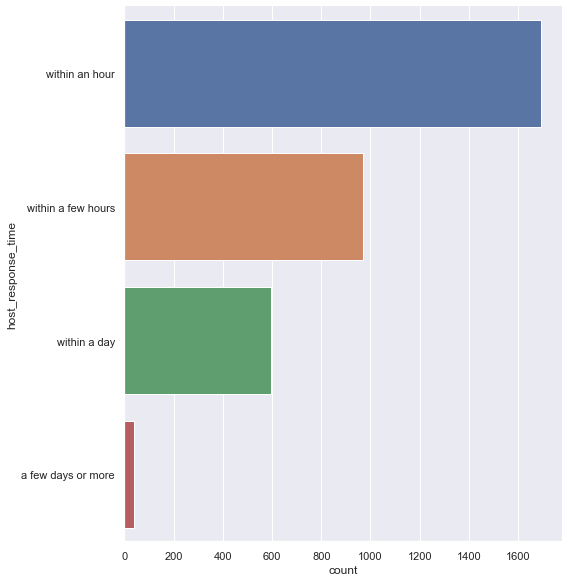

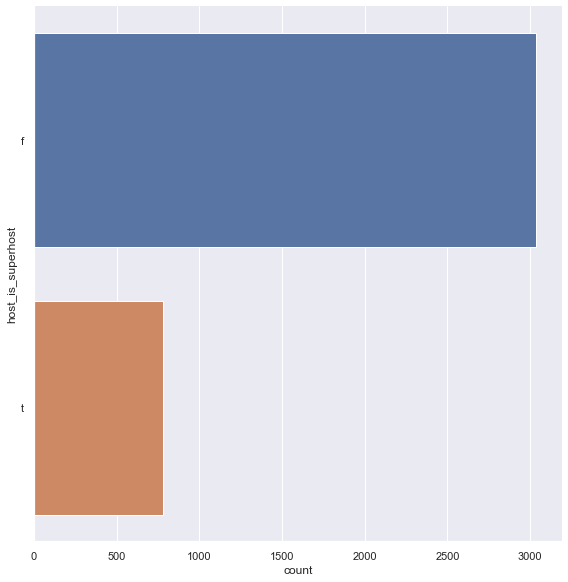

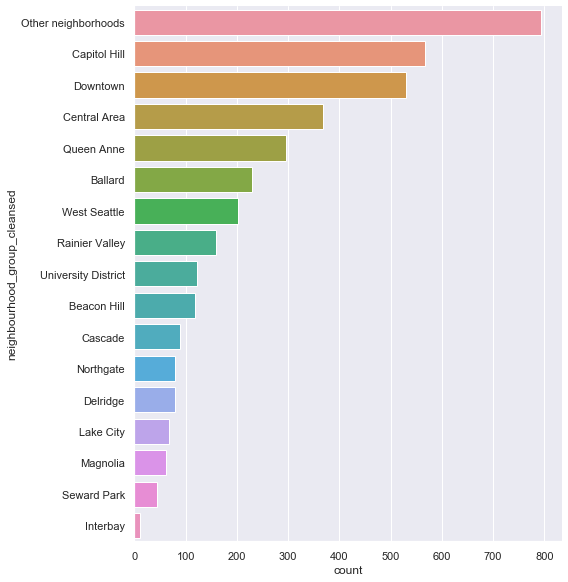

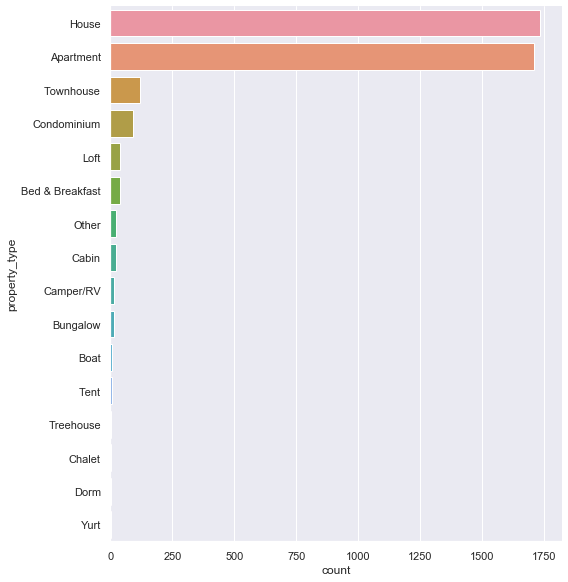

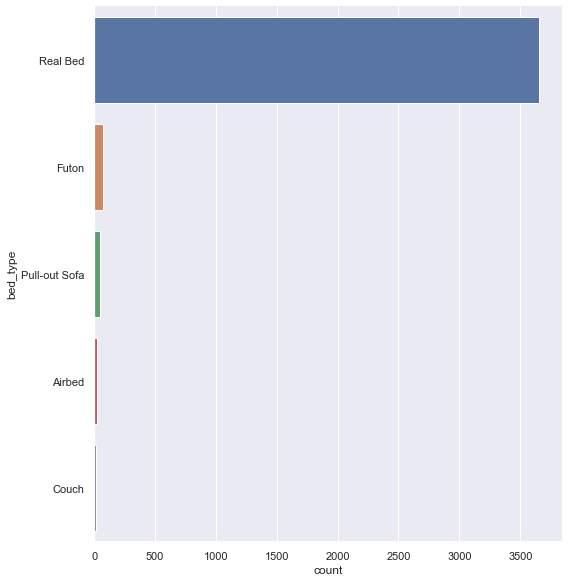

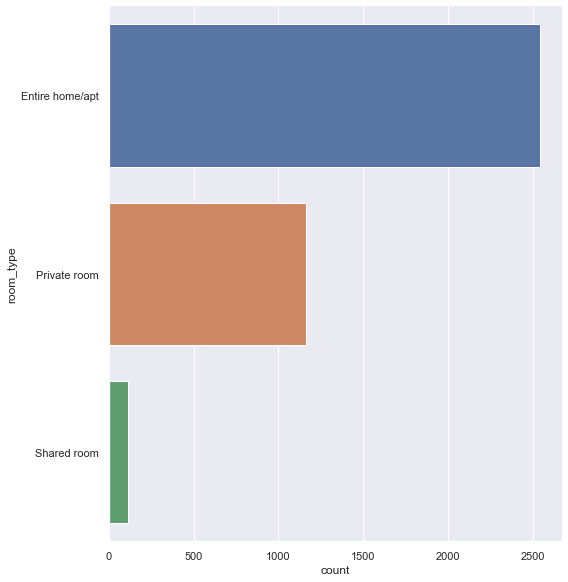

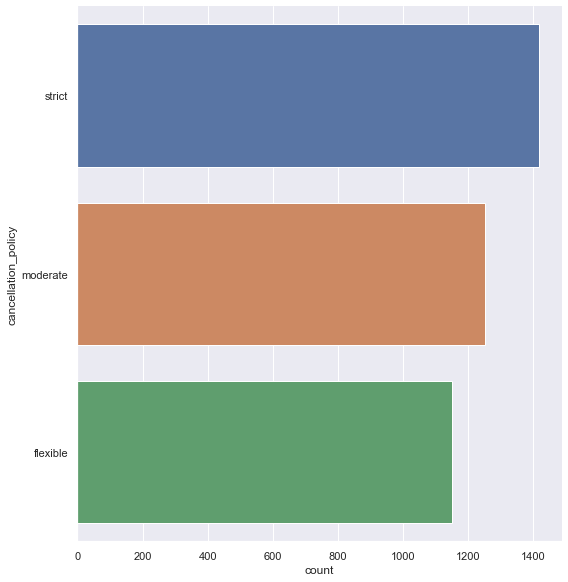

In [4]:
#visualise categorical data
for var in cat_data:
    sb.catplot(y = var, data = cat_data, kind = 'count', 
               order = cat_data[var].value_counts().index, height = 8)

Kprototype clustering for categorical and numeric data

In [5]:
pip install --upgrade kmodes

Requirement already up-to-date: kmodes in /Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages (0.10.2)
Note: you may need to restart the kernel to use updated packages.


In [6]:
from kmodes.kprototypes import KPrototypes
#sources: https://github.com/aryancodify/Clustering/blob/master/K-Prototype%2Bclustering.ipynb
#https://github.com/aryancodify/Clustering/blob/master/K-Mode%2BBank%2BMarketing.ipynb

In [7]:
#Save dataframe for future use
combined_data_kproto = combined_data

#Extract relevant variables for clustering listings 
#include factors that indicate quality of listings and accuracy score to ascertain whether the listing details are accurate
#Convert categorical-like data into object data
joint_df = pd.DataFrame(data = combined_data, columns = ["property_type","room_type","bathrooms","bedrooms","beds","bed_type","accommodates","review_scores_accuracy"])
joint_df = joint_df.astype("object")
#Obtain relevant numeric data
loc_data = pd.DataFrame(data = combined_data, columns = ["longitude","latitude","review_scores_rating"])
#Combine data for clustering
joint_df = pd.concat([loc_data,joint_df],axis=1)

#Data information joint_df.info()

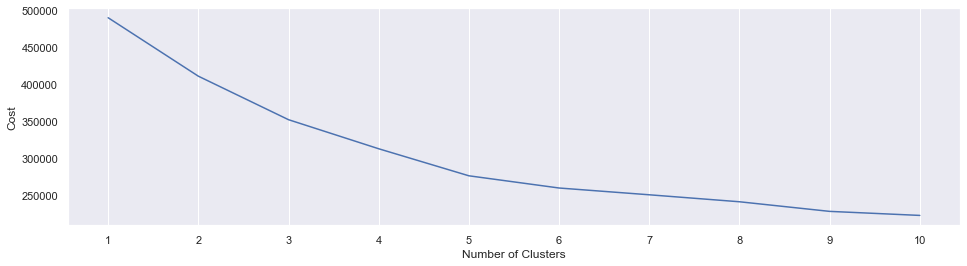

In [8]:
#Calculate cost for various clusters initialisation and determine optimal cluster
min_cluster=1
max_cluster=10  
cost = []
for num_clusters in list(range(min_cluster,max_cluster+1)):
    #Using Kprototype clustering for mixed data
    kproto = KPrototypes(n_clusters=num_clusters, init='Cao')
    #Categorical data are indentified by index in "categorical = []". Other data are identified to be numeric.
    kproto.fit_predict(joint_df, categorical = [3,4,5,6,7,8,9,10])
    cost.append(kproto.cost_)

#plot cost against number of clusters
f, axes = plt.subplots(1, 1, figsize=(16,4))
plt.plot(range(min_cluster, max_cluster+1), cost)
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.xticks(np.arange(min_cluster, max_cluster+1, 1.0))
plt.grid(which='major', axis='y')
plt.show()

In [9]:
#Optimal cluster is 5 as rate of cost-minimisation is great from cluster size 1 to size 5
#rate of cost-minimisation is lower for each additional cluster size after size 5.
num_clusters = 5
#Fit clustering algorithm
kproto = KPrototypes(n_clusters=num_clusters, init = "Cao")
#Predict clusters. fit_predict returns an array of cluster labels
labels_k = kproto.fit_predict(joint_df,categorical = [3,4,5,6,7,8,9,10])

In [10]:
titles=[]
for var in joint_df:
    titles.append(var)

#cluster_centroids_[0] returns the numeric values of cluster centroids as an array
kproto.cluster_centroids_[0]

#initialise variable to indicate nth cluster
clust=0
#centr returns each numeric cluster centroid
for centr in kproto.cluster_centroids_[0]:
    #initialise count to label coordinates of cluster centroid
    count=0
    for coord in centr:
        print("cluster",clust,":\t",titles[count],coord,end="\n")
        count+=1
    clust+=1
    print()

#re-initialise variable to indicate nth cluster
clust=0
#cluster_centroids_[1] returns the categorical values of cluster centroids as an array
for centr in kproto.cluster_centroids_[1]:
    #re-initialise count to label categorical coordinates
    count=3 
    for coord in centr:
        print("cluster",clust,":\t",titles[count],coord,end="\n")
        count+=1
    clust+=1
    print()

cluster 0 :	 longitude -122.3273331264387
cluster 0 :	 latitude 47.63413927059255
cluster 0 :	 review_scores_rating 78.90873015873017

cluster 1 :	 longitude -122.33543277682149
cluster 1 :	 latitude 47.62971753358294
cluster 1 :	 review_scores_rating 95.67130434782608

cluster 2 :	 longitude -122.32933887790317
cluster 2 :	 latitude 47.62621785326524
cluster 2 :	 review_scores_rating 95.31428571428572

cluster 3 :	 longitude -122.33809111342265
cluster 3 :	 latitude 47.628945974600946
cluster 3 :	 review_scores_rating 96.13623188405798

cluster 4 :	 longitude -122.3344200346354
cluster 4 :	 latitude 47.62755308054369
cluster 4 :	 review_scores_rating 97.11678832116789

cluster 0 :	 property_type Apartment
cluster 0 :	 room_type Entire home/apt
cluster 0 :	 bathrooms 1.0
cluster 0 :	 bedrooms 1.0
cluster 0 :	 beds 1.0
cluster 0 :	 bed_type Real Bed
cluster 0 :	 accommodates 2
cluster 0 :	 review_scores_accuracy 9.0

cluster 1 :	 property_type Apartment
cluster 1 :	 room_type Entire hom

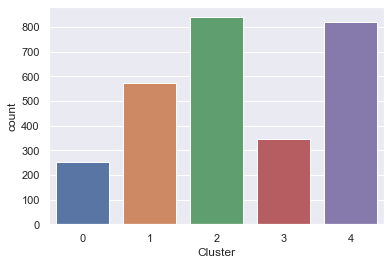

In [11]:
# Append cluster labels to the data
clustered_data_k = joint_df.copy()
clustered_data_k["Cluster"] = pd.Categorical(labels_k)

#use saved copy of combined_data and drop columns that to avoid duplication
combined_data_kproto = combined_data_kproto.drop(columns=["longitude","latitude","review_scores_rating","property_type","room_type",\
                            "bathrooms","bedrooms","beds","bed_type","accommodates","review_scores_accuracy"])

#Combine data
clustered_data_k = pd.concat([clustered_data_k,combined_data_kproto],axis=1)
# data info clustered_data_k.info()

#Copy data for use in predicting ratings score
clustered_data_k_copy=clustered_data_k
# data info clustered_data_k_copy.info()

#Summary of the Cluster Labels
sb.countplot(clustered_data_k["Cluster"])

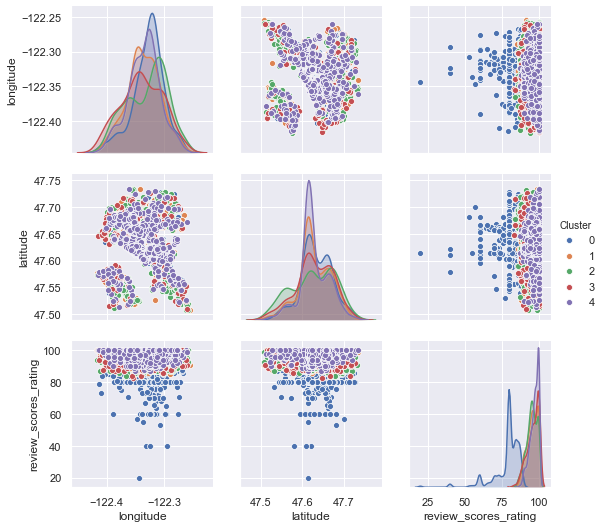

In [12]:
long_lat_data = pd.DataFrame(data=clustered_data_k,columns=["longitude","latitude","review_scores_rating"])
# Plot the Clusters on 2D grids
sb.pairplot(clustered_data_k, vars = long_lat_data.columns.values, hue = "Cluster")

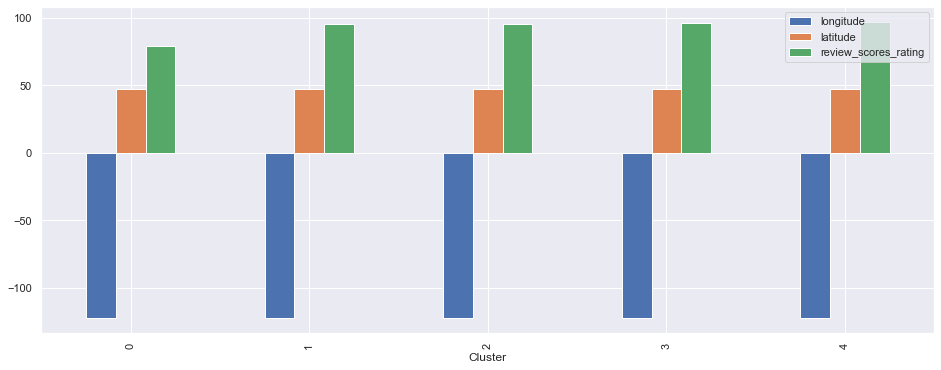

In [13]:
# Average Behaviour of each Cluster
long_lat_data = pd.DataFrame(data=clustered_data_k,columns=["longitude","latitude","review_scores_rating","Cluster"])
long_lat_data = pd.DataFrame(long_lat_data.groupby(by = "Cluster").mean())
long_lat_data.plot.bar(figsize = (16,6))

Listings from each clusters are spread over the whole seattle region. review_scores_rating is generally lower for listings in small-low-quality listing.

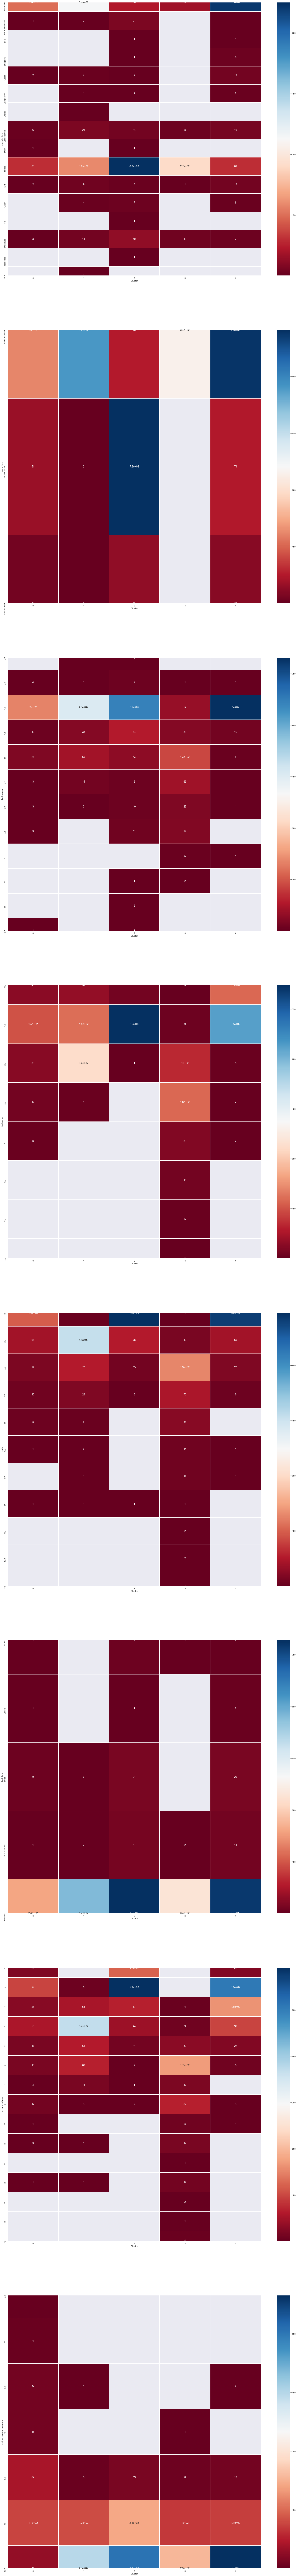

In [14]:
#Visualise categorical data to derive significance of each cluster
f,axes = plt.subplots(8,1, figsize = (30,250))
count = 0
for var in joint_df:
    if (var!='longitude')&(var!='latitude')&(var!='review_scores_rating'):
        #Visualise categorical data with cluster groups
        sb.heatmap(clustered_data_k.groupby([var,'Cluster']).size().unstack(),
               linewidths = 1, annot = True, annot_kws = {"size":14}, cmap= "RdBu", ax = axes[count])
        count+=1

From the categorical heatmaps, the clusters can be viewed as listings of different sizes<br>
Cluster with small-sized listings, most budget stay (small-cheap listing)<br>
-usually private rooms, 1 bedroom, 1 bed, and accommodates 2.<br><br>
Cluster with small-sized listings, lower quality (small-low-quality listing)<br>
-usually entire house, 1 bedroom, 1 bed, and accommodates 2-4, review_scores_accuracy 9 and lower review_scores_rating (78 for cluster centroid)<br><br>
Cluster with small-sized listings, higher budget compared to private rooms (small-high-quality listing)<br>
-usually entire house, 1 bedroom, 1 bed, and accommodates 2<br><br>
Cluster with mid-sized listings (medium listing)<br>
-usually entire house, 2 bedroom, 2 beds, and accommodates 4<br><br>
Cluster with large-sized listings (large listing)<br>
-usually entire house, 2-3 bedroom, 3 beds,and accommodates 6<br><br>


In [15]:
clust_centroid_dict = {}
#re-initialise variable to indicate nth cluster
clust=0
#cluster_centroids_[1] returns the categorical values of cluster centroids as an array
for centr in kproto.cluster_centroids_[1]:
    #cluster contains small-sized, low quality listing if cluster centroid has value of 2 and 9 
    #for "accommodates" and "review_scores_accuracy" respectively.
    if((centr[6]=='2')&(centr[7]=='9.0')):
        clust_centroid_dict.update({clust:"small-low-quality listing"})
        
    #cluster contains small-sized, cheaper listings if cluster centroid has value of 2, 10 and "private room" 
    #for "accommodates", "review_scores_accuracy" and "room type" respectively.
    elif((centr[1]=='Private room')&(centr[6]=='2')&(centr[7]=='10.0')):
        clust_centroid_dict.update({clust:"small-cheap listing"})
    
    #cluster contains small-sized listings if cluster centroid has value of 2, 10 and "Entire home/apt"
    #for "accommodates", "review_scores_accuracy" and "room type" respectively.
    elif((centr[1]=='Entire home/apt')&(centr[6]=='2')&(centr[7]=='10.0')):
        clust_centroid_dict.update({clust:"small-high-quality listing"})
        
    #cluster contains medium-sized listings if cluster centroid has value of 4 for "accommodates".
    elif(centr[6]=='4'):
        clust_centroid_dict.update({clust:"medium listing"})
        
    #cluster contains large-sized listings if cluster centroid has value of 6 for "accommodates".
    elif(centr[6]=='6'):
        clust_centroid_dict.update({clust:"large listing"})
    clust+=1

clust_centroid_dict = {'Cluster':clust_centroid_dict}

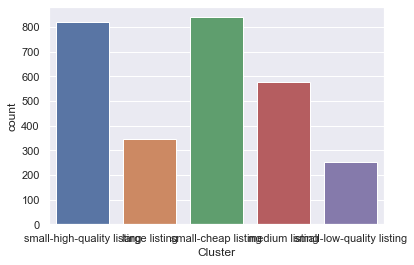

In [16]:
#Change cluster values to indicate size of listings

clustered_data_k = clustered_data_k.replace(clust_centroid_dict)

#Copy data for use in predicting ratings score
clustered_data_k_copy=clustered_data_k
# data info clustered_data_k_copy.info()

#Summary of the Cluster Labels
sb.countplot(clustered_data_k["Cluster"])

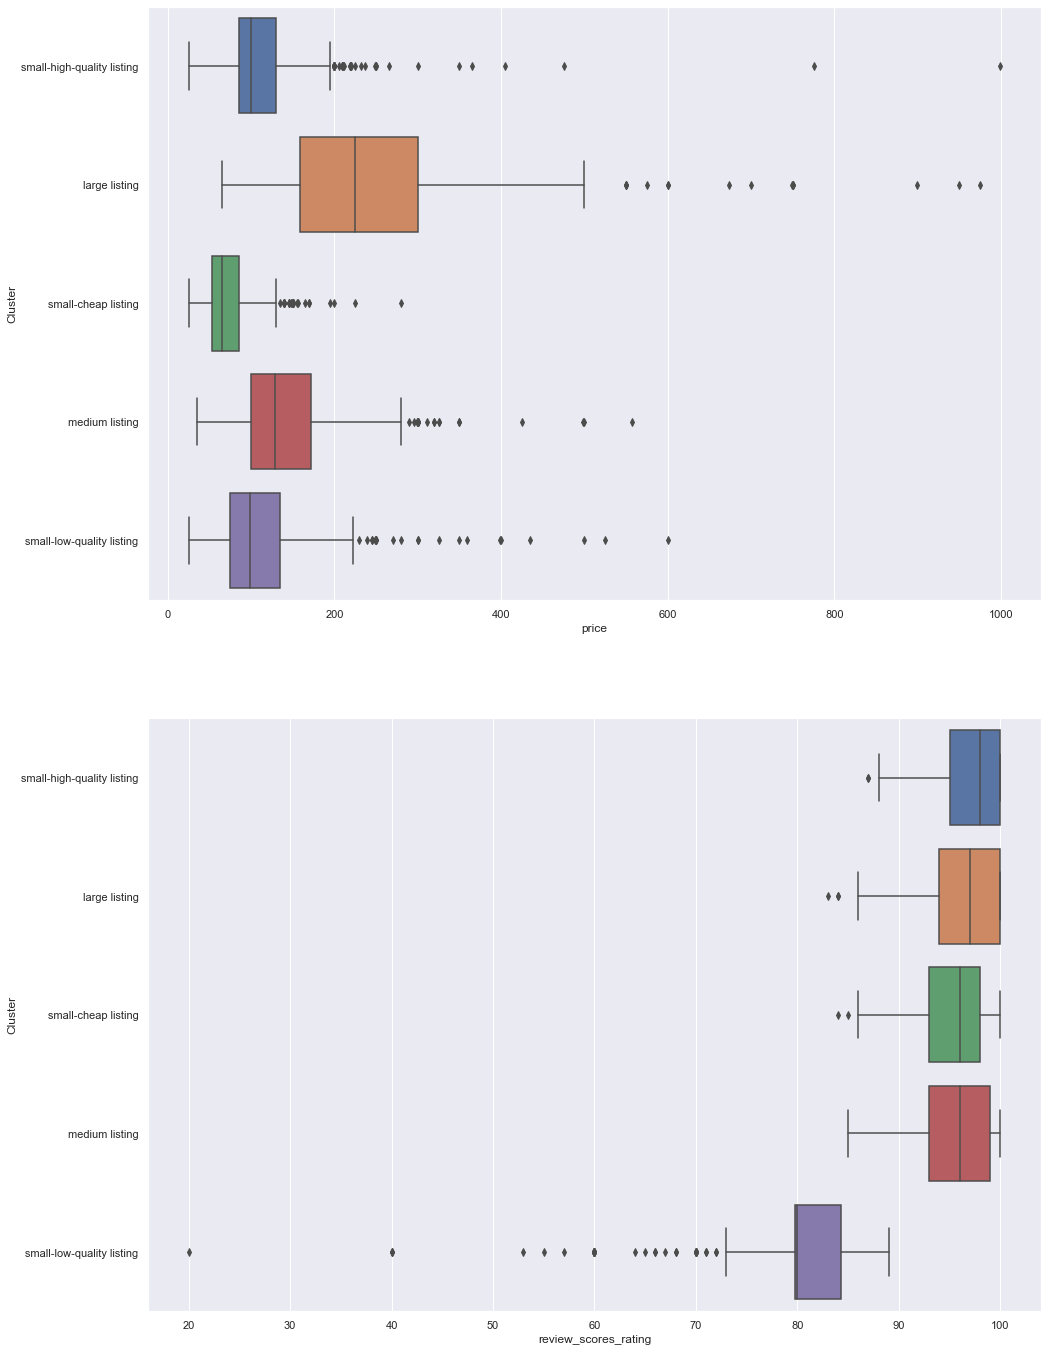

In [17]:
# Boxplots to visualise relationship within clusters
f, axes = plt.subplots(2, 1, figsize=(16,24))
sb.boxplot(x = 'price', y = 'Cluster', data = clustered_data_k, ax = axes[0])
sb.boxplot(x = 'review_scores_rating', y = 'Cluster', data = clustered_data_k, ax = axes[1])

According to the boxplots,<br>
price is segmented across the various clusters, indicating that the size (or number of people the listing can accommodate) has a moderate relationship with price. Distributions of ratings do not vary much except for cluster 4, which has must lower values in general. 

Install relevant modules for visualising map<br>
sources referred:<br>
https://medium.com/@ianforrest11/graphing-latitudes-and-longitudes-on-a-map-bf64d5fca391 <br>
https://jakevdp.github.io/PythonDataScienceHandbook/04.13-geographic-data-with-basemap.html <br>
https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972<br>

In [18]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [19]:
pip install descartes

Note: you may need to restart the kernel to use updated packages.


In [20]:
pip install shapely

Note: you may need to restart the kernel to use updated packages.


In [21]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [22]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [23]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import descartes
import folium

In [24]:
list_of_clust=[]
for key in clust_centroid_dict['Cluster']:
    list_of_clust.append(clust_centroid_dict['Cluster'][key])

list_of_clust

['small-low-quality listing',
 'medium listing',
 'small-cheap listing',
 'large listing',
 'small-high-quality listing']

/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


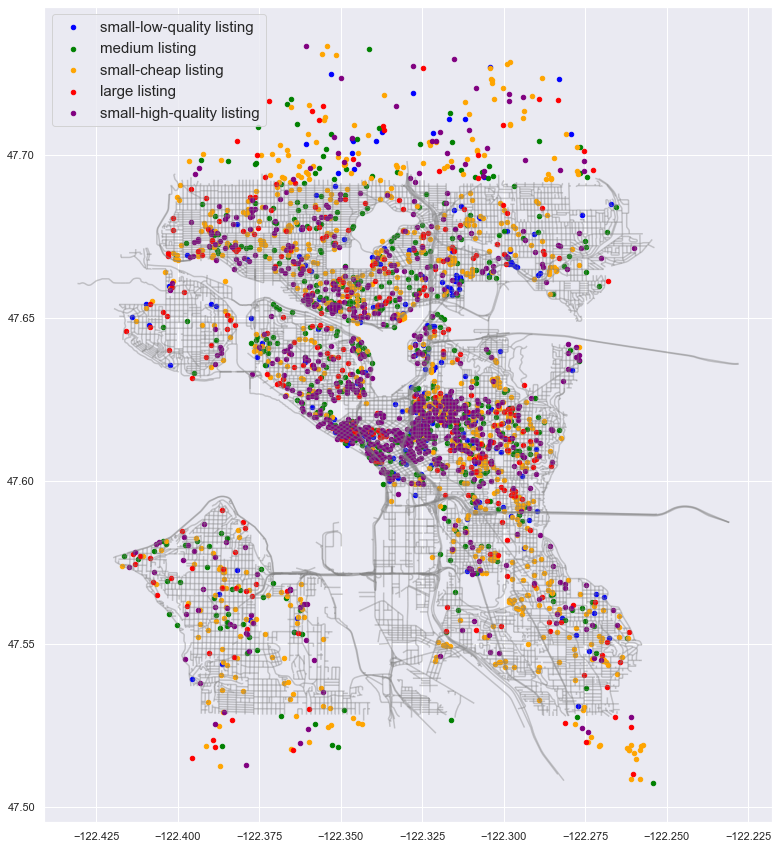

In [25]:
#source: http://data-seattlecitygis.opendata.arcgis.com/datasets/seattle-streets
streetmap = gpd.read_file('Seattle_Streets.shp')

#define coordinate system reference format
crs = {'init':'epsg:4326'}
#Obtaining corresponding points from longitude and latitude
geometry = [Point(xy) for xy in zip(clustered_data_k['longitude'],clustered_data_k['latitude'])]
#Visualise map
geo_df = gpd.GeoDataFrame(clustered_data_k,
                         crs = crs,
                         geometry=geometry)

#Obtain a list containing cluster labels
list_clust = geo_df["Cluster"].value_counts()

#Render map
fig, ax = plt.subplots(figsize = (15,15))
streetmap.plot(ax=ax,alpha=0.4,color='grey')
#colors list for varying colours of different clusters
colors = ["blue","green","orange","red","purple"]
c_count=0
#plot points from each cluster
for var in list_of_clust:
    geo_df[geo_df["Cluster"]==var].plot(ax = ax, markersize = 20, color = colors[c_count], marker = "o",label = str(var))
    c_count+=1
plt.legend(prop={'size':15})

From the maps, the area at and around longitude -122.33 and latitude 47.62 have greatest density of listings across all clusters, suggesting that it is a popular area, where demand may be higher and it may have more tourists.<br>
Overall, houses from each cluster are evenly distributed across the map, suggesting that there is no specific location where there are more higher quality houses.<br>
However, for small-cheap listing cluster, the density of listings at the supposed area for tourists is low, potentially suggesting that listings of lower budget are generally located outside of popular areas.

Visualise distribution of listings of each cluster on different maps

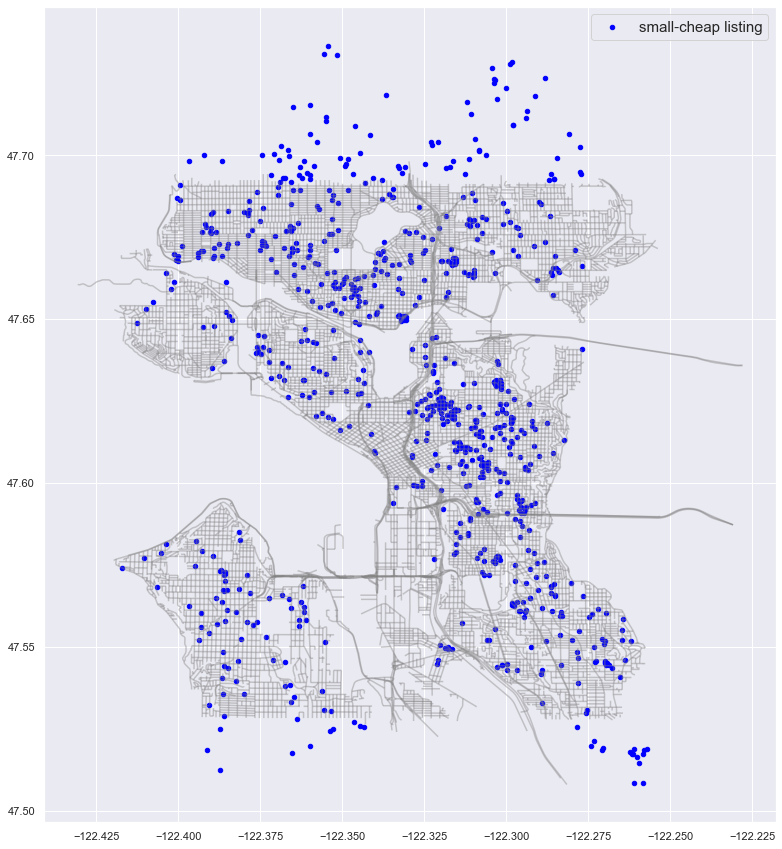

In [26]:
#cluster with 'small-cheap listings'
fig, ax = plt.subplots(figsize = (15,15))
streetmap.plot(ax=ax,alpha=0.4,color='grey')
var = 'small-cheap listing'
c_count=0
geo_df[geo_df["Cluster"]==var].plot(ax = ax, markersize = 20, color = colors[c_count], marker = "o",label = str(var))
plt.legend(prop={'size':15})

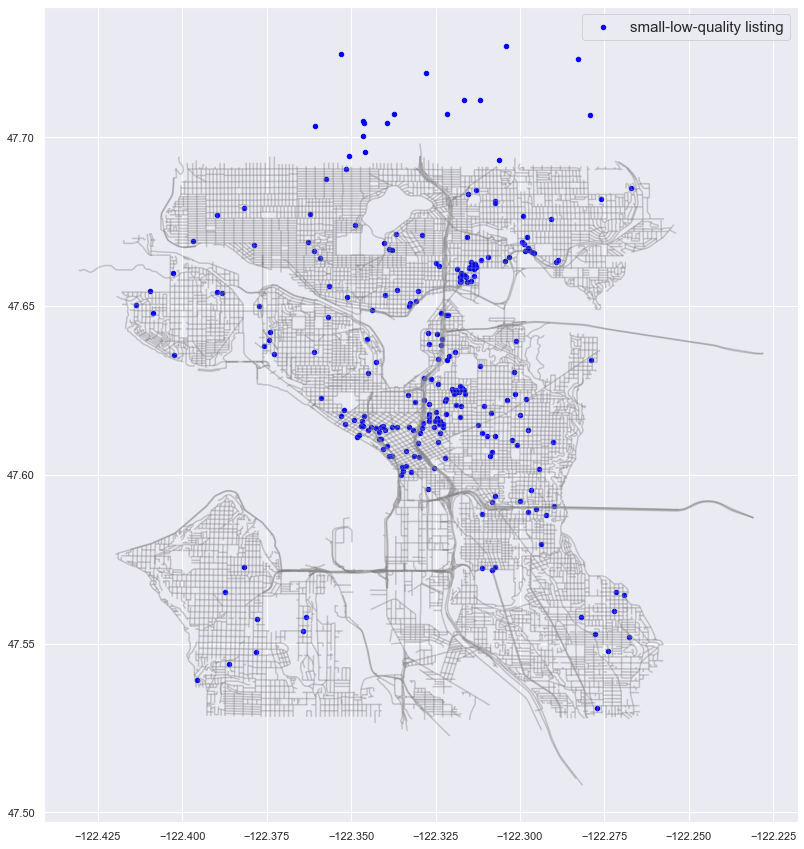

In [27]:
#cluster with 'small-low-quality listing'
fig, ax = plt.subplots(figsize = (15,15))
streetmap.plot(ax=ax,alpha=0.4,color='grey')
var = 'small-low-quality listing'
c_count=0
geo_df[geo_df["Cluster"]==var].plot(ax = ax, markersize = 20, color = colors[c_count], marker = "o",label = str(var))
plt.legend(prop={'size':15})

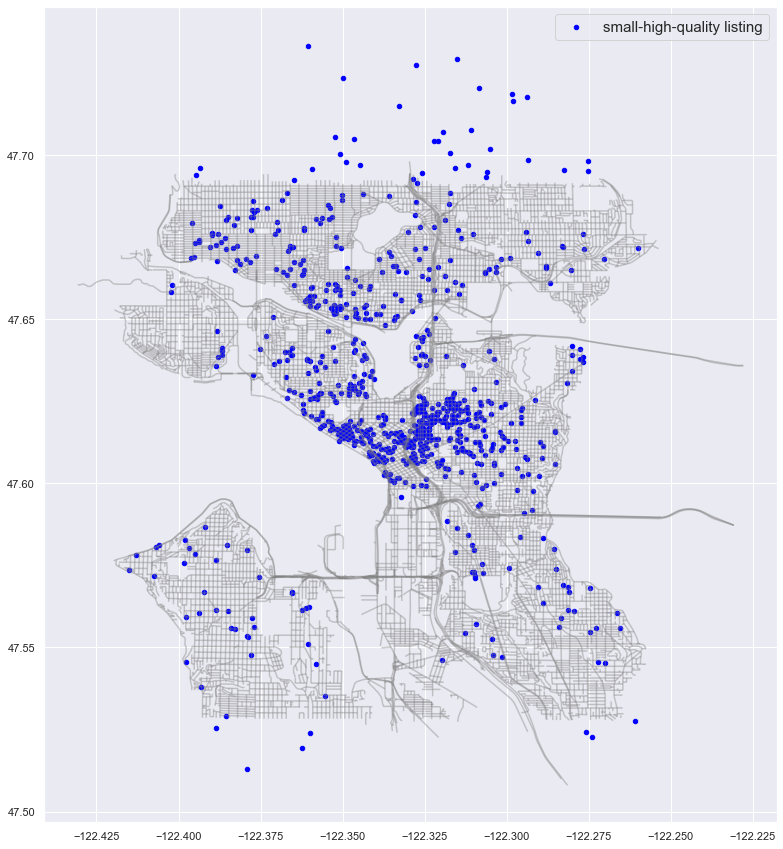

In [28]:
#cluster with 'small-high-quality listing'
fig, ax = plt.subplots(figsize = (15,15))
streetmap.plot(ax=ax,alpha=0.4,color='grey')
var = 'small-high-quality listing'
c_count=0
geo_df[geo_df["Cluster"]==var].plot(ax = ax, markersize = 20, color = colors[c_count], marker = "o",label = str(var))
plt.legend(prop={'size':15})

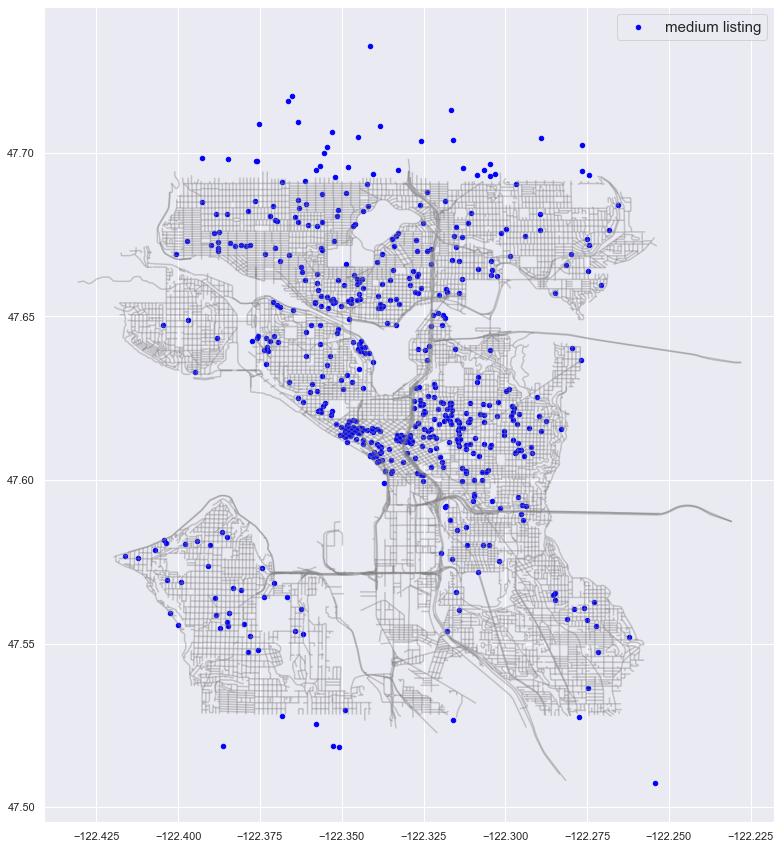

In [29]:
#cluster with 'medium listing'
fig, ax = plt.subplots(figsize = (15,15))
streetmap.plot(ax=ax,alpha=0.4,color='grey')
var = 'medium listing'
c_count=0
geo_df[geo_df["Cluster"]==var].plot(ax = ax, markersize = 20, color = colors[c_count], marker = "o",label = str(var))
plt.legend(prop={'size':15})

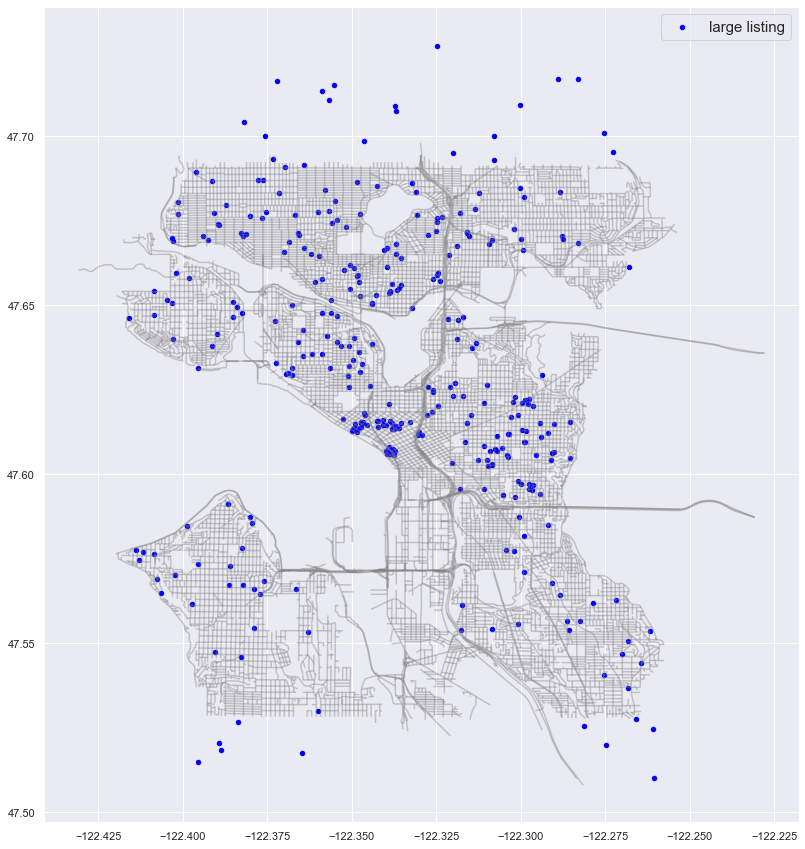

In [30]:
#cluster with 'large listing'
fig, ax = plt.subplots(figsize = (15,15))
streetmap.plot(ax=ax,alpha=0.4,color='grey')
var = 'large listing'
c_count=0
geo_df[geo_df["Cluster"]==var].plot(ax = ax, markersize = 20, color = colors[c_count], marker = "o",label = str(var))
plt.legend(prop={'size':15})

# What is a reasonable price for a listing? 

In [31]:
#Extract categorical data to check correlation
cat_data = pd.DataFrame(data = clustered_data_k_copy, columns = ["Cluster","host_response_time","host_is_superhost","neighbourhood_group_cleansed","property_type","bed_type","room_type","cancellation_policy"])
#Extract numeric data to check correlation
num_data = pd.DataFrame(data = clustered_data_k_copy, columns = ["review_scores_rating","review_scores_accuracy",\
                                                    "review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_location","review_scores_value",
                                                                "bathrooms","bedrooms","beds","accommodates","security_deposit","cleaning_fee","guests_included","extra_people",
                                                                "host_response_rate","number_of_reviews","price"])
num_data = num_data.astype("float64")
#Check correlation between price and other numeric variables
num_data.corr()

review_scores_rating  review_scores_accuracy  \
review_scores_rating                     1.000000                0.635666   
review_scores_accuracy                   0.635666                1.000000   
review_scores_cleanliness                0.630845                0.553188   
review_scores_checkin                    0.532459                0.428200   
review_scores_communication              0.558149                0.445569   
review_scores_location                   0.386768                0.275277   
review_scores_value                      0.706403                0.570813   
bathrooms                                0.035538               -0.023565   
bedrooms                                 0.011658               -0.026292   
beds                                    -0.007214               -0.058434   
accommodates                            -0.022593               -0.059861   
security_deposit                         0.011434               -0.018750   
cleaning_fee                            -0.010468               -0.052688   
guests_included                         -0.003372               -0.001360   
extra_people                            -0.043988               -0.037781   
host_response_rate                       0.158575                0.132402   
number_of_reviews                        0.038468                0.069304   
price                                    0.043344                0.004880   

                             review_scores_cleanliness  review_scores_checkin  \
review_scores_rating                          0.630845               0.532459   
review_scores_accuracy                        0.553188               0.428200   
review_scores_cleanliness                     1.000000               0.403546   
review_scores_checkin                         0.403546               1.000000   
review_scores_communication                   0.389574               0.706082   
review_scores_location                        0.294886               0.251075   
review_scores_value                           0.518654               0.416558   
bathrooms                                     0.016103              -0.010616   
bedrooms                                     -0.020769               0.000143   
beds                                          0.005871              -0.028047   
accommodates                                  0.007268              -0.028460   
security_deposit                              0.023248               0.010502   
cleaning_fee                                  0.059142              -0.073046   
guests_included                               0.015751               0.036762   
extra_people                                 -0.002742              -0.075561   
host_response_rate                            0.170311               0.152590   
number_of_reviews                             0.050619               0.096575   
price                                         0.056375               0.001361   

                             review_scores_communication  \
review_scores_rating                            0.558149   
review_scores_accuracy                          0.445569   
review_scores_cleanliness                       0.389574   
review_scores_checkin                           0.706082   
review_scores_communication                     1.000000   
review_scores_location                          0.296309   
review_scores_value                             0.473825   
bathrooms                                      -0.025382   
bedrooms                                       -0.008542   
beds                                           -0.022808   
accommodates                                   -0.026387   
security_deposit                               -0.007257   
cleaning_fee                                   -0.064938   
guests_included                                 0.009878   
extra_people                                   -0.091805   
host_response_rate                              0.165911   
numbe

Price has a moderately strong postive correlation with bathrooms, bedrooms, beds, accommodates, cleaning_fee<br>
It has a weak relationship with guests_included,security deposit<br>

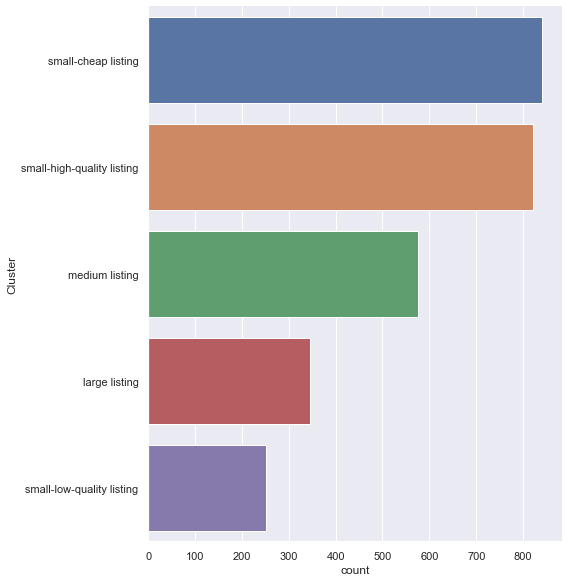

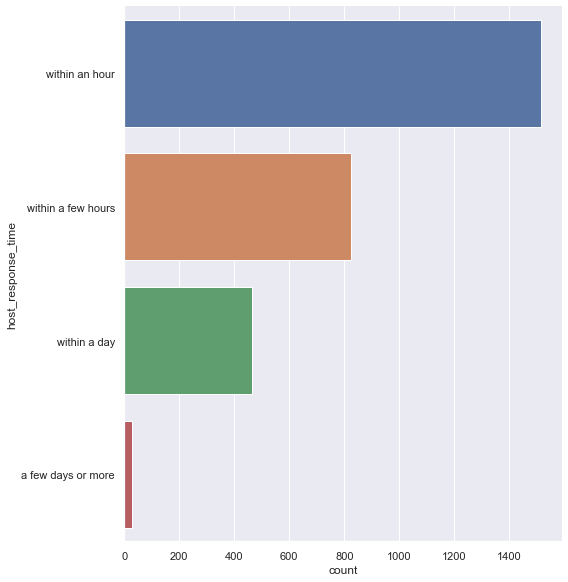

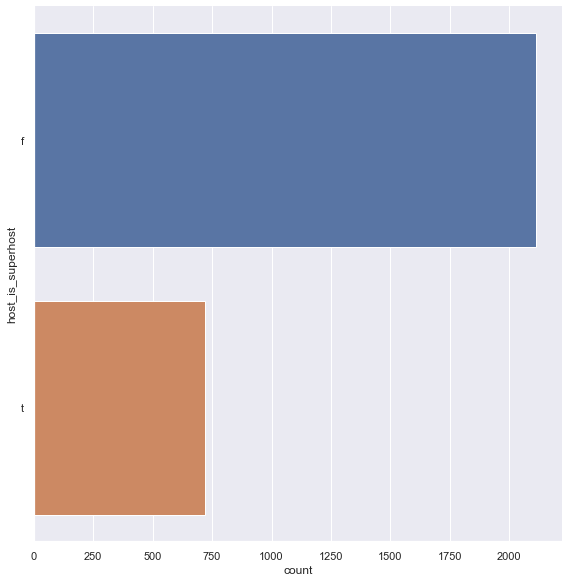

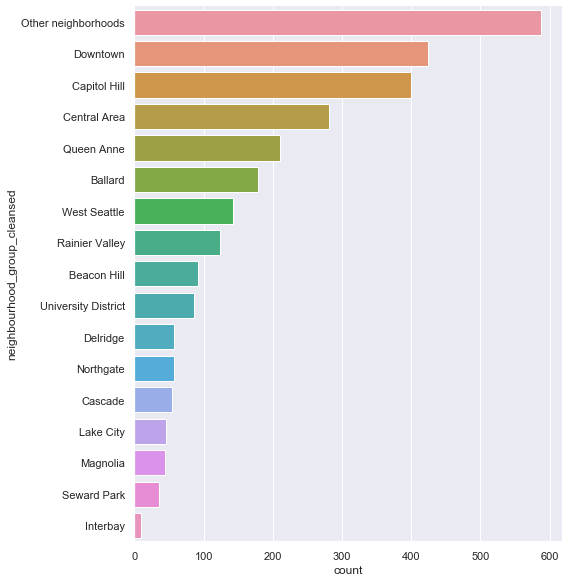

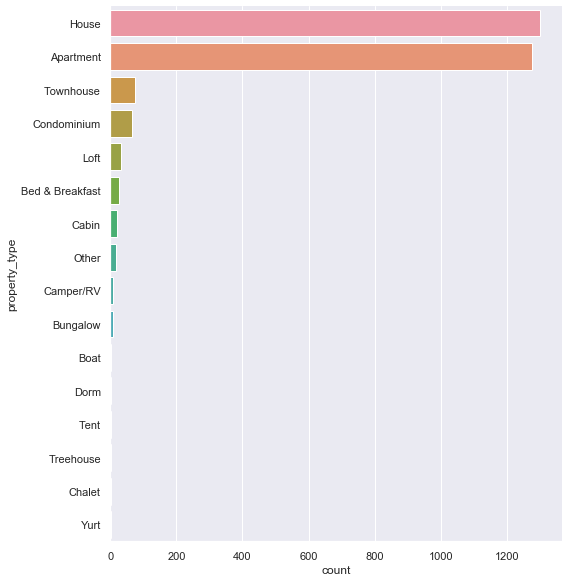

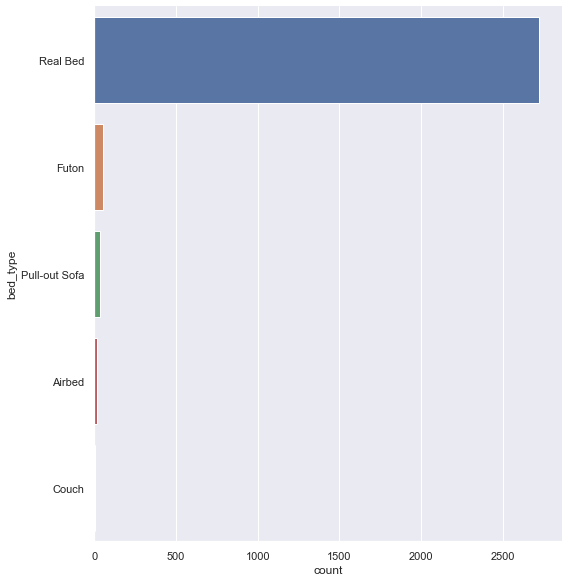

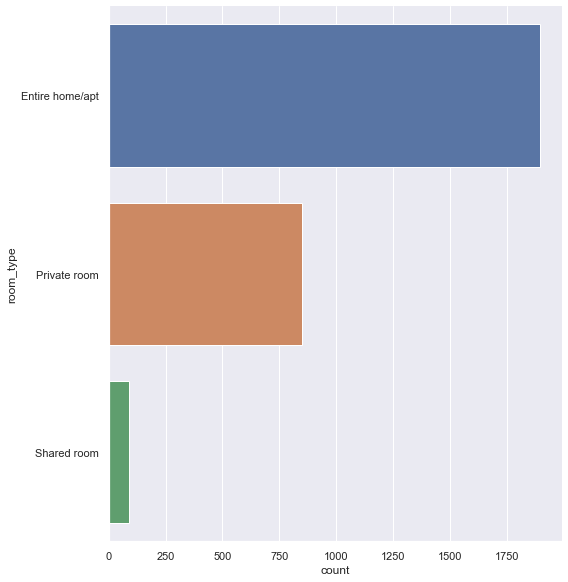

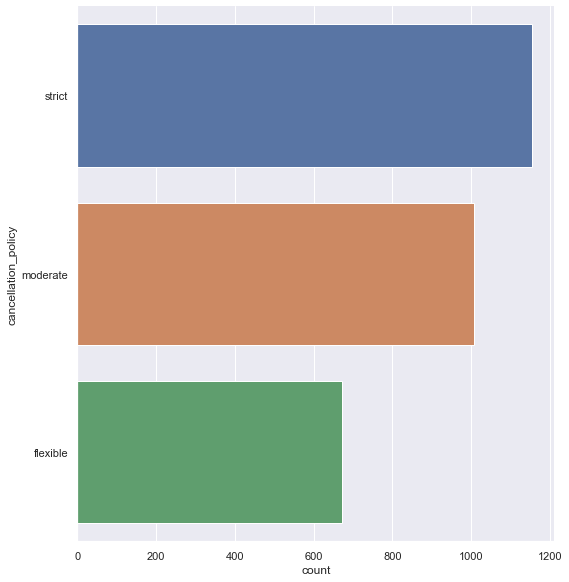

In [32]:
#visualise categorical data
for var in cat_data:
    sb.catplot(y = var, data = clustered_data_k_copy , kind = 'count', 
               order = clustered_data_k_copy[var].value_counts().index, height = 8)

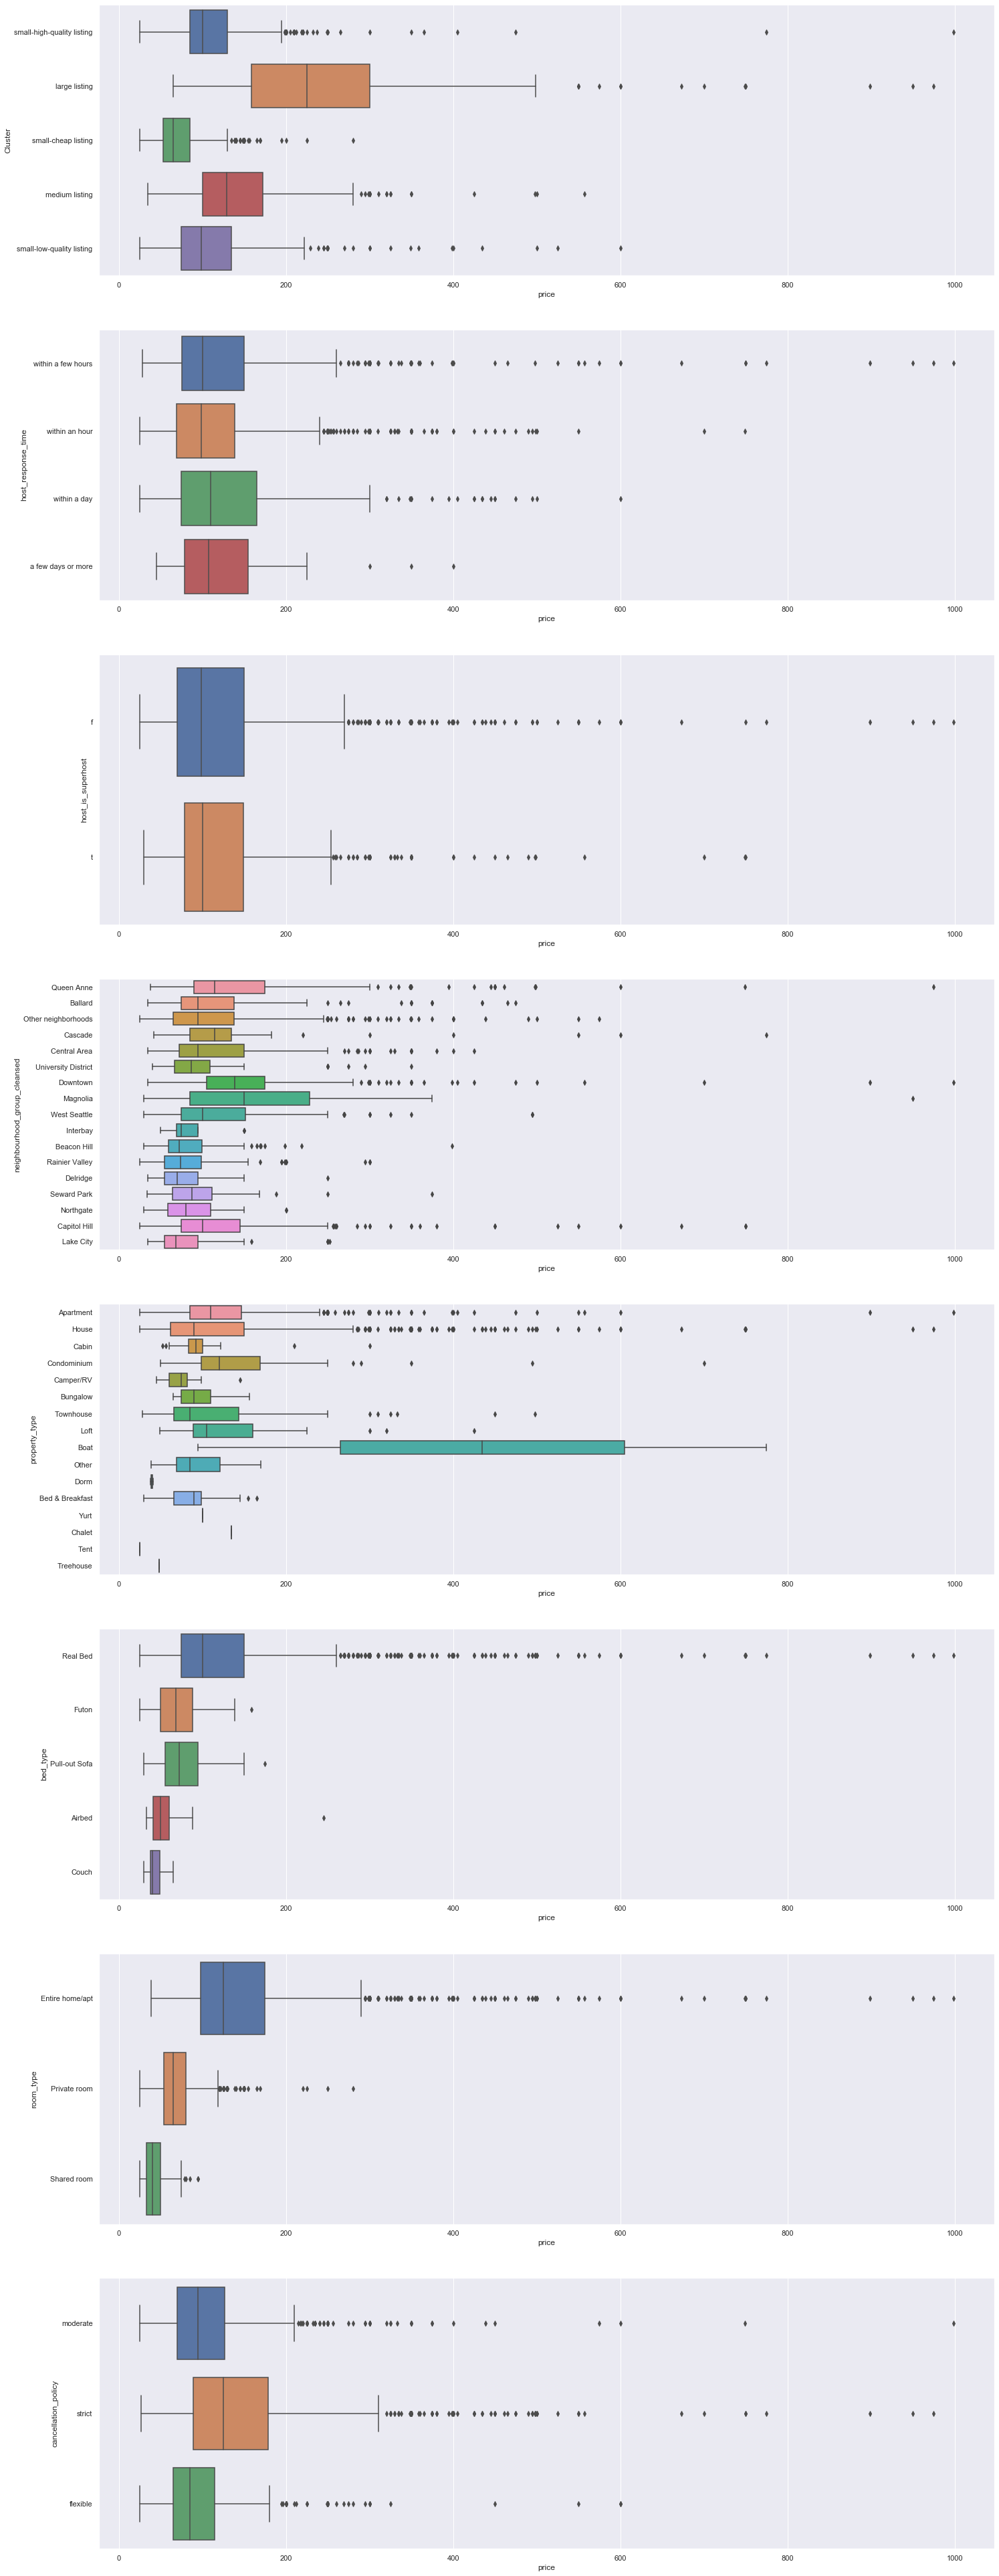

In [33]:
#Visualise categorical variables with price to check for possible relationship
#Boxplots for all categorical variables against the price
f, axes = plt.subplots(8, 1, figsize=(24,70))
count=0
for var in cat_data:
    sb.boxplot(x = 'price', y = var, data = clustered_data_k_copy, ax = axes[count])
    count+=1

neighbourhood_group_cleansed and property_type, bed_type and room_type seems to have a possible relationship with price.

In [34]:
cleanup_df=clustered_data_k_copy
#Extra data and drop NaN values'
temp_df = pd.DataFrame(clustered_data_k_copy[['bathrooms','bedrooms','beds','accommodates']])
temp_df = temp_df.astype("int64")
cleanup_df = pd.DataFrame(clustered_data_k_copy[['price','room_type','property_type','bed_type','neighbourhood_group_cleansed','cleaning_fee','guests_included','Cluster']])
cleanup_df = pd.concat([cleanup_df,temp_df],axis=1)
cleanup_df = cleanup_df.dropna(how='any')

#Remove categories with low counts
propertytype = ["Bed & Breakfast","Other","Cabin","Bungalow","Camper/RV","Boat","Tent","Treehouse","Dorm","Chalet","Yurt"]
for ptype in propertytype:
    cleanup_df = cleanup_df[cleanup_df["property_type"]!=ptype]

#Remove categories with low counts
cleanup_df = cleanup_df[cleanup_df["neighbourhood_group_cleansed"]!="Interbay"]
cleanup_df = cleanup_df[cleanup_df["bed_type"]!="Airbed"]
cleanup_df = cleanup_df[cleanup_df["bed_type"]!="Couch"]

#Encode categorical data with numeric values
cleanup_df_dict = {"room_type":{"Entire home/apt": 3, "Private room": 2,"Shared room":1},
                   "property_type":{"House":2,"Apartment":4,"Townhouse":1,"Condominium":5,"Loft":3},
                   "bed_type":{"Real Bed":2,"Futon":1,"Pull-out Sofa":1},
                   "neighbourhood_group_cleansed":{"Other neighborhoods":2,"Capitol Hill":2,"Downtown":3,"Central Area":2,
                                                   "Queen Anne":3,"Ballard":2,"West Seattle":2,"Rainier Valley":1,"University District":1,
                                                    "Beacon Hill":1,"Cascade":2,"Delridge":1,"Northgate":1,"Lake City":1,"Magnolia":3,"Seward Park":1}}

cleanup_df.replace(cleanup_df_dict, inplace=True)

#create a copy for future use
cleanup_df_copy = cleanup_df

cleanup_df.corr()

price  room_type  property_type  bed_type  \
price                         1.000000   0.445256       0.001184  0.107090   
room_type                     0.445256   1.000000       0.314101  0.167173   
property_type                 0.001184   0.314101       1.000000 -0.016217   
bed_type                      0.107090   0.167173      -0.016217  1.000000   
neighbourhood_group_cleansed  0.252977   0.195361       0.344875 -0.009793   
cleaning_fee                  0.616209   0.422638      -0.011238  0.109325   
guests_included               0.433127   0.267239      -0.143964  0.068253   
bathrooms                     0.549053   0.139838      -0.187379  0.057418   
bedrooms                      0.634091   0.228461      -0.266698  0.096775   
beds                          0.609337   0.358216      -0.131957  0.096771   
accommodates                  0.669111   0.468937      -0.087432  0.117813   

                              neighbourhood_group_cleansed  cleaning_fee  \
price                                             0.252977      0.616209   
room_type                                         0.195361      0.422638   
property_type                                     0.344875     -0.011238   
bed_type                                         -0.009793      0.109325   
neighbourhood_group_cleansed                      1.000000      0.160491   
cleaning_fee                                      0.160491      1.000000   
guests_included                                   0.011663      0.363411   
bathrooms                                         0.062746      0.468691   
bedrooms                                         -0.006982      0.584516   
beds                                              0.058870      0.621726   
accommodates                                      0.093378      0.654460   

                              guests_included  bathrooms  bedrooms      beds  \
price                                0.433127   0.549053  0.634091  0.609337   
room_type                            0.267239   0.139838  0.228461  0.358216   
property_type                       -0.143964  -0.187379 -0.266698 -0.131957   
bed_type                             0.068253   0.057418  0.096775  0.096771   
neighbourhood_group_cleansed         0.011663   0.062746 -0.006982  0.058870   
cleaning_fee                         0.363411   0.468691  0.584516  0.621726   
guests_included                      1.000000   0.322597  0.477564  0.489673   
bathrooms                            0.322597   1.000000  0.621424  0.527973   
bedrooms                             0.477564   0.621424  1.000000  0.762643   
beds                                 0.489673   0.527973  0.762643  1.000000   
accommodates                         0.548041   0.557026  0.772461  0.868628   

                              accommodates  
price                             0.669111  
room_type                         0.468937  
property_type                    -0.087432  
bed_type                          0.117813  
neighbourhood_group_cleansed      0.093378  
cleaning_fee                      0.654460  
guests_included                   0.548041  
bathrooms                         0.557026  
bedrooms                          0.772461  
beds                              0.868628  
accommodates                      1.000000

For the whole dataset, price has a moderately strong correlation with bathrooms, bedrooms, beds, accommodates and cleaning_fee.
Price has a weak relationship with neighbourhood_group_cleansed and room_type

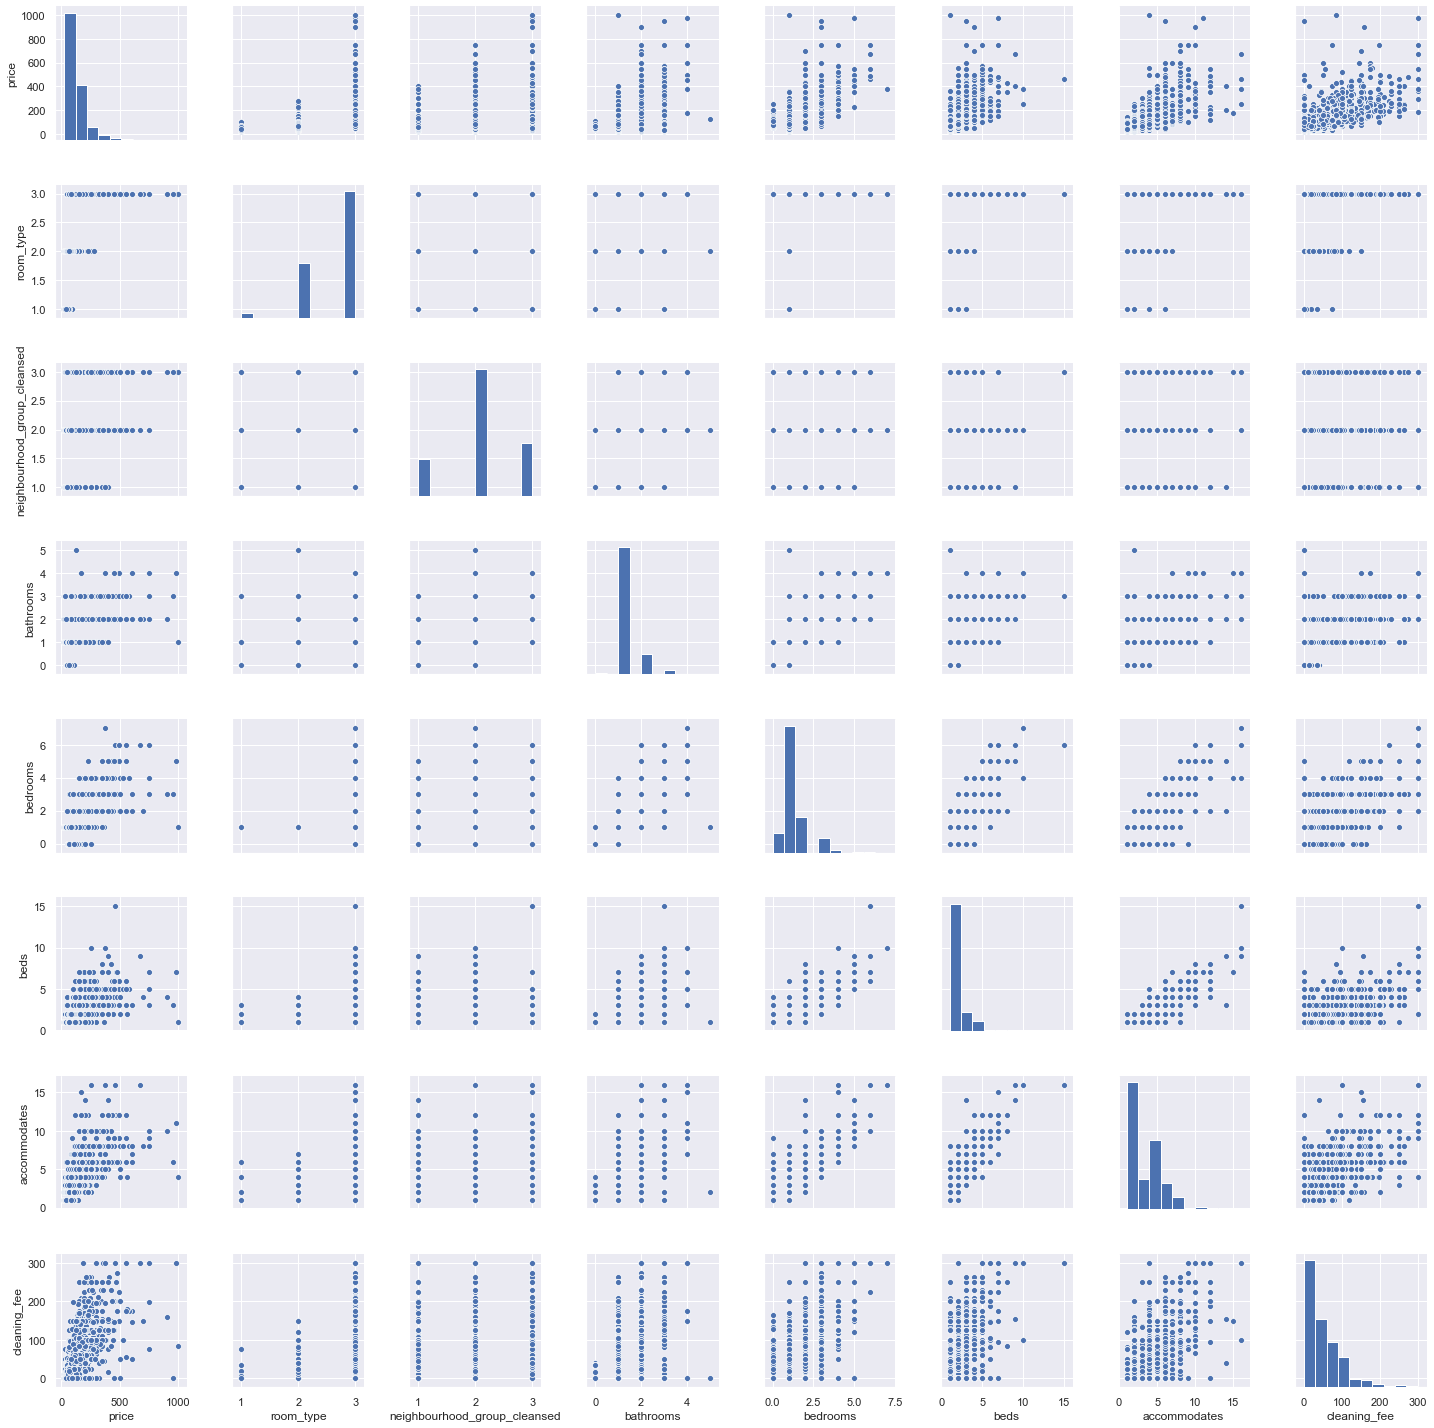

In [35]:
#Extract variables for price prediction
cleanup_df = pd.DataFrame(cleanup_df[['price','room_type','neighbourhood_group_cleansed','bathrooms','bedrooms','beds','accommodates','cleaning_fee']])
cleanup_df=cleanup_df.dropna(how='any')
y = pd.DataFrame(cleanup_df["price"])
X = pd.DataFrame(cleanup_df[['room_type','neighbourhood_group_cleansed','bathrooms','bedrooms','beds','accommodates','cleaning_fee']])

# Relationship between Response and the Predictors
sb.pairplot(data = cleanup_df)

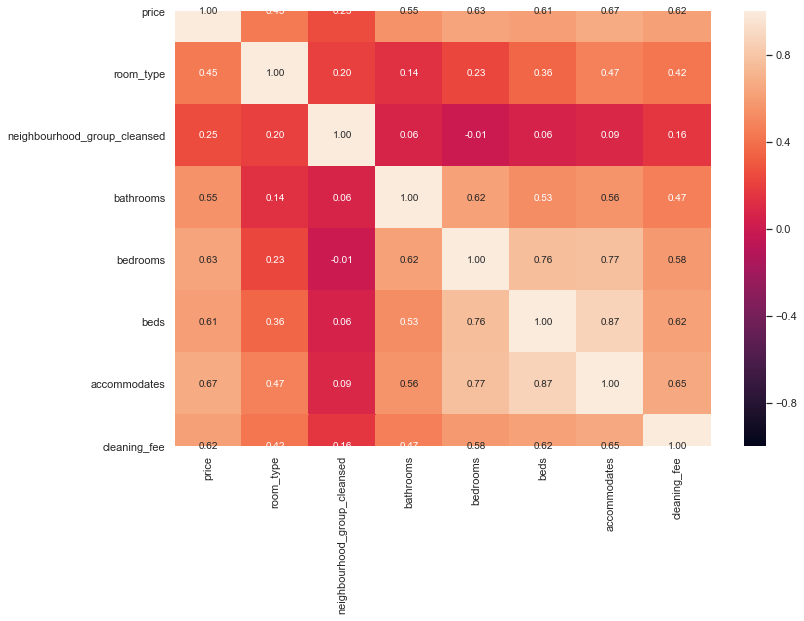

In [36]:
f, axes = plt.subplots(1, 1, figsize=(12, 8))
sb.heatmap(cleanup_df.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

# Using linear regression and random forest regression to predict prices

In [37]:
#Import modules
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
print("Train Set :", y_train.shape, X_train.shape)
print("Test Set  :", y_test.shape, X_test.shape)

# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, y_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Print the Coefficients against Predictors
pd.DataFrame(list(zip(X_train.columns, linreg.coef_[0])), columns = ["Predictors", "Coefficients"])

Train Set : (2037, 1) (2037, 7)
Test Set  : (679, 1) (679, 7)
Intercept of Regression 	: b =  [-97.18606291]
Coefficients of Regression 	: a =  [[28.55924203 20.22819368 29.5959664  22.19040005  1.48234203  5.62985607
   0.38048393]]



Predictors  Coefficients
0                     room_type     28.559242
1  neighbourhood_group_cleansed     20.228194
2                     bathrooms     29.595966
3                      bedrooms     22.190400
4                          beds      1.482342
5                  accommodates      5.629856
6                  cleaning_fee      0.380484

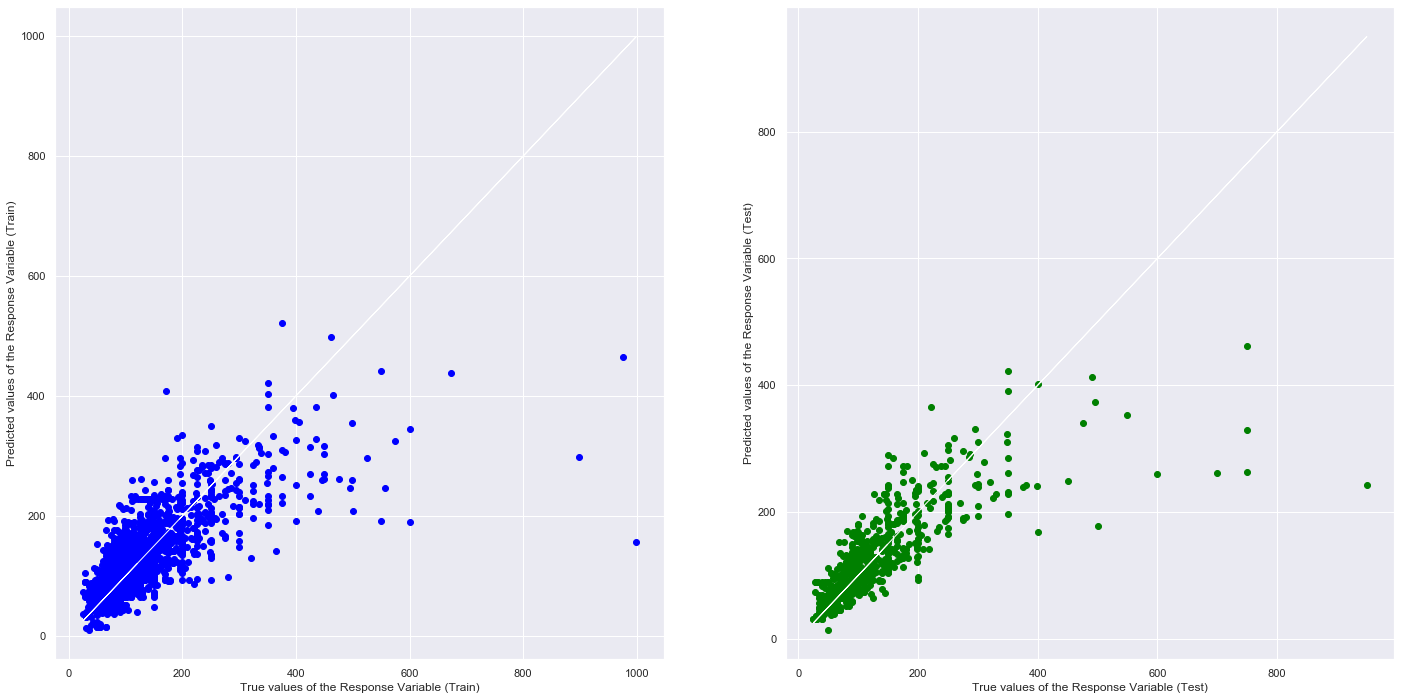

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.5909801042787235
Mean Squared Error (MSE) 	: 2850.84414422053

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.6048513116891767
Mean Squared Error (MSE) 	: 3791.5292617291184



In [38]:
# Predict the Total values from Predictors
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

In [39]:
from sklearn.model_selection import cross_val_score
from sklearn import svm
clf = svm.SVC(kernel='linear', C=1)
#source: https://scikit-learn.org/stable/modules/cross_validation.html
#Determine performance of model using cross_val_score
scores = cross_val_score(linreg, X, y, cv=5)
print("Explained Variance :%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#The linear regression model has moderate performance in predicting prices

Explained Variance :0.58 (+/- 0.17)


In [40]:
#the order of costs are explained variance for train and test, and mse for train and test
cost_linreg = {"R^2_train":0,"R^2_test":0,"MSE_train":0,"MSE_test":0}
num_iterations = 10
# Check value of explained variance for test and train over 10 iterations
R2_list = []
R2_list_test = []

for i in range(0,num_iterations):
    # Split the Dataset into Train and Test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
    # train the linear regression model
    linreg.fit(X_train, y_train)   
    # Predict Response corresponding to Predictors
    y_train_pred = linreg.predict(X_train)
    y_test_pred = linreg.predict(X_test)
                           
    cost_linreg["R^2_train"]+=(linreg.score(X_train, y_train))
    cost_linreg["MSE_train"]+=(mean_squared_error(y_train, y_train_pred))
    
    cost_linreg["R^2_test"]+=(linreg.score(X_test, y_test))
    cost_linreg["MSE_test"]+=(mean_squared_error(y_test, y_test_pred))
    R2_list.append(linreg.score(X_train, y_train))
    R2_list_test.append(linreg.score(X_test, y_test))
    
for var in cost_linreg:
    cost_linreg[var]/=10
    print(var,": ",cost_linreg[var])



R^2_train :  0.595902373492453
R^2_test :  0.6060225484702938
MSE_train :  3086.459729007611
MSE_test :  3039.2575885503225


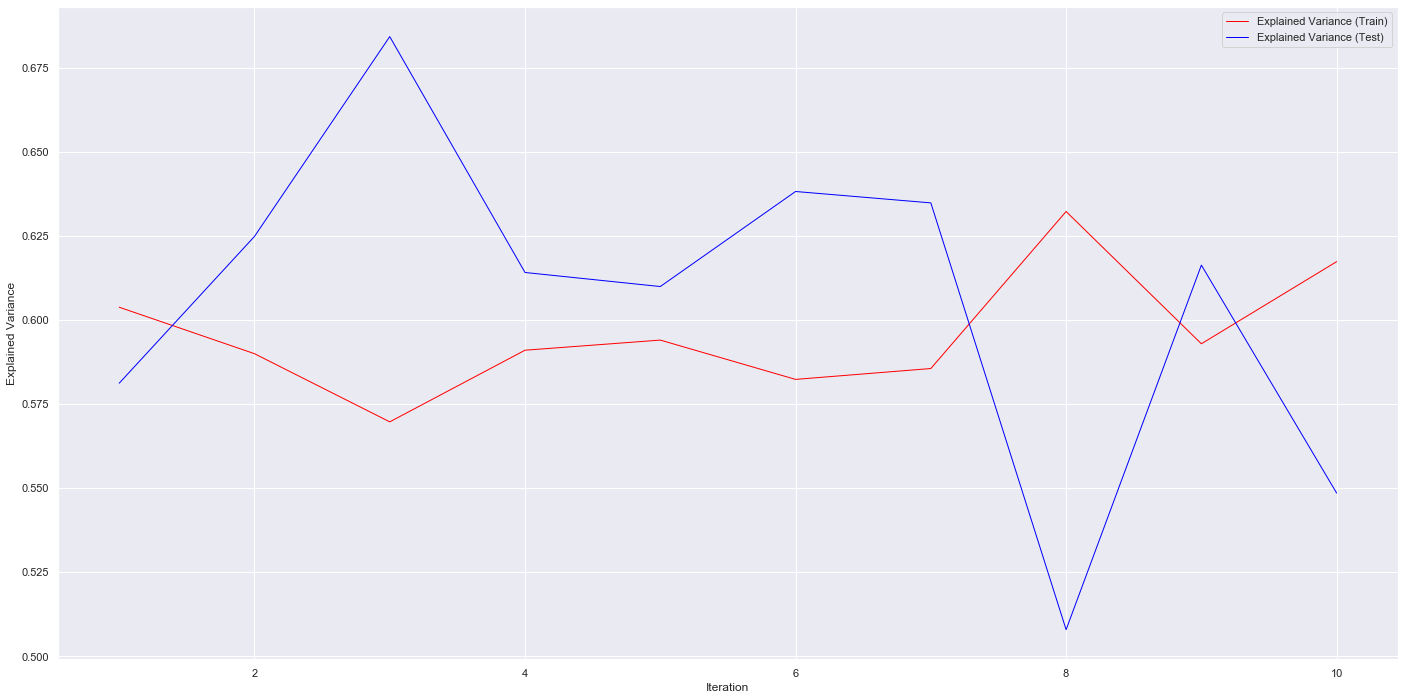

In [41]:
# Check accuracy of model based on values of explained variance for test and train over 10 iterations
f, axes = plt.subplots(1, 1, figsize=(24, 12))
axes.plot(np.array(np.arange(1,num_iterations+1)), R2_list, 'w-', linewidth = 1, color = "red",label = "Explained Variance (Train)")
axes.set_xlabel("Iteration")
axes.set_ylabel("Explained Variance")
axes.plot(np.array(np.arange(1,num_iterations+1)), R2_list_test, 'w-', linewidth = 1,color = "blue",label = 'Explained Variance (Test)')
axes.legend(loc="upper left")
axes.legend()
plt.show()

In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score as r2
from sklearn.metrics import mean_squared_error
forest = RandomForestRegressor(n_estimators=500, 
                               criterion='mse', 
                               random_state=3, 
                               n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2(y_train, y_train_pred),
        r2(y_test, y_test_pred)))

/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


MSE train: 734.282, test: 4596.081
R^2 train: 0.898, test: 0.485


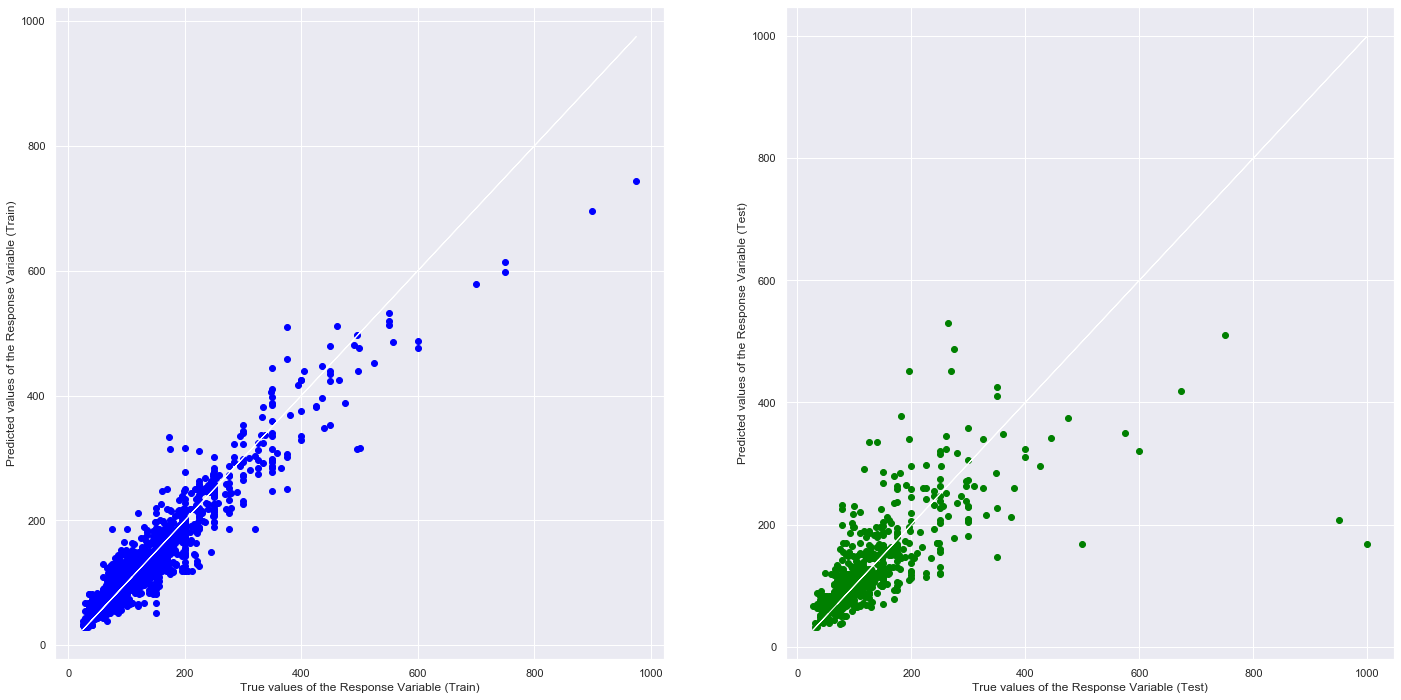

/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [43]:
# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

# Check value of explained variance for test and train over 10 iterations
R2_list = []
R2_list_test = []
num_iterations = 10

for i in range(0,num_iterations):
    # Split the Dataset into Train and Test
    predictors_train, predictors_test, response_train, response_test = train_test_split(X, y, test_size = 0.25)
    # train the linear regression model
    forest.fit(predictors_train, response_train)   
    # Predict Response corresponding to Predictors
    response_pred = forest.predict(predictors_train)
    response_pred_test = forest.predict(predictors_test)
                           
    R2_list.append(forest.score(predictors_train, response_train))
    R2_list_test.append(forest.score(predictors_test, response_test))

In [44]:
clf = svm.SVC(kernel='linear', C=1)
#source: https://scikit-learn.org/stable/modules/cross_validation.html
#Determine performance of model using cross_val_score
scores = cross_val_score(forest, X, y, cv=5)
print("Explained Variance :%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#The random forest regression model has moderate performance in predicting prices

/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3

Explained Variance :0.56 (+/- 0.16)


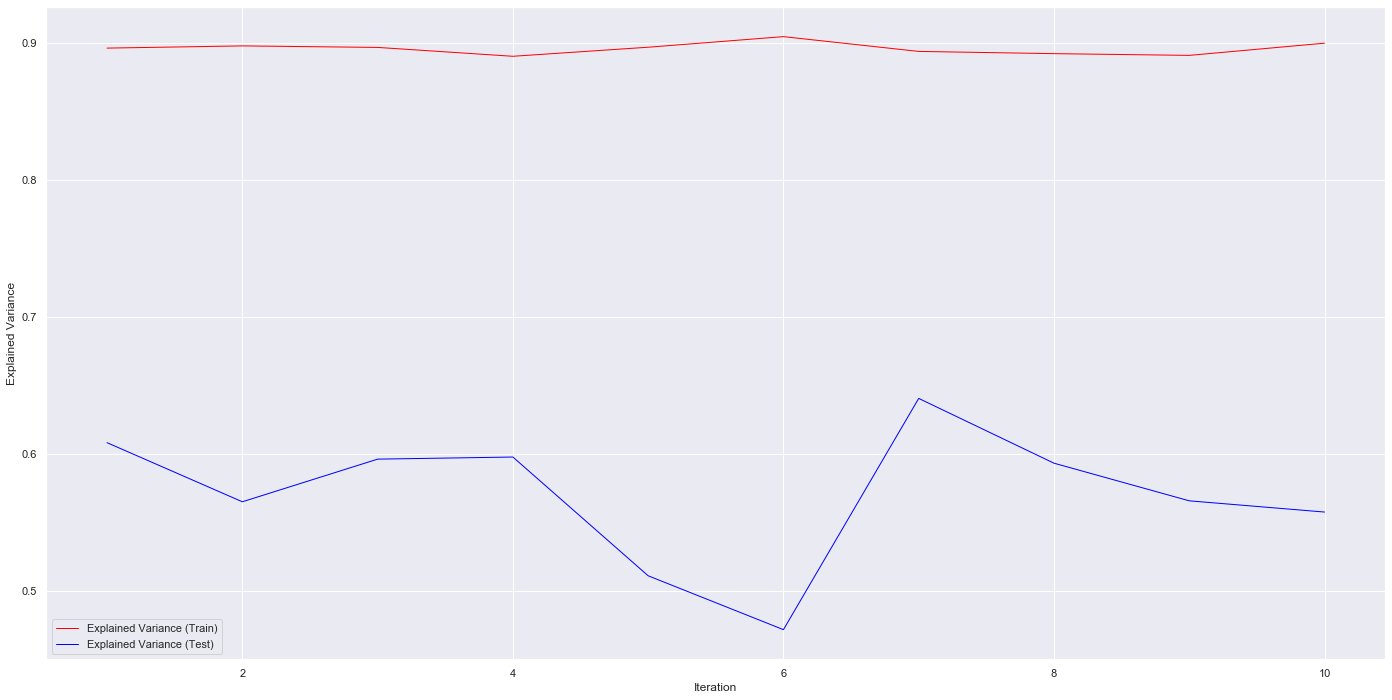

In [45]:
# Check accuracy of model based on values of explained variance for test and train over 10 iterations
f, axes = plt.subplots(1, 1, figsize=(24, 12))
axes.plot(np.array(np.arange(1,num_iterations+1)), R2_list, 'w-', linewidth = 1, color = "red",label = "Explained Variance (Train)")
axes.set_xlabel("Iteration")
axes.set_ylabel("Explained Variance")
axes.plot(np.array(np.arange(1,num_iterations+1)), R2_list_test, 'w-', linewidth = 1,color = "blue",label = 'Explained Variance (Test)')
axes.legend(loc="upper left")
axes.legend()
plt.show()

Both linear regression and random forest regression seem to be a reasonably good predictor of price, except for anomalous data points (listings with prices out of the normal range), as cross validation score for explained variance is moderately high (above 0.5) and the explained variance score for test set is generally above 0.5.<br>
These models can be used to predict price of a listing. If the actual price is lower or equal to the predicted price, the price is reasonable.

# Predicting if price is reasonable using clusters identified

In [46]:
#Separate data into respective clusters and check correlation between price and numeric variables
cluster0=cleanup_df_copy[cleanup_df_copy.Cluster=='small-cheap listing']
cluster1=cleanup_df_copy[cleanup_df_copy.Cluster=='small-low-quality listing']
cluster2=cleanup_df_copy[cleanup_df_copy.Cluster=='small-high-quality listing']
cluster3=cleanup_df_copy[cleanup_df_copy.Cluster=='medium listing']
cluster4=cleanup_df_copy[cleanup_df_copy.Cluster=='large listing']

In [47]:
for key in clust_centroid_dict['Cluster']:
    print(clust_centroid_dict['Cluster'][key])

small-low-quality listing
medium listing
small-cheap listing
large listing
small-high-quality listing


small-low-quality listing
medium listing
small-cheap listing
large listing
small-high-quality listing


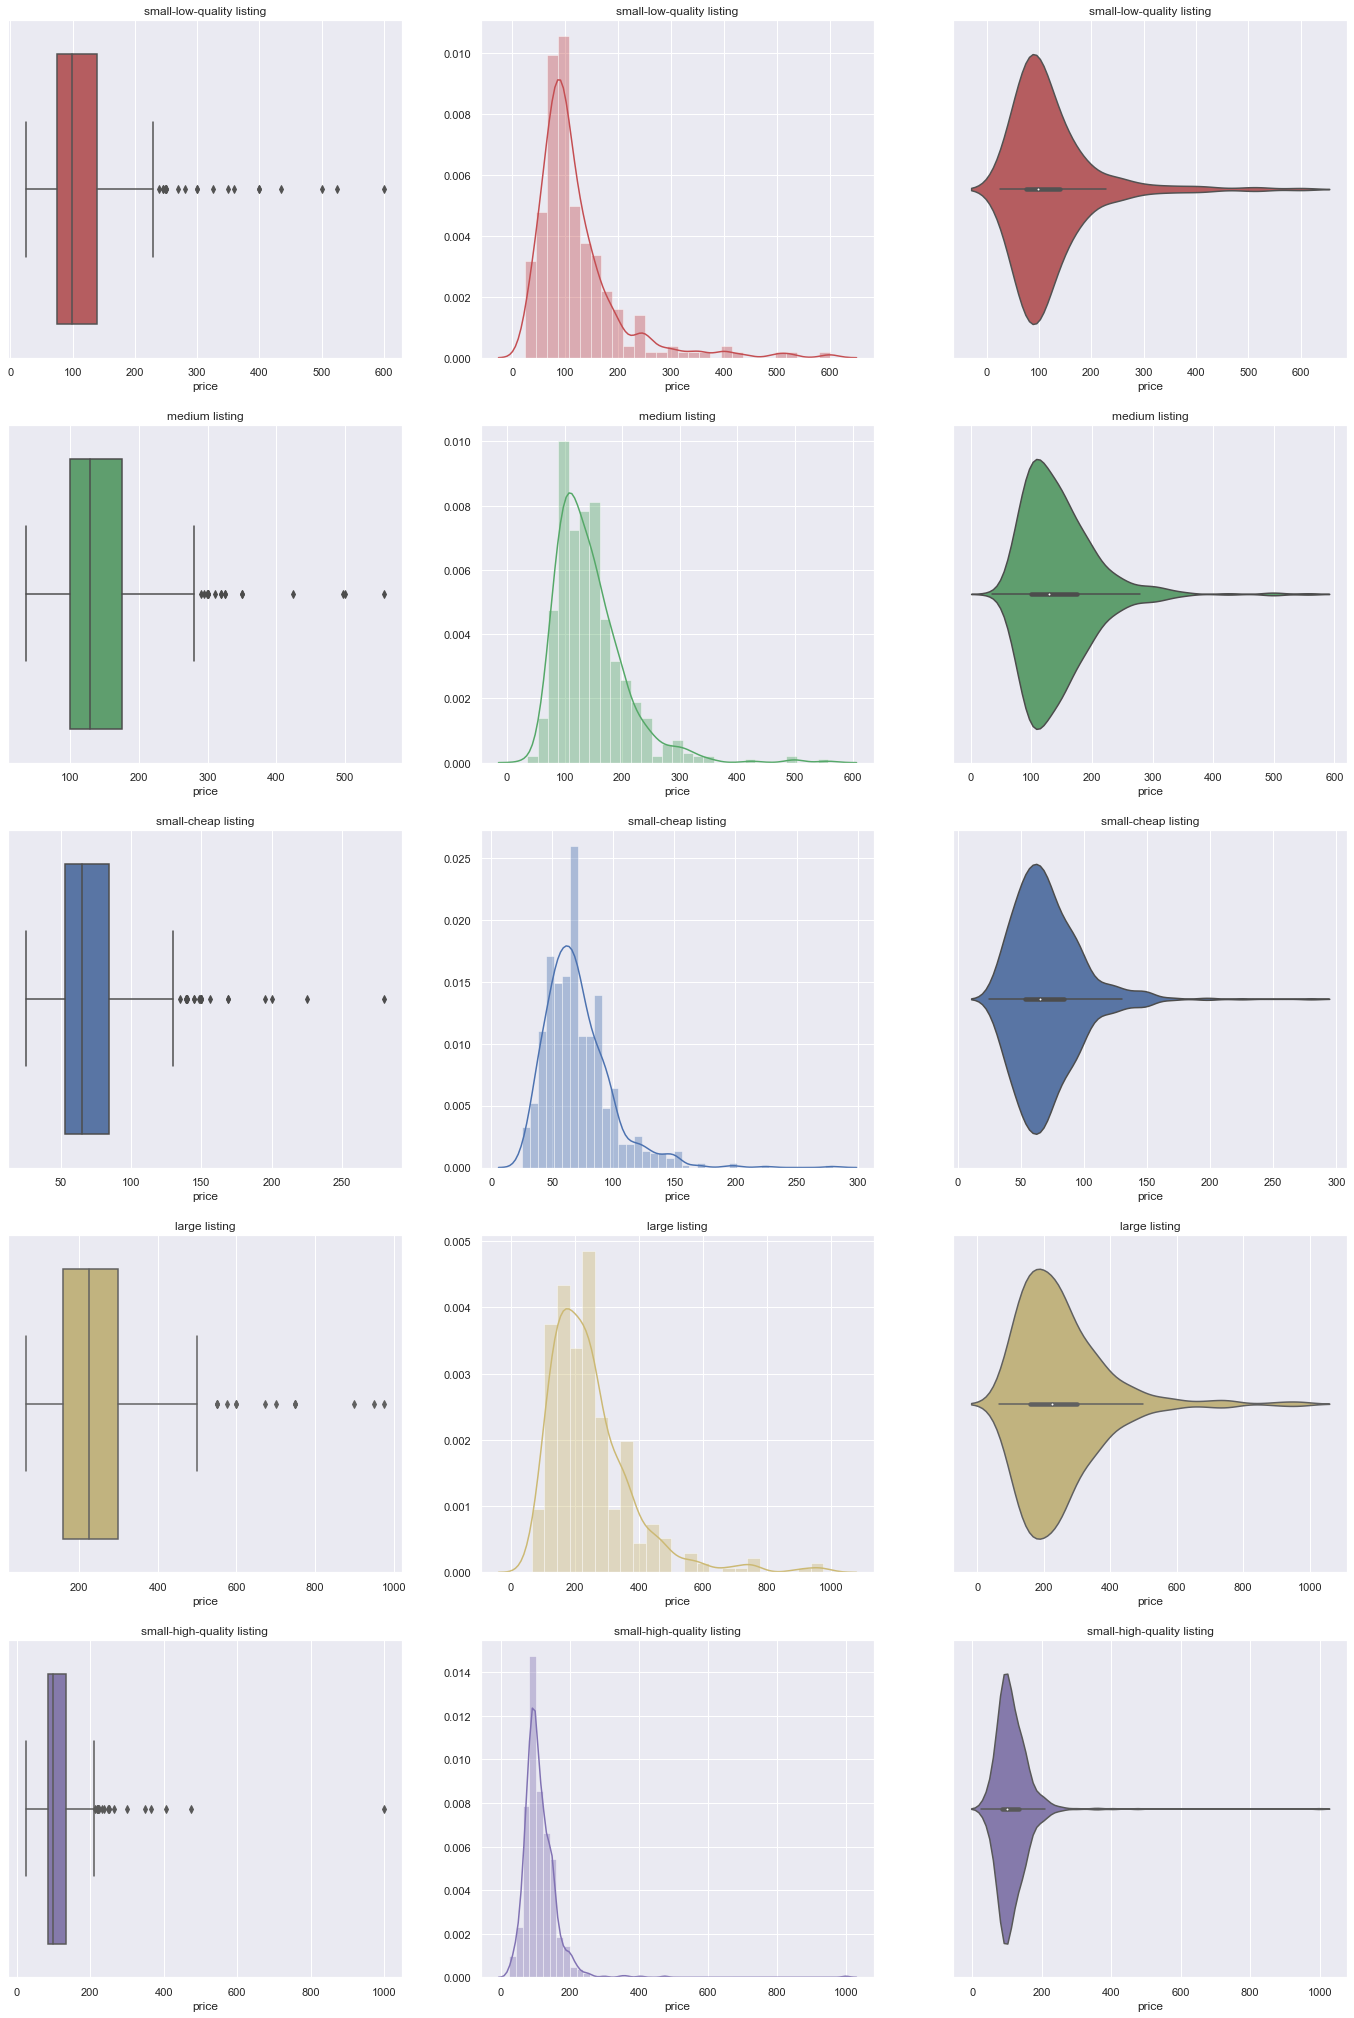

In [48]:
f, axes = plt.subplots(5, 3, figsize=(24, 36))

#initialise variables
colors = ['r','g','b','y','m','c']
count=0
var='price'

#plot distributions of price for each cluster
for key in clust_centroid_dict['Cluster']:
    print(clust_centroid_dict['Cluster'][key])
    clusterdata = cleanup_df_copy[cleanup_df_copy.Cluster==(clust_centroid_dict['Cluster'][key])]
    sb.boxplot(clusterdata[var], orient = "h", color = colors[count], ax = axes[count,0])
    sb.distplot(clusterdata[var], kde = True, color = colors[count], ax = axes[count,1])
    sb.violinplot(clusterdata[var], color = colors[count], ax = axes[count,2])
    axes[count,0].set_title(clust_centroid_dict['Cluster'][key])
    axes[count,1].set_title(clust_centroid_dict['Cluster'][key])
    axes[count,2].set_title(clust_centroid_dict['Cluster'][key])
    count+=1


As the distributions are similar to normal distributions except for slight degree of skewness, the interquartile range for price may be used as the first estimate to determine a reasonable price. Firstly, the cluster of a listing is determined based on the number of beds, bedrooms, how many it accomodates, accuracy score, ratings score and room type. Then, if listing price is within the interquartile range, the price is reasonable as 75% of the listings in the same cluster have prices within that range. Subsequently, regression can be used to determine if price is reasonable for any listing.

In [49]:
#'small-cheap listing'
Q1 = cluster0['price'].quantile(0.25)
Q3 = cluster0['price'].quantile(0.75)
print("A reasonable price for small-sized listings (private rooms) is between $"+str(Q1),"and $"+str(Q3))
cluster0.describe()


A reasonable price for small-sized listings (private rooms) is between $53.0 and $84.0


price   room_type  property_type    bed_type  \
count  790.000000  790.000000     790.000000  790.000000   
mean    70.630380    2.050633       2.179747    1.951899   
std     27.275436    0.373343       0.724788    0.214116   
min     25.000000    1.000000       1.000000    1.000000   
25%     53.000000    2.000000       2.000000    2.000000   
50%     65.000000    2.000000       2.000000    2.000000   
75%     84.000000    2.000000       2.000000    2.000000   
max    280.000000    3.000000       5.000000    2.000000   

       neighbourhood_group_cleansed  cleaning_fee  guests_included  \
count                    790.000000    790.000000       790.000000   
mean                       1.802532     17.717722         1.246835   
std                        0.568719     20.747197         0.557092   
min                        1.000000      0.000000         0.000000   
25%                        1.000000      0.000000         1.000000   
50%                        2.000000     12.000000         1.000000   
75%                        2.000000     28.750000         2.000000   
max                        3.000000    150.000000         4.000000   

        bathrooms    bedrooms        beds  accommodates  
count  790.000000  790.000000  790.000000    790.000000  
mean     1.088608    0.979747    1.130380      2.112658  
std      0.405597    0.149676    0.405243      0.811025  
min      0.000000    0.000000    1.000000      1.000000  
25%      1.000000    1.000000    1.000000      2.000000  
50%      1.000000    1.000000    1.000000      2.000000  
75%      1.000000    1.000000    1.000000      2.000000  
max      5.000000    2.000000    4.000000      8.000000

For cluster 0, price has a moderately strong correlation with bathrooms, bedrooms, beds, accommodates and cleaning_fee

In [50]:
#'small-low-quality listing'
cluster1.describe()

price   room_type  property_type    bed_type  \
count  245.000000  245.000000     245.000000  245.000000   
mean   121.338776    2.706122       3.273469    1.959184   
std     81.824855    0.561179       1.009540    0.198270   
min     25.000000    1.000000       1.000000    1.000000   
25%     75.000000    3.000000       2.000000    2.000000   
50%     99.000000    3.000000       4.000000    2.000000   
75%    140.000000    3.000000       4.000000    2.000000   
max    600.000000    3.000000       5.000000    2.000000   

       neighbourhood_group_cleansed  cleaning_fee  guests_included  \
count                    245.000000    245.000000       245.000000   
mean                       2.004082     51.706122         1.632653   
std                        0.680513     52.446962         1.328963   
min                        1.000000      0.000000         0.000000   
25%                        2.000000     10.000000         1.000000   
50%                        2.000000     40.000000         1.000000   
75%                        2.000000     75.000000         2.000000   
max                        3.000000    264.000000         9.000000   

        bathrooms    bedrooms        beds  accommodates  
count  245.000000  245.000000  245.000000    245.000000  
mean     1.151020    1.204082    1.710204      3.408163  
std      0.459027    0.881959    1.060514      2.003259  
min      0.000000    0.000000    1.000000      1.000000  
25%      1.000000    1.000000    1.000000      2.000000  
50%      1.000000    1.000000    1.000000      3.000000  
75%      1.000000    1.000000    2.000000      4.000000  
max      3.000000    4.000000    6.000000     12.000000

In [51]:
#'small-high-quality listing'
cluster2.describe()

price   room_type  property_type    bed_type  \
count  776.000000  776.000000     776.000000  776.000000   
mean   113.488402    2.847938       3.752577    1.960052   
std     54.069082    0.434120       0.709834    0.195964   
min     25.000000    1.000000       1.000000    1.000000   
25%     85.000000    3.000000       4.000000    2.000000   
50%    100.000000    3.000000       4.000000    2.000000   
75%    135.000000    3.000000       4.000000    2.000000   
max    999.000000    3.000000       5.000000    2.000000   

       neighbourhood_group_cleansed  cleaning_fee  guests_included  \
count                    776.000000    776.000000       776.000000   
mean                       2.234536     37.579897         1.470361   
std                        0.617293     33.554982         0.686570   
min                        1.000000      0.000000         0.000000   
25%                        2.000000     10.000000         1.000000   
50%                        2.000000     35.000000         1.000000   
75%                        3.000000     60.000000         2.000000   
max                        3.000000    274.000000         5.000000   

        bathrooms    bedrooms        beds  accommodates  
count  776.000000  776.000000  776.000000    776.000000  
mean     1.009021    0.807990    1.177835      2.576031  
std      0.118794    0.446333    0.562780      0.978158  
min      0.000000    0.000000    1.000000      1.000000  
25%      1.000000    1.000000    1.000000      2.000000  
50%      1.000000    1.000000    1.000000      2.000000  
75%      1.000000    1.000000    1.000000      3.000000  
max      3.000000    4.000000    7.000000      9.000000

The 'small-low-quality listing' and 'small-high-quality listing' both generally have 1 bedroom and 1 bed, except that 'small-low-quality listing' have lower review_scores_accuracy, lower review_scores_rating and higher prices.<br>
Thus, the interquartile range of 'small-high-quality' listing may be used to determine if price is reasonable as the price is more objectively based on quality of the listing.

In [52]:
Q1 = cluster2['price'].quantile(0.25)
Q3 = cluster2['price'].quantile(0.75)
print("A reasonable price for small-sized listings (entire home/apt) is between $"+str(Q1),"and $"+str(Q3))

A reasonable price for small-sized listings (entire home/apt) is between $85.0 and $135.0


In [53]:
#medium listing
Q1 = cluster3['price'].quantile(0.25)
Q3 = cluster3['price'].quantile(0.75)
print("A reasonable price for medium-sized listings is between $"+str(Q1),"and $"+str(Q3))
cluster3.describe()

A reasonable price for medium-sized listings is between $100.0 and $175.0


price   room_type  property_type    bed_type  \
count  561.000000  561.000000     561.000000  561.000000   
mean   143.959002    2.992870       3.326203    1.991087   
std     61.148853    0.103264       1.032771    0.094069   
min     35.000000    1.000000       1.000000    1.000000   
25%    100.000000    3.000000       2.000000    2.000000   
50%    129.000000    3.000000       4.000000    2.000000   
75%    175.000000    3.000000       4.000000    2.000000   
max    557.000000    3.000000       5.000000    2.000000   

       neighbourhood_group_cleansed  cleaning_fee  guests_included  \
count                    561.000000    561.000000       561.000000   
mean                       2.210339     64.030303         2.026738   
std                        0.631297     43.132282         1.251142   
min                        1.000000      0.000000         0.000000   
25%                        2.000000     35.000000         1.000000   
50%                        2.000000     60.000000         2.000000   
75%                        3.000000     95.000000         2.000000   
max                        3.000000    300.000000         7.000000   

        bathrooms    bedrooms        beds  accommodates  
count  561.000000  561.000000  561.000000    561.000000  
mean     1.153298    1.529412    2.278075      4.360071  
std      0.375158    0.657056    0.700281      1.022310  
min      1.000000    0.000000    1.000000      2.000000  
25%      1.000000    1.000000    2.000000      4.000000  
50%      1.000000    2.000000    2.000000      4.000000  
75%      1.000000    2.000000    2.000000      5.000000  
max      3.000000    3.000000    8.000000     12.000000

In [54]:
#large listing
Q1 = cluster4['price'].quantile(0.25)
Q3 = cluster4['price'].quantile(0.75)
print("A reasonable price for large-sized listings is between $"+str(Q1),"and $"+str(Q3))
cluster4.describe()

A reasonable price for large-sized listings is between $158.25 and $300.0


price  room_type  property_type    bed_type  \
count  344.000000      344.0     344.000000  344.000000   
mean   249.159884        3.0       2.345930    1.994186   
std    134.729296        0.0       0.853452    0.076138   
min     65.000000        3.0       1.000000    1.000000   
25%    158.250000        3.0       2.000000    2.000000   
50%    225.000000        3.0       2.000000    2.000000   
75%    300.000000        3.0       2.000000    2.000000   
max    975.000000        3.0       5.000000    2.000000   

       neighbourhood_group_cleansed  cleaning_fee  guests_included  \
count                    344.000000    344.000000       344.000000   
mean                       2.130814    110.994186         3.061047   
std                        0.632256     67.589741         2.429002   
min                        1.000000      0.000000         0.000000   
25%                        2.000000     75.000000         1.000000   
50%                        2.000000    100.000000         2.000000   
75%                        3.000000    150.000000         4.000000   
max                        3.000000    300.000000        13.000000   

        bathrooms    bedrooms        beds  accommodates  
count  344.000000  344.000000  344.000000    344.000000  
mean     1.941860    2.863372    3.706395      6.944767  
std      0.709858    0.954624    1.419713      2.082798  
min      0.000000    0.000000    1.000000      3.000000  
25%      1.000000    2.000000    3.000000      6.000000  
50%      2.000000    3.000000    3.000000      6.000000  
75%      2.000000    3.000000    4.000000      8.000000  
max      4.000000    7.000000   15.000000     16.000000

# predicting price of listings within each cluster using regression

In [55]:
#'small-cheap listing'
cluster0.corr()

price  room_type  property_type  bed_type  \
price                         1.000000   0.418172       0.051193  0.038186   
room_type                     0.418172   1.000000      -0.033676 -0.001204   
property_type                 0.051193  -0.033676       1.000000 -0.034053   
bed_type                      0.038186  -0.001204      -0.034053  1.000000   
neighbourhood_group_cleansed  0.247515  -0.072235       0.193836 -0.057285   
cleaning_fee                  0.357822   0.253997      -0.022497  0.046013   
guests_included               0.313633   0.189679      -0.072355  0.025286   
bathrooms                    -0.037821  -0.121734      -0.041313  0.049140   
bedrooms                     -0.042506  -0.344522       0.033600  0.009111   
beds                          0.200216   0.107101      -0.062630  0.028548   
accommodates                  0.342848   0.353676      -0.043117  0.045843   

                              neighbourhood_group_cleansed  cleaning_fee  \
price                                             0.247515      0.357822   
room_type                                        -0.072235      0.253997   
property_type                                     0.193836     -0.022497   
bed_type                                         -0.057285      0.046013   
neighbourhood_group_cleansed                      1.000000      0.084532   
cleaning_fee                                      0.084532      1.000000   
guests_included                                   0.034028      0.202542   
bathrooms                                         0.031993     -0.044769   
bedrooms                                          0.057182     -0.111225   
beds                                             -0.025631      0.200957   
accommodates                                     -0.006664      0.233738   

                              guests_included  bathrooms  bedrooms      beds  \
price                                0.313633  -0.037821 -0.042506  0.200216   
room_type                            0.189679  -0.121734 -0.344522  0.107101   
property_type                       -0.072355  -0.041313  0.033600 -0.062630   
bed_type                             0.025286   0.049140  0.009111  0.028548   
neighbourhood_group_cleansed         0.034028   0.031993  0.057182 -0.025631   
cleaning_fee                         0.202542  -0.044769 -0.111225  0.200957   
guests_included                      1.000000  -0.074482 -0.000770  0.283939   
bathrooms                           -0.074482   1.000000  0.029598 -0.024109   
bedrooms                            -0.000770   0.029598  1.000000  0.043590   
beds                                 0.283939  -0.024109  0.043590  1.000000   
accommodates                         0.446114  -0.057355 -0.043825  0.560695   

                              accommodates  
price                             0.342848  
room_type                         0.353676  
property_type                    -0.043117  
bed_type                          0.045843  
neighbourhood_group_cleansed     -0.006664  
cleaning_fee                      0.233738  
guests_included                   0.446114  
bathrooms                        -0.057355  
bedrooms                         -0.043825  
beds                              0.560695  
accommodates                      1.000000

/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


MSE train: 272.530, test: 460.009
R^2 train: 0.661, test: 0.183


/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3

Explained Variance :0.19 (+/- 0.14)


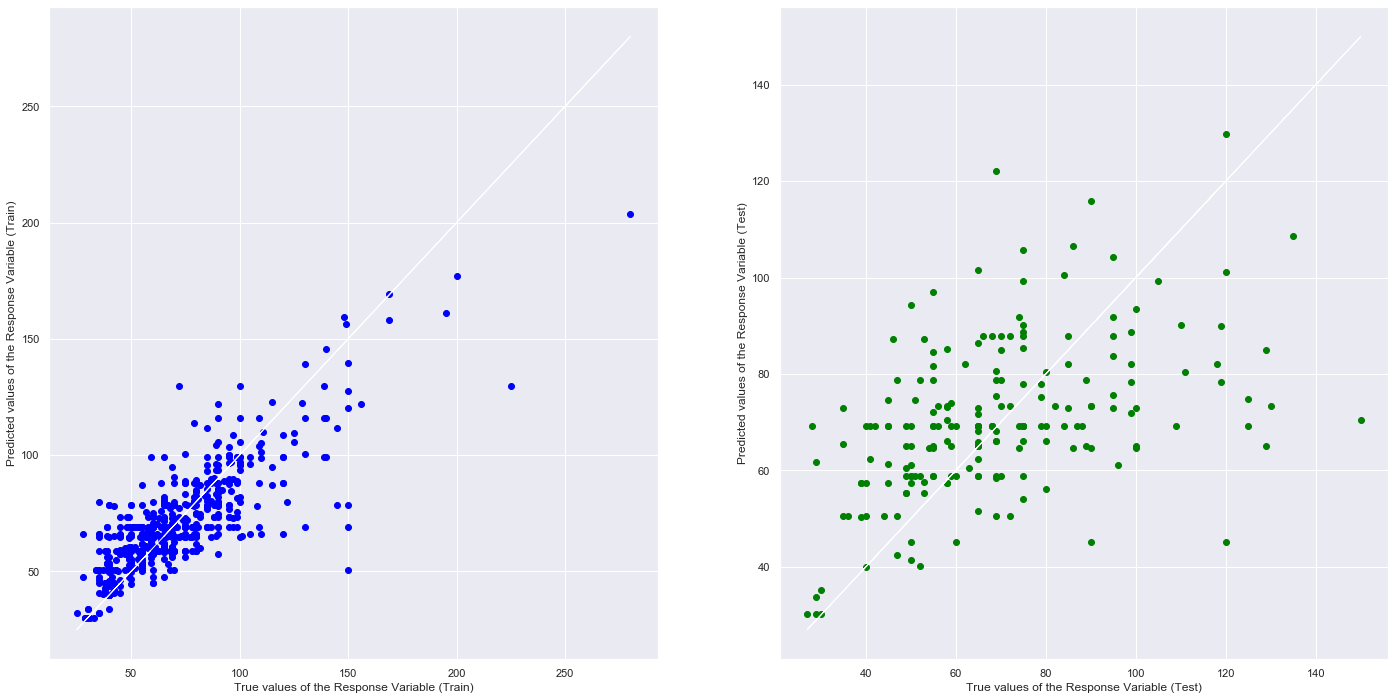

In [56]:
y = pd.DataFrame(cluster0["price"])
X = pd.DataFrame(cluster0[['room_type','neighbourhood_group_cleansed','bathrooms','bedrooms','beds','accommodates','cleaning_fee']])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2(y_train, y_train_pred),
        r2(y_test, y_test_pred)))

clf = svm.SVC(kernel='linear', C=1)
#source: https://scikit-learn.org/stable/modules/cross_validation.html
#Determine performance of model using cross_val_score
scores = cross_val_score(forest, X, y, cv=5)
print("Explained Variance :%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#The random forest regression model has low performance in predicting prices

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

In [57]:
#'small-low-quality listing'
cluster1.corr()


price  room_type  property_type  bed_type  \
price                         1.000000   0.390429      -0.140541  0.176932   
room_type                     0.390429   1.000000       0.229248  0.444267   
property_type                -0.140541   0.229248       1.000000 -0.066858   
bed_type                      0.176932   0.444267      -0.066858  1.000000   
neighbourhood_group_cleansed  0.133857  -0.018310       0.189266 -0.059510   
cleaning_fee                  0.509784   0.339604      -0.167218  0.168315   
guests_included               0.498000   0.173384      -0.331096  0.067295   
bathrooms                     0.572689   0.188907      -0.248679  0.022975   
bedrooms                      0.604199   0.121674      -0.463397  0.047831   
beds                          0.548614   0.255725      -0.308473  0.138427   
accommodates                  0.630672   0.398787      -0.254017  0.155620   

                              neighbourhood_group_cleansed  cleaning_fee  \
price                                             0.133857      0.509784   
room_type                                        -0.018310      0.339604   
property_type                                     0.189266     -0.167218   
bed_type                                         -0.059510      0.168315   
neighbourhood_group_cleansed                      1.000000     -0.085170   
cleaning_fee                                     -0.085170      1.000000   
guests_included                                   0.001665      0.448735   
bathrooms                                        -0.001981      0.455530   
bedrooms                                         -0.042365      0.506242   
beds                                             -0.038106      0.546672   
accommodates                                     -0.043316      0.599645   

                              guests_included  bathrooms  bedrooms      beds  \
price                                0.498000   0.572689  0.604199  0.548614   
room_type                            0.173384   0.188907  0.121674  0.255725   
property_type                       -0.331096  -0.248679 -0.463397 -0.308473   
bed_type                             0.067295   0.022975  0.047831  0.138427   
neighbourhood_group_cleansed         0.001665  -0.001981 -0.042365 -0.038106   
cleaning_fee                         0.448735   0.455530  0.506242  0.546672   
guests_included                      1.000000   0.514566  0.613193  0.529002   
bathrooms                            0.514566   1.000000  0.611945  0.536473   
bedrooms                             0.613193   0.611945  1.000000  0.703222   
beds                                 0.529002   0.536473  0.703222  1.000000   
accommodates                         0.633837   0.556660  0.732066  0.814044   

                              accommodates  
price                             0.630672  
room_type                         0.398787  
property_type                    -0.254017  
bed_type                          0.155620  
neighbourhood_group_cleansed     -0.043316  
cleaning_fee                      0.599645  
guests_included                   0.633837  
bathrooms                         0.556660  
bedrooms                          0.732066  
beds                              0.814044  
accommodates                      1.000000

/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


MSE train: 736.192, test: 3862.046
R^2 train: 0.888, test: 0.459


/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3

Explained Variance :0.34 (+/- 0.35)


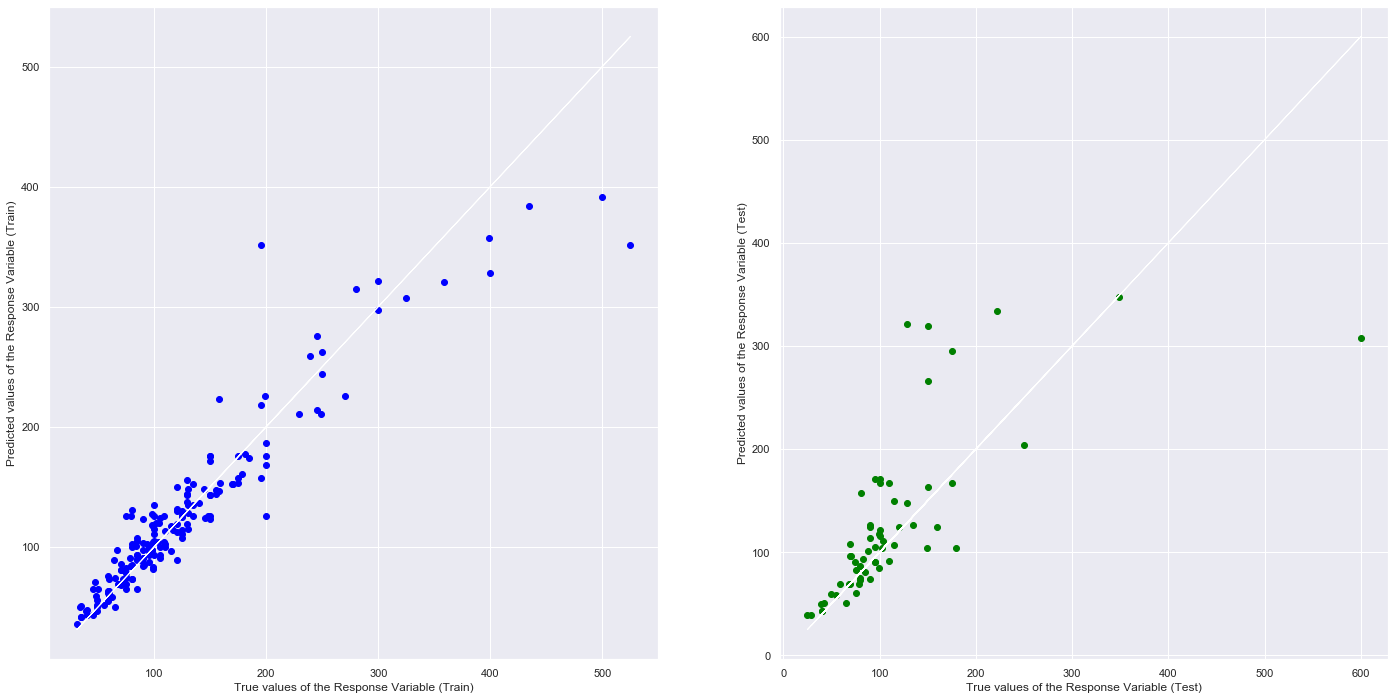

In [58]:
y = pd.DataFrame(cluster1["price"])
X = pd.DataFrame(cluster1[['room_type','neighbourhood_group_cleansed','bathrooms','bedrooms','beds','accommodates','cleaning_fee']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2(y_train, y_train_pred),
        r2(y_test, y_test_pred)))

clf = svm.SVC(kernel='linear', C=1)
#source: https://scikit-learn.org/stable/modules/cross_validation.html
#Determine performance of model using cross_val_score
scores = cross_val_score(forest, X, y, cv=5)
print("Explained Variance :%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#The random forest regression model has low performance in predicting prices

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

In [59]:
#'small-high-quality listing'
cluster2.corr()

price  room_type  property_type  bed_type  \
price                         1.000000   0.298421       0.021610  0.125693   
room_type                     0.298421   1.000000      -0.130626  0.247018   
property_type                 0.021610  -0.130626       1.000000  0.021612   
bed_type                      0.125693   0.247018       0.021612  1.000000   
neighbourhood_group_cleansed  0.303908   0.046586       0.220948  0.045553   
cleaning_fee                  0.392785   0.255057      -0.037036  0.121658   
guests_included               0.105345   0.184000      -0.073315  0.063116   
bathrooms                     0.213058  -0.023408      -0.004102  0.015500   
bedrooms                      0.185092  -0.150881       0.016837  0.089218   
beds                          0.190294   0.021044      -0.012454  0.052800   
accommodates                  0.328477   0.200464      -0.030481  0.133667   

                              neighbourhood_group_cleansed  cleaning_fee  \
price                                             0.303908      0.392785   
room_type                                         0.046586      0.255057   
property_type                                     0.220948     -0.037036   
bed_type                                          0.045553      0.121658   
neighbourhood_group_cleansed                      1.000000      0.138821   
cleaning_fee                                      0.138821      1.000000   
guests_included                                   0.007290      0.135392   
bathrooms                                         0.006304      0.237578   
bedrooms                                         -0.028353      0.187681   
beds                                              0.002355      0.272151   
accommodates                                      0.124291      0.344882   

                              guests_included  bathrooms  bedrooms      beds  \
price                                0.105345   0.213058  0.185092  0.190294   
room_type                            0.184000  -0.023408 -0.150881  0.021044   
property_type                       -0.073315  -0.004102  0.016837 -0.012454   
bed_type                             0.063116   0.015500  0.089218  0.052800   
neighbourhood_group_cleansed         0.007290   0.006304 -0.028353  0.002355   
cleaning_fee                         0.135392   0.237578  0.187681  0.272151   
guests_included                      1.000000  -0.020448  0.177202  0.170613   
bathrooms                           -0.020448   1.000000  0.178723  0.226878   
bedrooms                             0.177202   0.178723  1.000000  0.238852   
beds                                 0.170613   0.226878  0.238852  1.000000   
accommodates                         0.306932   0.188417  0.289132  0.552022   

                              accommodates  
price                             0.328477  
room_type                         0.200464  
property_type                    -0.030481  
bed_type                          0.133667  
neighbourhood_group_cleansed      0.124291  
cleaning_fee                      0.344882  
guests_included                   0.306932  
bathrooms                         0.188417  
bedrooms                          0.289132  
beds                              0.552022  
accommodates                      1.000000

/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


MSE train: 772.532, test: 2901.880
R^2 train: 0.756, test: -0.313


/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3

Explained Variance :0.12 (+/- 0.24)


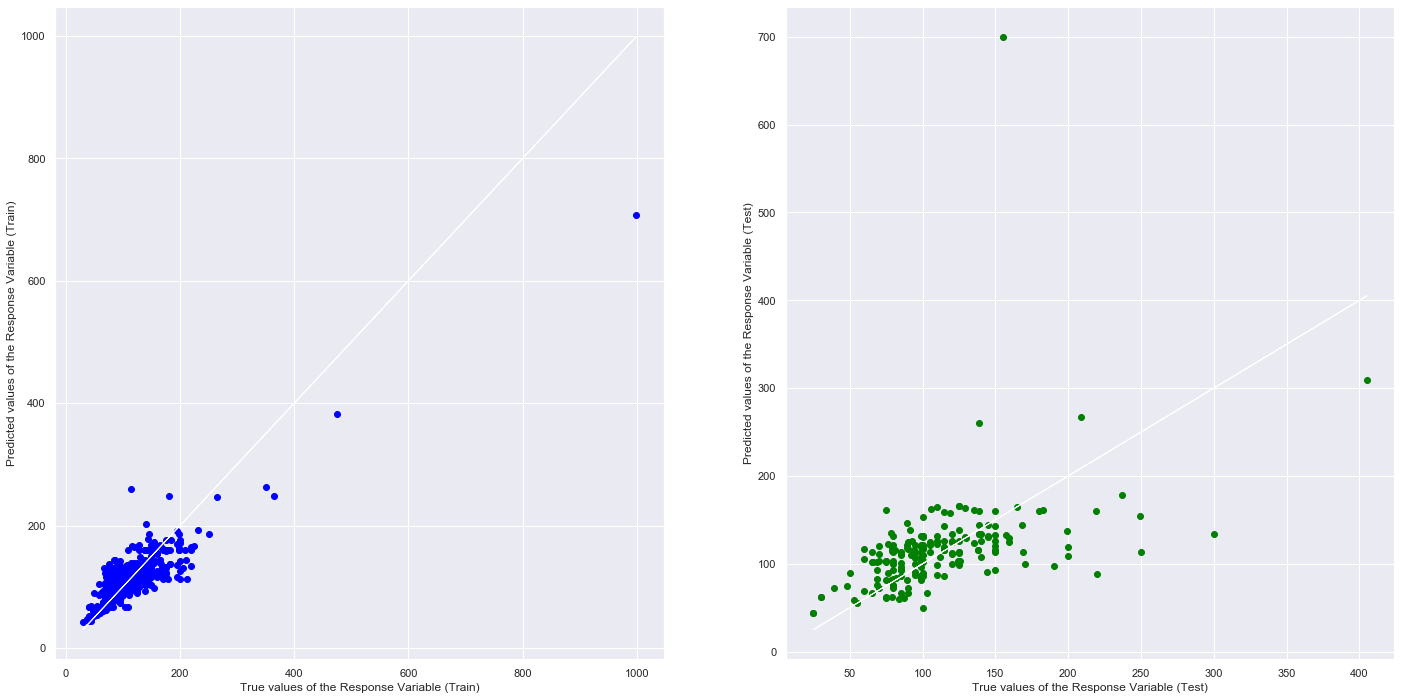

In [60]:
y = pd.DataFrame(cluster2["price"])
X = pd.DataFrame(cluster2[['room_type','neighbourhood_group_cleansed','bathrooms','bedrooms','beds','accommodates','cleaning_fee']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2(y_train, y_train_pred),
        r2(y_test, y_test_pred)))

clf = svm.SVC(kernel='linear', C=1)
#source: https://scikit-learn.org/stable/modules/cross_validation.html
#Determine performance of model using cross_val_score
scores = cross_val_score(forest, X, y, cv=5)
print("Explained Variance :%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#The random forest regression model has low performance in predicting prices

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

In [61]:
#medium listing
cluster3.corr()


price  room_type  property_type  bed_type  \
price                         1.000000   0.086207       0.015057  0.060472   
room_type                     0.086207   1.000000      -0.045128 -0.006554   
property_type                 0.015057  -0.045128       1.000000 -0.061924   
bed_type                      0.060472  -0.006554      -0.061924  1.000000   
neighbourhood_group_cleansed  0.312283  -0.031738       0.310886 -0.088655   
cleaning_fee                  0.382071   0.048961      -0.017740  0.068284   
guests_included               0.116019   0.042943      -0.143578  0.032374   
bathrooms                     0.423419   0.028265      -0.041726  0.038784   
bedrooms                      0.343122   0.055733      -0.231264  0.163149   
beds                          0.172952   0.027467       0.024968  0.064798   
accommodates                  0.262382   0.041278       0.012020  0.070568   

                              neighbourhood_group_cleansed  cleaning_fee  \
price                                             0.312283      0.382071   
room_type                                        -0.031738      0.048961   
property_type                                     0.310886     -0.017740   
bed_type                                         -0.088655      0.068284   
neighbourhood_group_cleansed                      1.000000      0.173095   
cleaning_fee                                      0.173095      1.000000   
guests_included                                  -0.081741      0.049952   
bathrooms                                         0.089806      0.179151   
bedrooms                                         -0.122567      0.236853   
beds                                              0.016913      0.221658   
accommodates                                      0.001416      0.272502   

                              guests_included  bathrooms  bedrooms      beds  \
price                                0.116019   0.423419  0.343122  0.172952   
room_type                            0.042943   0.028265  0.055733  0.027467   
property_type                       -0.143578  -0.041726 -0.231264  0.024968   
bed_type                             0.032374   0.038784  0.163149  0.064798   
neighbourhood_group_cleansed        -0.081741   0.089806 -0.122567  0.016913   
cleaning_fee                         0.049952   0.179151  0.236853  0.221658   
guests_included                      1.000000   0.052123  0.152183  0.105634   
bathrooms                            0.052123   1.000000  0.314913 -0.013013   
bedrooms                             0.152183   0.314913  1.000000  0.269383   
beds                                 0.105634  -0.013013  0.269383  1.000000   
accommodates                         0.294022   0.135182  0.367021  0.575768   

                              accommodates  
price                             0.262382  
room_type                         0.041278  
property_type                     0.012020  
bed_type                          0.070568  
neighbourhood_group_cleansed      0.001416  
cleaning_fee                      0.272502  
guests_included                   0.294022  
bathrooms                         0.135182  
bedrooms                          0.367021  
beds                              0.575768  
accommodates                      1.000000

/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


MSE train: 744.635, test: 2392.382
R^2 train: 0.805, test: 0.317


/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3

Explained Variance :0.20 (+/- 0.50)


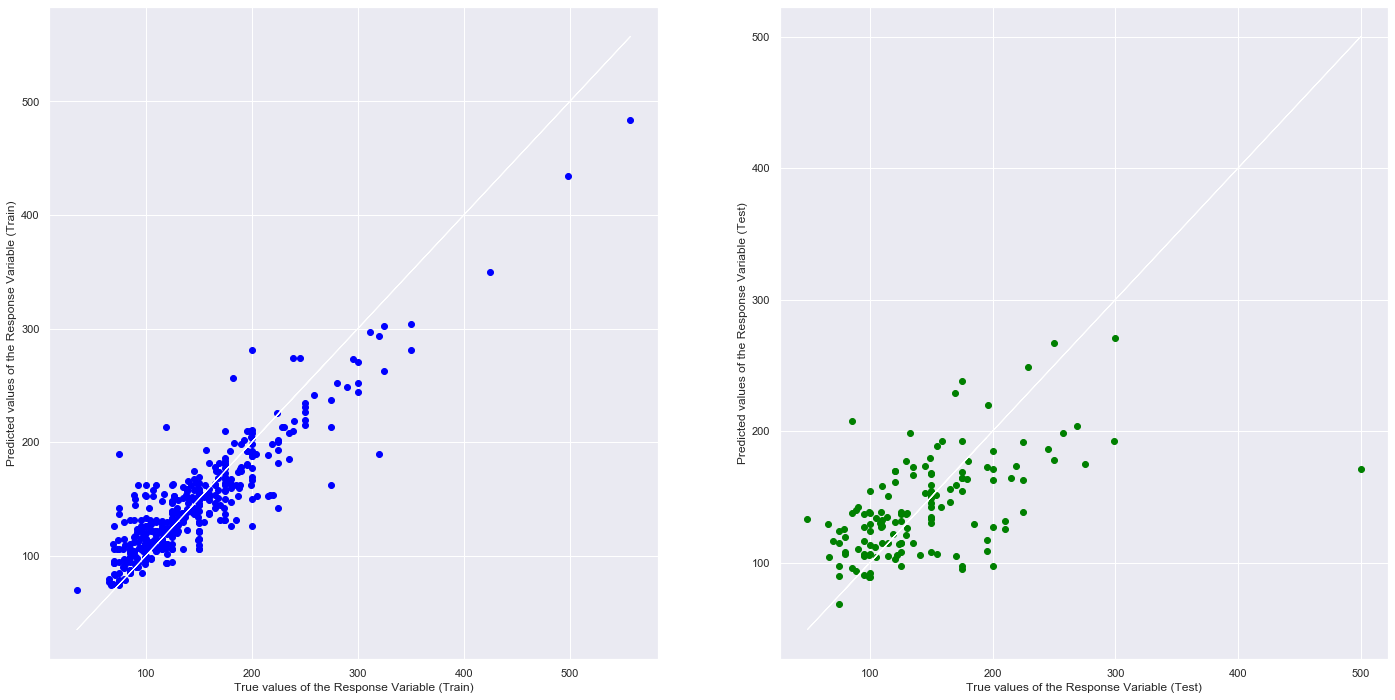

In [62]:
y = pd.DataFrame(cluster3["price"])
X = pd.DataFrame(cluster3[['room_type','neighbourhood_group_cleansed','bathrooms','bedrooms','beds','accommodates','cleaning_fee']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2(y_train, y_train_pred),
        r2(y_test, y_test_pred)))

clf = svm.SVC(kernel='linear', C=1)
#source: https://scikit-learn.org/stable/modules/cross_validation.html
#Determine performance of model using cross_val_score
scores = cross_val_score(forest, X, y, cv=5)
print("Explained Variance :%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#The random forest regression model has low performance in predicting prices

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

In [63]:
#large listing
cluster4.corr()

price  room_type  property_type  bed_type  \
price                         1.000000        NaN      -0.067090  0.060912   
room_type                          NaN        NaN            NaN       NaN   
property_type                -0.067090        NaN       1.000000 -0.148426   
bed_type                      0.060912        NaN      -0.148426  1.000000   
neighbourhood_group_cleansed  0.165953        NaN       0.434579 -0.105282   
cleaning_fee                  0.405173        NaN      -0.031250  0.013590   
guests_included               0.259428        NaN      -0.287271  0.064982   
bathrooms                     0.479703        NaN      -0.024453 -0.006272   
bedrooms                      0.496348        NaN      -0.342605  0.069263   
beds                          0.376191        NaN      -0.183016  0.038105   
accommodates                  0.429826        NaN      -0.145033  0.034739   

                              neighbourhood_group_cleansed  cleaning_fee  \
price                                             0.165953      0.405173   
room_type                                              NaN           NaN   
property_type                                     0.434579     -0.031250   
bed_type                                         -0.105282      0.013590   
neighbourhood_group_cleansed                      1.000000      0.101329   
cleaning_fee                                      0.101329      1.000000   
guests_included                                  -0.132407      0.133153   
bathrooms                                         0.159906      0.436407   
bedrooms                                         -0.149025      0.466973   
beds                                             -0.051278      0.454080   
accommodates                                     -0.069771      0.458370   

                              guests_included  bathrooms  bedrooms      beds  \
price                                0.259428   0.479703  0.496348  0.376191   
room_type                                 NaN        NaN       NaN       NaN   
property_type                       -0.287271  -0.024453 -0.342605 -0.183016   
bed_type                             0.064982  -0.006272  0.069263  0.038105   
neighbourhood_group_cleansed        -0.132407   0.159906 -0.149025 -0.051278   
cleaning_fee                         0.133153   0.436407  0.466973  0.454080   
guests_included                      1.000000   0.155932  0.304107  0.325630   
bathrooms                            0.155932   1.000000  0.530335  0.379340   
bedrooms                             0.304107   0.530335  1.000000  0.675896   
beds                                 0.325630   0.379340  0.675896  1.000000   
accommodates                         0.354502   0.478968  0.667764  0.787209   

                              accommodates  
price                             0.429826  
room_type                              NaN  
property_type                    -0.145033  
bed_type                          0.034739  
neighbourhood_group_cleansed     -0.069771  
cleaning_fee                      0.458370  
guests_included                   0.354502  
bathrooms                         0.478968  
bedrooms                          0.667764  
beds                              0.787209  
accommodates                      1.000000

/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


MSE train: 2428.823, test: 6025.720
R^2 train: 0.880, test: 0.477


/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3

Explained Variance :0.11 (+/- 0.48)


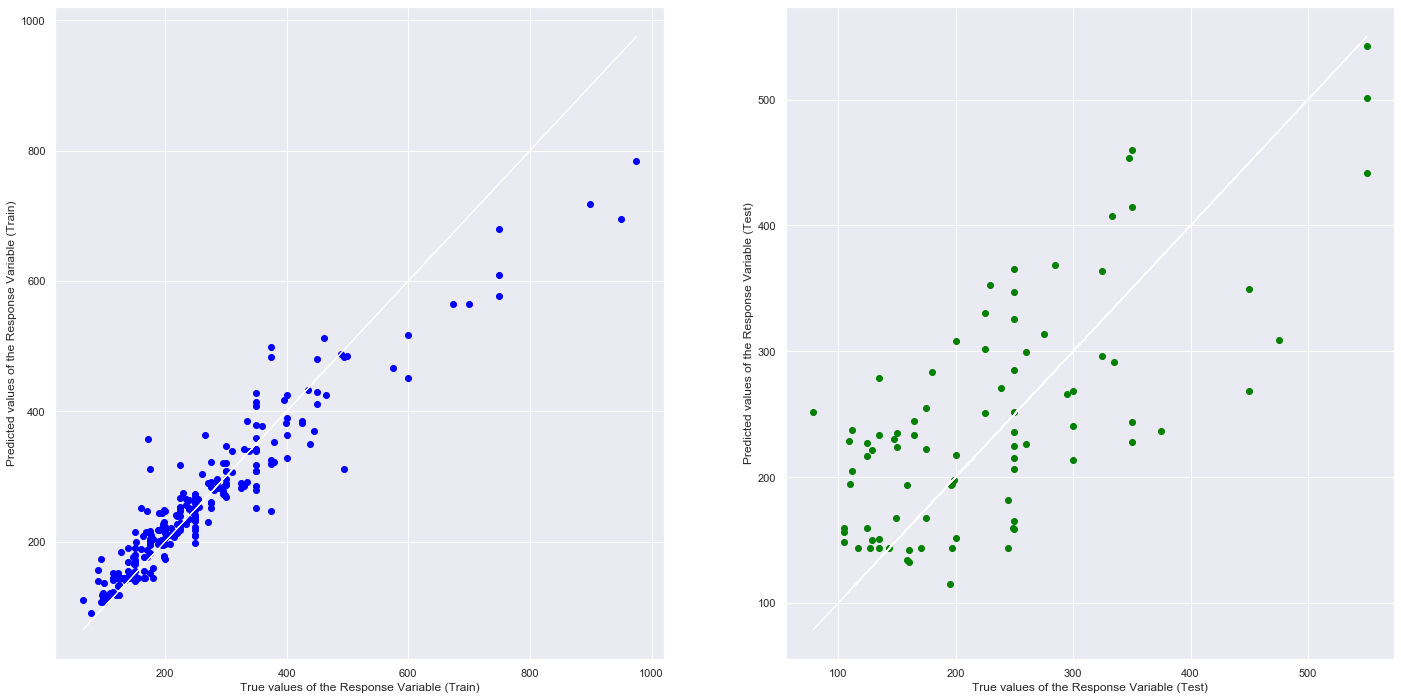

In [64]:
y = pd.DataFrame(cluster4["price"])
X = pd.DataFrame(cluster4[['room_type','neighbourhood_group_cleansed','bathrooms','bedrooms','beds','accommodates','cleaning_fee']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2(y_train, y_train_pred),
        r2(y_test, y_test_pred)))

clf = svm.SVC(kernel='linear', C=1)
#source: https://scikit-learn.org/stable/modules/cross_validation.html
#Determine performance of model using cross_val_score
scores = cross_val_score(forest, X, y, cv=5)
print("Explained Variance :%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#The random forest regression model has low performance in predicting prices

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

The clusters are useful are general prediction of price. However, regression models on the clusters tend not to be as accurate as the regression model based on the whole dataset.

# Is there anytime in the year when there are less available listings and higher prices?

# The calendar dataset contains the availability of airbnbs and their prices for the year 2016-17. Using it, I have created a timeseries graph for Average Non-occupancy rate per month (Airbnb Available) and for Average Price of airbnbs Per Month and found a relation between the two. I have also used ARIMA to perform timeseries forecasting

In [65]:
calendardata=pd.read_csv('calendar.csv')
calendardata.head()

listing_id        date available   price
0      241032  2016-01-04         t  $85.00
1      241032  2016-01-05         t  $85.00
2      241032  2016-01-06         f     NaN
3      241032  2016-01-07         f     NaN
4      241032  2016-01-08         f     NaN

In [66]:
#converting price to numeric data
calendardata['price']=calendardata['price'].str.replace('$','').apply(pd.to_numeric,errors='coerce')

In [67]:
#separating available airbnbs from non-available ones.
calendar_available=pd.DataFrame(calendardata[calendardata['available']=='t'])
calendar_available['price'].fillna(0,inplace=True)
c=calendar_available
calendar_available.head()

listing_id        date available  price
0       241032  2016-01-04         t   85.0
1       241032  2016-01-05         t   85.0
9       241032  2016-01-13         t   85.0
10      241032  2016-01-14         t   85.0
14      241032  2016-01-18         t   85.0

In [68]:
#converting date column to datetime format
calendar_available['date']=pd.to_datetime(calendar_available['date'])
calendar_available['month']=pd.DataFrame(calendar_available['date'].dt.month)
calendar_available=calendar_available.reset_index()

In [69]:
#finding all unique airbnbs
list_id_unique=pd.DataFrame(calendar_available['listing_id'].unique())
list_id_unique

0
0       241032
1       953595
2      3308979
3      7421966
4       278830
...        ...
3718   8101950
3719   8902327
3720  10267360
3721   9604740
3722  10208623

[3723 rows x 1 columns]

In [70]:
#changing column name
list_id_unique=list_id_unique.rename(columns={0:"list_id"})
list_id_unique

list_id
0       241032
1       953595
2      3308979
3      7421966
4       278830
...        ...
3718   8101950
3719   8902327
3720  10267360
3721   9604740
3722  10208623

[3723 rows x 1 columns]

In [71]:
#finding frequency of availability of each airbnb
freq_listid=[]
m=[1,2,3,4,5,6,7,8,9,10,11,12]
c=0
for i in range(list_id_unique.shape[0]):
    freq_listid.append((calendar_available['listing_id']==list_id_unique['list_id'][i]).sum())

list_id_unique['Available Bookings']=pd.DataFrame(freq_listid)
list_id_unique

list_id  Available Bookings
0       241032                 346
1       953595                 291
2      3308979                 220
3      7421966                 143
4       278830                 365
...        ...                 ...
3718   8101950                  32
3719   8902327                 273
3720  10267360                  88
3721   9604740                 179
3722  10208623                   7

[3723 rows x 2 columns]

In [72]:
#finding average available booking per month
import math
avg_booking=[]
for i in range(list_id_unique.shape[0]):
    k=(list_id_unique['Available Bookings'][i])/12
    avg_booking.append(math.ceil(k))

list_id_unique['Average Booking']=pd.DataFrame(avg_booking)
list_id_unique

list_id  Available Bookings  Average Booking
0       241032                 346               29
1       953595                 291               25
2      3308979                 220               19
3      7421966                 143               12
4       278830                 365               31
...        ...                 ...              ...
3718   8101950                  32                3
3719   8902327                 273               23
3720  10267360                  88                8
3721   9604740                 179               15
3722  10208623                   7                1

[3723 rows x 3 columns]

In [73]:
#example of analysis of first listing
df1=pd.DataFrame(calendar_available[0:346])
df1

index  listing_id       date available  price  month
0        0      241032 2016-01-04         t   85.0      1
1        1      241032 2016-01-05         t   85.0      1
2        9      241032 2016-01-13         t   85.0      1
3       10      241032 2016-01-14         t   85.0      1
4       14      241032 2016-01-18         t   85.0      1
..     ...         ...        ...       ...    ...    ...
341    360      241032 2016-12-29         t   85.0     12
342    361      241032 2016-12-30         t   85.0     12
343    362      241032 2016-12-31         t   85.0     12
344    363      241032 2017-01-01         t   85.0      1
345    364      241032 2017-01-02         t   85.0      1

[346 rows x 6 columns]

In [74]:
#finding frequency per month and average price per month of first listing
freq_month=[0,0,0,0,0,0,0,0,0,0,0,0]
avg_price=[0,0,0,0,0,0,0,0,0,0,0,0]
for i in range(346):
    if(df1['month'][i]==1):
        freq_month[0]+=1
        avg_price[0]+=df1['price'][i]
    elif(df1['month'][i]==2):
        freq_month[1]+=1
        avg_price[1]+=df1['price'][i]
    elif(df1['month'][i]==3):
        freq_month[2]+=1
        avg_price[2]+=df1['price'][i]
    elif(df1['month'][i]==4):
        freq_month[3]+=1
        avg_price[3]+=df1['price'][i]
    elif(df1['month'][i]==5):
        freq_month[4]+=1
        avg_price[4]+=df1['price'][i]
    elif(df1['month'][i]==6):
        freq_month[5]+=1
        avg_price[5]+=df1['price'][i]
    elif(df1['month'][i]==7):
        freq_month[6]+=1
        avg_price[6]+=df1['price'][i]
    elif(df1['month'][i]==8):
        freq_month[7]+=1
        avg_price[7]+=df1['price'][i]
    elif(df1['month'][i]==9):
        freq_month[8]+=1
        avg_price[8]+=df1['price'][i]
    elif(df1['month'][i]==10):
        freq_month[9]+=1
        avg_price[9]+=df1['price'][i]
    elif(df1['month'][i]==11):
        freq_month[10]+=1
        avg_price[10]+=df1['price'][i]
    else:
        freq_month[11]+=1
        avg_price[11]+=df1['price'][i]

for i in range(12):
    avg_price[i]=avg_price[i]/freq_month[i] 

print(avg_price)
print(freq_month)

[85.0, 85.0, 85.0, 85.0, 85.0, 85.0, 85.0, 85.0, 85.0, 85.0, 85.0, 85.0]
[14, 26, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]


In [75]:
#creating dataframe for first listing
months=["January","February","March","April","May","June","July","August","September","October","November","December"]
df2=pd.DataFrame(months)
df2['Available_Booking']=pd.DataFrame(freq_month)
df2['Average Price']=pd.DataFrame(avg_price)
df2=df2.set_index(df2[0])
df2=df2.drop(columns=[0])
#rename column
df2=df2.rename(columns={0:"Month"})
df2

Available_Booking  Average Price
0                                          
January                   14           85.0
February                  26           85.0
March                     31           85.0
April                     30           85.0
May                       31           85.0
June                      30           85.0
July                      31           85.0
August                    31           85.0
September                 30           85.0
October                   31           85.0
November                  30           85.0
December                  31           85.0

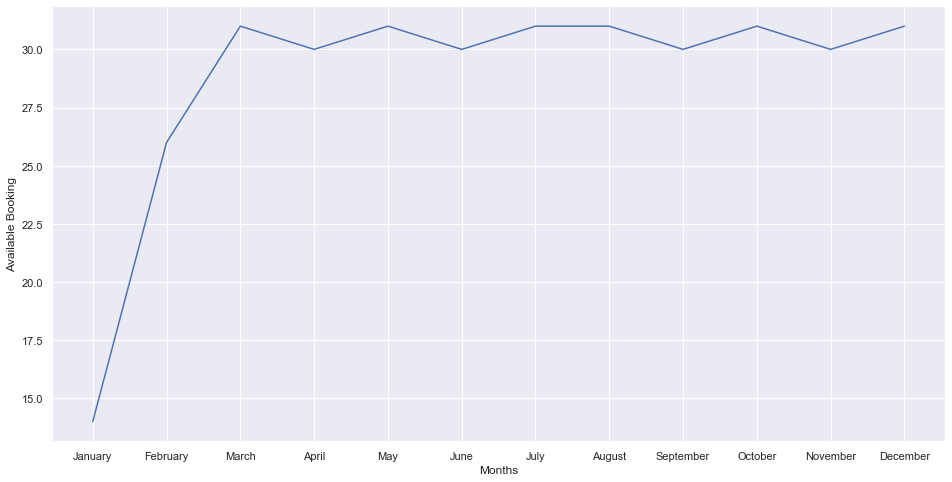

In [76]:
#plotting a graph of available booking of first listing. Similarly, same individual analysis could be carried out for all listings.
f, axes=plt.subplots(1,1,figsize=(16,8))
plt.plot(df2['Available_Booking'])
plt.xlabel('Months')
plt.ylabel('Available Booking')
plt.show()

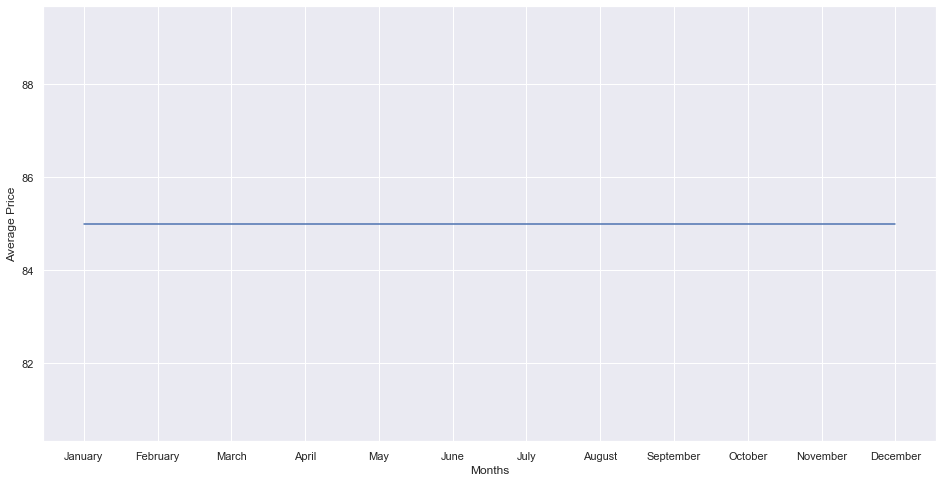

In [77]:
#plotting a graph of average price of first listing. Similarly, same individual analysis could be carried out for all listings.
f, axes=plt.subplots(1,1,figsize=(16,8))
plt.plot(df2["Average Price"])
plt.xlabel('Months')
plt.ylabel('Average Price')
plt.show()

In [78]:
#creating dataframe for second listing
df3=pd.DataFrame(calendar_available[346:637])
df3.head(20)

index  listing_id       date available  price  month
346    365      953595 2016-01-04         t  125.0      1
347    366      953595 2016-01-05         t  125.0      1
348    370      953595 2016-01-09         t  125.0      1
349    371      953595 2016-01-10         t  125.0      1
350    372      953595 2016-01-11         t  125.0      1
351    373      953595 2016-01-12         t  125.0      1
352    374      953595 2016-01-13         t  125.0      1
353    375      953595 2016-01-14         t  125.0      1
354    379      953595 2016-01-18         t  125.0      1
355    387      953595 2016-01-26         t  125.0      1
356    388      953595 2016-01-27         t  125.0      1
357    389      953595 2016-01-28         t  125.0      1
358    390      953595 2016-01-29         t  125.0      1
359    452      953595 2016-03-31         t  154.0      3
360    453      953595 2016-04-01         t  164.0      4
361    454      953595 2016-04-02         t  165.0      4
362    455      953595 2016-04-03         t  150.0      4
363    456      953595 2016-04-04         t  145.0      4
364    457      953595 2016-04-05         t  144.0      4
365    458      953595 2016-04-06         t  148.0      4

In [79]:
#finding availability and average price per month of second listing. Similar, to the first listing. Thus can be done for all individually.
freq_month1=[0,0,0,0,0,0,0,0,0,0,0,0]
avg_price1=[0,0,0,0,0,0,0,0,0,0,0,0]
for i in range(346,637):
    if(df3['month'][i]==1):
        freq_month1[0]+=1
        avg_price1[0]+=df3['price'][i]
    elif(df3['month'][i]==2):
        freq_month1[1]+=1
        avg_price1[1]+=df3['price'][i]
    elif(df3['month'][i]==3):
        freq_month1[2]+=1
        avg_price1[2]+=df3['price'][i]
    elif(df3['month'][i]==4):
        freq_month1[3]+=1
        avg_price1[3]+=df3['price'][i]
    elif(df3['month'][i]==5):
        freq_month1[4]+=1
        avg_price1[4]+=df3['price'][i]
    elif(df3['month'][i]==6):
        freq_month1[5]+=1
        avg_price1[5]+=df3['price'][i]
    elif(df3['month'][i]==7):
        freq_month1[6]+=1
        avg_price1[6]+=df3['price'][i]
    elif(df3['month'][i]==8):
        freq_month1[7]+=1
        avg_price1[7]+=df3['price'][i]
    elif(df3['month'][i]==9):
        freq_month1[8]+=1
        avg_price1[8]+=df3['price'][i]
    elif(df3['month'][i]==10):
        freq_month1[9]+=1
        avg_price1[9]+=df3['price'][i]
    elif(df3['month'][i]==11):
        freq_month1[10]+=1
        avg_price1[10]+=df3['price'][i]
    else:
        freq_month1[11]+=1
        avg_price1[11]+=df3['price'][i]
        
for i in range(12):
    if(freq_month1[i]!=0):
        avg_price1[i]=avg_price1[i]/freq_month1[i]

In [80]:
#creating dataframe for first listing
df4=pd.DataFrame(months)
df4['Available_Booking']=pd.DataFrame(freq_month1)
df4['Average Price']=pd.DataFrame(avg_price1)
df4=df4.set_index(df4[0])
df4=df4.drop(columns=[0])
#rename column
df4=df4.rename(columns={0:"Month"})
df4

Available_Booking  Average Price
0                                          
January                   15     164.266667
February                   0       0.000000
March                      1     154.000000
April                     30     154.566667
May                       31     169.645161
June                      30     193.600000
July                      31     197.193548
August                    31     192.935484
September                 30     170.600000
October                   31     141.645161
November                  30     128.400000
December                  31     192.387097

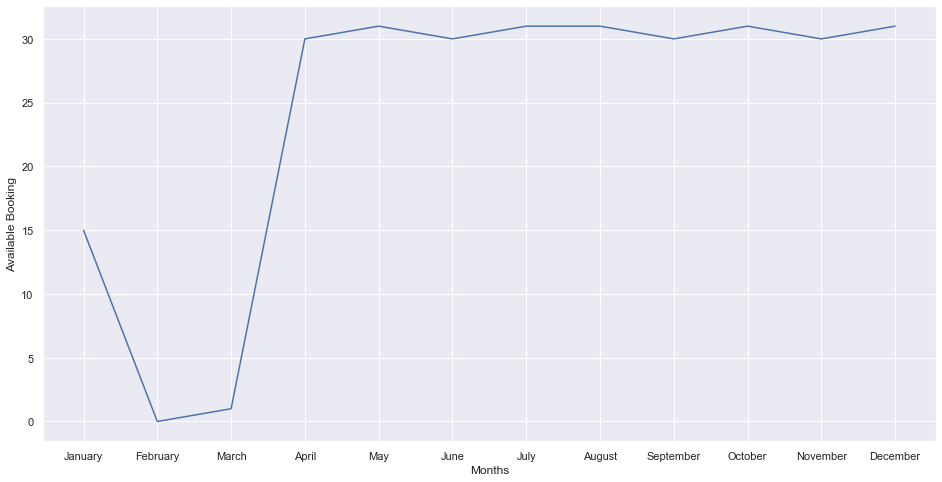

In [81]:
#plotting a graph of available booking of second listing. Similarly, same individual analysis could be carried out for all listings.
f, axes=plt.subplots(1,1,figsize=(16,8))
plt.plot(df4['Available_Booking'])
plt.xlabel('Months')
plt.ylabel('Available Booking')
plt.show()

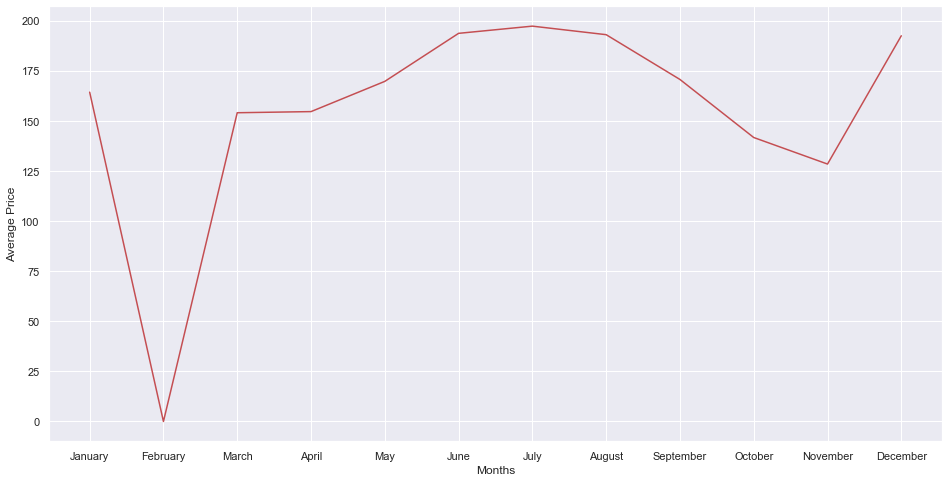

In [82]:
#plotting a graph of average price of second listing. Similarly, same individual analysis could be carried out for all listings.
f, axes=plt.subplots(1,1,figsize=(16,8))
plt.plot(df4['Average Price'],color='r')
plt.xlabel('Months')
plt.ylabel('Average Price')
plt.show()

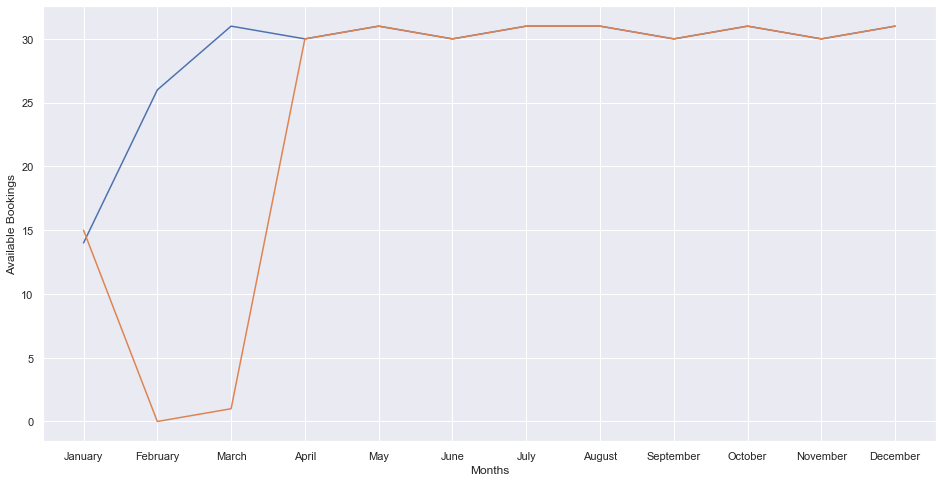

In [83]:
#Comparison between the available bookings of first two listings.
#Hence, we can similarly compare any two or more airbnbs.
f, axes=plt.subplots(1,1,figsize=(16,8))
x1=df2['Available_Booking']
x2=df4['Available_Booking']
x3=df2["Average Price"]
x4=df4["Average Price"]
plt.plot(x1,label="line 1")
plt.plot(x2,label='line 2')
plt.xlabel('Months')
plt.ylabel('Available Bookings')
plt.show()

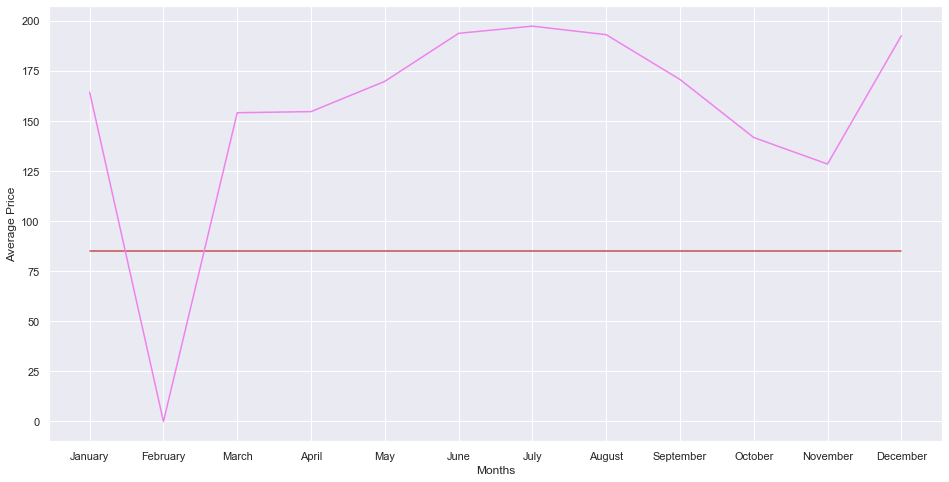

In [84]:
#Comparison between the average price of first two listings.
#Hence, we can similarly compare any two or more airbnbs.
f,axes=plt.subplots(1,1,figsize=(16,8))
x1=df2['Average Price']
x2=df4['Average Price']
plt.plot(x1,label="line 1",color='r')
plt.plot(x2,label='line 2',color='violet')
plt.xlabel('Months')
plt.ylabel('Average Price')
plt.show()

The analysis of number of available bookings and price can be performed for each listing for users to predict availability and price for a specific listing

In [85]:
total_freq_month=list()
average_price=list()
for i in range(12):
    total_freq_month.append((calendar_available['month']==(i+1)).sum())
    temp=pd.DataFrame(calendar_available[calendar_available['month']==(i+1)])
    average_price.append(temp['price'].sum())


In [86]:
import math
non_occupancy=[]
avg_non_occupancy=[]
avg_price_listing=[]
avg_non_occupancy_percent=[]
for i in range(12):
    if(i==0 or i==2 or i==4 or i==6 or i==7 or i==9 or i==11):
        non_occupancy.append(math.ceil(total_freq_month[i]/31))
        avg_non_occupancy.append((total_freq_month[i]/(31*3723)))
    elif(i==1):
        non_occupancy.append(math.ceil(total_freq_month[i]/29))
        avg_non_occupancy.append((total_freq_month[i]/(29*3723)))
    else:
        non_occupancy.append(math.ceil(total_freq_month[i]/30))
        avg_non_occupancy.append((total_freq_month[i]/(30*3723)))
    avg_price_listing.append(average_price[i]/(total_freq_month[i]))
    avg_non_occupancy_percent.append(avg_non_occupancy[i]*100)

In [87]:
avg_price_listing

[122.52718788980089,
 123.89840564094871,
 127.86928447187209,
 134.29776293120455,
 138.72452514036337,
 146.65792812386724,
 151.15844358815446,
 149.56723905326993,
 142.15699194780314,
 136.0378587544579,
 134.71661775495232,
 136.19338165194517]

In [88]:
occupancy_df=pd.DataFrame(months)
occupancy_df['Non-Occupancy Rate Per Month']=pd.DataFrame(non_occupancy)
occupancy_df['Average Non-Occupancy Per Listing']=pd.DataFrame(avg_non_occupancy)
occupancy_df=occupancy_df.set_index(occupancy_df[0])
occupancy_df=occupancy_df.drop(columns=[0])
occupancy_df

Non-Occupancy Rate Per Month  Average Non-Occupancy Per Listing
0                                                                         
January                            2095                           0.562649
February                           2529                           0.679106
March                              2708                           0.727284
April                              2535                           0.680786
May                                2580                           0.692912
June                               2575                           0.691593
July                               2395                           0.643099
August                             2463                           0.661511
September                          2575                           0.691611
October                            2660                           0.714287
November                           2726                           0.732205
December                           2809                           0.754343

In [89]:
occupancy_df["Average Price Per Listing"]=(avg_price_listing)
occupancy_df["Average Non-Occupancy Percentage"]=avg_non_occupancy_percent
occupancy_df

Non-Occupancy Rate Per Month  Average Non-Occupancy Per Listing  \
0                                                                            
January                            2095                           0.562649   
February                           2529                           0.679106   
March                              2708                           0.727284   
April                              2535                           0.680786   
May                                2580                           0.692912   
June                               2575                           0.691593   
July                               2395                           0.643099   
August                             2463                           0.661511   
September                          2575                           0.691611   
October                            2660                           0.714287   
November                           2726                           0.732205   
December                           2809                           0.754343   

           Average Price Per Listing  Average Non-Occupancy Percentage  
0                                                                       
January                   122.527188                         56.264892  
February                  123.898406                         67.910565  
March                     127.869284                         72.728375  
April                     134.297763                         68.078610  
May                       138.724525                         69.291154  
June                      146.657928                         69.159280  
July                      151.158444                         64.309913  
August                    149.567239                         66.151127  
September                 142.156992                         69.161071  
October                   136.037859                         71.428695  
November                  134.716618                         73.220521  
December                  136.193382                         75.434310

# TimeSeries Graph of Non-Occupancy Rate Per Month

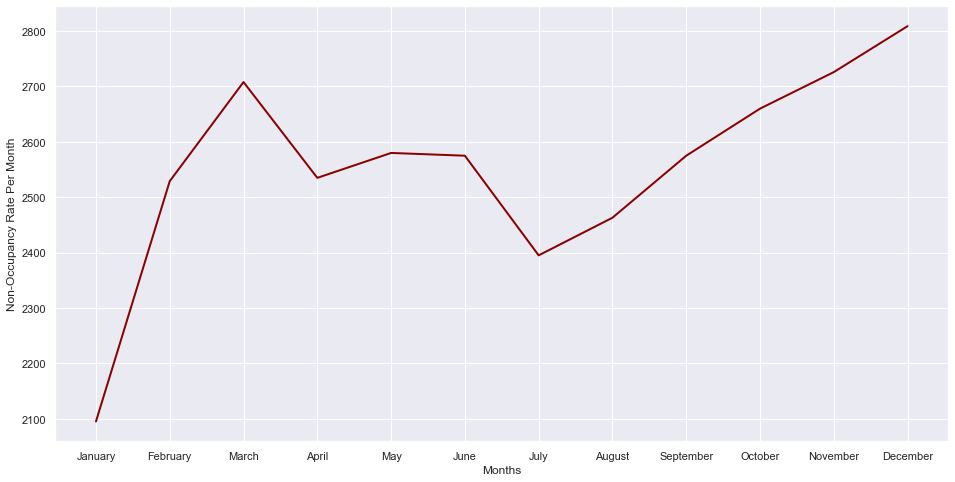

In [90]:
f, axes=plt.subplots(1,1,figsize=(16,8))
plt.plot(occupancy_df["Non-Occupancy Rate Per Month"],color='darkred',linewidth=2)
plt.xlabel('Months')
plt.ylabel('Non-Occupancy Rate Per Month')
plt.show()

# TimeSeries Graph of Average Non-Occupancy Rate Per Month

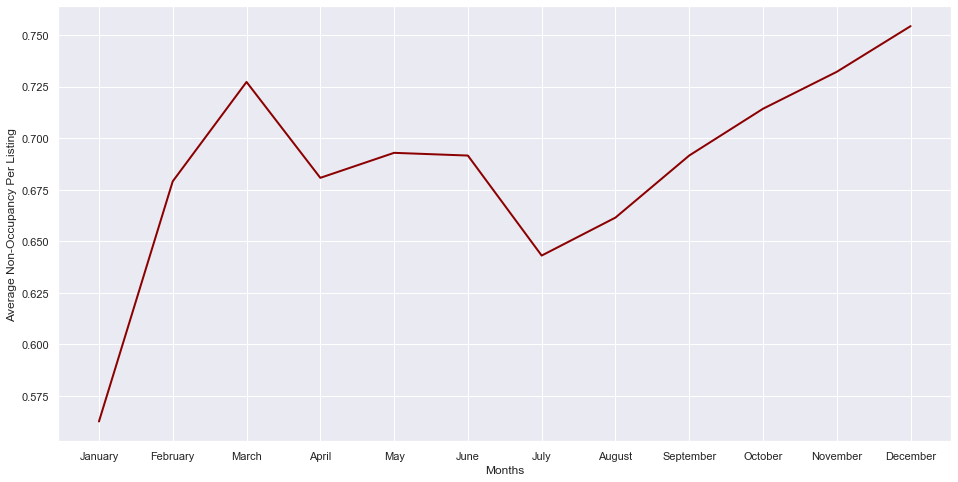

In [91]:
f, axes=plt.subplots(1,1,figsize=(16,8))
plt.plot(occupancy_df["Average Non-Occupancy Per Listing"],color="darkred", linewidth=2)
plt.xlabel('Months')
plt.ylabel('Average Non-Occupancy Per Listing')
plt.show()

# TimeSeries Graph of Average Non-Occupancy Percentage Per Month

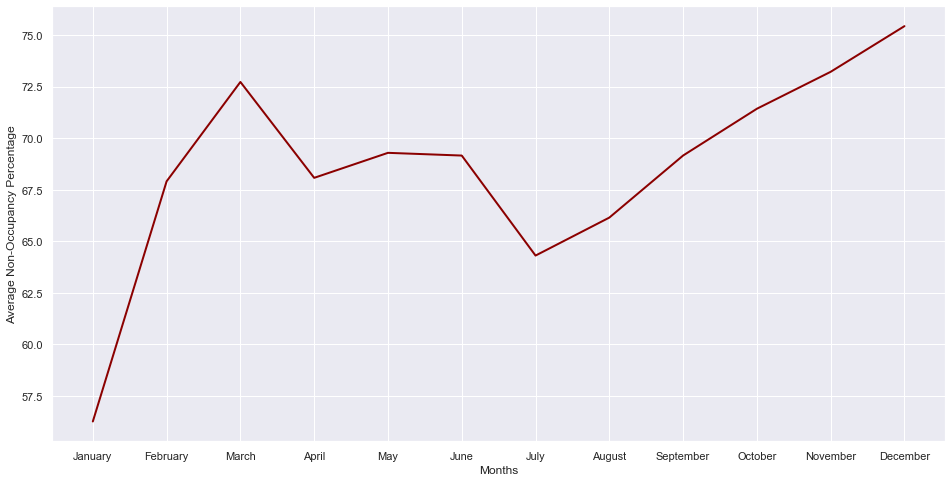

In [92]:
f, axes=plt.subplots(1,1,figsize=(16,8))
plt.plot(occupancy_df["Average Non-Occupancy Percentage"], color="darkred", linewidth=2)
plt.xlabel('Months')
plt.ylabel('Average Non-Occupancy Percentage')
plt.show()

We can infer from these graphs that the availability of airbnbs during January, July and August is relatively lower compared to other months, indicating that these periods are on-season while other months are off-season for tourism in Seattle. Thus, the user now knows when it is peak time and when its an off season for bookings of airbnbs in Seattle. With this knowledge, users can secure their bookings by booking earlier in busy months.

# TimeSeries Graph of Average Price of an airbnb Per Month

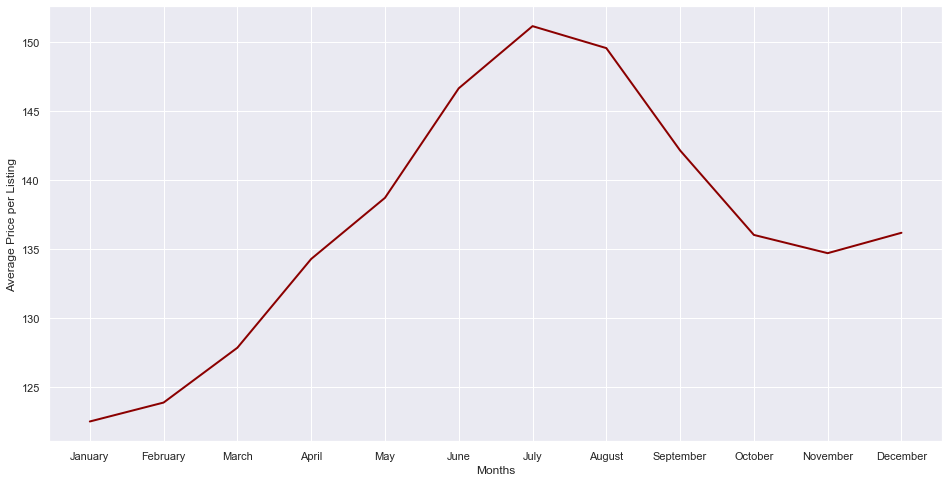

In [93]:
f, axes=plt.subplots(1,1,figsize=(16,8))
plt.plot(occupancy_df["Average Price Per Listing"],color='darkred',linewidth=2)
plt.xlabel('Months')
plt.ylabel('Average Price per Listing')
plt.show()

This graph indicates that the prices are quite low during the months of January-March. It is lowest in the month of January, which happens to be the busiest month, perhaps because of lower average prices of airbnb listings. The prices rise as one moves from April to June and it is the highest in the month of July, which is the favoured time to visit Seattle as well due to Summer break. From August to December, which are the least busiest months, the prices decline indicating an off-season and low tourism. <br>
Thus, if a user wants to pay less for accommodation, he or she may choose the months with lower prices.

# Bar Graph indicating Availability of Airbnbs

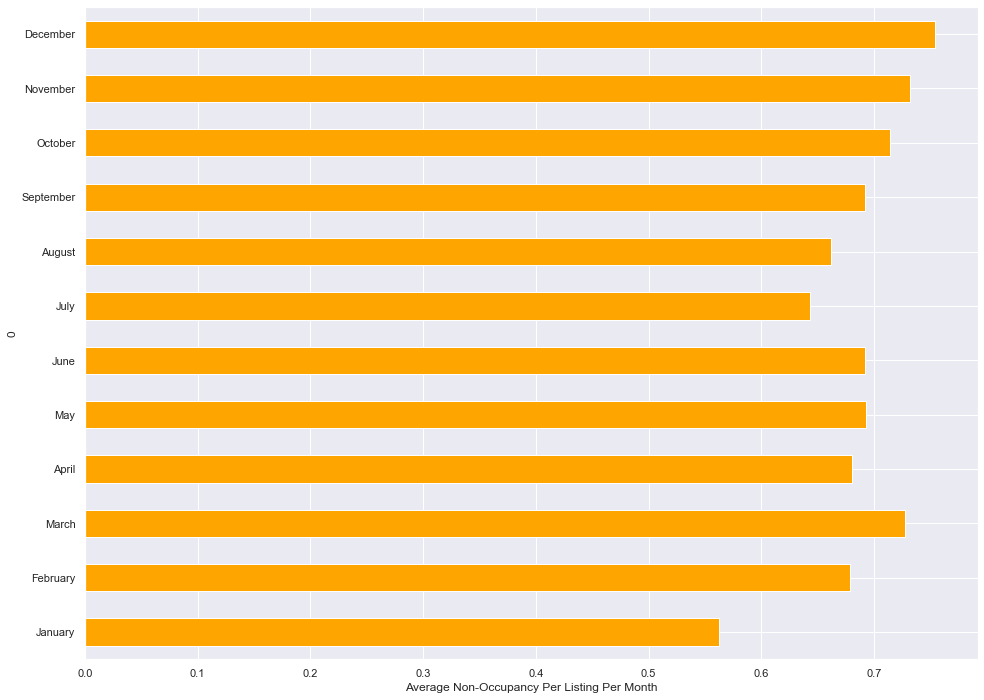

In [94]:
f, axes=plt.subplots(1,1,figsize=(16,12))
plt.xlabel("Average Non-Occupancy Per Listing Per Month")
occupancy_df["Average Non-Occupancy Per Listing"].plot.barh(color="orange")

This indicates January as the busiest month in 2016 for the airbnbs in Seattle as it has the least availability. December is the least busiest month indicating low tourism.

# Bar Graph indicating Average Price of Airbnbs

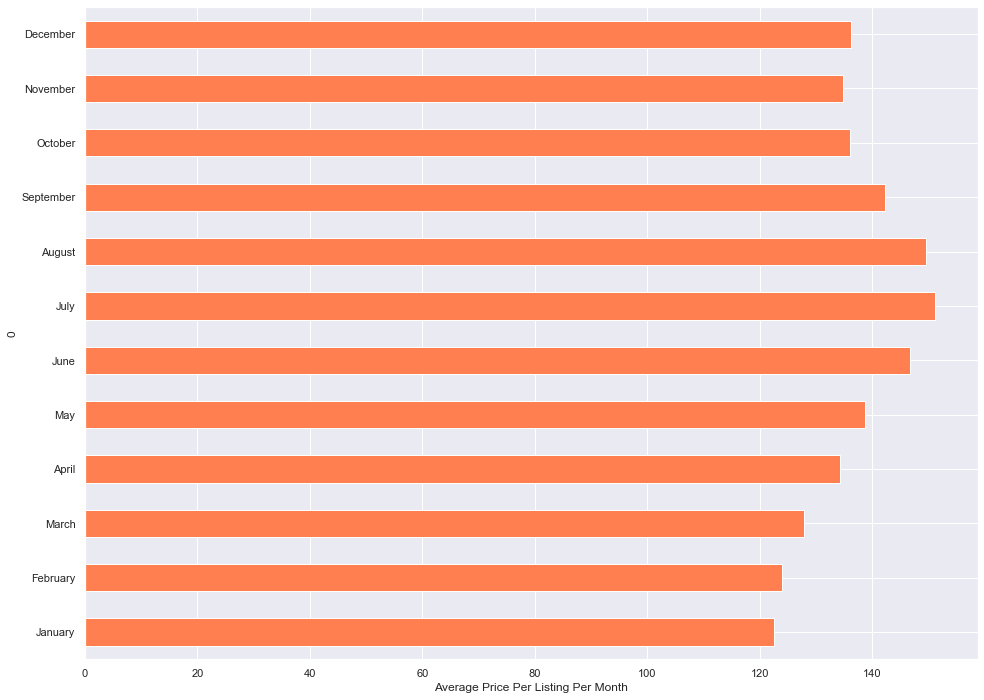

In [95]:
f, axes=plt.subplots(1,1,figsize=(16,12))
plt.xlabel("Average Price Per Listing Per Month")
plt.ylabel("Months")
occupancy_df["Average Price Per Listing"].plot.barh(color="coral")

It can be seen that July has the highest price out of all the months and January has the least price. July seems to be the favoured period to visit Seattle, and people are willing to pay a higher price. While in January, non-occupancy rates of airbnb listings could be lower due to the lower average price.

# Comparison between Availability and Average Price per month of airbnbs.

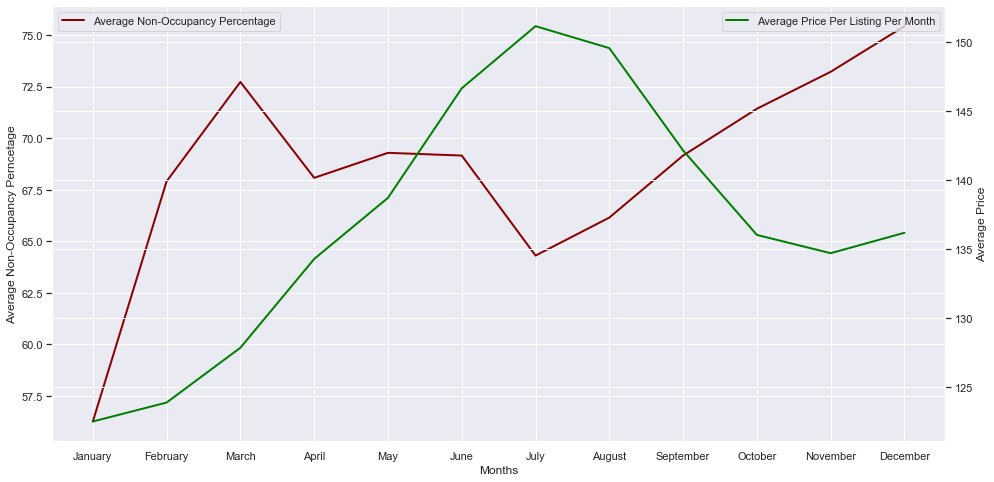

In [96]:
f, axes=plt.subplots(1,1,figsize=(16,8))
ax2 = axes.twinx()
x_1=occupancy_df["Average Non-Occupancy Percentage"]
x_2=occupancy_df["Average Price Per Listing"]
axes.plot(x_1,label="Average Non-Occupancy Percentage",color='darkred',linewidth=2)
ax2.plot(x_2,label='Average Price Per Listing Per Month',color='green',linewidth=2)
axes.legend(loc="upper left")
ax2.legend()
ax2.set_ylabel("Average Price")
axes.set_ylabel("Average Non-Occupancy Perncetage")
axes.set_xlabel('Months')
plt.show()

The graph shows a negative correlation between price and availability.
After analysing all the graphs, average price is likely to be higher when the availability of an airbnb is low, with exception of January, in which there may be low availability because of lower prices. Nonetheless, generally, the lower the availability, the higher the price. As a result, during months where tourism rates are high in Seattle, the availability of airbnbs will be lower and hence, the price would be higher.

# Bar Graphs of Average Price and non-occupancy in percentage.

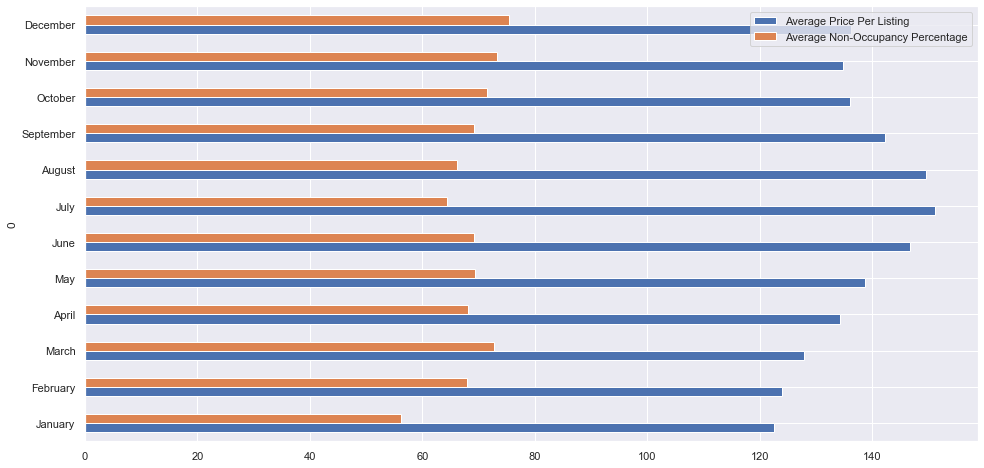

In [97]:
occupancy_df[["Average Price Per Listing","Average Non-Occupancy Percentage"]].plot.barh(figsize=(16,8))

Thus, after analysing all the graphs a relation can be developed here. January, although not a favoured time to visit Seattle, is the busiest month because it offers airbnbs at lowest prices and July ,being the peak time for tourism in Seattle due to favourable weather, offers airbnbs at highest prices. Hence, depending on whether its peak time for tourism or not, the prices of airbnbs vary and as a result, the occupancy-rate also changes accordingly.<br>
Thus, a user would know when the timings when airbnb listings are less readily available.

# Boxplots of Availability and Average Price.

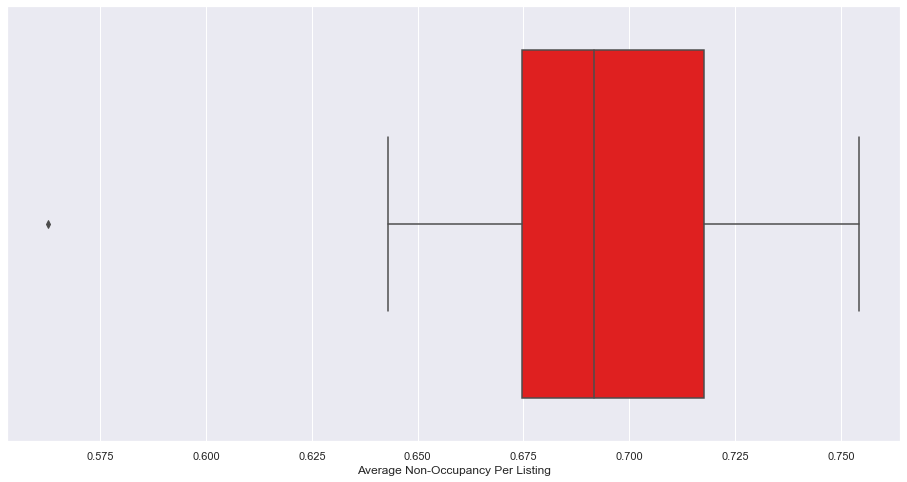

In [98]:
f, axes=plt.subplots(1,1,figsize=(16,8))
sb.boxplot(occupancy_df["Average Non-Occupancy Per Listing"],color="red")

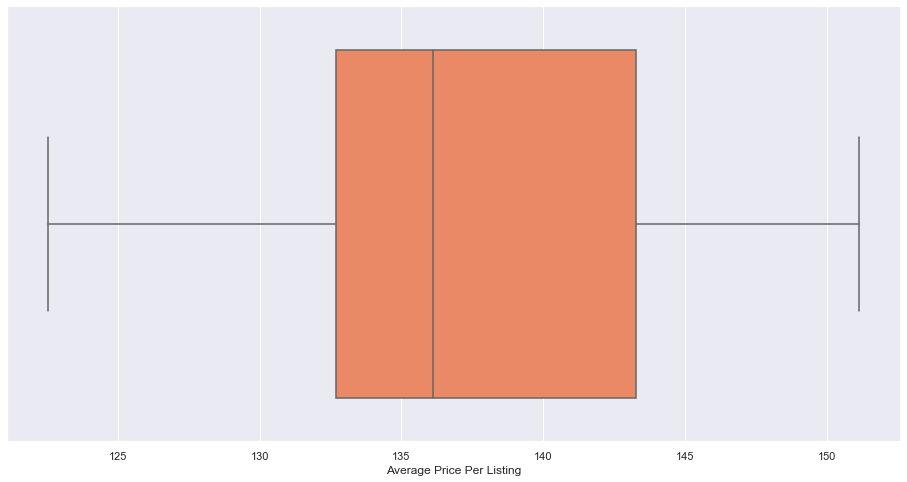

In [99]:
f,axes=plt.subplots(1,1,figsize=(16,8))
sb.boxplot(occupancy_df["Average Price Per Listing"],color="coral")

# Time series of non-occupancy per month in decimal and percentage, and average price per month.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12c76be50>,
      dtype=object)

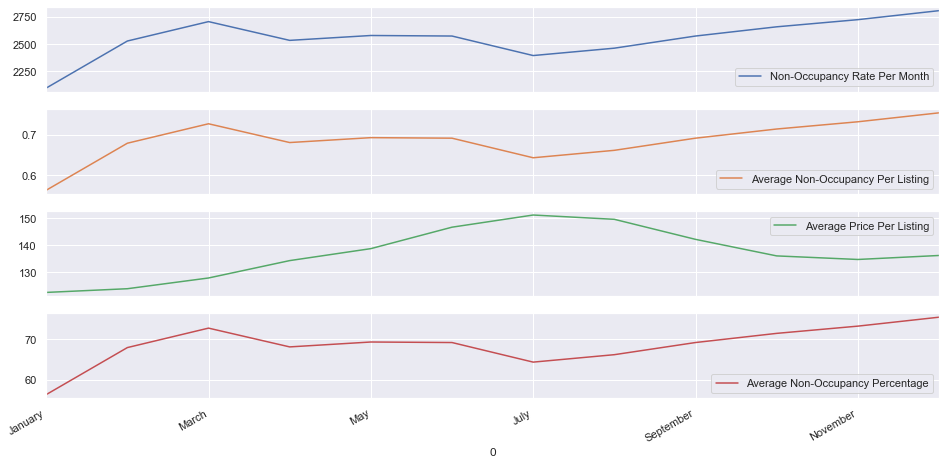

In [100]:
occupancy_df.plot(subplots=True,figsize=(16,8))

# Using ARIMA model to predict the average price for the next four months

In [101]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


# Testing if the time series graph is stationary or not and finding out rolling mean for prices.

In [102]:
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
def testing_station(timeseries):
    f,axes=plt.subplots(1,1,figsize=(16,8))
    rol_mean=timeseries.rolling(window=2).mean()
    original=plt.plot(timeseries,color='blue',label="Original")
    mean=plt.plot(rol_mean,color='red',label="Rolling Mean")
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)
    x=timeseries.values
    result= adfuller(x)
    rm=pd.DataFrame(rol_mean)
    print("Results of Dickey Fuller Test:")
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

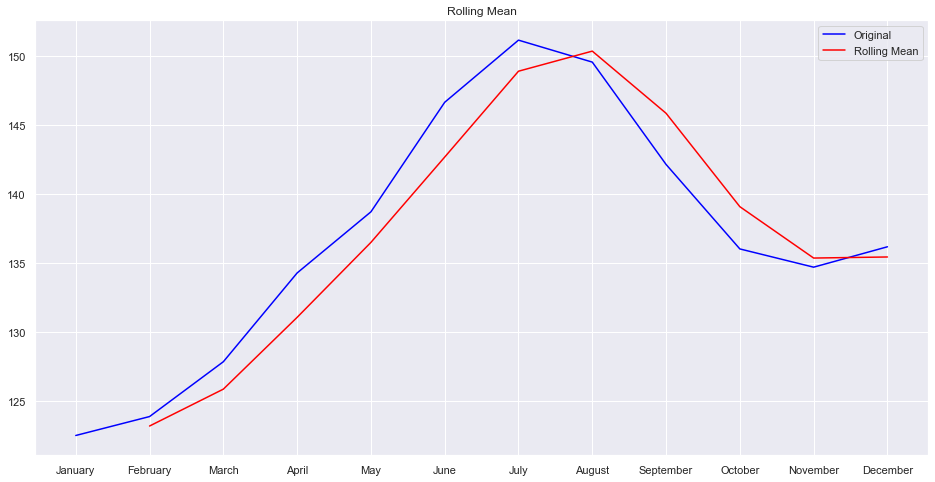

Results of Dickey Fuller Test:
ADF Statistic: -17.483238
p-value: 0.000000
Critical Values:
	1%: -4.939
	5%: -3.478
	10%: -2.844


In [103]:
testing_station(occupancy_df["Average Price Per Listing"])

# As the p-value is lesser than 0.5, the graph is stationary.

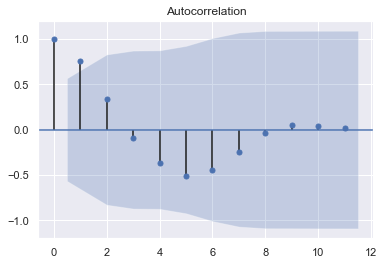

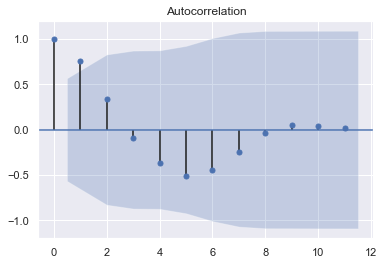

In [104]:
#ARIMA- Autoregressive (p) Integrated (d) Moving Average(q)
#plot_acf is to identify parameter q. 
#plot_pacf is to identify parameter p
#ARIMA(p,d,q)
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(occupancy_df["Average Price Per Listing"])

/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


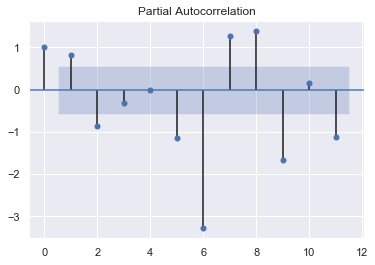

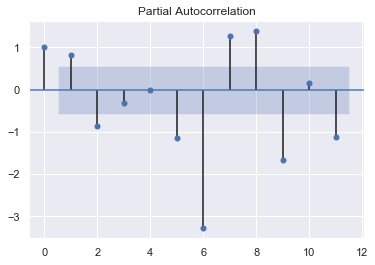

In [105]:
plot_pacf(occupancy_df["Average Price Per Listing"])

From the above graphs, the value of p is 2 and that of q is 0.

# ARIMA model for forecasting average price per listing per month

In [106]:
#p=2 and q=0
from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(occupancy_df['Average Price Per Listing'],order=(2,0,0))#fitting the model for the whole dataset first
model_fit=model.fit(disp=0)
model_fit.summary()#prints the characteristics of the model.

/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  ARMA Model Results                                 
=====================================================================================
Dep. Variable:     Average Price Per Listing   No. Observations:                   12
Model:                            ARMA(2, 0)   Log Likelihood                 -29.531
Method:                              css-mle   S.D. of innovations              2.426
Date:                       Fri, 17 Apr 2020   AIC                             67.061
Time:                               08:53:17   BIC                             69.001
Sample:                                    0   HQIC                            66.343
                                                                                     
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                             137.6670      2.600     52.947      0.000     132.571     142.763
ar.L1.Average Price Per Listing     1.5513      0.124     12.492      0.000       1.308       1.795
ar.L2.Average Price Per Listing    -0.8456      0.126     -6.714      0.000      -1.092      -0.599
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9173           -0.5841j            1.0875           -0.0902
AR.2            0.9173           +0.5841j            1.0875            0.0902
-----------------------------------------------------------------------------
"""

# From the table it is seen that the value of P is lower than 0.05 for each coefficient and hence, it is a decent model.

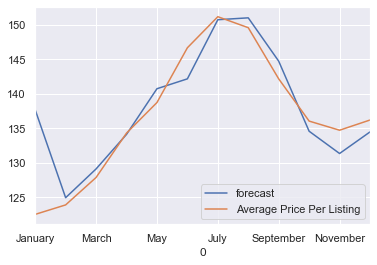

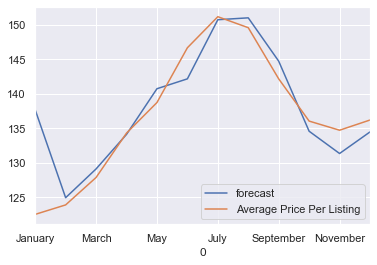

In [107]:
model_fit.plot_predict(dynamic=False)

Using the model, we forecast the Average Price Per Listing Per Month and compare it with the actual graph. It is seen that model predicts a higher price for the month of January and lower price for the month of December whereas it is quite similar for the rest of the months.

# Splitting dataset into test and train for finding optimal ARIMA model manually. 

In [108]:
train=occupancy_df["Average Price Per Listing"][0:8]
test=occupancy_df["Average Price Per Listing"][8:]

/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                                  ARMA Model Results                                 
Dep. Variable:     Average Price Per Listing   No. Observations:                    8
Model:                            ARMA(2, 0)   Log Likelihood                 -19.845
Method:                              css-mle   S.D. of innovations              2.132
Date:                       Fri, 17 Apr 2020   AIC                             47.691
Time:                               08:53:18   BIC                             48.009
Sample:                                    0   HQIC                            45.548
                                                                                     
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                             135.4733      3.145     43.072      0.000     129.309     141.638
ar.L1.Averag

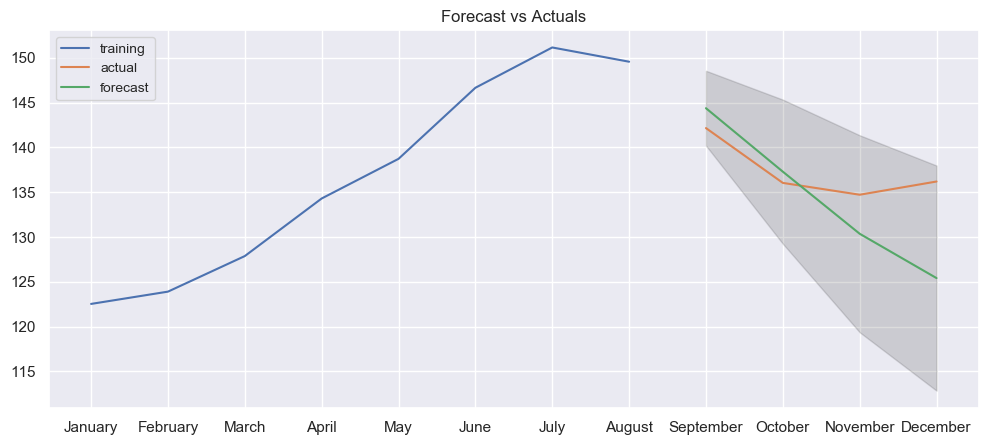

In [109]:
model=ARIMA(train,order=(2,0,0))
fitted=model.fit(disp=0)#Creating a model using the train dataset
print(fitted.summary())#printing the arima model summary
#forecast
fcast, se, conf = fitted.forecast(4, alpha=0.05) #95% confidence
#Creating Pandas Series for plotting
fcast_series = pd.Series(fcast, index=test.index)
l_series = pd.Series(conf[:, 0], index=test.index)
u_series = pd.Series(conf[:, 1], index=test.index)
#plotting actual and forecasted graphs
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fcast_series, label='forecast')
plt.fill_between(l_series.index, l_series, u_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=10)
plt.show()

From the above graph, we can see the prediction made by the model, using the test data, by learning from the train data. It is then compared with the actual graph to see the accuracy. For December, the model predicts a lower price as compared to the actual price.

# Checking accuracy of the model

In [110]:
print_error=dict()
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))*100
    corr = np.corrcoef(forecast, actual)[0,1]  
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)     
    return({'mape':mape, 'corr':corr, 'minmax':minmax})
print_error=forecast_accuracy(fcast, test)
print("Min-Max Error:",round(print_error['minmax'],4))
print("Mean Absolute Percentage error:",round(print_error['mape'],4))
print("Correlation Between Actual and Forecast:",round(print_error['corr'],4))

Min-Max Error: 0.034
Mean Absolute Percentage error: 3.4091
Correlation Between Actual and Forecast: 0.7916


These values show that this model is decent and accurate. The percentage error of the model is 3.4. However, due to insufficient data we cannot be sure that the model will predict correctly in different years as well.

# Using auto_arima to predict the Average Price Per Listing of next four months

In [111]:
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
auto_model = auto_arima(occupancy_df['Average Price Per Listing'], start_p=1, start_q=1,
                      test='adf',       # use adf test to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=0,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

auto_model.summary()

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=73.883, BIC=75.822, Time=0.074 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=90.637, BIC=91.606, Time=0.006 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=78.358, BIC=79.813, Time=0.070 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=81.428, BIC=82.883, Time=0.054 seconds
Near non-invertible roots for order (0, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=154.182, BIC=154.667, Time=0.005 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=68.645, BIC=71.070, Time=0.162 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=67.061, BIC=69.001, Time=0.107 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=68.648, BIC=71.072, Time=0.186 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   12
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 -29.531
Date:                Fri, 17 Apr 2020   AIC                             67.061
Time:                        08:53:20   BIC                             69.001
Sample:                             0   HQIC                            66.343
                                 - 12                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     40.4485     18.432      2.194      0.028       4.323      76.574
ar.L1          1.5516      0.187      8.276      0.000       1.184       1.919
ar.L2         -0.8454      0.172     -4.919      0.000      -1.182      -0.509
sigma2         5.8860      4.460      1.320      0.187      -2.856      14.628
===================================================================================
Ljung-Box (Q):                       11.31   Jarque-Bera (JB):                 0.26
Prob(Q):                              0.42   Prob(JB):                         0.88
Heteroskedasticity (H):               1.10   Skew:                             0.19
Prob(H) (two-sided):                  0.93   Kurtosis:                         2.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

This model is not completely accurate as the value of P is not below 0.05 in one case. Thus, the future prediction may not be completely accurate.

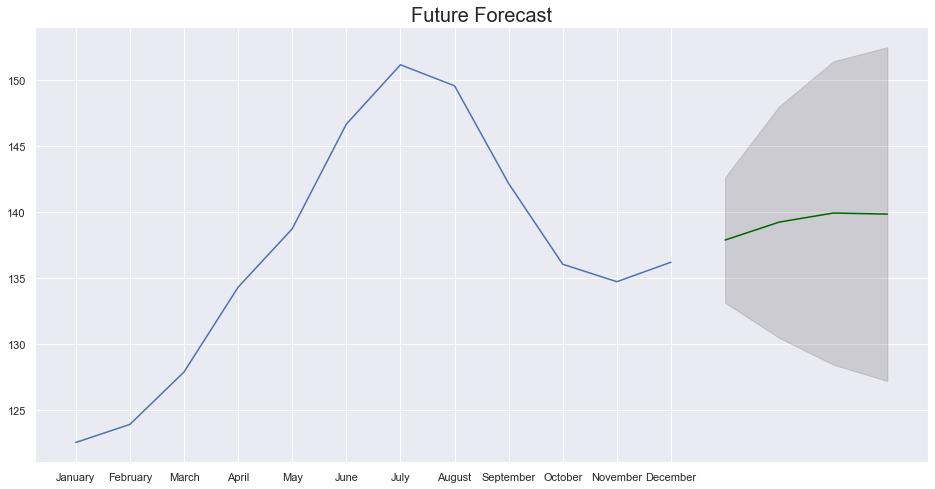

In [112]:
future = 4 #stores the number of months in future
fcast, confint = auto_model.predict(n_periods=future, return_conf_int=True)
index_of_fcast = np.arange(len(occupancy_df["Average Price Per Listing"]), len(occupancy_df["Average Price Per Listing"])+future)
# make series for plotting the actual and future graphs
fcast_series = pd.Series(fcast, index=index_of_fcast)
l_series = pd.Series(confint[:, 0], index=index_of_fcast)
u_series = pd.Series(confint[:, 1], index=index_of_fcast)
f,axes=plt.subplots(1,1,figsize=(16,8))
# Plotting the actual and forecasted graph
plt.plot(occupancy_df["Average Price Per Listing"])
plt.plot(fcast_series, color='darkgreen')
plt.fill_between(l_series.index, 
                 l_series, 
                 u_series, 
                 color='k', alpha=.15)
plt.title("Future Forecast",fontsize=20)
plt.show()

Here, the green line is the predicted Average Price Per Listing for the months January-April next year. It shows an increase in price followed by a gradual flattening of the curve.<br>
It may or may not be correct as we do not have sufficient data to be sure about predictions in different years.

# Time series of non-occupancy per month in percentage, and average price per month for each cluster

In [113]:
#Separate data into respective clusters and check correlation between price and numeric variables
cluster=clustered_data_k_copy[clustered_data_k_copy.Cluster=='small-cheap listing']
cluster_1=clustered_data_k_copy[clustered_data_k_copy.Cluster=='small-low-quality listing']
cluster_2=clustered_data_k_copy[clustered_data_k_copy.Cluster=='small-high-quality listing']
cluster_3=clustered_data_k_copy[clustered_data_k_copy.Cluster=='medium listing']
cluster_4=clustered_data_k_copy[clustered_data_k_copy.Cluster=='large listing']


In [114]:
#Cluster with 'small-cheap listing'
cluster=clustered_data_k_copy[clustered_data_k_copy.Cluster=='small-cheap listing']
#calculate total price and non-occupancies count per month for all listings
total_freq_month=list()
average_price=list()
count = 0
for i in cluster['id']:
    #Extract relevant listings
    if (count==0):
        temp_clust = calendar_available[calendar_available['listing_id']==i]
    elif (count==1):
        temp_joint = calendar_available[calendar_available['listing_id']==i]
        temp_joint = pd.concat([temp_joint,temp_clust],axis=0)
    elif (count>=2):
        temp_clust = calendar_available[calendar_available['listing_id']==i]
        temp_joint = pd.concat([temp_joint,temp_clust],axis=0)
    count+=1
#calculate sum of available listings to tally count
sum=0
sum=sum+temp_joint['listing_id'].count()
#calculate total available dates and price
for i in range(12):
    total_freq_month.append((temp_joint['month']==(i+1)).sum())
    temp=pd.DataFrame(temp_joint[temp_joint['month']==(i+1)])
    average_price.append(temp['price'].sum())
non_occupancy=[]
avg_non_occupancy=[]
avg_price_listing=[]
avg_non_occupancy_percent=[]
for i in range(12):
    if(i==0 or i==2 or i==4 or i==6 or i==7 or i==9 or i==11):
        non_occupancy.append(math.ceil(total_freq_month[i]/31))
        avg_non_occupancy.append((total_freq_month[i]/(31*3723)))
    elif(i==1):
        non_occupancy.append(math.ceil(total_freq_month[i]/29))
        avg_non_occupancy.append((total_freq_month[i]/(29*3723)))
    else:
        non_occupancy.append(math.ceil(total_freq_month[i]/30))
        avg_non_occupancy.append((total_freq_month[i]/(30*3723)))
    avg_price_listing.append(average_price[i]/(total_freq_month[i]))
    avg_non_occupancy_percent.append(avg_non_occupancy[i]*100)
    
#Create dataframe for above lists
months=["January","February","March","April","May","June","July","August","September","October","November","December"]
occupancy_df=pd.DataFrame(months)
occupancy_df['Non-Occupancy Rate Per Month']=pd.DataFrame(non_occupancy)
occupancy_df['Average Non-Occupancy Per Listing']=pd.DataFrame(avg_non_occupancy)
occupancy_df=occupancy_df.set_index(occupancy_df[0])
occupancy_df=occupancy_df.drop(columns=[0])
occupancy_df["Average Price Per Listing"]=(avg_price_listing)
occupancy_df["Average Non-Occupancy Percentage"]=avg_non_occupancy_percent
occupancy_df

Non-Occupancy Rate Per Month  Average Non-Occupancy Per Listing  \
0                                                                            
January                             530                           0.142220   
February                            648                           0.173886   
March                               696                           0.186946   
April                               633                           0.169899   
May                                 638                           0.171281   
June                                637                           0.170911   
July                                585                           0.157045   
August                              596                           0.159913   
September                           611                           0.163864   
October                             622                           0.167000   
November                            633                           0.169845   
December                            639                           0.171497   

           Average Price Per Listing  Average Non-Occupancy Percentage  
0                                                                       
January                    71.817534                         14.221968  
February                   71.380580                         17.388647  
March                      72.416574                         18.694601  
April                      74.302118                         16.989883  
May                        75.666228                         17.128053  
June                       77.046467                         17.091056  
July                       77.433710                         15.704470  
August                     76.849751                         15.991266  
September                  76.174353                         16.386427  
October                    74.736173                         16.700025  
November                   74.177016                         16.984511  
December                   74.765321                         17.149715

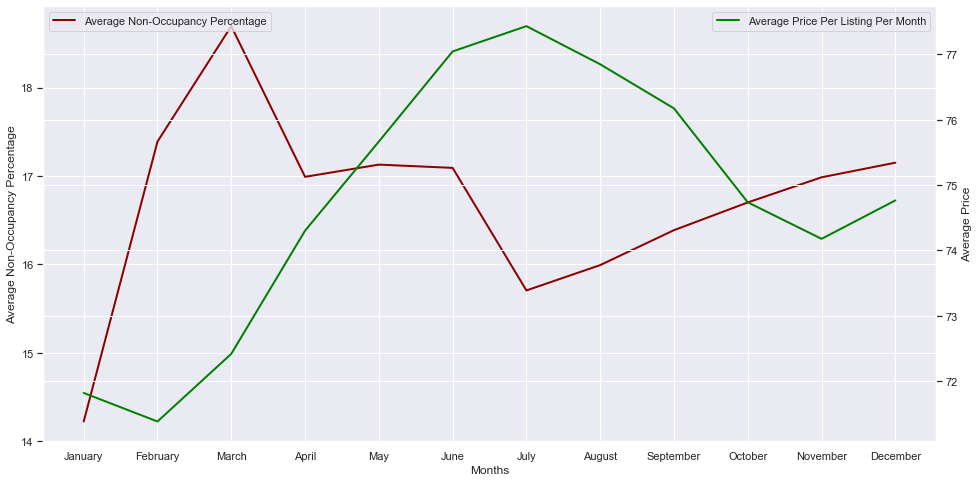

In [115]:
f, axes=plt.subplots(1,1,figsize=(16,8))
ax2 = axes.twinx()
x_1=occupancy_df["Average Non-Occupancy Percentage"]
x_2=occupancy_df["Average Price Per Listing"]
axes.plot(x_1,label="Average Non-Occupancy Percentage",color='darkred',linewidth=2)
ax2.plot(x_2,label='Average Price Per Listing Per Month',color='green',linewidth=2)
axes.legend(loc="upper left")
ax2.legend()
ax2.set_ylabel("Average Price")
axes.set_ylabel("Average Non-Occupancy Percentage")
axes.set_xlabel('Months')
plt.show()


In [116]:
#Cluster with 'small-low-quality listing'
cluster=clustered_data_k_copy[clustered_data_k_copy.Cluster=='small-low-quality listing']
#calculate total price and non-occupancies count per month for all listings
total_freq_month=list()
average_price=list()
count = 0
for i in cluster['id']:
    #Extract relevant listings
    if (count==0):
        temp_clust = calendar_available[calendar_available['listing_id']==i]
    elif (count==1):
        temp_joint = calendar_available[calendar_available['listing_id']==i]
        temp_joint = pd.concat([temp_joint,temp_clust],axis=0)
    elif (count>=2):
        temp_clust = calendar_available[calendar_available['listing_id']==i]
        temp_joint = pd.concat([temp_joint,temp_clust],axis=0)
    count+=1
#calculate sum of available listings to tally count
sum=sum+temp_joint['listing_id'].count()
#calculate total available dates and price
for i in range(12):
    total_freq_month.append((temp_joint['month']==(i+1)).sum())
    temp=pd.DataFrame(temp_joint[temp_joint['month']==(i+1)])
    average_price.append(temp['price'].sum())
non_occupancy=[]
avg_non_occupancy=[]
avg_price_listing=[]
avg_non_occupancy_percent=[]
for i in range(12):
    if(i==0 or i==2 or i==4 or i==6 or i==7 or i==9 or i==11):
        non_occupancy.append(math.ceil(total_freq_month[i]/31))
        avg_non_occupancy.append((total_freq_month[i]/(31*3723)))
    elif(i==1):
        non_occupancy.append(math.ceil(total_freq_month[i]/29))
        avg_non_occupancy.append((total_freq_month[i]/(29*3723)))
    else:
        non_occupancy.append(math.ceil(total_freq_month[i]/30))
        avg_non_occupancy.append((total_freq_month[i]/(30*3723)))
    avg_price_listing.append(average_price[i]/(total_freq_month[i]))
    avg_non_occupancy_percent.append(avg_non_occupancy[i]*100)
    
#Create dataframe for above lists
months=["January","February","March","April","May","June","July","August","September","October","November","December"]
occupancy_df=pd.DataFrame(months)
occupancy_df['Non-Occupancy Rate Per Month']=pd.DataFrame(non_occupancy)
occupancy_df['Average Non-Occupancy Per Listing']=pd.DataFrame(avg_non_occupancy)
occupancy_df=occupancy_df.set_index(occupancy_df[0])
occupancy_df=occupancy_df.drop(columns=[0])
occupancy_df["Average Price Per Listing"]=(avg_price_listing)
occupancy_df["Average Non-Occupancy Percentage"]=avg_non_occupancy_percent
occupancy_df

Non-Occupancy Rate Per Month  Average Non-Occupancy Per Listing  \
0                                                                            
January                             157                           0.041980   
February                            182                           0.048811   
March                               191                           0.051147   
April                               181                           0.048590   
May                                 184                           0.049336   
June                                188                           0.050398   
July                                184                           0.049267   
August                              181                           0.048599   
September                           186                           0.049906   
October                             188                           0.050272   
November                            189                           0.050586   
December                            189                           0.050592   

           Average Price Per Listing  Average Non-Occupancy Percentage  
0                                                                       
January                   112.241692                          4.197967  
February                  112.993928                          4.881121  
March                     115.692699                          5.114675  
April                     115.961120                          4.858985  
May                       116.689673                          4.933586  
June                      124.647184                          5.039842  
July                      126.041330                          4.926655  
August                    124.923872                          4.859938  
September                 117.946896                          4.990599  
October                   114.685281                          5.027163  
November                  113.687434                          5.058644  
December                  114.442028                          5.059222

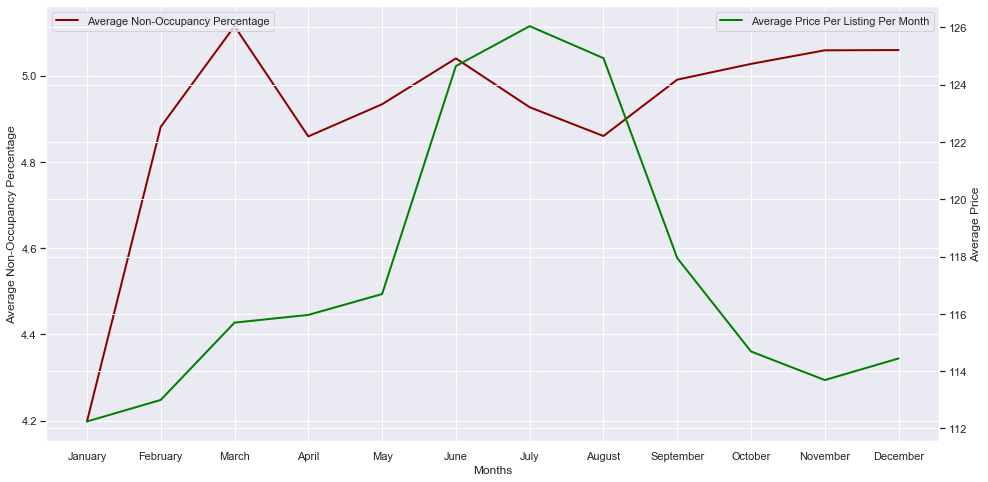

In [117]:
f, axes=plt.subplots(1,1,figsize=(16,8))
ax2 = axes.twinx()
x_1=occupancy_df["Average Non-Occupancy Percentage"]
x_2=occupancy_df["Average Price Per Listing"]
axes.plot(x_1,label="Average Non-Occupancy Percentage",color='darkred',linewidth=2)
ax2.plot(x_2,label='Average Price Per Listing Per Month',color='green',linewidth=2)
axes.legend(loc="upper left")
ax2.legend()
ax2.set_ylabel("Average Price")
axes.set_ylabel("Average Non-Occupancy Percentage")
axes.set_xlabel('Months')
plt.show()



In [118]:
#Cluster with 'small-high-quality listing'
cluster=clustered_data_k_copy[clustered_data_k_copy.Cluster=='small-high-quality listing']
#calculate total price and non-occupancies count per month for all listings
total_freq_month=list()
average_price=list()
count = 0
for i in cluster['id']:
    #Extract relevant listings
    if (count==0):
        temp_clust = calendar_available[calendar_available['listing_id']==i]
    elif (count==1):
        temp_joint = calendar_available[calendar_available['listing_id']==i]
        temp_joint = pd.concat([temp_joint,temp_clust],axis=0)
    elif (count>=2):
        temp_clust = calendar_available[calendar_available['listing_id']==i]
        temp_joint = pd.concat([temp_joint,temp_clust],axis=0)
    count+=1
#calculate sum of available listings to tally count
sum=sum+temp_joint['listing_id'].count()
#calculate total available dates and price
for i in range(12):
    total_freq_month.append((temp_joint['month']==(i+1)).sum())
    temp=pd.DataFrame(temp_joint[temp_joint['month']==(i+1)])
    average_price.append(temp['price'].sum())
non_occupancy=[]
avg_non_occupancy=[]
avg_price_listing=[]
avg_non_occupancy_percent=[]
for i in range(12):
    if(i==0 or i==2 or i==4 or i==6 or i==7 or i==9 or i==11):
        non_occupancy.append(math.ceil(total_freq_month[i]/31))
        avg_non_occupancy.append((total_freq_month[i]/(31*3723)))
    elif(i==1):
        non_occupancy.append(math.ceil(total_freq_month[i]/29))
        avg_non_occupancy.append((total_freq_month[i]/(29*3723)))
    else:
        non_occupancy.append(math.ceil(total_freq_month[i]/30))
        avg_non_occupancy.append((total_freq_month[i]/(30*3723)))
    avg_price_listing.append(average_price[i]/(total_freq_month[i]))
    avg_non_occupancy_percent.append(avg_non_occupancy[i]*100)
    
#Create dataframe for above lists
months=["January","February","March","April","May","June","July","August","September","October","November","December"]
occupancy_df=pd.DataFrame(months)
occupancy_df['Non-Occupancy Rate Per Month']=pd.DataFrame(non_occupancy)
occupancy_df['Average Non-Occupancy Per Listing']=pd.DataFrame(avg_non_occupancy)
occupancy_df=occupancy_df.set_index(occupancy_df[0])
occupancy_df=occupancy_df.drop(columns=[0])
occupancy_df["Average Price Per Listing"]=(avg_price_listing)
occupancy_df["Average Non-Occupancy Percentage"]=avg_non_occupancy_percent
occupancy_df

Non-Occupancy Rate Per Month  Average Non-Occupancy Per Listing  \
0                                                                            
January                             444                           0.119198   
February                            558                           0.149814   
March                               606                           0.162590   
April                               554                           0.148653   
May                                 559                           0.149914   
June                                542                           0.145519   
July                                492                           0.132143   
August                              509                           0.136553   
September                           533                           0.143012   
October                             546                           0.146543   
November                            558                           0.149790   
December                            576                           0.154567   

           Average Price Per Listing  Average Non-Occupancy Percentage  
0                                                                       
January                   111.965836                         11.919801  
February                  113.032334                         14.981430  
March                     118.380869                         16.259000  
April                     124.233693                         14.865252  
May                       128.125650                         14.991379  
June                      130.272442                         14.551885  
July                      135.368828                         13.214283  
August                    134.285660                         13.655307  
September                 127.087523                         14.301191  
October                   120.142317                         14.654328  
November                  118.512732                         14.978960  
December                  119.020461                         15.456664

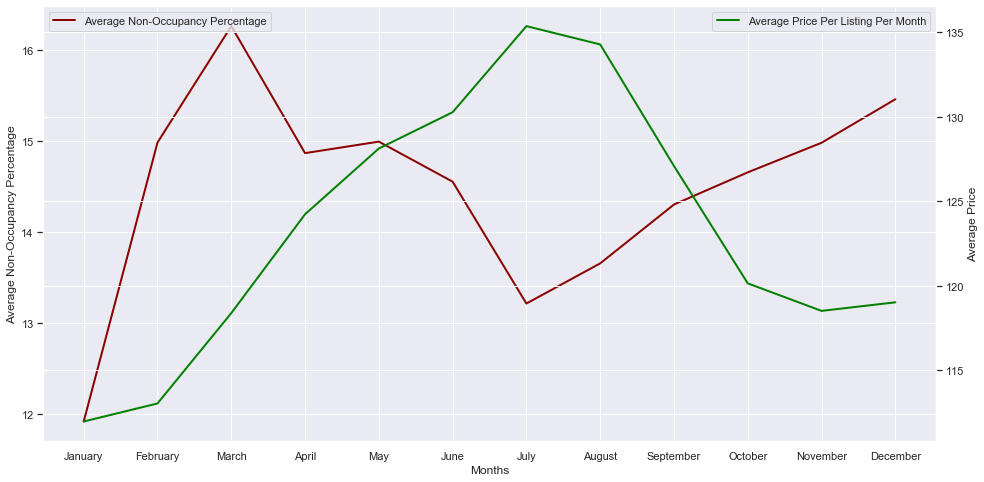

In [119]:
f, axes=plt.subplots(1,1,figsize=(16,8))
ax2 = axes.twinx()
x_1=occupancy_df["Average Non-Occupancy Percentage"]
x_2=occupancy_df["Average Price Per Listing"]
axes.plot(x_1,label="Average Non-Occupancy Percentage",color='darkred',linewidth=2)
ax2.plot(x_2,label='Average Price Per Listing Per Month',color='green',linewidth=2)
axes.legend(loc="upper left")
ax2.legend()
ax2.set_ylabel("Average Price")
axes.set_ylabel("Average Non-Occupancy Percentage")
axes.set_xlabel('Months')
plt.show()


In [120]:
#Cluster with 'medium listing'
cluster=clustered_data_k_copy[clustered_data_k_copy.Cluster=='medium listing']
#calculate total price and non-occupancies count per month for all listings
total_freq_month=list()
average_price=list()
count = 0
for i in cluster['id']:
    #Extract relevant listings
    if (count==0):
        temp_clust = calendar_available[calendar_available['listing_id']==i]
    elif (count==1):
        temp_joint = calendar_available[calendar_available['listing_id']==i]
        temp_joint = pd.concat([temp_joint,temp_clust],axis=0)
    elif (count>=2):
        temp_clust = calendar_available[calendar_available['listing_id']==i]
        temp_joint = pd.concat([temp_joint,temp_clust],axis=0)
    count+=1
#calculate sum of available listings to tally count
sum=sum+temp_joint['listing_id'].count()
#calculate total available dates and price
for i in range(12):
    total_freq_month.append((temp_joint['month']==(i+1)).sum())
    temp=pd.DataFrame(temp_joint[temp_joint['month']==(i+1)])
    average_price.append(temp['price'].sum())
non_occupancy=[]
avg_non_occupancy=[]
avg_price_listing=[]
avg_non_occupancy_percent=[]
for i in range(12):
    if(i==0 or i==2 or i==4 or i==6 or i==7 or i==9 or i==11):
        non_occupancy.append(math.ceil(total_freq_month[i]/31))
        avg_non_occupancy.append((total_freq_month[i]/(31*3723)))
    elif(i==1):
        non_occupancy.append(math.ceil(total_freq_month[i]/29))
        avg_non_occupancy.append((total_freq_month[i]/(29*3723)))
    else:
        non_occupancy.append(math.ceil(total_freq_month[i]/30))
        avg_non_occupancy.append((total_freq_month[i]/(30*3723)))
    avg_price_listing.append(average_price[i]/(total_freq_month[i]))
    avg_non_occupancy_percent.append(avg_non_occupancy[i]*100)
    
#Create dataframe for above lists
months=["January","February","March","April","May","June","July","August","September","October","November","December"]
occupancy_df=pd.DataFrame(months)
occupancy_df['Non-Occupancy Rate Per Month']=pd.DataFrame(non_occupancy)
occupancy_df['Average Non-Occupancy Per Listing']=pd.DataFrame(avg_non_occupancy)
occupancy_df=occupancy_df.set_index(occupancy_df[0])
occupancy_df=occupancy_df.drop(columns=[0])
occupancy_df["Average Price Per Listing"]=(avg_price_listing)
occupancy_df["Average Non-Occupancy Percentage"]=avg_non_occupancy_percent
occupancy_df

Non-Occupancy Rate Per Month  Average Non-Occupancy Per Listing  \
0                                                                            
January                             312                           0.083699   
February                            392                           0.105153   
March                               422                           0.113116   
April                               403                           0.108139   
May                                 416                           0.111738   
June                                412                           0.110592   
July                                350                           0.093776   
August                              362                           0.097207   
September                           372                           0.099660   
October                             383                           0.102657   
November                            393                           0.105435   
December                            401                           0.107640   

           Average Price Per Listing  Average Non-Occupancy Percentage  
0                                                                       
January                   144.580849                          8.369941  
February                  146.821633                         10.515250  
March                     152.237917                         11.311551  
April                     156.463736                         10.813860  
May                       163.262795                         11.173785  
June                      177.084926                         11.059182  
July                      183.320983                          9.377626  
August                    179.514306                          9.720742  
September                 167.023628                          9.965977  
October                   153.863268                         10.265741  
November                  152.476647                         10.543469  
December                  155.849312                         10.763952

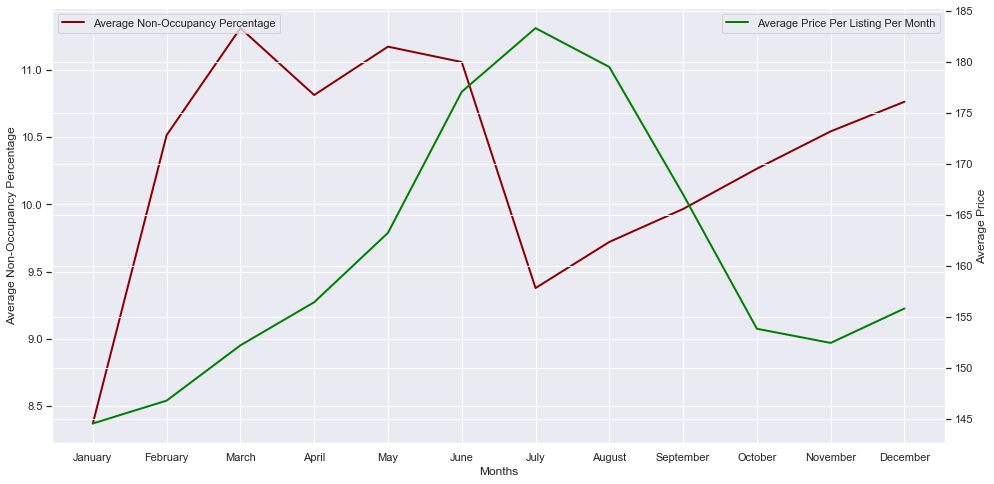

In [121]:
f, axes=plt.subplots(1,1,figsize=(16,8))
ax2 = axes.twinx()
x_1=occupancy_df["Average Non-Occupancy Percentage"]
x_2=occupancy_df["Average Price Per Listing"]
axes.plot(x_1,label="Average Non-Occupancy Percentage",color='darkred',linewidth=2)
ax2.plot(x_2,label='Average Price Per Listing Per Month',color='green',linewidth=2)
axes.legend(loc="upper left")
ax2.legend()
ax2.set_ylabel("Average Price")
axes.set_ylabel("Average Non-Occupancy Percentage")
axes.set_xlabel('Months')
plt.show()


In [122]:
#Cluster with 'medium listing'
cluster=clustered_data_k_copy[clustered_data_k_copy.Cluster=='large listing']
#calculate total price and non-occupancies count per month for all listings
total_freq_month=list()
average_price=list()
count = 0
for i in cluster['id']:
    #Extract relevant listings
    if (count==0):
        temp_clust = calendar_available[calendar_available['listing_id']==i]
    elif (count==1):
        temp_joint = calendar_available[calendar_available['listing_id']==i]
        temp_joint = pd.concat([temp_joint,temp_clust],axis=0)
    elif (count>=2):
        temp_clust = calendar_available[calendar_available['listing_id']==i]
        temp_joint = pd.concat([temp_joint,temp_clust],axis=0)
    count+=1
#calculate sum of available listings to tally count
sum=sum+temp_joint['listing_id'].count()
#calculate total available dates and price
for i in range(12):
    total_freq_month.append((temp_joint['month']==(i+1)).sum())
    temp=pd.DataFrame(temp_joint[temp_joint['month']==(i+1)])
    average_price.append(temp['price'].sum())

non_occupancy=[]
avg_non_occupancy=[]
avg_price_listing=[]
avg_non_occupancy_percent=[]
for i in range(12):
    if(i==0 or i==2 or i==4 or i==6 or i==7 or i==9 or i==11):
        non_occupancy.append(math.ceil(total_freq_month[i]/31))
        avg_non_occupancy.append((total_freq_month[i]/(31*3723)))
    elif(i==1):
        non_occupancy.append(math.ceil(total_freq_month[i]/29))
        avg_non_occupancy.append((total_freq_month[i]/(29*3723)))
    else:
        non_occupancy.append(math.ceil(total_freq_month[i]/30))
        avg_non_occupancy.append((total_freq_month[i]/(30*3723)))
    avg_price_listing.append(average_price[i]/(total_freq_month[i]))
    avg_non_occupancy_percent.append(avg_non_occupancy[i]*100)
    
#Create dataframe for above lists
months=["January","February","March","April","May","June","July","August","September","October","November","December"]
occupancy_df=pd.DataFrame(months)
occupancy_df['Non-Occupancy Rate Per Month']=pd.DataFrame(non_occupancy)
occupancy_df['Average Non-Occupancy Per Listing']=pd.DataFrame(avg_non_occupancy)
occupancy_df=occupancy_df.set_index(occupancy_df[0])
occupancy_df=occupancy_df.drop(columns=[0])
occupancy_df["Average Price Per Listing"]=(avg_price_listing)
occupancy_df["Average Non-Occupancy Percentage"]=avg_non_occupancy_percent
occupancy_df

Non-Occupancy Rate Per Month  Average Non-Occupancy Per Listing  \
0                                                                            
January                             190                           0.050783   
February                            228                           0.061139   
March                               240                           0.064222   
April                               242                           0.064885   
May                                 241                           0.064499   
June                                239                           0.063954   
July                                221                           0.059153   
August                              231                           0.062012   
September                           245                           0.065673   
October                             253                           0.067722   
November                            258                           0.069138   
December                            264                           0.070746   

           Average Price Per Listing  Average Non-Occupancy Percentage  
0                                                                       
January                   241.767787                          5.078284  
February                  247.121345                          6.113905  
March                     262.715192                          6.422153  
April                     277.076721                          6.488495  
May                       299.835572                          6.449880  
June                      333.093238                          6.395380  
July                      350.129486                          5.915278  
August                    341.602487                          6.201208  
September                 309.391275                          6.567284  
October                   292.987845                          6.772201  
November                  287.980057                          6.913779  
December                  291.095775                          7.074593

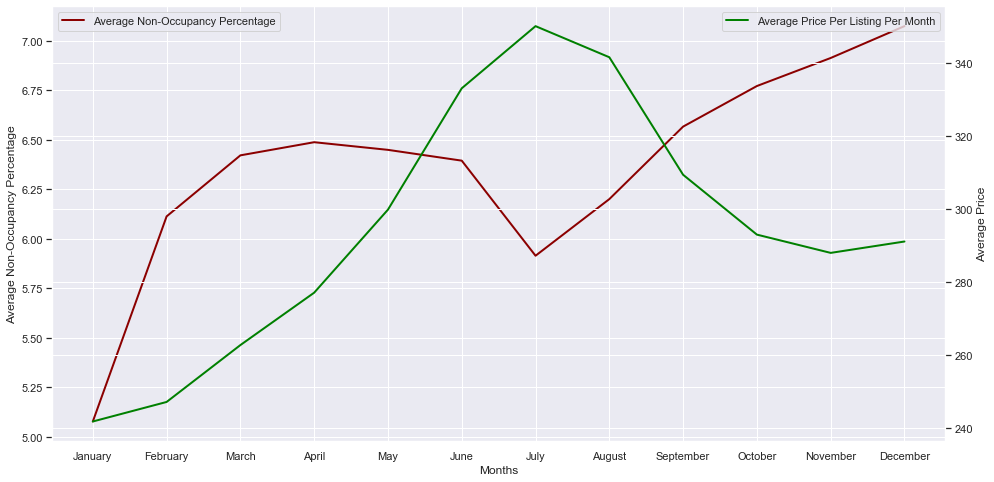

In [123]:
f, axes=plt.subplots(1,1,figsize=(16,8))
ax2 = axes.twinx()
x_1=occupancy_df["Average Non-Occupancy Percentage"]
x_2=occupancy_df["Average Price Per Listing"]
axes.plot(x_1,label="Average Non-Occupancy Percentage",color='darkred',linewidth=2)
ax2.plot(x_2,label='Average Price Per Listing Per Month',color='green',linewidth=2)
axes.legend(loc="upper left")
ax2.legend()
ax2.set_ylabel("Average Price")
axes.set_ylabel("Average Non-Occupancy Percentage")
axes.set_xlabel('Months')
plt.show()

In [124]:
#The total number of availability of listings in all clusters is less than that in the whole dataset/
#as some listings are removed in data cleaning before the clusters are formed. Nonetheless, /
#the results are relatively similar to that based on the entire dataset.
sum

719110

Generally, for all clusters, except for the cluster for 'small-low-quality' listing, January and July also have lower non-occupancy rates and higher prices. This suggests in these periods, there are higher demand for airbnb homes. In addition, the prices in January are usually low even though the non-occupancy percentage is low, suggesting lower price may increase occupancy rate. This trend is similar to that for the overall trend.

# What is the likelihood of a listing(s) being booked?

In [125]:
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter, WeekdayLocator, DayLocator
%matplotlib inline
import time
import re
from datetime import datetime
import matplotlib.dates as mdates
from scipy.ndimage.filters import gaussian_filter1d
from sklearn import preprocessing as p
from sklearn.decomposition import PCA 
import operator
import pprint

In [126]:
df_listing = pd.read_csv('listings.csv')
df_calendar = pd.read_csv('calendar.csv')
df_reviews = pd.read_csv('reviews.csv')

# Data cleaning and preparation

In [127]:
#modify df_calender
df_calendar['price'] = df_calendar['price'].map(lambda price: float(price[1:].replace(',', '')), na_action='ignore')
df_calendar.price_new = df_calendar.price.fillna(method='ffill')
df_calendar.update(df_calendar.price_new)
df_calendar.head()
pd.DataFrame(df_calendar.price).describe()

/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until


price
count  1.393570e+06
mean   1.360387e+02
std    1.018518e+02
min    1.000000e+01
25%    7.500000e+01
50%    1.050000e+02
75%    1.600000e+02
max    1.650000e+03

In [128]:
# Modify df_calendar
# Special event : marathon, new academic season
# Split date column into year, month,day, weekday columns
# The day of the week with Monday=0, Sunday=6
# Set the range of weekends from Friday to Sunday
df_calendar['year'] = pd.DatetimeIndex(df_calendar['date']).year
df_calendar['month'] = pd.DatetimeIndex(df_calendar['date']).month
df_calendar['day'] = pd.DatetimeIndex(df_calendar['date']).day
df_calendar['weekday'] = pd.DatetimeIndex(df_calendar['date']).weekday
df_calendar['week_number'] = pd.DatetimeIndex(df_calendar['date']).week
df_calendar.head()

listing_id        date available  price  year  month  day  weekday  \
0      241032  2016-01-04         t   85.0  2016      1    4        0   
1      241032  2016-01-05         t   85.0  2016      1    5        1   
2      241032  2016-01-06         f   85.0  2016      1    6        2   
3      241032  2016-01-07         f   85.0  2016      1    7        3   
4      241032  2016-01-08         f   85.0  2016      1    8        4   

   week_number  
0            1  
1            1  
2            1  
3            1  
4            1

# Predicting whether a listing will be booked or not

In [129]:
#extract listings instances that are available
calendar_available=pd.DataFrame(df_calendar[df_calendar['available']=='t'])
#finding all unique airbnbs
listid_unique=pd.DataFrame(calendar_available['listing_id'].unique())

#changing column name
listid_unique=listid_unique.rename(columns={0:"list_id"})

#finding frequency of availability of each airbnb
freq_avail_listid=[]
for i in range(listid_unique.shape[0]):
    freq_avail_listid.append((calendar_available['listing_id']==listid_unique['list_id'][i]).sum())

listid_unique['Available Bookings']=pd.DataFrame(freq_avail_listid)
listid_unique['Unavailable Bookings']=365-listid_unique['Available Bookings']
listid_unique

list_id  Available Bookings  Unavailable Bookings
0       241032                 346                    19
1       953595                 291                    74
2      3308979                 220                   145
3      7421966                 143                   222
4       278830                 365                     0
...        ...                 ...                   ...
3718   8101950                  32                   333
3719   8902327                 273                    92
3720  10267360                  88                   277
3721   9604740                 179                   186
3722  10208623                   7                   358

[3723 rows x 3 columns]

In [130]:
#Prediction for listing with id '953595'
#first listing's id
listid=953595

start = df_calendar.index[df_calendar['listing_id']==listid][0]
end = df_calendar.index[df_calendar['listing_id']==listid][0]+365

listing1=pd.DataFrame(df_calendar[start:end])
listing1

listing_id        date available  price  year  month  day  weekday  \
365      953595  2016-01-04         t  125.0  2016      1    4        0   
366      953595  2016-01-05         t  125.0  2016      1    5        1   
367      953595  2016-01-06         f  125.0  2016      1    6        2   
368      953595  2016-01-07         f  125.0  2016      1    7        3   
369      953595  2016-01-08         f  125.0  2016      1    8        4   
..          ...         ...       ...    ...   ...    ...  ...      ...   
725      953595  2016-12-29         t  229.0  2016     12   29        3   
726      953595  2016-12-30         t  294.0  2016     12   30        4   
727      953595  2016-12-31         t  358.0  2016     12   31        5   
728      953595  2017-01-01         t  439.0  2017      1    1        6   
729      953595  2017-01-02         t  400.0  2017      1    2        0   

     week_number  
365            1  
366            1  
367            1  
368            1  
369            1  
..           ...  
725           52  
726           52  
727           52  
728           52  
729            1  

[365 rows x 9 columns]

In [131]:
print("availability count(t) and non-availability count(f):")
listing1['available'].value_counts()

availability count(t) and non-availability count(f):


t    291
f     74
Name: available, dtype: int64

In [132]:
#Relevant predictors for predicting class for "available"
prediction_data = pd.DataFrame(data = listing1, columns = ["month","weekday","day","price","available"])
predictors = ["month","weekday","day","price"]

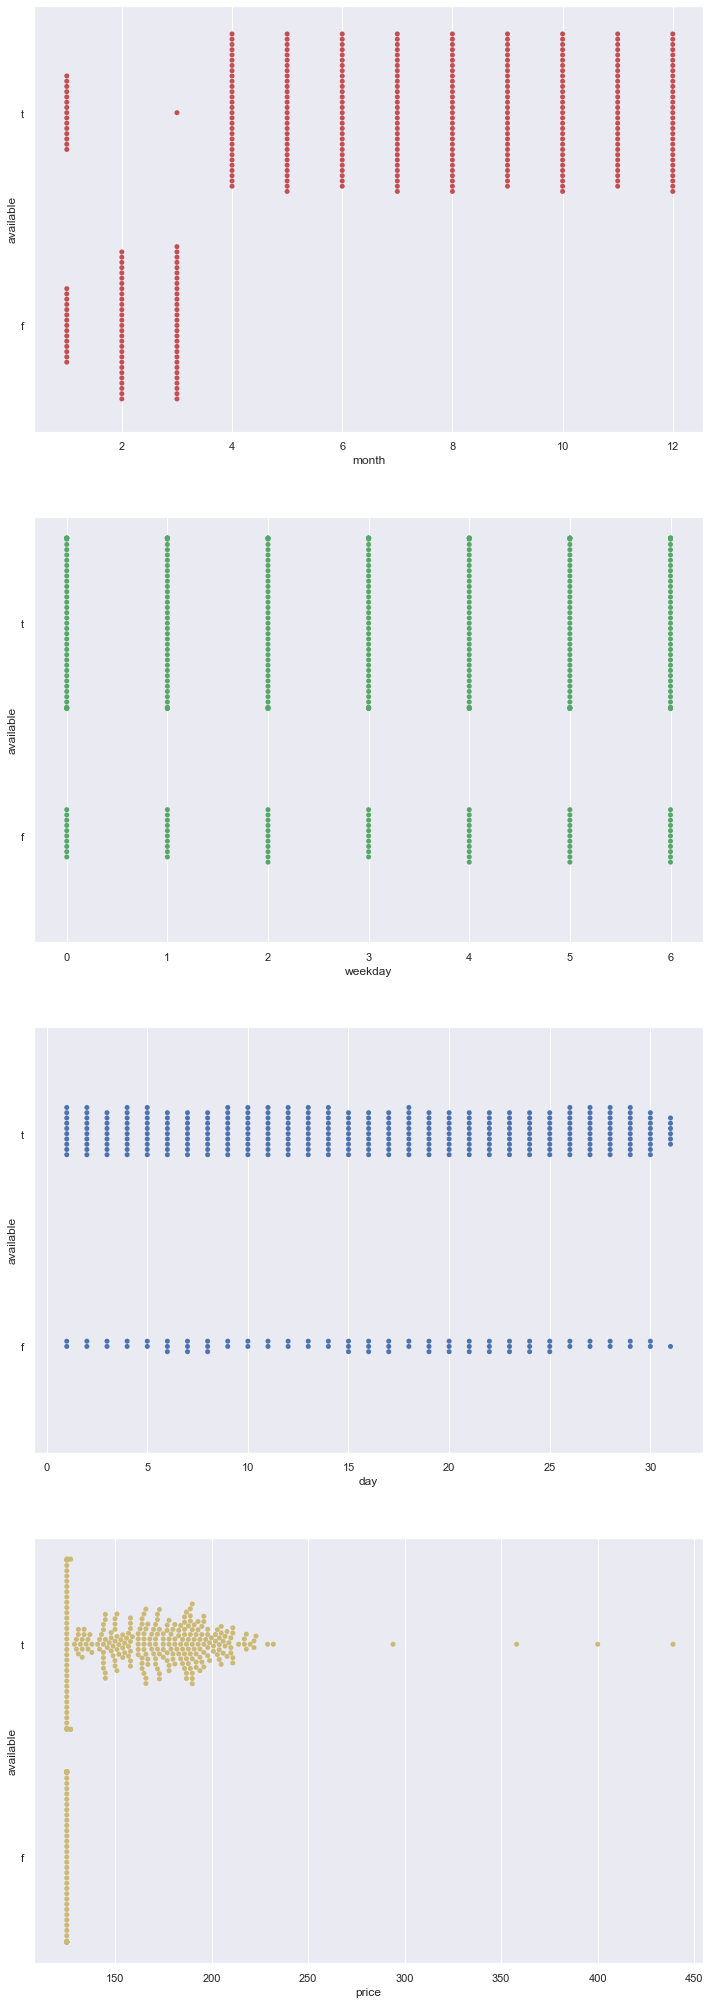

In [133]:
#Visualising each variable in predictors against 'available' with swarm plots
f, axes = plt.subplots(4, 1, figsize=(12, 36))
colors = ['r','g','b','y','m','c']
count=0
for var in predictors:
    sb.swarmplot(x = var, y = 'available', data = prediction_data, color = colors[count], ax = axes[count])
    count+=1

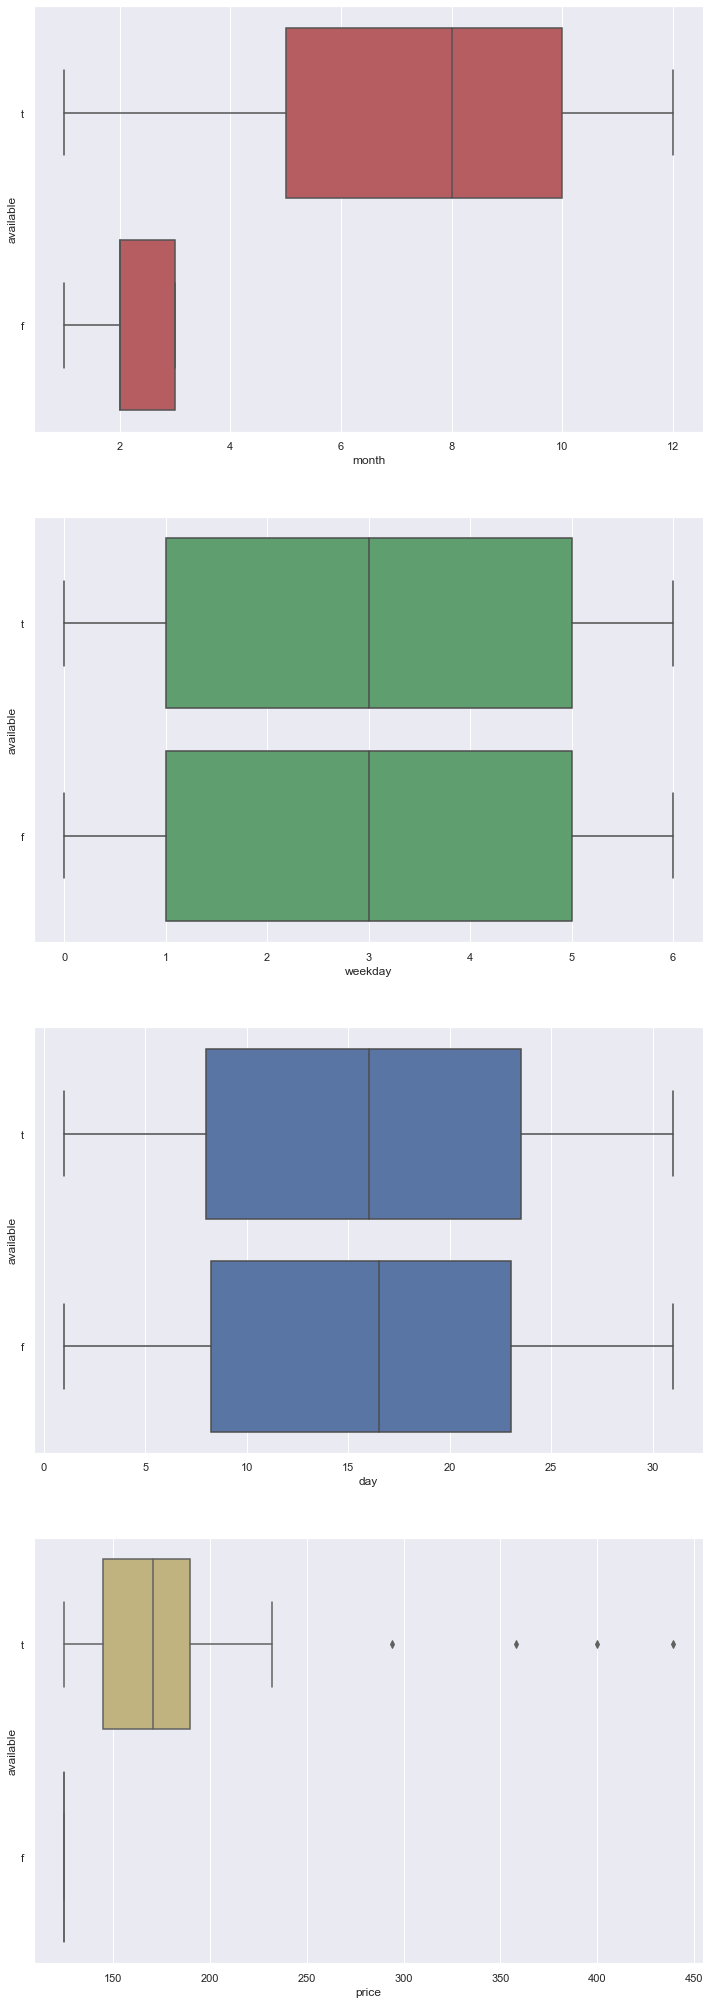

In [134]:
#Visualising each variable in predictors against 'available' with box plots
f, axes = plt.subplots(4, 1, figsize=(12, 36))
colors = ['r','g','b','y','m','c']
count=0
for var in predictors:
    sb.boxplot(x = var, y = 'available', data = prediction_data, color = colors[count], ax = axes[count])
    count+=1

For this listing, there is a clear segmentation of price and months across the values of 'available'. Thus, these variables could be used for decision tree classfier model to predict whether a listing would be booked or not.

# Prediction using classification

In [135]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
import graphviz
from sklearn.metrics import confusion_matrix

dectree = DecisionTreeClassifier(max_depth = 2)

prediction_data_train,prediction_data_test = train_test_split(prediction_data,test_size = 0.25)
print("Train Set :", prediction_data_train.shape)
print("Test Set  :", prediction_data_test.shape)



Train Set : (273, 5)
Test Set  : (92, 5)


Train Set:
Classification Accuracy: 0.9560439560439561
True positive rate: 0.9953917050691244 
False negative rate: 0.004608294930875576
True negative rate: 0.8035714285714286 
False positive rate: 0.19642857142857142

Test Set:
Classification Accuracy: 0.9565217391304348
True positive rate: 1.0 
False negative rate: 0.0
True negative rate: 0.7777777777777778 
False positive rate: 0.2222222222222222


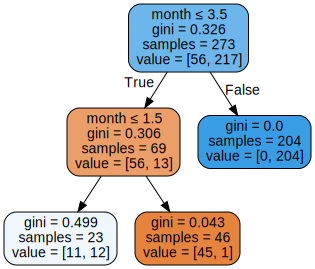

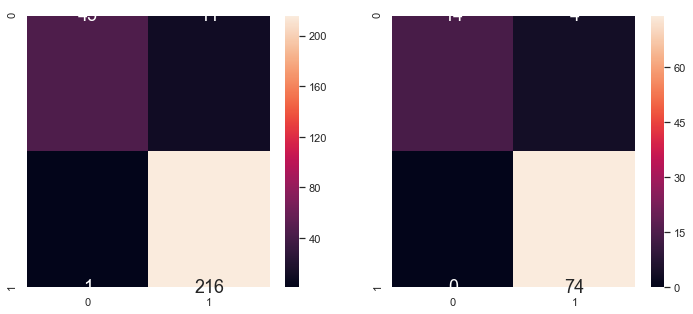

In [136]:
class_train = pd.DataFrame(prediction_data_train['available']);
num_train = pd.DataFrame(data = prediction_data_train, columns = ["month","weekday","day","price"]);
class_test = pd.DataFrame(prediction_data_test['available']);
num_test = pd.DataFrame(data = prediction_data_test, columns = ["month","weekday","day","price"]);

dectree.fit(num_train,class_train)

class_train_pred = dectree.predict(num_train)
class_test_pred = dectree.predict(num_test)

f, axes = plt.subplots(1, 2, figsize=(12, 5))

#train set
#Classification Accuracy
print("Train Set:")
print("Classification Accuracy:", dectree.score(num_train, class_train))
tn, fp, fn, tp=confusion_matrix(class_train, class_train_pred).ravel()
print("True positive rate:",(tp/(tp+fn)),"\nFalse negative rate:",(fn/(tp+fn)))
print("True negative rate:",(tn/(tn+fp)),"\nFalse positive rate:",(fp/(tn+fp)))

#two-way Confusion Matrix
sb.heatmap(confusion_matrix(class_train, class_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18},ax = axes[0])

#test set
#Classification Accuracy
print()
print("Test Set:")
print("Classification Accuracy:", dectree.score(num_test, class_test))

tn, fp, fn, tp=confusion_matrix(class_test, class_test_pred).ravel()
print("True positive rate:",(tp/(tp+fn)),"\nFalse negative rate:",(fn/(tp+fn)))
print("True negative rate:",(tn/(tn+fp)),"\nFalse positive rate:",(fp/(tn+fp)))
    
#two-way Confusion Matrix
sb.heatmap(confusion_matrix(class_test, class_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18},ax = axes[1])

treedot = export_graphviz(dectree,                                     
                          feature_names = num_train.columns,            
                          out_file = None,                           
                          filled = True,                           
                          rounded = True,                              
                          special_characters = True)                    

graphviz.Source(treedot)

In [137]:
prediction_data_test_copy = prediction_data_test
class_test_pred_df=pd.DataFrame(class_test_pred)
class_test_pred_df=class_test_pred_df.rename(columns={0:"predicted"})
array = np.arange(0,prediction_data_test.shape[0],1)
prediction_data_test_copy.insert(0,"index",array,True)
prediction_data_test_copy=prediction_data_test_copy.join(class_test_pred_df,on="index")
print("Predicted availability for a particular listing")
prediction_data_test_copy

Predicted availability for a particular listing


index  month  weekday  day  price available predicted
366      0      1        1    5  125.0         t         t
374      1      1        2   13  125.0         t         t
468      2      4        5   16  165.0         t         t
727      3     12        5   31  358.0         t         t
719      4     12        4   23  217.0         t         t
..     ...    ...      ...  ...    ...       ...       ...
644     87     10        6    9  142.0         t         t
470     88      4        0   18  145.0         t         t
559     89      7        5   16  208.0         t         t
429     90      3        1    8  125.0         f         f
547     91      7        0    4  185.0         t         t

[92 rows x 7 columns]

The likelihood of a a particular listing being booked could be predicted by price and month. The prediction is relatively accurate as classification accuracy, true positive and true negative rates are high. This model can be extended to all listings and could be accurate in predicting whether a listing would be booked ('available'=f) or not ('available'=t)

# Further data preparation and cleaning

In [138]:
#getting the number of available and non-avaialble
df_calendar.available.value_counts()

t    934542
f    459028
Name: available, dtype: int64

In [139]:
# convert 'available' into binary
df_calendar['available'] = df_calendar['available'].map(lambda available: 1 if available == 't' else 0)

In [140]:
df_calendar.head()

listing_id        date  available  price  year  month  day  weekday  \
0      241032  2016-01-04          1   85.0  2016      1    4        0   
1      241032  2016-01-05          1   85.0  2016      1    5        1   
2      241032  2016-01-06          0   85.0  2016      1    6        2   
3      241032  2016-01-07          0   85.0  2016      1    7        3   
4      241032  2016-01-08          0   85.0  2016      1    8        4   

   week_number  
0            1  
1            1  
2            1  
3            1  
4            1

In [141]:
# Modify df_listing
df_listing.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

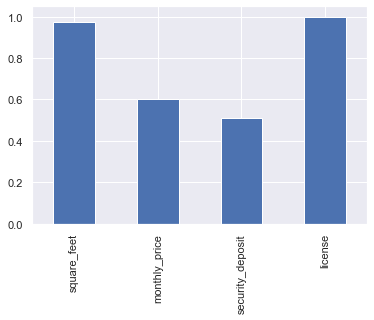

In [142]:
#finding the columns consisting of missing values over 50%
df_missing = df_listing.isna().mean()
df_missing[df_missing>0.5].plot.bar()

In [143]:
#Assume that columns with more than 50% missing values are outliers
#so extract them and drop them from the data frame
#extract the columns with more than 50% missing values Out of
#getting the length
len(df_listing.columns)

92

In [144]:
#droped the columns consisting of missing values over 50%
df_listing.drop(['square_feet', 'monthly_price', 'security_deposit', 'license' ], axis=1, inplace=True) 

In [145]:
#getting new length
len(df_listing.columns)

88

In [146]:
df_listing.head()

id                           listing_url       scrape_id last_scraped  \
0   241032   https://www.airbnb.com/rooms/241032  20160104002432   2016-01-04   
1   953595   https://www.airbnb.com/rooms/953595  20160104002432   2016-01-04   
2  3308979  https://www.airbnb.com/rooms/3308979  20160104002432   2016-01-04   
3  7421966  https://www.airbnb.com/rooms/7421966  20160104002432   2016-01-04   
4   278830   https://www.airbnb.com/rooms/278830  20160104002432   2016-01-04   

                                  name  \
0         Stylish Queen Anne Apartment   
1   Bright & Airy Queen Anne Apartment   
2  New Modern House-Amazing water view   
3                   Queen Anne Chateau   
4       Charming craftsman 3 bdm house   

                                             summary  \
0                                                NaN   
1  Chemically sensitive? We've removed the irrita...   
2  New modern house built in 2013.  Spectacular s...   
3  A charming apartment that sits atop Queen Anne...   
4  Cozy family craftman house in beautiful neighb...   

                                               space  \
0  Make your self at home in this charming one-be...   
1  Beautiful, hypoallergenic apartment in an extr...   
2  Our house is modern, light and fresh with a wa...   
3                                                NaN   
4  Cozy family craftman house in beautiful neighb...   

                                         description experiences_offered  \
0  Make your self at home in this charming one-be...                none   
1  Chemically sensitive? We've removed the irrita...                none   
2  New modern house built in 2013.  Spectacular s...                none   
3  A charming apartment that sits atop Queen Anne...                none   
4  Cozy family craftman house in beautiful neighb...                none   

                               neighborhood_overview  ...  \
0                                                NaN  ...   
1  Queen Anne is a wonderful, truly functional vi...  ...   
2  Upper Queen Anne is a charming neighborhood fu...  ...   
3                                                NaN  ...   
4  We are in the beautiful neighborhood of Queen ...  ...   

  review_scores_location review_scores_value requires_license  \
0                    9.0                10.0                f   
1                   10.0                10.0                f   
2                   10.0                10.0                f   
3                    NaN                 NaN                f   
4                    9.0                 9.0                f   

  jurisdiction_names instant_bookable cancellation_policy  \
0         WASHINGTON                f            moderate   
1         WASHINGTON                f              strict   
2         WASHINGTON                f              strict   
3         WASHINGTON                f            flexible   
4         WASHINGTON                f              strict   

   require_guest_profile_picture require_guest_phone_verification  \
0                              f                                f   
1                              t                                t   
2                              f                                f   
3                              f                                f   
4                              f                                f   

  calculated_host_listings_count reviews_per_month  
0                              2              4.07  
1                              6              1.48  
2                              2              1.15  
3                              1               NaN  
4                              1              0.89  

[5 rows x 88 columns]

In [147]:
#find columns consisting urls as the url's directs to the home page wich is not very useful.
row = df_listing.iloc[0,:]
row

id                                                               241032
listing_url                         https://www.airbnb.com/rooms/241032
scrape_id                                                20160104002432
last_scraped                                                 2016-01-04
name                                       Stylish Queen Anne Apartment
                                                   ...                 
cancellation_policy                                            moderate
require_guest_profile_picture                                         f
require_guest_phone_verification                                      f
calculated_host_listings_count                                        2
reviews_per_month                                                  4.07
Name: 0, Length: 88, dtype: object

In [148]:
#dropped the columns consist urls as url's
df_listing.drop(['host_picture_url', 'host_thumbnail_url', 'host_url', 'picture_url', 'listing_url'], axis=1, inplace=True)

In [149]:
df_listing.drop(['xl_picture_url', 'medium_url','thumbnail_url'], axis=1, inplace=True) 

In [150]:
#getting new length
len(df_listing.columns)

80

In [151]:
# remove characters in "cleaning fee" and convert it to float to easy analysis.
df_listing['cleaning_fee'] = df_listing.cleaning_fee.str.replace('$','').astype(float)
#removing characters in "host acceptance rate" convert it to float to easy analysis
df_listing['host_acceptance_rate'] = df_listing.host_acceptance_rate.str.replace('%','').astype(float)

In [152]:
df_listing_object= df_listing.select_dtypes(include=['object'])
df_listing_object.columns

Index(['last_scraped', 'name', 'summary', 'space', 'description',
       'experiences_offered', 'neighborhood_overview', 'notes', 'transit',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_is_superhost',
       'host_neighbourhood', 'host_verifications', 'host_has_profile_pic',
       'host_identity_verified', 'street', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city',
       'state', 'zipcode', 'market', 'smart_location', 'country_code',
       'country', 'is_location_exact', 'property_type', 'room_type',
       'bed_type', 'amenities', 'price', 'weekly_price', 'extra_people',
       'calendar_updated', 'has_availability', 'calendar_last_scraped',
       'first_review', 'last_review', 'requires_license', 'jurisdiction_names',
       'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification'],
      dtype='object')

In [153]:
df_listing_object.isnull().sum()

last_scraped                           0
name                                   0
summary                              177
space                                569
description                            0
experiences_offered                    0
neighborhood_overview               1032
notes                               1606
transit                              934
host_name                              2
host_since                             2
host_location                          8
host_about                           859
host_response_time                   523
host_response_rate                   523
host_is_superhost                      2
host_neighbourhood                   300
host_verifications                     0
host_has_profile_pic                   2
host_identity_verified                 2
street                                 0
neighbourhood                        416
neighbourhood_cleansed                 0
neighbourhood_group_cleansed           0
city            

In [154]:
lis = ['summary', 'space', 'neighborhood_overview', 'notes', 'transit','host_name', 'host_since', 'host_location', 'host_about','host_response_time', 'host_response_rate','host_is_superhost', 'host_neighbourhood','host_has_profile_pic', 'host_identity_verified','neighbourhood','zipcode','property_type','weekly_price', 'first_review', 'last_review']


for i in lis:
    
    df_listing_object[i].fillna(df_listing_object[i].mode()[0], inplace=True)
    

/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [155]:
df_listing_object.isnull().sum()

last_scraped                        0
name                                0
summary                             0
space                               0
description                         0
experiences_offered                 0
neighborhood_overview               0
notes                               0
transit                             0
host_name                           0
host_since                          0
host_location                       0
host_about                          0
host_response_time                  0
host_response_rate                  0
host_is_superhost                   0
host_neighbourhood                  0
host_verifications                  0
host_has_profile_pic                0
host_identity_verified              0
street                              0
neighbourhood                       0
neighbourhood_cleansed              0
neighbourhood_group_cleansed        0
city                                0
state                               0
zipcode     

In [156]:
df_listing_int_float = df_listing.select_dtypes(include=['int64', 'float64'])
df_listing_int_float.columns

Index(['id', 'scrape_id', 'host_id', 'host_acceptance_rate',
       'host_listings_count', 'host_total_listings_count', 'latitude',
       'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'cleaning_fee', 'guests_included', 'minimum_nights', 'maximum_nights',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'calculated_host_listings_count', 'reviews_per_month'],
      dtype='object')

In [157]:
df_listing_int_float.isnull().sum()

id                                   0
scrape_id                            0
host_id                              0
host_acceptance_rate               773
host_listings_count                  2
host_total_listings_count            2
latitude                             0
longitude                            0
accommodates                         0
bathrooms                           16
bedrooms                             6
beds                                 1
cleaning_fee                      1030
guests_included                      0
minimum_nights                       0
maximum_nights                       0
availability_30                      0
availability_60                      0
availability_90                      0
availability_365                     0
number_of_reviews                    0
review_scores_rating               647
review_scores_accuracy             658
review_scores_cleanliness          653
review_scores_checkin              658
review_scores_communicati

In [158]:
li=['host_acceptance_rate','host_listings_count','host_total_listings_count','reviews_per_month','review_scores_value','review_scores_location','review_scores_communication','review_scores_checkin',
    'review_scores_cleanliness','review_scores_accuracy','review_scores_rating','beds','bedrooms','bathrooms','cleaning_fee']
    
    # filling missing columns with their mean
for i in li:
    df_listing_int_float[i].fillna(df_listing_int_float[i].mean(), inplace=True)


#or    
#df_calendar.price_new = df_listing.cleaning_fee.transform(lambda x: x.fillna(x.mean()))

In [159]:
df_listing_int_float.isnull().sum()

id                                0
scrape_id                         0
host_id                           0
host_acceptance_rate              0
host_listings_count               0
host_total_listings_count         0
latitude                          0
longitude                         0
accommodates                      0
bathrooms                         0
bedrooms                          0
beds                              0
cleaning_fee                      0
guests_included                   0
minimum_nights                    0
maximum_nights                    0
availability_30                   0
availability_60                   0
availability_90                   0
availability_365                  0
number_of_reviews                 0
review_scores_rating              0
review_scores_accuracy            0
review_scores_cleanliness         0
review_scores_checkin             0
review_scores_communication       0
review_scores_location            0
review_scores_value         

In [160]:
df_listing.update(df_listing_int_float)

In [161]:
df_listing.update(df_listing_object)

In [162]:
df_listing.isnull().sum()

id                                  0
scrape_id                           0
last_scraped                        0
name                                0
summary                             0
                                   ..
cancellation_policy                 0
require_guest_profile_picture       0
require_guest_phone_verification    0
calculated_host_listings_count      0
reviews_per_month                   0
Length: 80, dtype: int64

In [163]:
df_listing.head()

id       scrape_id last_scraped                                 name  \
0   241032  20160104002432   2016-01-04         Stylish Queen Anne Apartment   
1   953595  20160104002432   2016-01-04   Bright & Airy Queen Anne Apartment   
2  3308979  20160104002432   2016-01-04  New Modern House-Amazing water view   
3  7421966  20160104002432   2016-01-04                   Queen Anne Chateau   
4   278830  20160104002432   2016-01-04       Charming craftsman 3 bdm house   

                                             summary  \
0  This is a modern fully-furnished studio apartm...   
1  Chemically sensitive? We've removed the irrita...   
2  New modern house built in 2013.  Spectacular s...   
3  A charming apartment that sits atop Queen Anne...   
4  Cozy family craftman house in beautiful neighb...   

                                               space  \
0  Make your self at home in this charming one-be...   
1  Beautiful, hypoallergenic apartment in an extr...   
2  Our house is modern, light and fresh with a wa...   
3  *Note: This fall, there will be major renovati...   
4  Cozy family craftman house in beautiful neighb...   

                                         description experiences_offered  \
0  Make your self at home in this charming one-be...                none   
1  Chemically sensitive? We've removed the irrita...                none   
2  New modern house built in 2013.  Spectacular s...                none   
3  A charming apartment that sits atop Queen Anne...                none   
4  Cozy family craftman house in beautiful neighb...                none   

                               neighborhood_overview  \
0  Wallingford is a mostly-residential neighborho...   
1  Queen Anne is a wonderful, truly functional vi...   
2  Upper Queen Anne is a charming neighborhood fu...   
3  Wallingford is a mostly-residential neighborho...   
4  We are in the beautiful neighborhood of Queen ...   

                                               notes  ...  \
0  All of our rentals are fully licensed and regu...  ...   
1  What's up with the free pillows?  Our home was...  ...   
2  Our house is located just 5 short blocks to To...  ...   
3  All of our rentals are fully licensed and regu...  ...   
4                                          Belltown   ...   

  review_scores_location  review_scores_value requires_license  \
0               9.000000            10.000000                f   
1              10.000000            10.000000                f   
2              10.000000            10.000000                f   
3               9.608916             9.452245                f   
4               9.000000             9.000000                f   

  jurisdiction_names instant_bookable cancellation_policy  \
0         WASHINGTON                f            moderate   
1         WASHINGTON                f              strict   
2         WASHINGTON                f              strict   
3         WASHINGTON                f            flexible   
4         WASHINGTON                f              strict   

  require_guest_profile_picture require_guest_phone_verification  \
0                             f                                f   
1                             t                                t   
2                             f                                f   
3                             f                                f   
4                             f                                f   

   calculated_host_listings_count reviews_per_month  
0                               2          4.070000  
1                               6          1.480000  
2                               2          1.150000  
3                               1          2.078919  
4                               1          0.890000  

[5 rows x 80 columns]

In [164]:
# Modify df_reviews
df_reviews.isnull().sum()

listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     0
comments         18
dtype: int64

In [165]:
# Filling missing values with '?' because the user might rate but not comment
df_reviews.comments.fillna('?', inplace=True)

In [166]:
df_reviews.isnull().sum()

listing_id       0
id               0
date             0
reviewer_id      0
reviewer_name    0
comments         0
dtype: int64

### Idenfication of potential seasonal pattern in occupancy rate: Time series of occupancy rate

In [167]:
#finding the seasonal pattern
def timeplot(data, feat, title):
    plt.figure(figsize=(20,8))
    x = [datetime.strptime(date, '%Y-%m-%d') for date in data.index]
    y = data[feat]
    # smooth y for visualization
    y_smooth = gaussian_filter1d(y, sigma=5)
    # set x tick by month
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.title(title)
    plt.plot(x, y_smooth, 'c-')
    plt.show()

In [168]:
#getting occupancy rate
ocp = df_calendar[['date', 'available']].groupby('date').mean()
ocp['occupancy'] = 1 - ocp['available']
ocp.head()

available  occupancy
date                            
2016-01-04   0.454426   0.545574
2016-01-05   0.488999   0.511001
2016-01-06   0.478261   0.521739
2016-01-07   0.465165   0.534835
2016-01-08   0.466737   0.533263

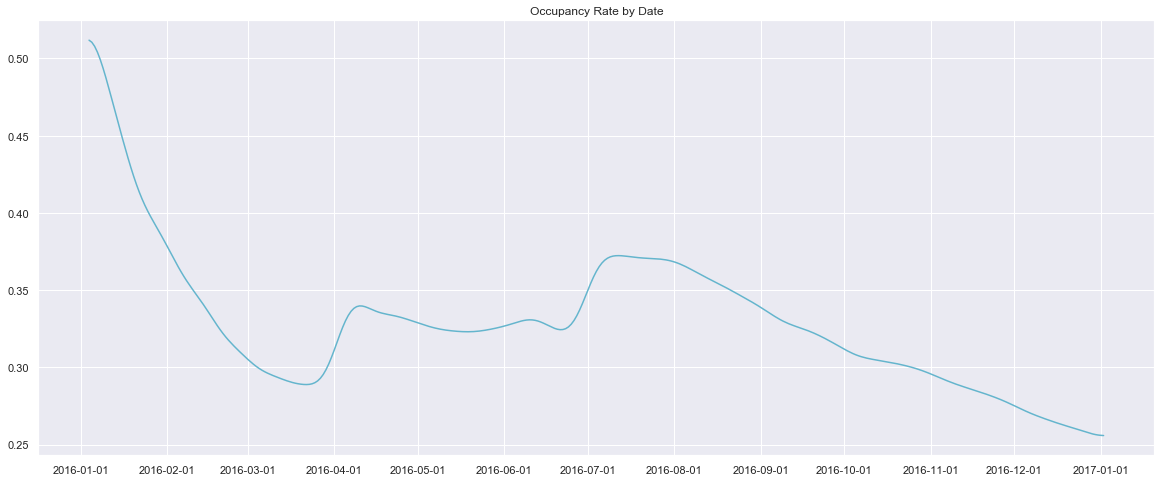

In [169]:
timeplot(ocp, 'occupancy', 'Occupancy Rate by Date')

The highest occupancy rate is in January 2016, and decreasing rapidly from 50% to 30% in 2 months. Then, it goes up slightly in the start of April and in the start of July separately. After that, it declines continuously. It seems that spring and summer are the busy season. The best weather in Seattle is from late June to early September. And, in fact, there is a peak during that time. However, it is weird to see the highest occupancy rate is in January 2016. These might be because any festivals or lower price 

In [170]:
pmedian = df_calendar[['date', 'price']].groupby('date').median()

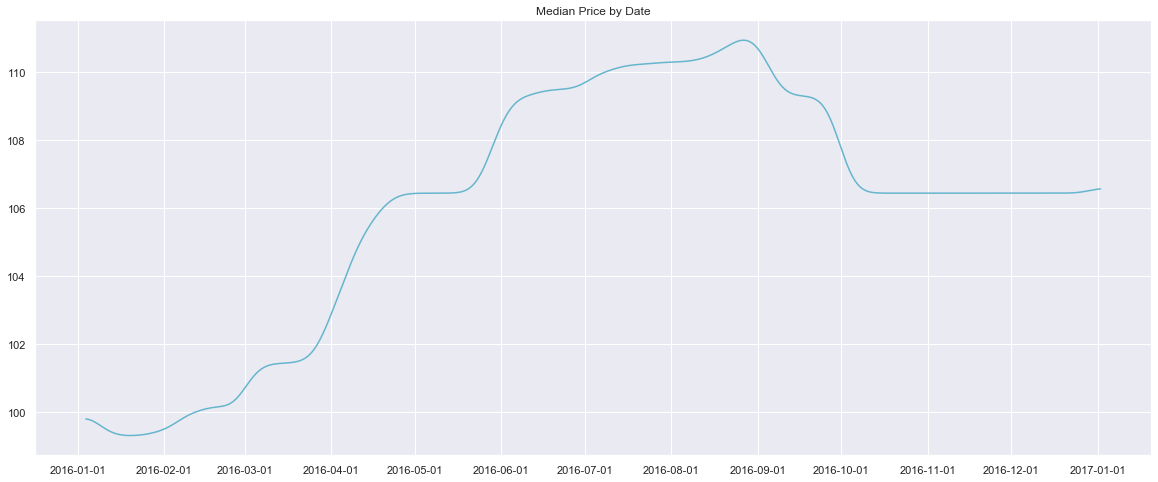

In [171]:
timeplot(pmedian, 'price', 'Median Price by Date')

The rental price are higher from May to September and weathers are usually good during that time. Thus, it makes sense that rental price in Rainy Day is cheaper. In addition, the cheapest price is in in January 2016. It could be a reason for high occupancy. Thus, a listing has higher likihood of being book during the season where weather is good.

### Using Ridge Regression to estimate the likelihood of booking in year 2017

In [172]:
#finding the monthly vistors for the year 2016
df_calendar = df_calendar.dropna()
dates = df_calendar['date']
price = df_calendar['price']

year_date = {date: 0 for date in set(dates)}
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 
         'October', 'November', 'December', 'January']

for date in dates:
    year_date[date] += 1

# empty array to be filled with the monthly visitors per month
monthly_visitors = np.zeros(12)
    
for date in year_date:
    monthly_visitors[int(date.split('-')[1]) - 1] += year_date[date]

monthly_visitors = [int(visitors) for visitors in monthly_visitors]

for i, month in enumerate(monthly_visitors):
    print("Monthly visitors for {:10s} : {:10d}".format( months[i], month))
print(44*"-")
print("Mean monthly visitors for 2016  :      " + str(int(np.mean(monthly_visitors))))

Monthly visitors for January    :     114540
Monthly visitors for February   :     110722
Monthly visitors for March      :     118358
Monthly visitors for April      :     114540
Monthly visitors for May        :     118358
Monthly visitors for June       :     114540
Monthly visitors for July       :     118358
Monthly visitors for August     :     118358
Monthly visitors for September  :     114540
Monthly visitors for October    :     118358
Monthly visitors for November   :     114540
Monthly visitors for December   :     118358
--------------------------------------------
Mean monthly visitors for 2016  :      116130


5 degree Polynomial Ridge Regression
Coefficients and Intercept of the Linear Regression: 

Y = [0.0, 78.85, 202.68, -48.71, 1.02, 0.13]X + 118153.86
Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.942661531666078
Mean Squared Error (MSE) 	: 208957.49071841355

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: -0.8277695010312094
Mean Squared Error (MSE) 	: 18317490.57871567



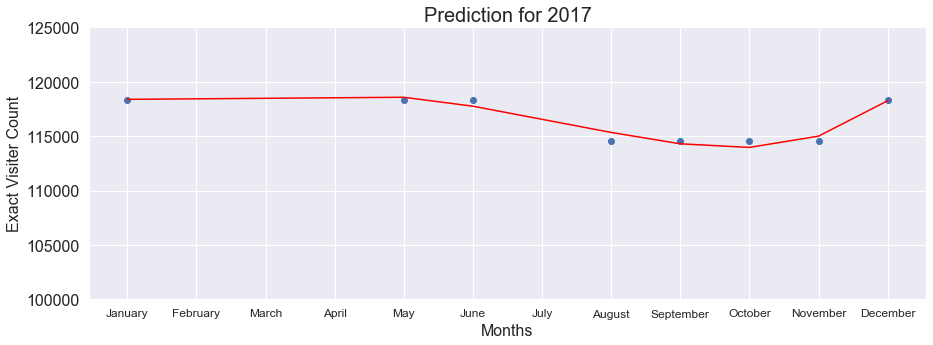

In [173]:
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
#create copies for calculating cross_val_score
y = np.array(monthly_visitors)
y_copy = y
X = np.array(np.arange(1, 13))
X_copy = X

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)

X_train=np.sort(X_train)
X_test=np.sort(X_test)

# Polynomial Regression expects a third dimension like the Neural Network (x, y, 1)
X = X_train[:, np.newaxis]
y = y_train[:, np.newaxis]
X_test = X_test[:, np.newaxis]
y_test = y_test[:, np.newaxis]

# Fit the Polynomial Regression
polynomial_features= PolynomialFeatures(degree=5)
x_poly = polynomial_features.fit_transform(X)
x_poly_test = polynomial_features.fit_transform(X_test)

# Fit the Linear Regression
rr = linear_model.Ridge()
rr.fit(x_poly, y)

# Predict all months in 2017
y_poly_pred = rr.predict(x_poly)
y_poly_pred_test = rr.predict(x_poly_test)

print("5 degree Polynomial Ridge Regression")
print("Coefficients and Intercept of the Linear Regression: \n")
print("Y = " + str([round(x,2) for x in rr.coef_[0]]) + "X + "+ str(round(rr.intercept_[0], 2)))

from sklearn.metrics import mean_squared_error

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", rr.score(x_poly, y))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y, y_poly_pred))
print()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", rr.score(x_poly_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_poly_pred_test))
print()

#Find increase in mse from train set to test set.
mse_decrease = []
mse_decrease.append((mean_squared_error(y_test, y_poly_pred_test)- mean_squared_error(y, y_poly_pred))/ mean_squared_error(y, y_poly_pred))

plt.figure(figsize=(15,5))
plt.scatter(X, y)
plt.plot(X, y_poly_pred, color="red")
plt.title("Prediction for 2017", fontsize=20)
plt.xlabel("Months", fontsize=16)
plt.ylabel("Exact Visiter Count", fontsize=16)
plt.yticks(np.arange(100000, 130000, 5000), fontsize=16)
plt.xticks(np.arange(1, 13), months, fontsize=12)
plt.show()

# Check value of explained variance for test and train over 10 iterations
R2_list = []
R2_list_test = []
num_iterations = 10

for i in range(0,num_iterations):
    y = np.array(monthly_visitors)
    X = np.array(np.arange(1, 13))
    # Split the Dataset into Train and Test
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)
    X_train=np.sort(X_train)
    X_test=np.sort(X_test)

    # Polynomial Regression expects a third dimension like the Neural Network (x, y, 1)
    X = X_train[:, np.newaxis]
    y = y_train[:, np.newaxis]
    X_test = X_test[:, np.newaxis]
    y_test = y_test[:, np.newaxis]
    
    # train the linear regression model
    x_poly = polynomial_features.fit_transform(X)
    x_poly_test = polynomial_features.fit_transform(X_test)
    rr.fit(x_poly, y)
    
    # Predict Response corresponding to Predictors
    y_poly_pred = rr.predict(x_poly)
    y_poly_pred_test = rr.predict(x_poly_test)
                           
    R2_list.append(rr.score(x_poly, y))
    R2_list_test.append(rr.score(x_poly_test, y_test))

In [174]:
X_copy = X_copy[:, np.newaxis]
y_copy = y_copy[:, np.newaxis]
X_copy = polynomial_features.fit_transform(X_copy)
clf = svm.SVC(kernel='linear', C=1)
#source: https://scikit-learn.org/stable/modules/cross_validation.html
#Determine performance of model using cross_val_score
scores = cross_val_score(rr, X_copy, y_copy, cv=5)
print("Explained Variance :%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#The ridge regression model has low performance for predicting exact visitor count,\
#partly because of the small number of datapoints (12 data points for 12 months)

Explained Variance :-12.44 (+/- 47.18)


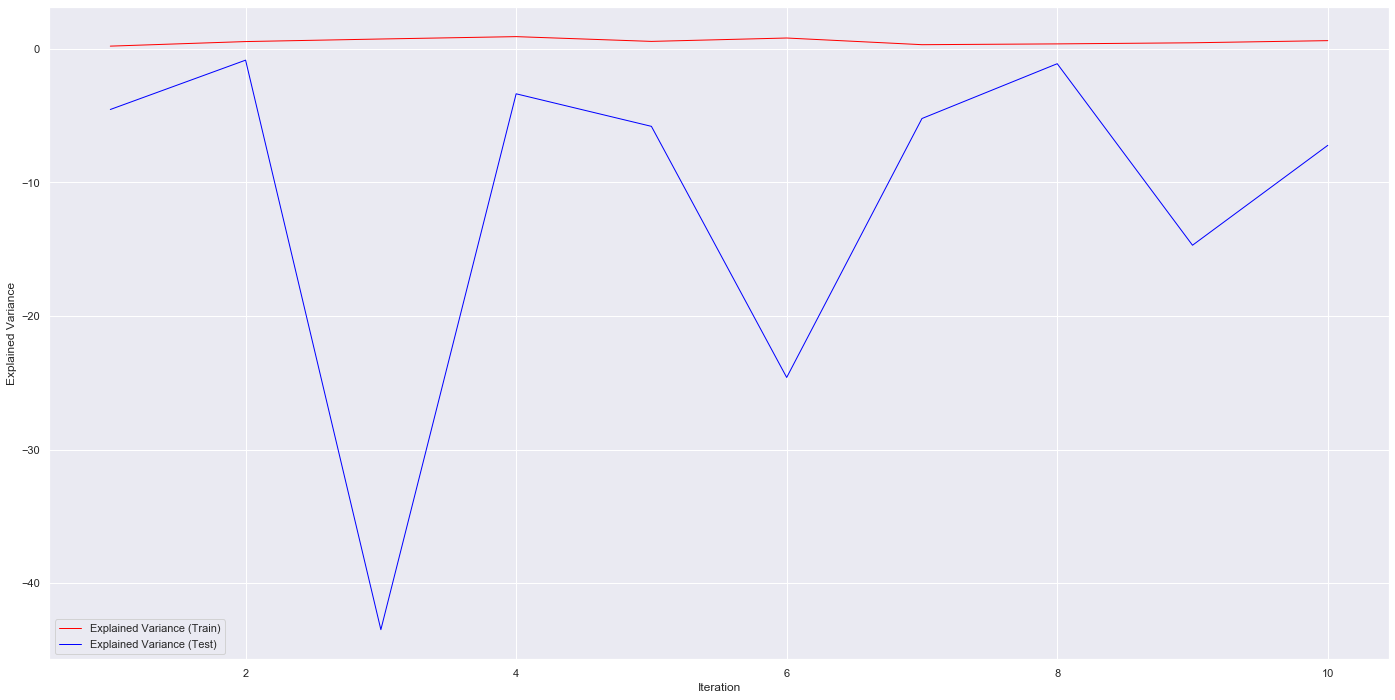

Explained Variance:
Train: 0.20213998148288714 Test: -4.540276851884844
Explained Variance:
Train: 0.5434746273153548 Test: -0.8470655086524146
Explained Variance:
Train: 0.735673603725817 Test: -43.47160741016653
Explained Variance:
Train: 0.9131545673195095 Test: -3.365908729690442
Explained Variance:
Train: 0.556457950140526 Test: -5.801800111403826
Explained Variance:
Train: 0.8095846085528331 Test: -24.59608477144177
Explained Variance:
Train: 0.3105546350726359 Test: -5.21549496876319
Explained Variance:
Train: 0.36988380859269776 Test: -1.1136275561956732
Explained Variance:
Train: 0.45295914650409996 Test: -14.700070483762872
Explained Variance:
Train: 0.6129526658787594 Test: -7.223592754224047


In [175]:
# Check accuracy of model based on values of explained variance for test and train over 10 iterations
f, axes = plt.subplots(1, 1, figsize=(24, 12))
axes.plot(np.array(np.arange(1,num_iterations+1)), R2_list, 'w-', linewidth = 1, color = "red",label = "Explained Variance (Train)")
axes.set_xlabel("Iteration")
axes.set_ylabel("Explained Variance")
axes.plot(np.array(np.arange(1,num_iterations+1)), R2_list_test, 'w-', linewidth = 1,color = "blue",label = 'Explained Variance (Test)')
axes.legend(loc="upper left")
axes.legend()
plt.show()

for i in range(num_iterations):
    print("Explained Variance:")
    print("Train:",R2_list[i] , "Test:",R2_list_test[i])

Based on this, we can infer that the likelihood of booking will be higher in months like January, July, August. The low cross validation score may be due to a small dataset being used (12 data points for 12 months). Although the explained variance can be low sometimes, models with moderately valued explained variance can be fitted. Thus, the ridge model can also be a suitable model to predict number of vistors and hence, the likelihood of bookings.

### What are the features that may affect popularity / likelihood of a listing being booked?

In [176]:
ocp = df_calendar[['listing_id', 'available']].groupby('listing_id').mean()
ocp['occupancy'] = 1 - ocp['available']
ocp.drop(['available'], axis = 1, inplace=True)
ocp['id'] = ocp.index

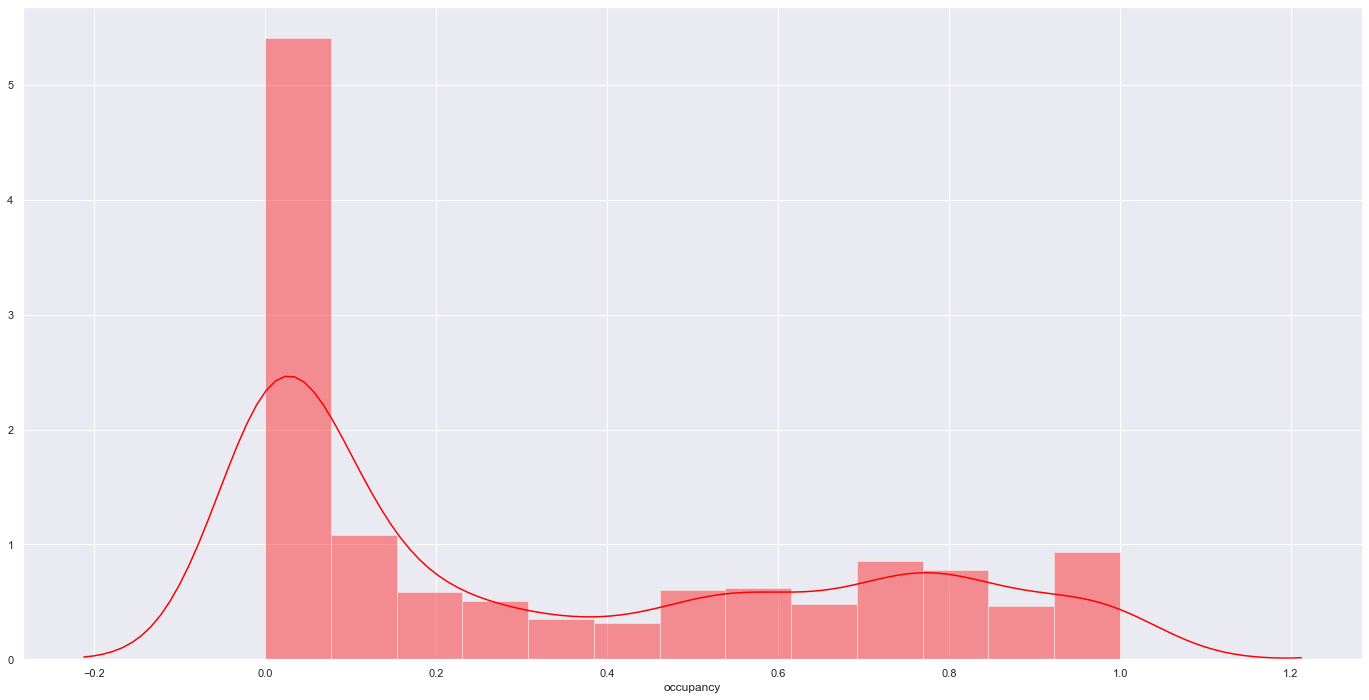

In [177]:
#plotting graph for occupancy rate
f, axes = plt.subplots(1, 1, figsize=(24, 12))
sb.distplot(ocp['occupancy'], color = "red")

In [178]:
threshold = 0.7
data = pd.merge(ocp, df_listing, how='inner', left_on='id', right_on='id')

In [179]:
# plot to compare feature of popular and unpopular homes using occupancy rate

def comparePlot(feat):
    
    plt.figure(figsize=(24,12))
        
    # if not float, draw bar plot
    if (data[feat].dtype != np.float):
        # build a tempary DataFrame for using seaborn easily
        # includes 3 columns: occupancy, popularity and index
        cnt_popular = data[data['occupancy'] >= threshold][feat].value_counts()
        cnt_unpopular = data[data['occupancy'] < threshold][feat].value_counts()
        fre_popular = pd.DataFrame((cnt_popular / cnt_popular.sum()))
        fre_popular['popularity'] = 'Popular'
        fre_popular['index'] = fre_popular.index
        fre_unpopular = pd.DataFrame(cnt_unpopular / cnt_unpopular.sum())
        fre_unpopular['popularity'] = 'Unpopular'
        fre_unpopular['index'] = fre_unpopular.index
        
        plot_data = pd.concat([fre_popular, fre_unpopular], ignore_index=True)
        sb.barplot(x='index', y=feat, hue='popularity', data=plot_data, palette='GnBu')
        plt.xticks(rotation='vertical')
        plt.legend(loc=1)
    
    # if float, draw kde line
    else:
        sb.kdeplot(data[feat][data['occupancy'] >= threshold], color='m')
        sb.kdeplot(data[feat][data['occupancy'] < threshold], color='c')
        plt.legend(['Popular', 'Unpopular'], loc=1)
    
    plt.xlabel(feat)
    plt.ylabel('Frequency')
    
    plt.show()

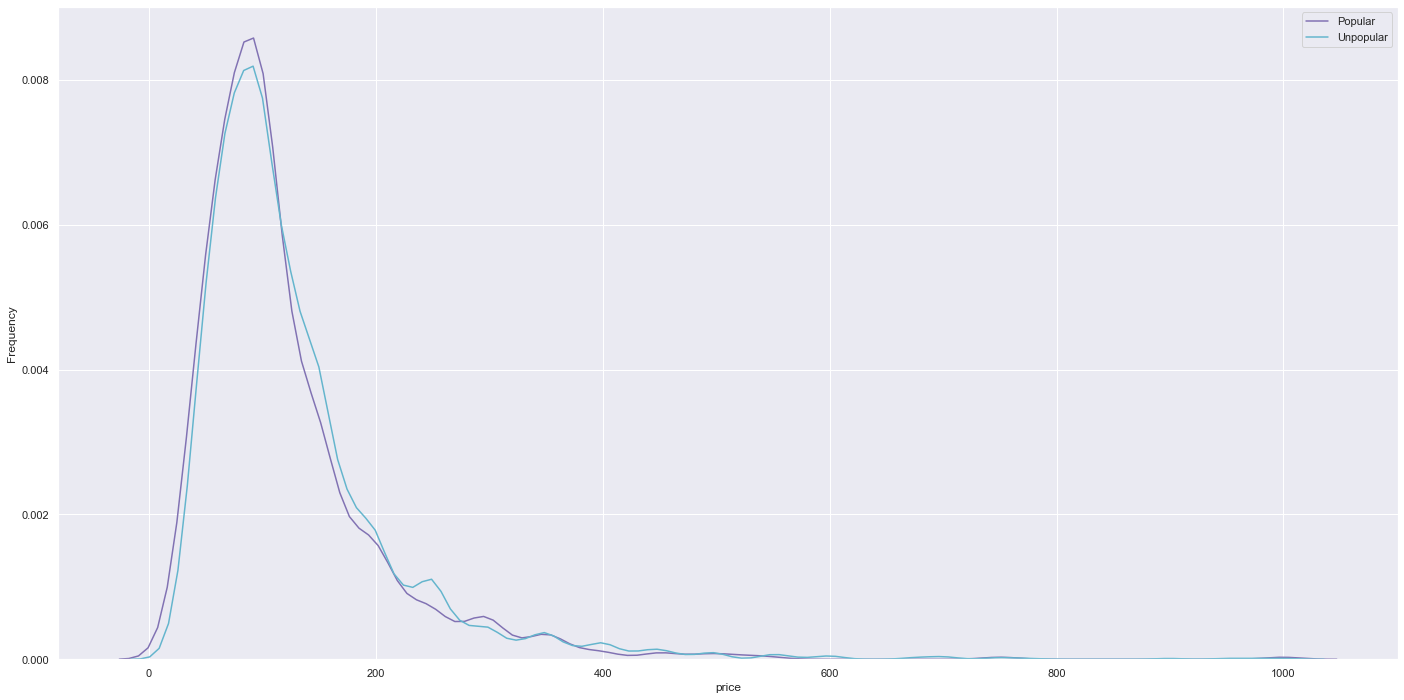

In [180]:
data['price'] = data['price'].map(lambda price: float(price[1:].replace(',', '')), na_action='ignore')
comparePlot('price')

This shows that popular rooms have slightly cheaper prices than unpopular rooms

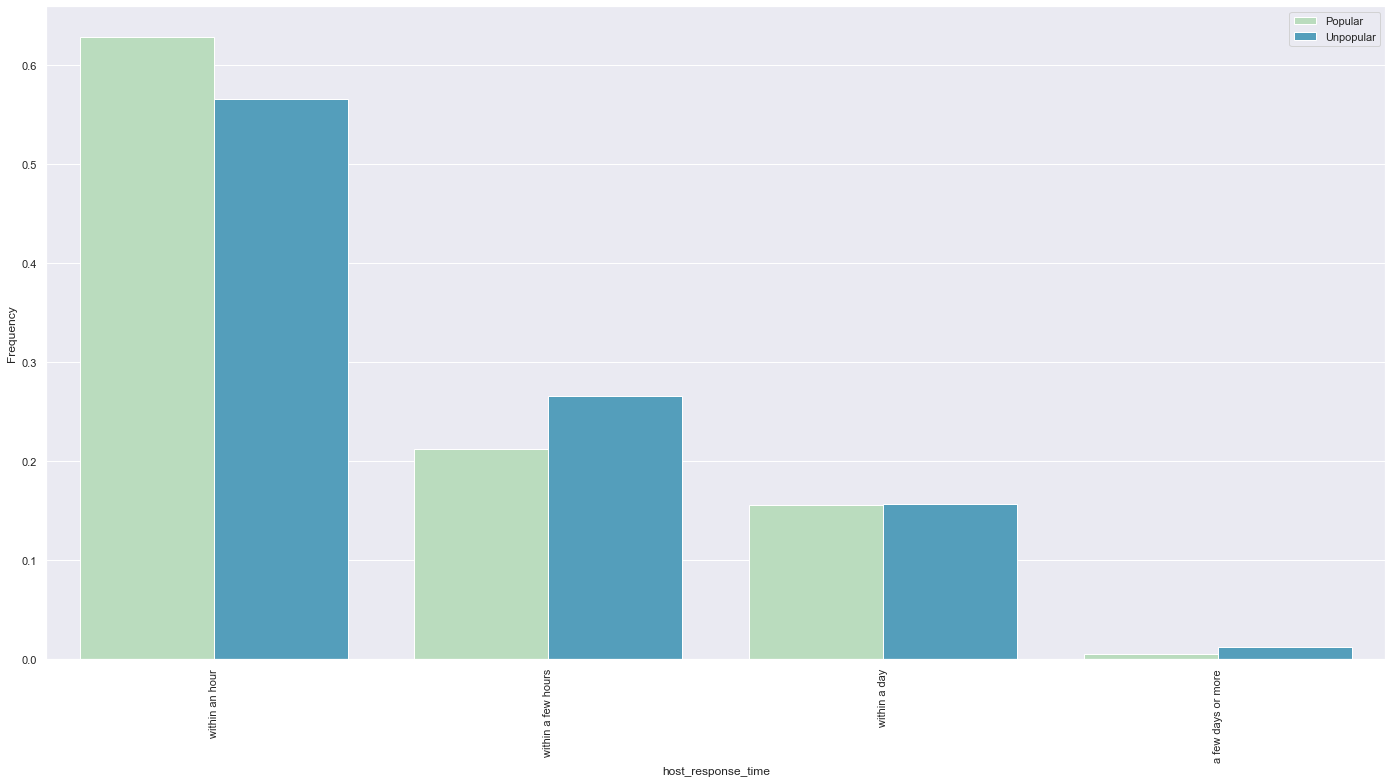

In [181]:
#plot graph regarding host_response time
comparePlot('host_response_time')

Only for listings with 'host_response_time' of 'within an hour', the frequency of popular listings is higher than that of unpopular listings. This suggests that hosts who respond faster have higher chance to rent out their listings.

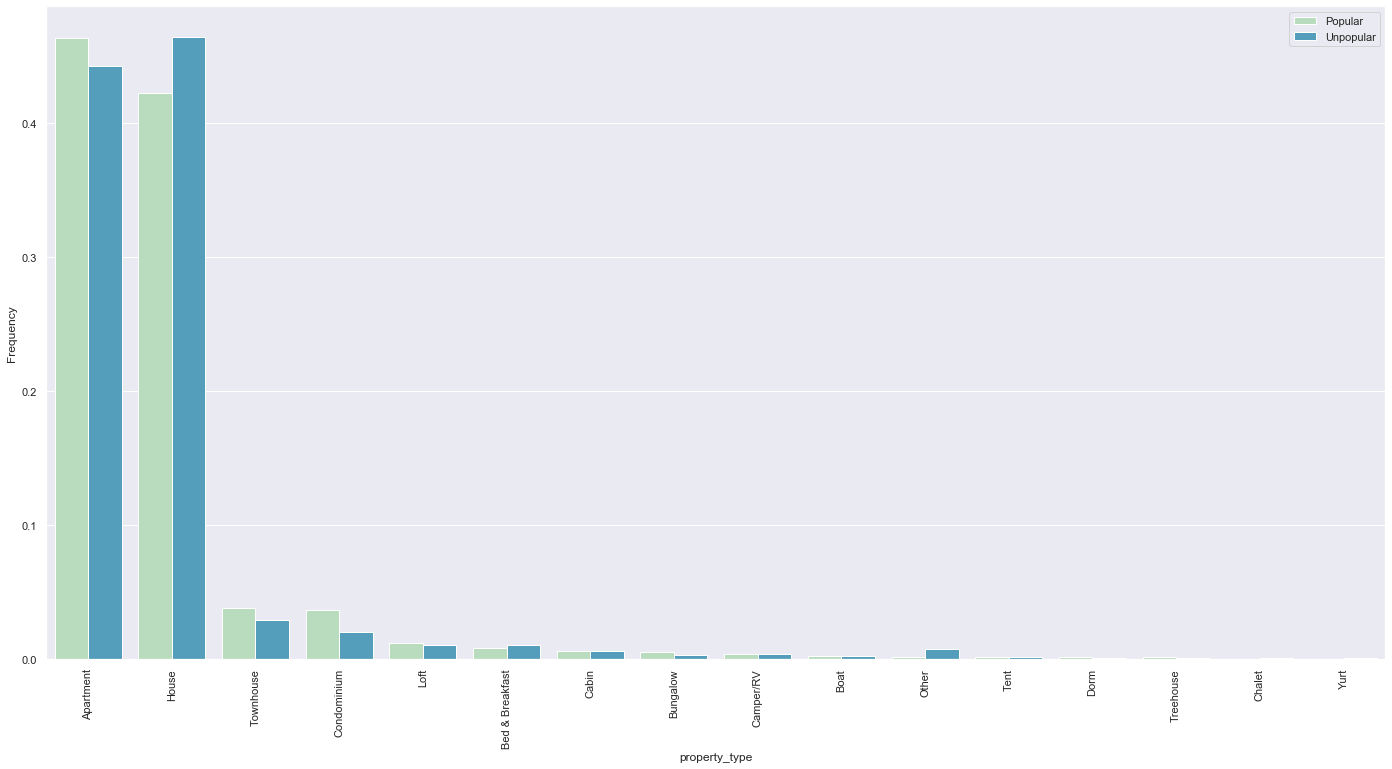

In [182]:
#plot graph regarding property_type
comparePlot('property_type')

This shows that houses may not be as popular as apartment

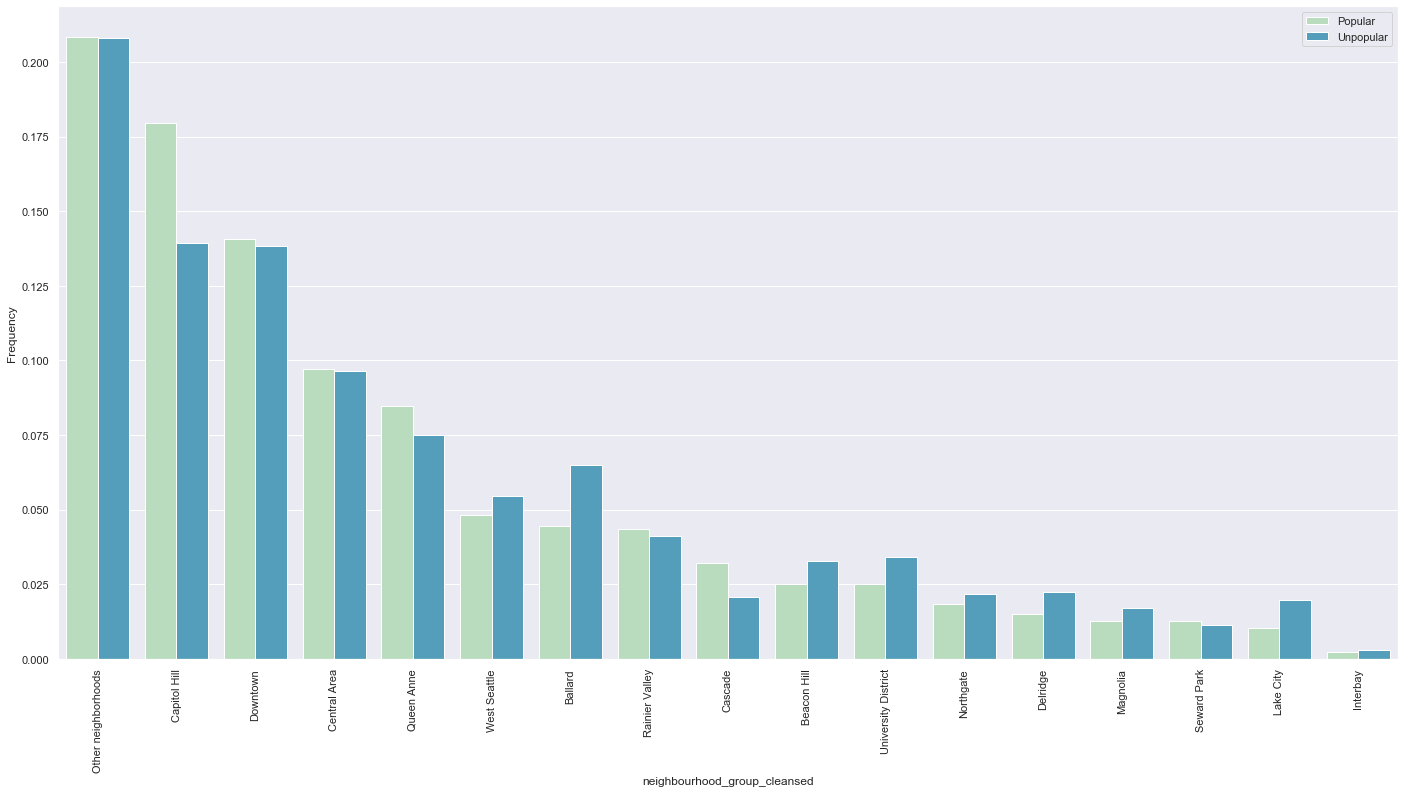

In [183]:
#plot graph regarding neighbourhood_group_cleanse
comparePlot('neighbourhood_group_cleansed')

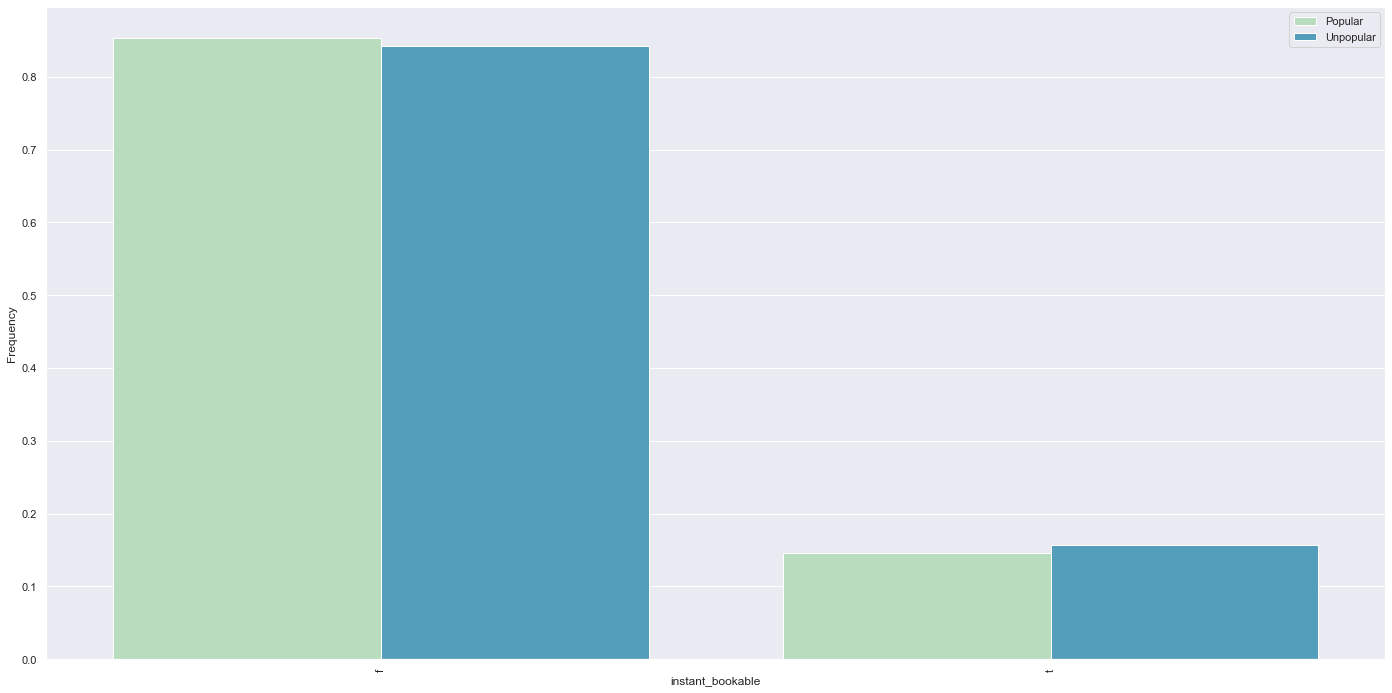

In [184]:
#plot graph regarding instant_bookable
comparePlot('instant_bookable')

This shows that whether or not a listing is instant bookable does not really affect the popularity 

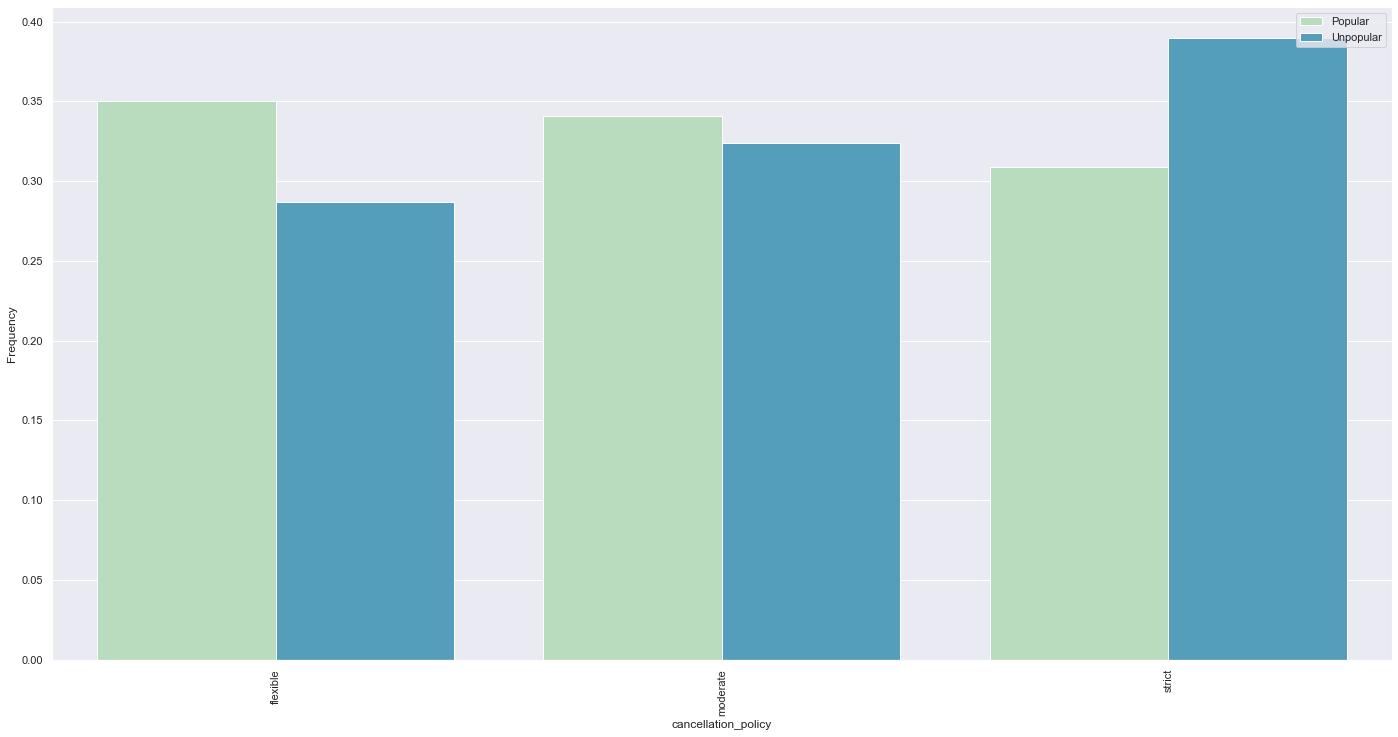

In [185]:
#plot graph regarding cancellation_policy
comparePlot('cancellation_policy')

Listings with 'flexible' and 'moderate' cancellation_policy have higher relative frequency of popular listings to unpopular listings, suggesting that listings with more flexible cancellation policy are more popular.

In [186]:
#replace the t/f in available column with 1/0
df_calendar.loc[df_calendar['available']=='t','available']=1
df_calendar.loc[df_calendar['available']=='f','available']=0

# calculate each listing's booked_persent in 2016
listing_booking=pd.pivot_table(df_calendar,index=['listing_id'],values=['available'],aggfunc=np.sum)
listing_booking['booked_percent']=1-listing_booking['available']/365
listing_booking['id']=listing_booking.index
listing_booking.head()

/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


available  booked_percent    id
listing_id                                 
3335              309        0.153425  3335
4291              365        0.000000  4291
5682              309        0.153425  5682
6606              365        0.000000  6606
7369               53        0.854795  7369

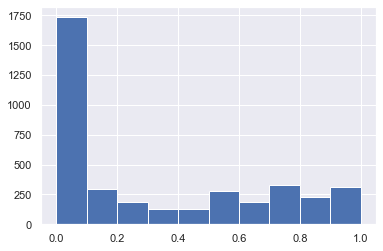

In [187]:
#histogram showing distribution of occupancy rate (booked_percent) of listings
plt.hist(listing_booking['booked_percent'])
plt.show()

Data cleaning and preparation

In [188]:
raw=df_listing[['id','host_is_superhost','neighbourhood_group_cleansed','property_type','room_type','accommodates',
             'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities','number_of_reviews','review_scores_rating',
             'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 
             'review_scores_communication', 'review_scores_location', 'review_scores_value','price']]

In [189]:
# change the data type of price from string to interger
raw['price']=raw['price'].str.replace('$','')
raw['price']=raw['price'].str.replace(',','')
raw['price']=raw['price'].astype('float64')

/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

In [190]:
# create a function that replace NA with 0
def fill_na(data,col_name):
    '''
    Function that fills na with 0 in review score related columns
    Args:
        data: name of dataset
        col_name: name of colums that have missing values
    ''' 
    data[col_name][np.isnan(data[col_name])]=0

# apply the function to review related features
for i in raw.filter(regex='^review'):
    fill_na(raw,i)

# check whether we successfully replace NAs with 0
raw.shape[0]-raw.count()

/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:9114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

id                              0
host_is_superhost               0
neighbourhood_group_cleansed    0
property_type                   0
room_type                       0
accommodates                    0
bathrooms                       0
bedrooms                        0
beds                            0
bed_type                        0
amenities                       0
number_of_reviews               0
review_scores_rating            0
review_scores_accuracy          0
review_scores_cleanliness       0
review_scores_checkin           0
review_scores_communication     0
review_scores_location          0
review_scores_value             0
price                           0
dtype: int64

In [191]:
# drop those records having missing values in the rest of columns.
raw=raw.dropna(subset=['host_is_superhost','property_type','bathrooms','bedrooms','beds'])

raw.shape[0]-raw.count()

id                              0
host_is_superhost               0
neighbourhood_group_cleansed    0
property_type                   0
room_type                       0
accommodates                    0
bathrooms                       0
bedrooms                        0
beds                            0
bed_type                        0
amenities                       0
number_of_reviews               0
review_scores_rating            0
review_scores_accuracy          0
review_scores_cleanliness       0
review_scores_checkin           0
review_scores_communication     0
review_scores_location          0
review_scores_value             0
price                           0
dtype: int64

In [192]:
listing_booking['id']=listing_booking['id'].astype('int64')

# merge the listing description dataset with listing booked_persent dataset
raw=pd.merge(raw, listing_booking, how='left', on=['id'])
raw.head()

id host_is_superhost neighbourhood_group_cleansed property_type  \
0   241032                 f                   Queen Anne     Apartment   
1   953595                 t                   Queen Anne     Apartment   
2  3308979                 f                   Queen Anne         House   
3  7421966                 f                   Queen Anne     Apartment   
4   278830                 f                   Queen Anne         House   

         room_type  accommodates  bathrooms  bedrooms  beds  bed_type  ...  \
0  Entire home/apt             4        1.0       1.0   1.0  Real Bed  ...   
1  Entire home/apt             4        1.0       1.0   1.0  Real Bed  ...   
2  Entire home/apt            11        4.5       5.0   7.0  Real Bed  ...   
3  Entire home/apt             3        1.0       0.0   2.0  Real Bed  ...   
4  Entire home/apt             6        2.0       3.0   3.0  Real Bed  ...   

  review_scores_rating  review_scores_accuracy  review_scores_cleanliness  \
0            95.000000               10.000000                  10.000000   
1            96.000000               10.000000                  10.000000   
2            97.000000               10.000000                  10.000000   
3            94.539262                9.636392                   9.556398   
4            92.000000                9.000000                   9.000000   

   review_scores_checkin  review_scores_communication  review_scores_location  \
0              10.000000                    10.000000                9.000000   
1              10.000000                    10.000000               10.000000   
2              10.000000                    10.000000               10.000000   
3               9.786709                     9.809599                9.608916   
4              10.000000                    10.000000                9.000000   

   review_scores_value  price  available  booked_percent  
0            10.000000   85.0        346        0.052055  
1            10.000000  150.0        291        0.202740  
2            10.000000  975.0        220        0.397260  
3             9.452245  100.0        143        0.608219  
4             9.000000  450.0        365        0.000000  

[5 rows x 22 columns]

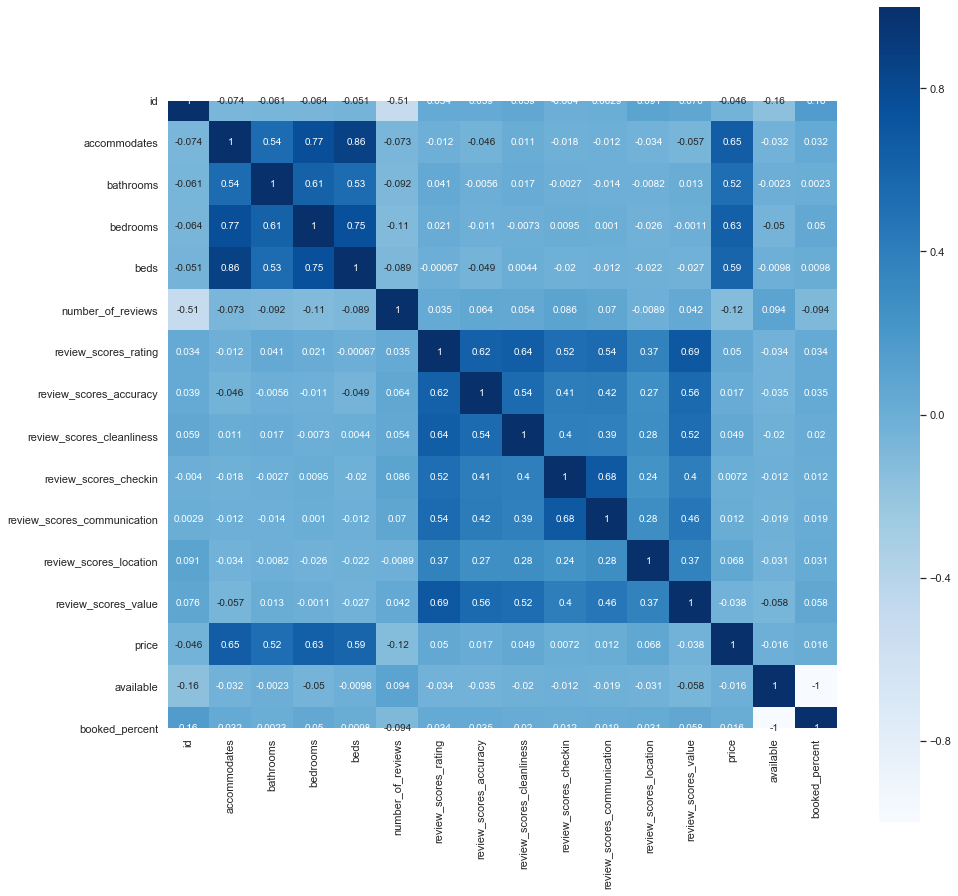

In [193]:
# plot the correlation matrix 
def cm(df):
    dfData = df.corr()
    plt.subplots(figsize=(15, 15)) 
    sb.heatmap(dfData, annot=True, vmax=1, square=True, cmap="Blues")
    plt.show()

cm(raw)

From the correlation matrix, the correlation between each numeric feature and the booked_percent of listings is very weak, suggesting little or no relationship.

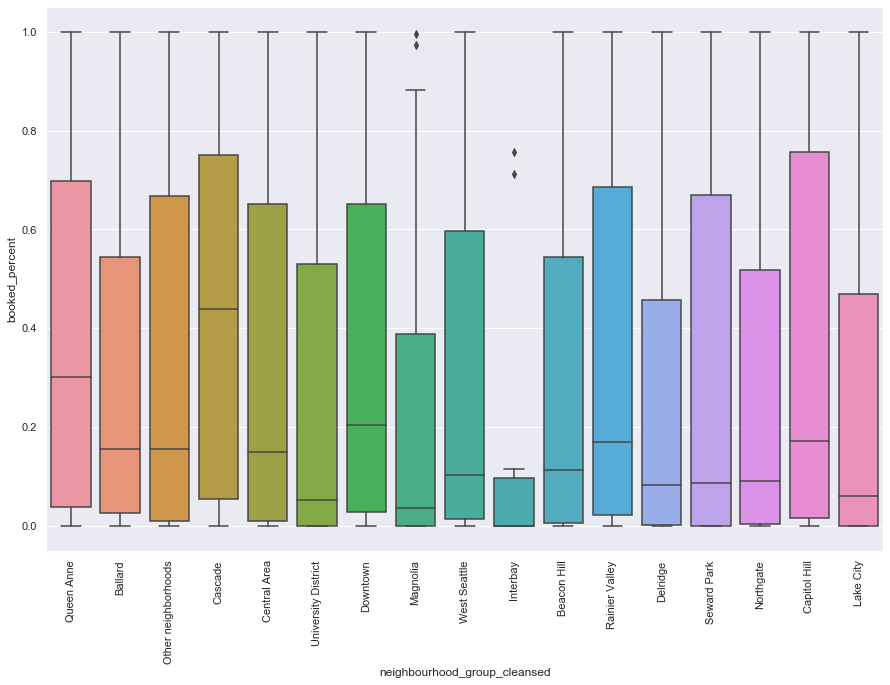

In [194]:
# make a box plot to see whether different neighbourhood group 's booked persent distribution varied
f, ax= plt.subplots(figsize = (15, 10))
sb.boxplot( x=raw['neighbourhood_group_cleansed'], y=raw['booked_percent'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

From the above boxplot of booked_percent for different neighbourhoods, the neighbourhood group may affect the likelihood of bookings. Listings in some neighbourhood like Cascade generally have a higher likelihood of being booked, while listings in Magnolia generally have a lower likelihood of being booked.

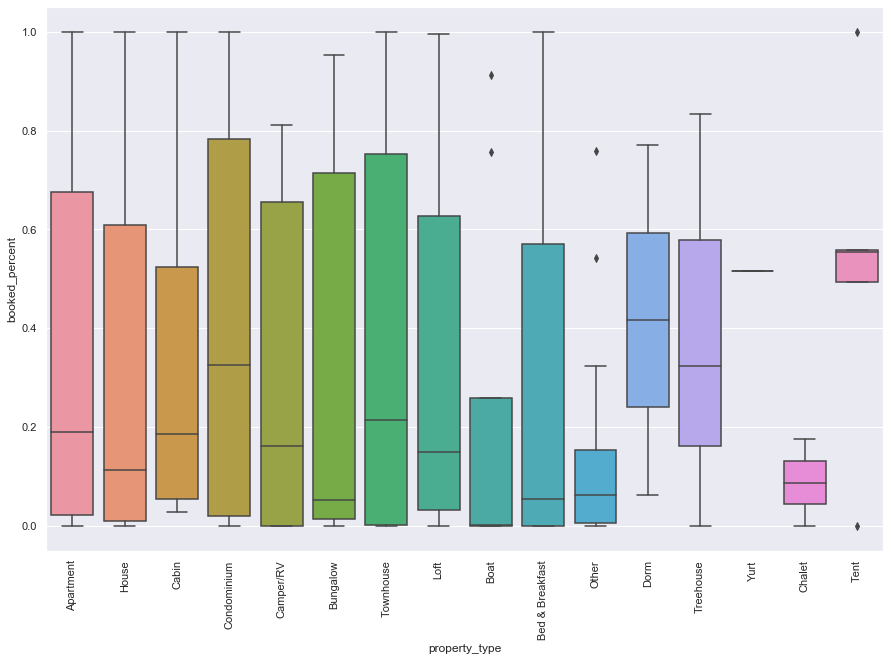

In [195]:
# make a box plot to see whether different property type's booked persent distribution varied
f, ax= plt.subplots(figsize = (15, 10))
sb.boxplot( x=raw['property_type'], y=raw['booked_percent'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

From the above boxplot of booked_persent for different property type, property type does affect the likelihood of bookings. Listings in some property type like Condominium and dorm  have higher likelihood of being booked.

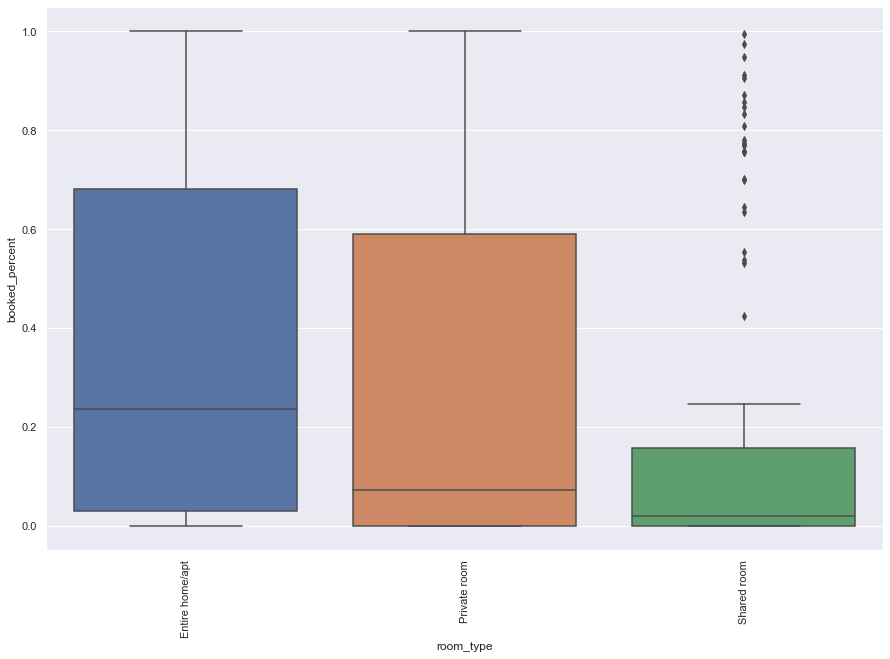

In [196]:
# make a box plot to see whether different room type's booked persent distribution varied
f, ax= plt.subplots(figsize = (15, 10))
sb.boxplot( x=raw['room_type'], y=raw['booked_percent'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

From the above boxplot of booked_percent for different room type, the room type does affect the likelihood of bookings. Listings in with room type entire home/apt tend to have higher likelihood of being booked.

**Thus, a listing with features like faster host_response time, property types like apartment，better neighbourhood_group,room_type such as entire home and more flexible cancellation policy  will increase the popularity and also increase likelihood of a listing being booked. Thus, if a user wants to securely book a listing that has such qualities, he or she should book as early as possible.**

In [197]:
### What are the things people care most that may affect popularity / likelihood of a listing being booked?

In [198]:
df_reviews.head()

listing_id        id        date  reviewer_id reviewer_name  \
0     7202016  38917982  2015-07-19     28943674        Bianca   
1     7202016  39087409  2015-07-20     32440555         Frank   
2     7202016  39820030  2015-07-26     37722850           Ian   
3     7202016  40813543  2015-08-02     33671805        George   
4     7202016  41986501  2015-08-10     34959538          Ming   

                                            comments  
0  Cute and cozy place. Perfect location to every...  
1  Kelly has a great room in a very central locat...  
2  Very spacious apartment, and in a great neighb...  
3  Close to Seattle Center and all it has to offe...  
4  Kelly was a great host and very accommodating ...

In [199]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [200]:
from wordcloud import WordCloud
with open('comments.txt','w',encoding='utf-8') as f:
    f.writelines(df_reviews.comments.astype('str'))

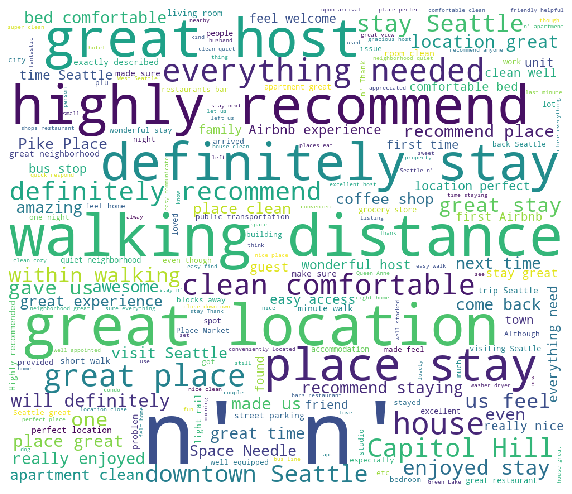

In [201]:
with open('comments.txt','r',encoding='utf-8') as f:
    data = f.readlines()

wc = WordCloud(background_color="white",width=1000, height=860, margin=2).generate(str(data))

plt.figure(figsize=(10,10))
plt.imshow(wc)
plt.axis('off')
plt.show()
wc.to_file('comments.png')

From this plot, we can see that most are positive comments.
We also find out some keywaords like Walking distance, great host, everything needed and great location. 
From this we can infer that a listing with all these feature may increase the likelihood of booking.

### Using Ridge Regression to estimate the likelihood of booking in year 2017 for each cluster

In [202]:
#Cluster with 'small-high-quality listing'
cluster=clustered_data_k_copy[clustered_data_k_copy.Cluster=='small-high-quality listing']
#create dataframe with listings from the cluster
count=0
for i in cluster['id']:
    if i in df_calendar['listing_id']:
        count+=1
        if count==1:
            cluster_df = df_calendar.loc[df_calendar['listing_id'] == i]
            temp_df = df_calendar.loc[df_calendar['listing_id'] == i]
        temp_df = df_calendar.loc[df_calendar['listing_id'] == i]
        cluster_df = pd.concat([cluster_df,temp_df],axis=0)

In [203]:
#finding the monthly vistors for the year 2016
cluster_df = cluster_df.dropna()
dates = cluster_df['date']
price = cluster_df['price']

year_date = {date: 0 for date in set(dates)}
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 
         'October', 'November', 'December', 'January']

for date in dates:
    year_date[date] += 1

# empty array to be filled with the monthly visitors per month
monthly_visitors = np.zeros(12)
    
for date in year_date:
    monthly_visitors[int(date.split('-')[1]) - 1] += year_date[date]

monthly_visitors = [int(visitors) for visitors in monthly_visitors]

for i, month in enumerate(monthly_visitors):
    print("Monthly visitors for {:10s} : {:10d}".format( months[i], month))
print(44*"-")
print("Mean monthly visitors for 2016  :      " + str(int(np.mean(monthly_visitors))))

Monthly visitors for January    :       2970
Monthly visitors for February   :       2871
Monthly visitors for March      :       3069
Monthly visitors for April      :       2970
Monthly visitors for May        :       3069
Monthly visitors for June       :       2970
Monthly visitors for July       :       3069
Monthly visitors for August     :       3069
Monthly visitors for September  :       2970
Monthly visitors for October    :       3069
Monthly visitors for November   :       2970
Monthly visitors for December   :       3069
--------------------------------------------
Mean monthly visitors for 2016  :      3011


5 degree Polynomial Ridge Regression
Coefficients and Intercept of the Linear Regression: 

Y = [0.0, 6.99, -2.25, 1.28, -0.16, 0.01]X + 2981.83
Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.5350810592348604
Mean Squared Error (MSE) 	: 1139.1676346097834

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.03807398412713259
Mean Squared Error (MSE) 	: 6481.637856079356

Explained Variance :-12.44 (+/- 47.18)


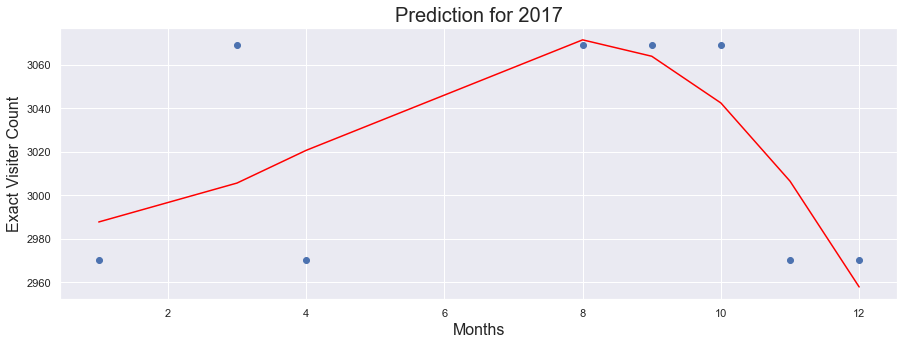

In [204]:
#create copies for calculating cross_val_score
y = np.array(monthly_visitors)
y_copy = y
X = np.array(np.arange(1, 13))
X_copy = X

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)

X_train=np.sort(X_train)
X_test=np.sort(X_test)

# Polynomial Regression expects a third dimension like the Neural Network (x, y, 1)
X = X_train[:, np.newaxis]
y = y_train[:, np.newaxis]
X_test = X_test[:, np.newaxis]
y_test = y_test[:, np.newaxis]

# Fit the Polynomial Regression
polynomial_features= PolynomialFeatures(degree=5)
x_poly = polynomial_features.fit_transform(X)
x_poly_test = polynomial_features.fit_transform(X_test)

# Fit the Linear Regression
rr = linear_model.Ridge()
rr.fit(x_poly, y)

# Predict all months in 2017
y_poly_pred = rr.predict(x_poly)
y_poly_pred_test = rr.predict(x_poly_test)

print("5 degree Polynomial Ridge Regression")
print("Coefficients and Intercept of the Linear Regression: \n")
print("Y = " + str([round(x,2) for x in rr.coef_[0]]) + "X + "+ str(round(rr.intercept_[0], 2)))

from sklearn.metrics import mean_squared_error

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", rr.score(x_poly, y))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y, y_poly_pred))
print()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", rr.score(x_poly_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_poly_pred_test))
print()

X_copy = X_copy[:, np.newaxis]
y_copy = y_copy[:, np.newaxis]
X_copy = polynomial_features.fit_transform(X_copy)
clf = svm.SVC(kernel='linear', C=1)
#source: https://scikit-learn.org/stable/modules/cross_validation.html
#Determine performance of model using cross_val_score
scores = cross_val_score(rr, X_copy, y_copy, cv=5)
print("Explained Variance :%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#The ridge regression model has low performance, 
#partly because of the small number of datapoints (12 data points for 12 months)

#Find increase in mse from train set to test set.
mse_decrease.append((mean_squared_error(y_test, y_poly_pred_test)- mean_squared_error(y, y_poly_pred))/ mean_squared_error(y, y_poly_pred))

plt.figure(figsize=(15,5))
plt.scatter(X, y)
plt.plot(X, y_poly_pred, color="red")
plt.title("Prediction for 2017", fontsize=20)
plt.xlabel("Months", fontsize=16)
plt.ylabel("Exact Visiter Count", fontsize=16)
#plt.yticks(np.arange(100000, 130000, 5000), fontsize=16)
#plt.xticks(np.arange(1, 13), months, fontsize=12)
plt.show()

In [205]:
#Cluster with 'small-low-quality listing'
cluster=clustered_data_k_copy[clustered_data_k_copy.Cluster=='small-low-quality listing']
#create dataframe with listings from the cluster
count=0
for i in cluster['id']:
    if i in df_calendar['listing_id']:
        count+=1
        if count==1:
            cluster_df = df_calendar.loc[df_calendar['listing_id'] == i]
            temp_df = df_calendar.loc[df_calendar['listing_id'] == i]
        temp_df = df_calendar.loc[df_calendar['listing_id'] == i]
        cluster_df = pd.concat([cluster_df,temp_df],axis=0)

In [206]:
#finding the monthly vistors for the year 2016
cluster_df = cluster_df.dropna()
dates = cluster_df['date']
price = cluster_df['price']

year_date = {date: 0 for date in set(dates)}
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 
         'October', 'November', 'December', 'January']

for date in dates:
    year_date[date] += 1

# empty array to be filled with the monthly visitors per month
monthly_visitors = np.zeros(12)
    
for date in year_date:
    monthly_visitors[int(date.split('-')[1]) - 1] += year_date[date]

monthly_visitors = [int(visitors) for visitors in monthly_visitors]

for i, month in enumerate(monthly_visitors):
    print("Monthly visitors for {:10s} : {:10d}".format( months[i], month))
print(44*"-")
print("Mean monthly visitors for 2016  :      " + str(int(np.mean(monthly_visitors))))

Monthly visitors for January    :        720
Monthly visitors for February   :        696
Monthly visitors for March      :        744
Monthly visitors for April      :        720
Monthly visitors for May        :        744
Monthly visitors for June       :        720
Monthly visitors for July       :        744
Monthly visitors for August     :        744
Monthly visitors for September  :        720
Monthly visitors for October    :        744
Monthly visitors for November   :        720
Monthly visitors for December   :        744
--------------------------------------------
Mean monthly visitors for 2016  :      730


5 degree Polynomial Ridge Regression
Coefficients and Intercept of the Linear Regression: 

Y = [0.0, -0.61, -1.61, -0.36, 0.15, -0.01]X + 756.06
Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.48189881733193995
Mean Squared Error (MSE) 	: 69.9436596601881

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: -36.067019216796076
Mean Squared Error (MSE) 	: 10675.30153443727

Explained Variance :-12.44 (+/- 47.18)


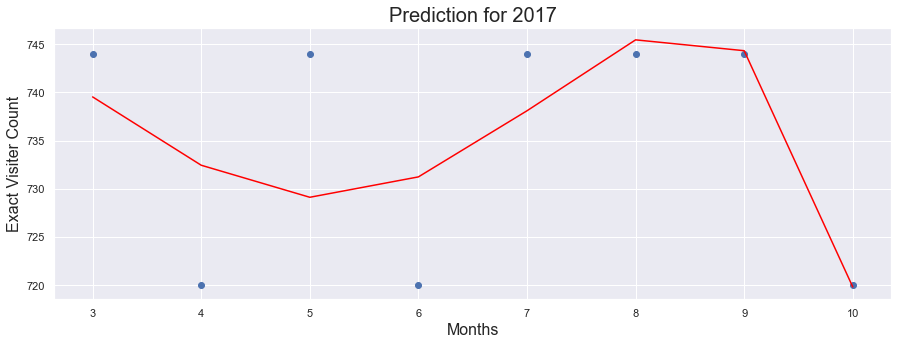

In [207]:
#create copies for calculating cross_val_score
y = np.array(monthly_visitors)
y_copy = y
X = np.array(np.arange(1, 13))
X_copy = X

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)

X_train=np.sort(X_train)
X_test=np.sort(X_test)

# Polynomial Regression expects a third dimension like the Neural Network (x, y, 1)
X = X_train[:, np.newaxis]
y = y_train[:, np.newaxis]
X_test = X_test[:, np.newaxis]
y_test = y_test[:, np.newaxis]

# Fit the Polynomial Regression
polynomial_features= PolynomialFeatures(degree=5)
x_poly = polynomial_features.fit_transform(X)
x_poly_test = polynomial_features.fit_transform(X_test)

# Fit the Linear Regression
rr = linear_model.Ridge()
rr.fit(x_poly, y)

# Predict all months in 2017
y_poly_pred = rr.predict(x_poly)
y_poly_pred_test = rr.predict(x_poly_test)

print("5 degree Polynomial Ridge Regression")
print("Coefficients and Intercept of the Linear Regression: \n")
print("Y = " + str([round(x,2) for x in rr.coef_[0]]) + "X + "+ str(round(rr.intercept_[0], 2)))

from sklearn.metrics import mean_squared_error

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", rr.score(x_poly, y))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y, y_poly_pred))
print()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", rr.score(x_poly_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_poly_pred_test))
print()

X_copy = X_copy[:, np.newaxis]
y_copy = y_copy[:, np.newaxis]
X_copy = polynomial_features.fit_transform(X_copy)
clf = svm.SVC(kernel='linear', C=1)
#source: https://scikit-learn.org/stable/modules/cross_validation.html
#Determine performance of model using cross_val_score
scores = cross_val_score(rr, X_copy, y_copy, cv=5)
print("Explained Variance :%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#The ridge regression model has low performance, 
#partly because of the small number of datapoints (12 data points for 12 months)

#Find increase in mse from train set to test set.
mse_decrease.append((mean_squared_error(y_test, y_poly_pred_test)- mean_squared_error(y, y_poly_pred))/ mean_squared_error(y, y_poly_pred))

plt.figure(figsize=(15,5))
plt.scatter(X, y)
plt.plot(X, y_poly_pred, color="red")
plt.title("Prediction for 2017", fontsize=20)
plt.xlabel("Months", fontsize=16)
plt.ylabel("Exact Visiter Count", fontsize=16)
#plt.yticks(np.arange(100000, 130000, 5000), fontsize=16)
#plt.xticks(np.arange(1, 13), months, fontsize=12)
plt.show()

In [208]:
#Cluster with 'small-cheap listing'
cluster=clustered_data_k_copy[clustered_data_k_copy.Cluster=='small-cheap listing']
#create dataframe with listings from the cluster
count=0
for i in cluster['id']:
    if i in df_calendar['listing_id']:
        count+=1
        if count==1:
            cluster_df = df_calendar.loc[df_calendar['listing_id'] == i]
            temp_df = df_calendar.loc[df_calendar['listing_id'] == i]
        temp_df = df_calendar.loc[df_calendar['listing_id'] == i]
        cluster_df = pd.concat([cluster_df,temp_df],axis=0)

In [209]:
#finding the monthly vistors for the year 2016
cluster_df = cluster_df.dropna()
dates = cluster_df['date']
price = cluster_df['price']

year_date = {date: 0 for date in set(dates)}
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 
         'October', 'November', 'December', 'January']

for date in dates:
    year_date[date] += 1

# empty array to be filled with the monthly visitors per month
monthly_visitors = np.zeros(12)
    
for date in year_date:
    monthly_visitors[int(date.split('-')[1]) - 1] += year_date[date]

monthly_visitors = [int(visitors) for visitors in monthly_visitors]

for i, month in enumerate(monthly_visitors):
    print("Monthly visitors for {:10s} : {:10d}".format( months[i], month))
print(44*"-")
print("Mean monthly visitors for 2016  :      " + str(int(np.mean(monthly_visitors))))

Monthly visitors for January    :       4320
Monthly visitors for February   :       4176
Monthly visitors for March      :       4464
Monthly visitors for April      :       4320
Monthly visitors for May        :       4464
Monthly visitors for June       :       4320
Monthly visitors for July       :       4464
Monthly visitors for August     :       4464
Monthly visitors for September  :       4320
Monthly visitors for October    :       4464
Monthly visitors for November   :       4320
Monthly visitors for December   :       4464
--------------------------------------------
Mean monthly visitors for 2016  :      4380


5 degree Polynomial Ridge Regression
Coefficients and Intercept of the Linear Regression: 

Y = [0.0, -21.99, -17.1, 6.06, -0.72, 0.03]X + 4450.77
Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.525485861594665
Mean Squared Error (MSE) 	: 4304.792263613199

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: -3.8248088060351746
Mean Squared Error (MSE) 	: 18758.85663786476

Explained Variance :-12.44 (+/- 47.18)


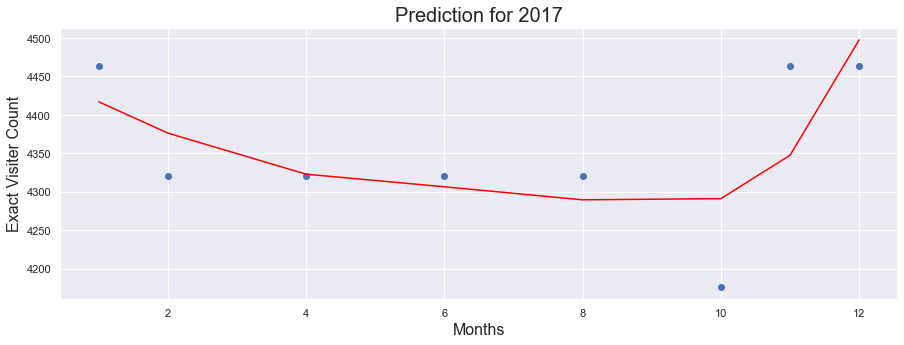

In [210]:
#create copies for calculating cross_val_score
y = np.array(monthly_visitors)
y_copy = y
X = np.array(np.arange(1, 13))
X_copy = X

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)

X_train=np.sort(X_train)
X_test=np.sort(X_test)

# Polynomial Regression expects a third dimension like the Neural Network (x, y, 1)
X = X_train[:, np.newaxis]
y = y_train[:, np.newaxis]
X_test = X_test[:, np.newaxis]
y_test = y_test[:, np.newaxis]

# Fit the Polynomial Regression
polynomial_features= PolynomialFeatures(degree=5)
x_poly = polynomial_features.fit_transform(X)
x_poly_test = polynomial_features.fit_transform(X_test)

# Fit the Linear Regression
rr = linear_model.Ridge()
rr.fit(x_poly, y)

# Predict all months in 2017
y_poly_pred = rr.predict(x_poly)
y_poly_pred_test = rr.predict(x_poly_test)

print("5 degree Polynomial Ridge Regression")
print("Coefficients and Intercept of the Linear Regression: \n")
print("Y = " + str([round(x,2) for x in rr.coef_[0]]) + "X + "+ str(round(rr.intercept_[0], 2)))

from sklearn.metrics import mean_squared_error

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", rr.score(x_poly, y))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y, y_poly_pred))
print()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", rr.score(x_poly_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_poly_pred_test))
print()

X_copy = X_copy[:, np.newaxis]
y_copy = y_copy[:, np.newaxis]
X_copy = polynomial_features.fit_transform(X_copy)
clf = svm.SVC(kernel='linear', C=1)
#source: https://scikit-learn.org/stable/modules/cross_validation.html
#Determine performance of model using cross_val_score
scores = cross_val_score(rr, X_copy, y_copy, cv=5)
print("Explained Variance :%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#The ridge regression model has low performance, 
#partly because of the small number of datapoints (12 data points for 12 months)

#Find increase in mse from train set to test set.
mse_decrease.append((mean_squared_error(y_test, y_poly_pred_test)- mean_squared_error(y, y_poly_pred))/ mean_squared_error(y, y_poly_pred))

plt.figure(figsize=(15,5))
plt.scatter(X, y)
plt.plot(X, y_poly_pred, color="red")
plt.title("Prediction for 2017", fontsize=20)
plt.xlabel("Months", fontsize=16)
plt.ylabel("Exact Visiter Count", fontsize=16)
#plt.yticks(np.arange(100000, 130000, 5000), fontsize=16)
#plt.xticks(np.arange(1, 13), months, fontsize=12)
plt.show()

In [211]:
#Cluster with 'medium listing'
cluster=clustered_data_k_copy[clustered_data_k_copy.Cluster=='medium listing']
#create dataframe with listings from the cluster
count=0
for i in cluster['id']:
    if i in df_calendar['listing_id']:
        count+=1
        if count==1:
            cluster_df = df_calendar.loc[df_calendar['listing_id'] == i]
            temp_df = df_calendar.loc[df_calendar['listing_id'] == i]
        temp_df = df_calendar.loc[df_calendar['listing_id'] == i]
        cluster_df = pd.concat([cluster_df,temp_df],axis=0)

In [212]:
#finding the monthly vistors for the year 2016
cluster_df = cluster_df.dropna()
dates = cluster_df['date']
price = cluster_df['price']

year_date = {date: 0 for date in set(dates)}
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 
         'October', 'November', 'December', 'January']

for date in dates:
    year_date[date] += 1

# empty array to be filled with the monthly visitors per month
monthly_visitors = np.zeros(12)
    
for date in year_date:
    monthly_visitors[int(date.split('-')[1]) - 1] += year_date[date]

monthly_visitors = [int(visitors) for visitors in monthly_visitors]

for i, month in enumerate(monthly_visitors):
    print("Monthly visitors for {:10s} : {:10d}".format( months[i], month))
print(44*"-")
print("Mean monthly visitors for 2016  :      " + str(int(np.mean(monthly_visitors))))

Monthly visitors for January    :       2730
Monthly visitors for February   :       2639
Monthly visitors for March      :       2821
Monthly visitors for April      :       2730
Monthly visitors for May        :       2821
Monthly visitors for June       :       2730
Monthly visitors for July       :       2821
Monthly visitors for August     :       2821
Monthly visitors for September  :       2730
Monthly visitors for October    :       2821
Monthly visitors for November   :       2730
Monthly visitors for December   :       2821
--------------------------------------------
Mean monthly visitors for 2016  :      2767


5 degree Polynomial Ridge Regression
Coefficients and Intercept of the Linear Regression: 

Y = [0.0, -4.97, -28.18, 5.31, -0.28, 0.0]X + 2926.96
Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.6483819912043344
Mean Squared Error (MSE) 	: 1273.8900697411468

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: -2.675797339821139
Mean Squared Error (MSE) 	: 5707.364582073535

Explained Variance :-12.44 (+/- 47.18)


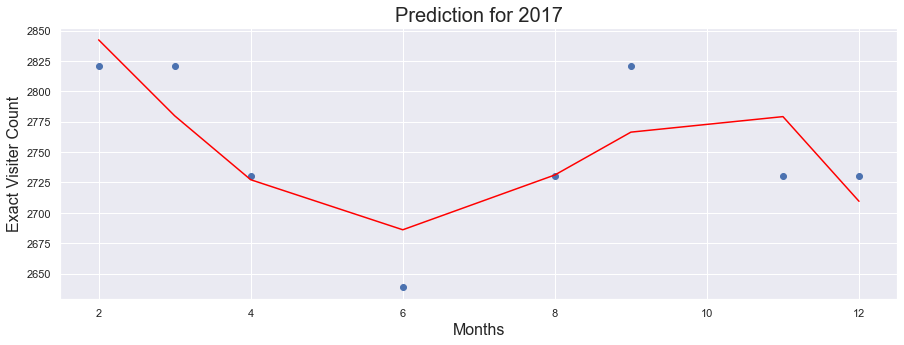

In [213]:
#create copies for calculating cross_val_score
y = np.array(monthly_visitors)
y_copy = y
X = np.array(np.arange(1, 13))
X_copy = X

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)

X_train=np.sort(X_train)
X_test=np.sort(X_test)

# Polynomial Regression expects a third dimension like the Neural Network (x, y, 1)
X = X_train[:, np.newaxis]
y = y_train[:, np.newaxis]
X_test = X_test[:, np.newaxis]
y_test = y_test[:, np.newaxis]

# Fit the Polynomial Regression
polynomial_features= PolynomialFeatures(degree=5)
x_poly = polynomial_features.fit_transform(X)
x_poly_test = polynomial_features.fit_transform(X_test)

# Fit the Linear Regression
rr = linear_model.Ridge()
rr.fit(x_poly, y)

# Predict all months in 2017
y_poly_pred = rr.predict(x_poly)
y_poly_pred_test = rr.predict(x_poly_test)

print("5 degree Polynomial Ridge Regression")
print("Coefficients and Intercept of the Linear Regression: \n")
print("Y = " + str([round(x,2) for x in rr.coef_[0]]) + "X + "+ str(round(rr.intercept_[0], 2)))

from sklearn.metrics import mean_squared_error

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", rr.score(x_poly, y))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y, y_poly_pred))
print()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", rr.score(x_poly_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_poly_pred_test))
print()

X_copy = X_copy[:, np.newaxis]
y_copy = y_copy[:, np.newaxis]
X_copy = polynomial_features.fit_transform(X_copy)
clf = svm.SVC(kernel='linear', C=1)
#source: https://scikit-learn.org/stable/modules/cross_validation.html
#Determine performance of model using cross_val_score
scores = cross_val_score(rr, X_copy, y_copy, cv=5)
print("Explained Variance :%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#The ridge regression model has low performance, 
#partly because of the small number of datapoints (12 data points for 12 months)

#Find increase in mse from train set to test set.
mse_decrease.append((mean_squared_error(y_test, y_poly_pred_test)- mean_squared_error(y, y_poly_pred))/ mean_squared_error(y, y_poly_pred))

plt.figure(figsize=(15,5))
plt.scatter(X, y)
plt.plot(X, y_poly_pred, color="red")
plt.title("Prediction for 2017", fontsize=20)
plt.xlabel("Months", fontsize=16)
plt.ylabel("Exact Visiter Count", fontsize=16)
#plt.yticks(np.arange(100000, 130000, 5000), fontsize=16)
#plt.xticks(np.arange(1, 13), months, fontsize=12)
plt.show()

In [214]:
#Cluster with 'large listing'
cluster=clustered_data_k_copy[clustered_data_k_copy.Cluster=='large listing']
#create dataframe with listings from the cluster
count=0
for i in cluster['id']:
    if i in df_calendar['listing_id']:
        count+=1
        if count==1:
            cluster_df = df_calendar.loc[df_calendar['listing_id'] == i]
            temp_df = df_calendar.loc[df_calendar['listing_id'] == i]
        temp_df = df_calendar.loc[df_calendar['listing_id'] == i]
        cluster_df = pd.concat([cluster_df,temp_df],axis=0)

In [215]:
#finding the monthly vistors for the year 2016
cluster_df = cluster_df.dropna()
dates = cluster_df['date']
price = cluster_df['price']

year_date = {date: 0 for date in set(dates)}
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 
         'October', 'November', 'December', 'January']

for date in dates:
    year_date[date] += 1

# empty array to be filled with the monthly visitors per month
monthly_visitors = np.zeros(12)
    
for date in year_date:
    monthly_visitors[int(date.split('-')[1]) - 1] += year_date[date]

monthly_visitors = [int(visitors) for visitors in monthly_visitors]

for i, month in enumerate(monthly_visitors):
    print("Monthly visitors for {:10s} : {:10d}".format( months[i], month))
print(44*"-")
print("Mean monthly visitors for 2016  :      " + str(int(np.mean(monthly_visitors))))

Monthly visitors for January    :       2130
Monthly visitors for February   :       2059
Monthly visitors for March      :       2201
Monthly visitors for April      :       2130
Monthly visitors for May        :       2201
Monthly visitors for June       :       2130
Monthly visitors for July       :       2201
Monthly visitors for August     :       2201
Monthly visitors for September  :       2130
Monthly visitors for October    :       2201
Monthly visitors for November   :       2130
Monthly visitors for December   :       2201
--------------------------------------------
Mean monthly visitors for 2016  :      2159


5 degree Polynomial Ridge Regression
Coefficients and Intercept of the Linear Regression: 

Y = [0.0, 4.03, 5.29, -2.89, 0.38, -0.01]X + 2197.93
Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.4661698512850155
Mean Squared Error (MSE) 	: 672.7594449180591

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: -0.2911712261562851
Mean Squared Error (MSE) 	: 4474.79597884951

Explained Variance :-12.44 (+/- 47.18)


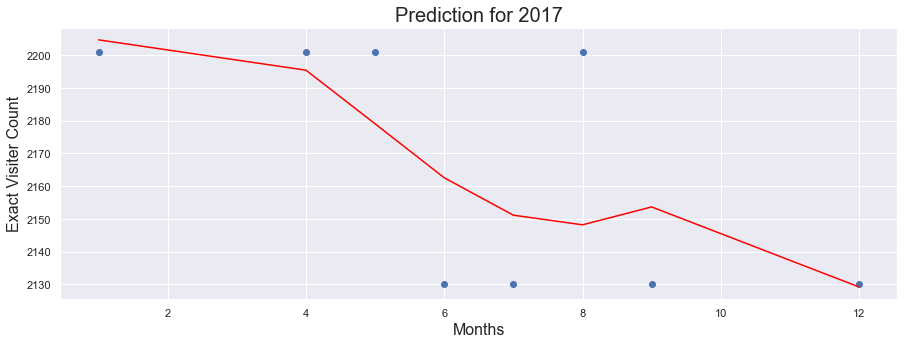

In [216]:
#create copies for calculating cross_val_score
y = np.array(monthly_visitors)
y_copy = y
X = np.array(np.arange(1, 13))
X_copy = X

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)

X_train=np.sort(X_train)
X_test=np.sort(X_test)

# Polynomial Regression expects a third dimension like the Neural Network (x, y, 1)
X = X_train[:, np.newaxis]
y = y_train[:, np.newaxis]
X_test = X_test[:, np.newaxis]
y_test = y_test[:, np.newaxis]

# Fit the Polynomial Regression
polynomial_features= PolynomialFeatures(degree=5)
x_poly = polynomial_features.fit_transform(X)
x_poly_test = polynomial_features.fit_transform(X_test)

# Fit the Linear Regression
rr = linear_model.Ridge()
rr.fit(x_poly, y)

# Predict all months in 2017
y_poly_pred = rr.predict(x_poly)
y_poly_pred_test = rr.predict(x_poly_test)

print("5 degree Polynomial Ridge Regression")
print("Coefficients and Intercept of the Linear Regression: \n")
print("Y = " + str([round(x,2) for x in rr.coef_[0]]) + "X + "+ str(round(rr.intercept_[0], 2)))

from sklearn.metrics import mean_squared_error

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", rr.score(x_poly, y))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y, y_poly_pred))
print()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", rr.score(x_poly_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_poly_pred_test))
print()

X_copy = X_copy[:, np.newaxis]
y_copy = y_copy[:, np.newaxis]
X_copy = polynomial_features.fit_transform(X_copy)
clf = svm.SVC(kernel='linear', C=1)
#source: https://scikit-learn.org/stable/modules/cross_validation.html
#Determine performance of model using cross_val_score
scores = cross_val_score(rr, X_copy, y_copy, cv=5)
print("Explained Variance :%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#The ridge regression model has low performance, 
#partly because of the small number of datapoints (12 data points for 12 months)

#Find increase in mse from train set to test set.
mse_decrease.append((mean_squared_error(y_test, y_poly_pred_test)- mean_squared_error(y, y_poly_pred))/ mean_squared_error(y, y_poly_pred))

plt.figure(figsize=(15,5))
plt.scatter(X, y)
plt.plot(X, y_poly_pred, color="red")
plt.title("Prediction for 2017", fontsize=20)
plt.xlabel("Months", fontsize=16)
plt.ylabel("Exact Visiter Count", fontsize=16)
#plt.yticks(np.arange(100000, 130000, 5000), fontsize=16)
#plt.xticks(np.arange(1, 13), months, fontsize=12)
plt.show()

In [217]:
print("Decrease in MSE from train to test set for:")
print("Whole dataset:",mse_decrease[0])

count = 1

cluster_list = ['small-high-quality listing','small-low-quality listing','small-cheap listing','medium listing','large listing']

for i in cluster_list:
    print("Cluster with",i+":",mse_decrease[count])
    count+=1

Decrease in MSE for:
Whole dataset: 86.66132535253264
Cluster with small-high-quality listing: 4.689801622831053
Cluster with small-low-quality listing: 151.62715142876127
Cluster with small-cheap listing: 3.3576682657665895
Cluster with medium listing: 3.4802645986817886
Cluster with large listing: 5.6514056586667945


Generally, prediction on the whole dataset is more accurate as the actual points are closer to the plotted prediction line, but cross_val_score are similar, suggesting minimal difference in accuracy.

# What ratings will this listing get? What factors influence Ratings?

In [218]:
#Extract categorical data to check correlation
cat_data = pd.DataFrame(data = clustered_data_k_copy, columns = ["host_response_time","host_is_superhost","neighbourhood_group_cleansed",\
                                                                 "property_type","bed_type","room_type","cancellation_policy"])
#Extract numeric data to check correlation
num_data = pd.DataFrame(data = clustered_data_k_copy, columns = ["review_scores_rating","review_scores_accuracy",\
                                                    "review_scores_cleanliness","review_scores_checkin","review_scores_communication",\
                                                    "review_scores_location","review_scores_value","price","security_deposit",\
                                                    "cleaning_fee","guests_included","extra_people","host_response_rate",\
                                                     "accommodates","bathrooms","bedrooms","beds","number_of_reviews"])
#Convert review_scores_accuracy back to numeric
num_data = num_data.astype("float64")
#Correlation between numeric variables
num_data.corr()
#data info clustered_data_k_copy.info()
#data info cat_data.info()
#data info num_data.info()


review_scores_rating  review_scores_accuracy  \
review_scores_rating                     1.000000                0.635666   
review_scores_accuracy                   0.635666                1.000000   
review_scores_cleanliness                0.630845                0.553188   
review_scores_checkin                    0.532459                0.428200   
review_scores_communication              0.558149                0.445569   
review_scores_location                   0.386768                0.275277   
review_scores_value                      0.706403                0.570813   
price                                    0.043344                0.004880   
security_deposit                         0.011434               -0.018750   
cleaning_fee                            -0.010468               -0.052688   
guests_included                         -0.003372               -0.001360   
extra_people                            -0.043988               -0.037781   
host_response_rate                       0.158575                0.132402   
accommodates                            -0.022593               -0.059861   
bathrooms                                0.035538               -0.023565   
bedrooms                                 0.011658               -0.026292   
beds                                    -0.007214               -0.058434   
number_of_reviews                        0.038468                0.069304   

                             review_scores_cleanliness  review_scores_checkin  \
review_scores_rating                          0.630845               0.532459   
review_scores_accuracy                        0.553188               0.428200   
review_scores_cleanliness                     1.000000               0.403546   
review_scores_checkin                         0.403546               1.000000   
review_scores_communication                   0.389574               0.706082   
review_scores_location                        0.294886               0.251075   
review_scores_value                           0.518654               0.416558   
price                                         0.056375               0.001361   
security_deposit                              0.023248               0.010502   
cleaning_fee                                  0.059142              -0.073046   
guests_included                               0.015751               0.036762   
extra_people                                 -0.002742              -0.075561   
host_response_rate                            0.170311               0.152590   
accommodates                                  0.007268              -0.028460   
bathrooms                                     0.016103              -0.010616   
bedrooms                                     -0.020769               0.000143   
beds                                          0.005871              -0.028047   
number_of_reviews                             0.050619               0.096575   

                             review_scores_communication  \
review_scores_rating                            0.558149   
review_scores_accuracy                          0.445569   
review_scores_cleanliness                       0.389574   
review_scores_checkin                           0.706082   
review_scores_communication                     1.000000   
review_scores_location                          0.296309   
review_scores_value                             0.473825   
price                                          -0.002200   
security_deposit                               -0.007257   
cleaning_fee                                   -0.064938   
guests_included                                 0.009878   
extra_people                                   -0.091805   
host_response_rate                              0.165911   
accommodates                                   -0.026387   
bathrooms                                      -0.025382   
bedrooms                                       -0.008542   
beds 

Amongst the numeric variables, review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, and review_scores_value have moderately strong positive correlation with review_scores_rating. This suggests that these factors influence ratings and users would understand what qualities a listing have or lack when ratings are high and low respectively.

In [219]:
num_data = pd.DataFrame(data = clustered_data_k_copy, columns = ["review_scores_rating","review_scores_accuracy",\
                                                    "review_scores_cleanliness","review_scores_checkin","review_scores_communication",\
                                                    "review_scores_location","review_scores_value"])
#Convert review_scores_accuracy back to numeric
num_data = num_data.astype("float64")
#Correlation between numeric variables
num_data.corr()

review_scores_rating  review_scores_accuracy  \
review_scores_rating                     1.000000                0.635666   
review_scores_accuracy                   0.635666                1.000000   
review_scores_cleanliness                0.630845                0.553188   
review_scores_checkin                    0.532459                0.428200   
review_scores_communication              0.558149                0.445569   
review_scores_location                   0.386768                0.275277   
review_scores_value                      0.706403                0.570813   

                             review_scores_cleanliness  review_scores_checkin  \
review_scores_rating                          0.630845               0.532459   
review_scores_accuracy                        0.553188               0.428200   
review_scores_cleanliness                     1.000000               0.403546   
review_scores_checkin                         0.403546               1.000000   
review_scores_communication                   0.389574               0.706082   
review_scores_location                        0.294886               0.251075   
review_scores_value                           0.518654               0.416558   

                             review_scores_communication  \
review_scores_rating                            0.558149   
review_scores_accuracy                          0.445569   
review_scores_cleanliness                       0.389574   
review_scores_checkin                           0.706082   
review_scores_communication                     1.000000   
review_scores_location                          0.296309   
review_scores_value                             0.473825   

                             review_scores_location  review_scores_value  
review_scores_rating                       0.386768             0.706403  
review_scores_accuracy                     0.275277             0.570813  
review_scores_cleanliness                  0.294886             0.518654  
review_scores_checkin                      0.251075             0.416558  
review_scores_communication                0.296309             0.473825  
review_scores_location                     1.000000             0.382941  
review_scores_value                        0.382941             1.000000

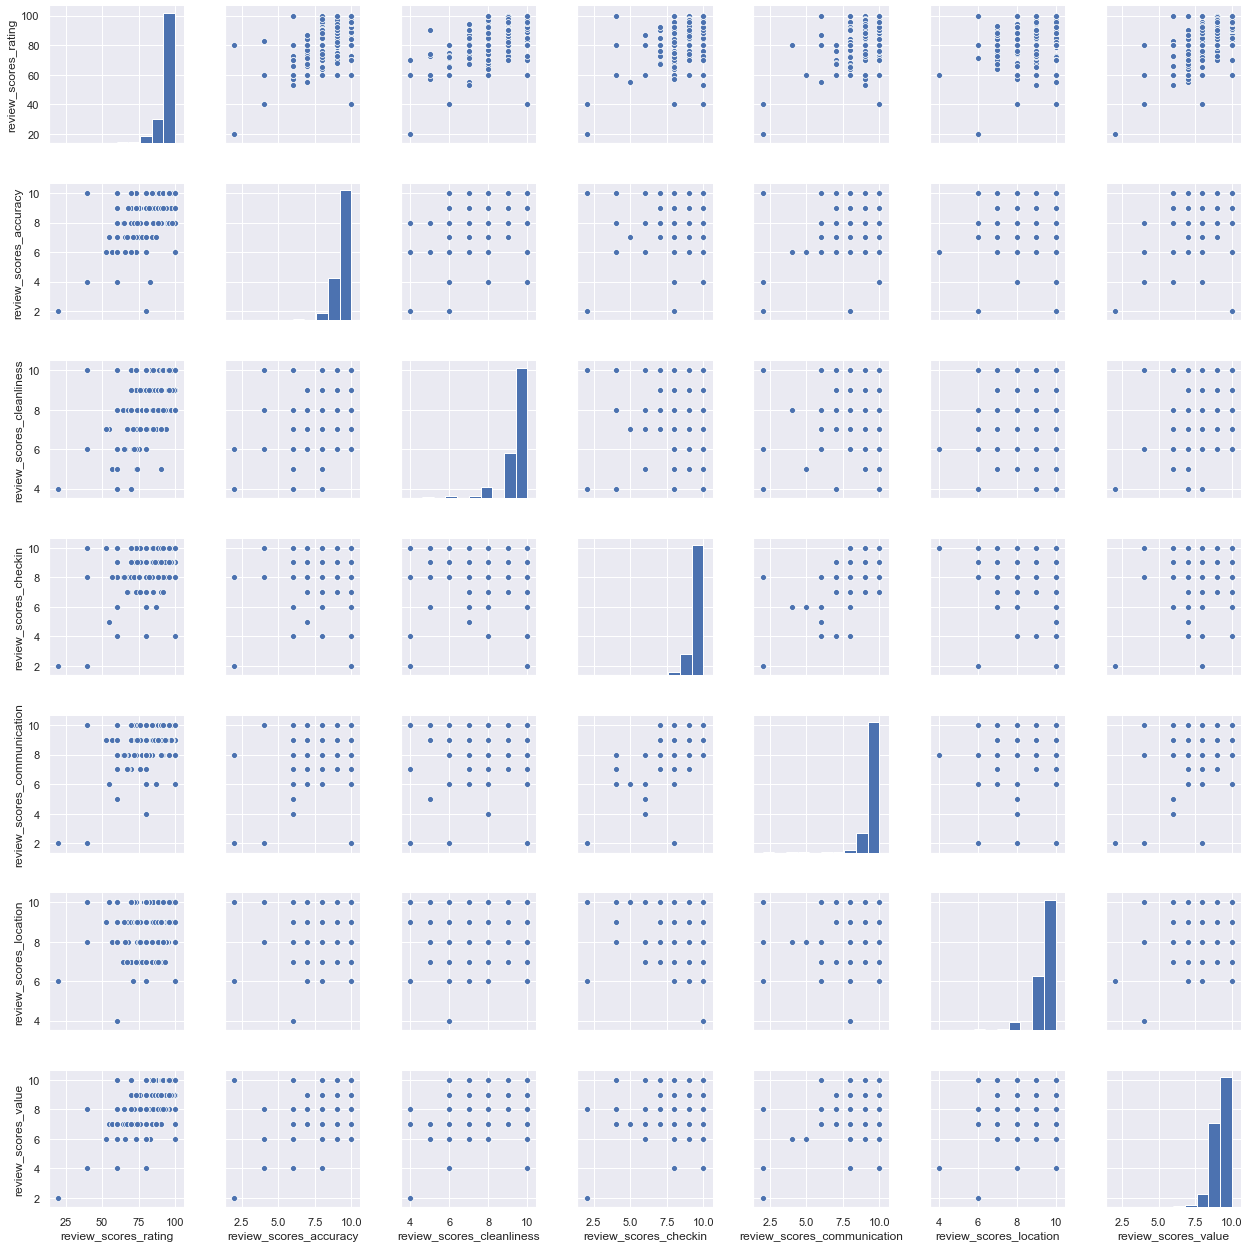

In [220]:
#plot num data
sb.pairplot(num_data)

Review_scores_rating has:<br>
-strong positive correlation with review_scores_value<br>
-moderately strong positive correlation with review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, and review_scores_communication<br>
-relatively weak positive correlation with review_scores_location<br>
-weak correlation with other numeric variables<br>

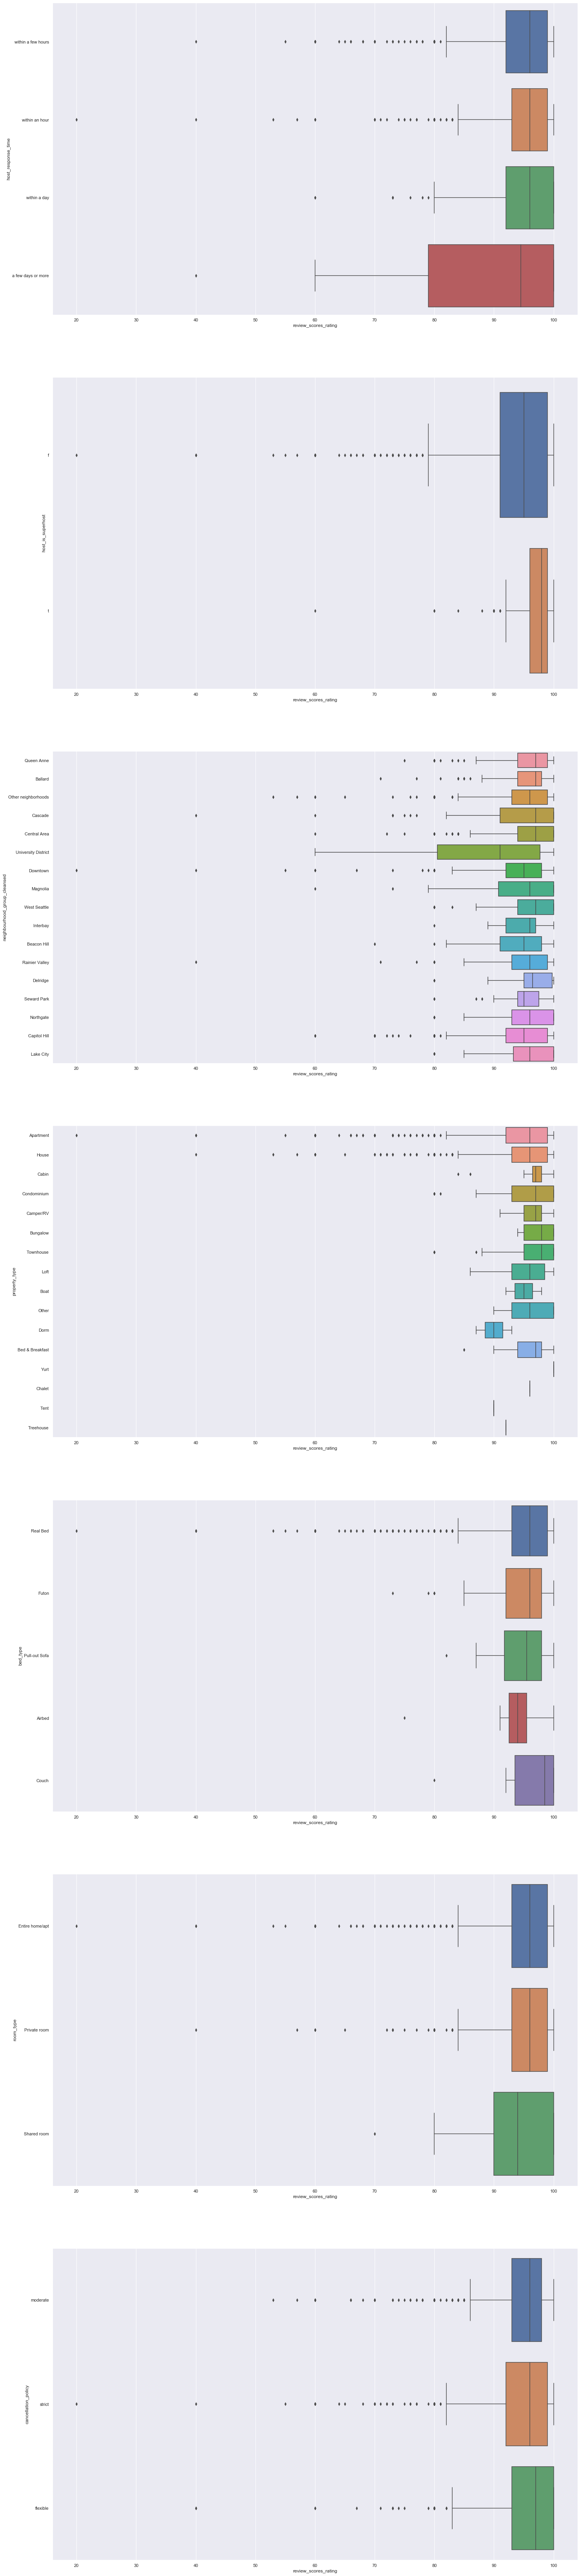

In [221]:
#Visualise categorical variables with review_scores_rating
#Boxplots for all categorical variables against the review_scores_rating
#Create list of categorical variables
cat_list = []
for var in cat_data:
    cat_list.append(var)
count = 0
f, axes = plt.subplots(7, 1, figsize=(24,120))
for var in cat_list:
    sb.boxplot(x = 'review_scores_rating', y = var, data = clustered_data_k_copy, ax = axes[count])
    count+=1


From the box plots of various categorical data with review_scores_rating, it can be observed that:<br>
The distributions of review_scores_rating across the groups of the categorical variables ( host_response_time,host_is_superhost,property_type, bed_type, room_type, and cancellation_policy) are not distinct<br>
The distributions of review_scores_rating across the different neighbourhoods in neighbourhood_cleansed has some differences. However, the distributions are not clearly segmented.<br>
<br>
Overall, review_scores_rating is not so much influenced by the quality of houses, but rather, whether guests' expectations are met for a specific listing and other qualities. This can be represented by how they rate the value of the listing, accuracy of the listing, cleanliness, communication with the host and check-in process.

In [222]:
#Extracting response variable
response_data = pd.DataFrame(num_data["review_scores_rating"])
#Extracting variables with moderately strong correlation for predictors dataframe
predictors_data = pd.DataFrame(data = num_data, columns = ["review_scores_accuracy",\
        "review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_value"])

#create list of predictors
lis=[]
for var in predictors_data:
    lis.append(var)
print(lis)


['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_value']


# predicting ratings using random forest regression

/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


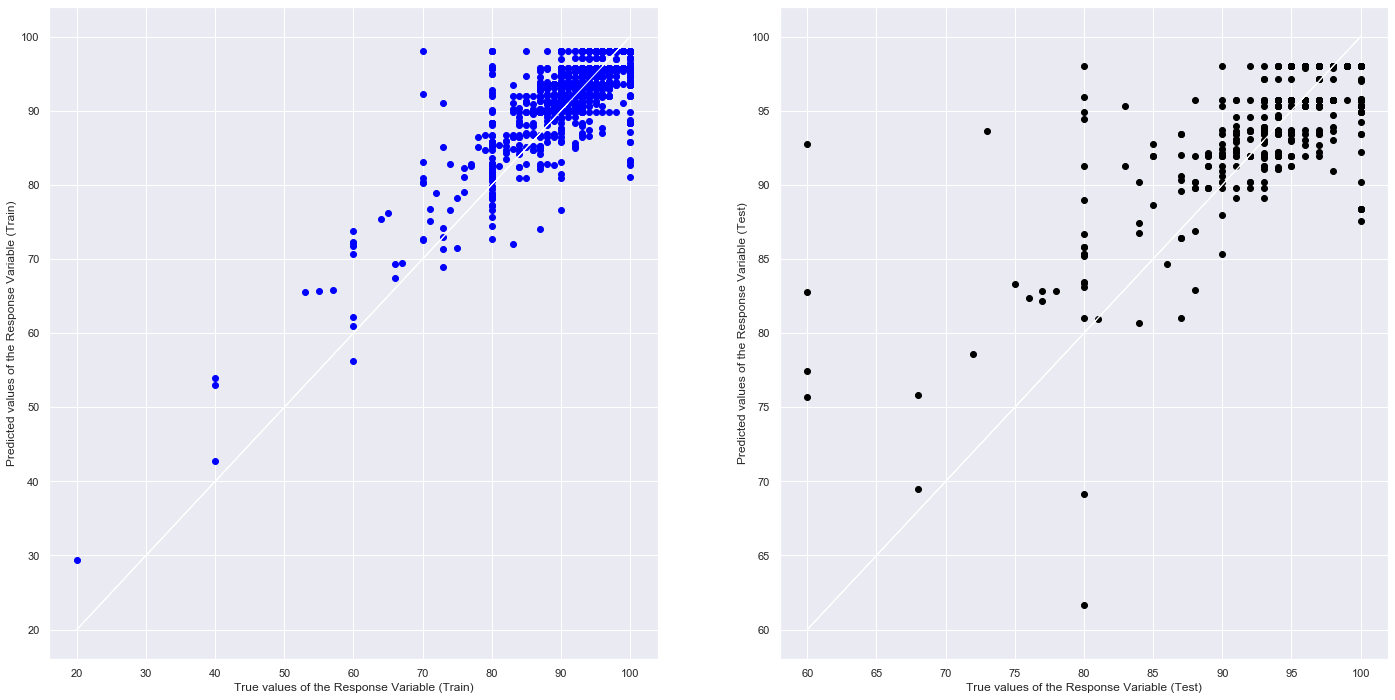

Goodness of Fit of Model (Train) )
Explained Variance (R^2) 	: 0.7181536125876862
Mean Squared Error (MSE) 	: 12.337087772621556

Goodness of Fit of Model (Test) )
Explained Variance (R^2) 	: 0.5840946033039989
Mean Squared Error (MSE) 	: 15.478150732953418



/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [223]:
# Import essential models and functions from sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score,cross_val_predict, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

predictors_train, predictors_test, response_train, response_test = train_test_split(predictors_data, response_data, test_size = 0.2)

#source for grid search: https://medium.com/datadriveninvestor/random-forest-regression-9871bc9a25eb
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor
#Obtain an optimal "max_depth" (maximum tree depth) and "n_estimators" (number of trees) by minimising cost function
gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0,n_jobs=-1)

grid_result = gsc.fit(predictors_train, response_train)
best_params = grid_result.best_params_

#define regression model using the max_depth and n_estimators obtained 
reg = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],random_state=0)                            
#fit model
reg.fit(predictors_train, response_train)
#predict ratings values. Returns an array of predicted ratings
response_pred = reg.predict(predictors_train)
response_pred_test = reg.predict(predictors_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(response_train, response_pred, color = "blue")
axes[0].plot(response_train, response_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(response_test, response_pred_test, color = "black")
axes[1].plot(response_test, response_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model (Train) )")
print("Explained Variance (R^2) \t:", reg.score(predictors_train, response_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(response_train, response_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model (Test) )")
print("Explained Variance (R^2) \t:", reg.score(predictors_test, response_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(response_test, response_pred_test))
print()

# Check value of explained variance for test and train over 10 iterations
R2_list = []
R2_list_test = []
num_iterations = 10

for i in range(0,num_iterations):
    # Split the Dataset into Train and Test
    predictors_train, predictors_test, response_train, response_test = train_test_split(predictors_data, response_data, test_size = 0.2)
    # train the linear regression model
    reg.fit(predictors_train, response_train)   
    # Predict Response corresponding to Predictors
    response_pred = reg.predict(predictors_train)
    response_pred_test = reg.predict(predictors_test)
                           
    R2_list.append(reg.score(predictors_train, response_train))
    R2_list_test.append(reg.score(predictors_test, response_test))

In [224]:
clf = svm.SVC(kernel='linear', C=1)
#source: https://scikit-learn.org/stable/modules/cross_validation.html
#Determine performance of model using cross_val_score
scores = cross_val_score(reg, predictors_data, response_data, cv=10)
print("Explained Variance :%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#The random forest regression model has moderate performance in predicting review_scores_rating

/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3

Explained Variance :0.61 (+/- 0.17)


/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


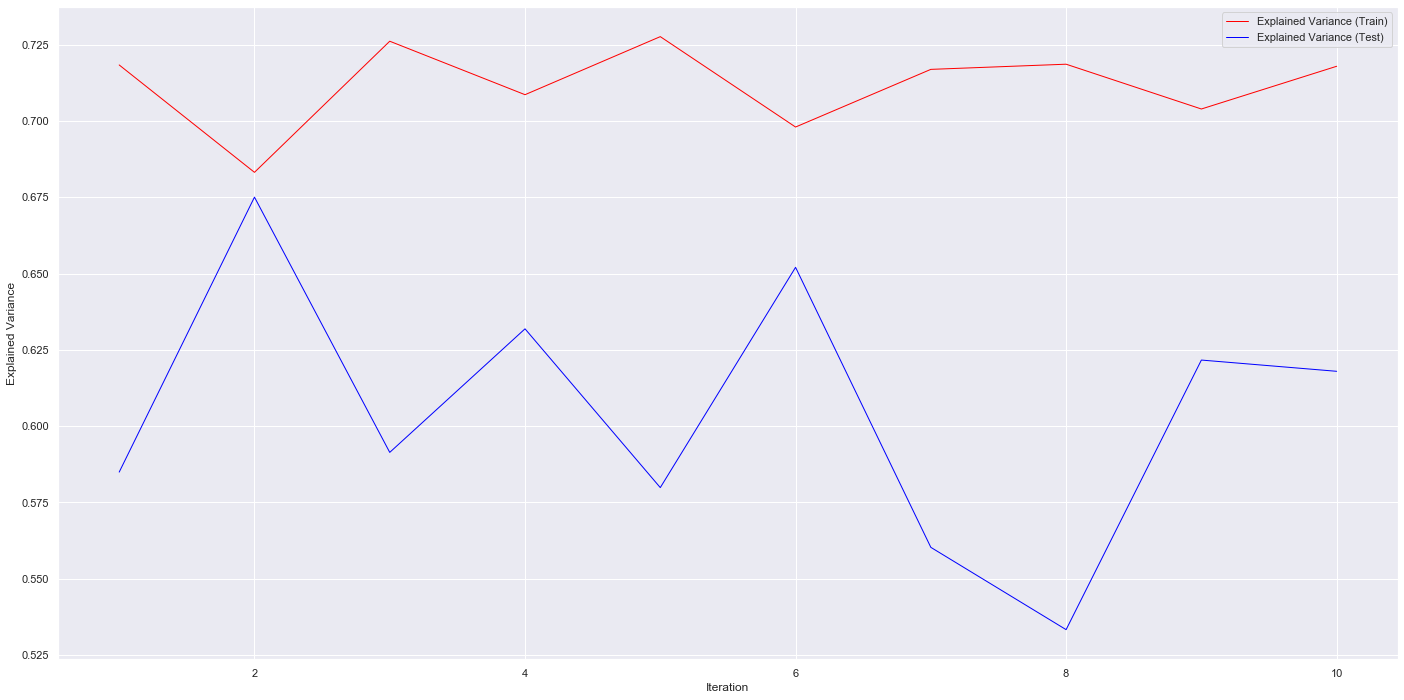

In [225]:
# Check accuracy of model based on values of explained variance for test and train over 10 iterations
f, axes = plt.subplots(1, 1, figsize=(24, 12))
axes.plot(np.array(np.arange(1,num_iterations+1)), R2_list, 'w-', linewidth = 1, color = "red",label = "Explained Variance (Train)")
axes.set_xlabel("Iteration")
axes.set_ylabel("Explained Variance")
axes.plot(np.array(np.arange(1,num_iterations+1)), R2_list_test, 'w-', linewidth = 1,color = "blue",label = 'Explained Variance (Test)')
axes.legend(loc="upper left")
axes.legend()
plt.show()

In [226]:
#Model can be used to predict review_scores_rating with array of predictor values
print("predicted review_scores_rating for various values of predictors")
print(reg.predict([[9,8,9,7,9]]))

#predict review_scores_rating for entire dataset
response_pred = reg.predict(predictors_train)
#Create dataframe of predicted review_scores_rating
test_pred=pd.DataFrame(response_pred)
#Change label of predicted review_scores_rating
test_pred=test_pred.rename(columns={0:"predicted"})
#Concatenate dataframes to show predictor values, review_scores_rating values, and predicted review_scores_rating
test_pred = pd.concat([predictors_data,response_data,test_pred],axis=1)
test_pred.describe()

predicted review_scores_rating for various values of predictors
[87.2926446]


review_scores_accuracy  review_scores_cleanliness  \
count             2834.000000                2834.000000   
mean                 9.637968                   9.568102   
std                  0.700601                   0.774040   
min                  2.000000                   4.000000   
25%                  9.000000                   9.000000   
50%                 10.000000                  10.000000   
75%                 10.000000                  10.000000   
max                 10.000000                  10.000000   

       review_scores_checkin  review_scores_communication  \
count            2834.000000                  2834.000000   
mean                9.782992                     9.808751   
std                 0.600488                     0.560603   
min                 2.000000                     2.000000   
25%                10.000000                    10.000000   
50%                10.000000                    10.000000   
75%                10.000000                    10.000000   
max                10.000000                    10.000000   

       review_scores_value  review_scores_rating    predicted  
count          2834.000000           2834.000000  2267.000000  
mean              9.455893             94.550812    94.630274  
std               0.745616              6.517651     5.266308  
min               2.000000             20.000000    31.944643  
25%               9.000000             93.000000    93.338159  
50%              10.000000             96.000000    95.843977  
75%              10.000000             99.000000    98.100816  
max              10.000000            100.000000    98.100816

# predicting ratings using linear regression

Intercept of Regression 	: b =  [1.67160082]
Coefficients of Regression 	: a =  [[1.61715655 1.71265787 1.54541305 1.52394307 3.26215035]]

                    Predictors  Coefficients
0       review_scores_accuracy      1.617157
1    review_scores_cleanliness      1.712658
2        review_scores_checkin      1.545413
3  review_scores_communication      1.523943
4          review_scores_value      3.262150



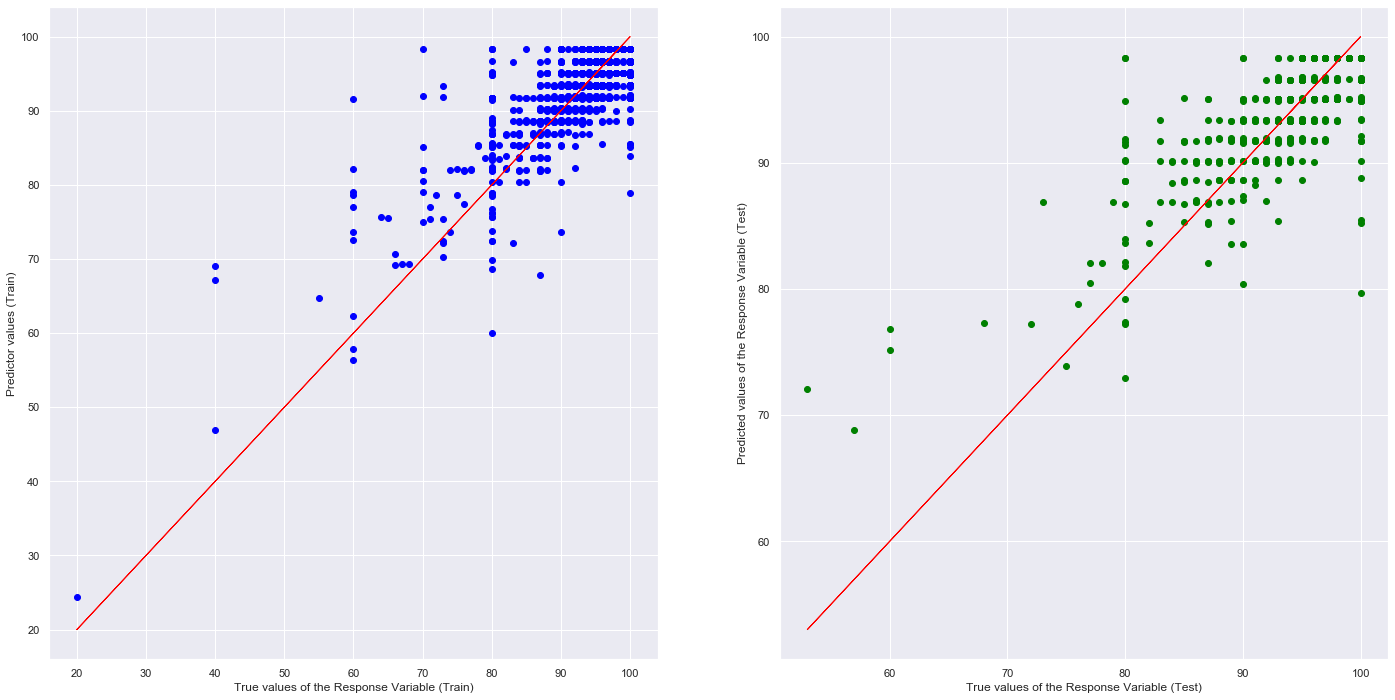

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.6650935604220596
Mean Squared Error (MSE) 	: 14.902515801719147

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.6410736997420038
Mean Squared Error (MSE) 	: 13.053139931862658

Average values over 10 iterations
R^2_train :  0.6651800848296683
R^2_test :  0.636375171139111
MSE_train :  14.613532399692776
MSE_test :  13.528078351288187


In [227]:
#Comparing random forest model with linear regression model
# Import essential models and functions from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
linreg = LinearRegression() 

# Split the Dataset into Train and Test
predictors_train, predictors_test, response_train, response_test = train_test_split(predictors_data, response_data, test_size = 0.25)

# train the linear regression model
linreg.fit(predictors_train, response_train)   

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

#Formulate regression line equation
count = 0
y_regline = linreg.intercept_
for var in predictors_data:
    y_regline+=linreg.coef_[0,count]*(pd.DataFrame(predictors_data[var]))
    count+=1

# Print the Coefficients against Predictors
print(pd.DataFrame(list(zip(predictors_train.columns, linreg.coef_[0])), columns = ["Predictors", "Coefficients"]))
print()

# Predict Response corresponding to Predictors
response_train_pred = linreg.predict(predictors_train)
response_test_pred = linreg.predict(predictors_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(response_train, response_train_pred, color = "blue")
axes[0].plot(response_train, response_train, 'w-', linewidth = 1, color = "red")
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predictor values (Train)")
axes[1].scatter(response_test, response_test_pred, color = "green")
axes[1].plot(response_test, response_test, 'w-', linewidth = 1,color = "red")
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(predictors_train, response_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(response_train, response_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(predictors_test, response_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(response_test, response_test_pred))
print()

#the order of costs are explained variance for train and test, and mse for train and test
cost_linreg = {"R^2_train":0,"R^2_test":0,"MSE_train":0,"MSE_test":0}
R2_list = []
R2_list_test = []
num_iterations = 10

for i in range(0,num_iterations):
    # Split the Dataset into Train and Test
    predictors_train, predictors_test, response_train, response_test = train_test_split(predictors_data, response_data, test_size = 0.2)
    # train the linear regression model
    linreg.fit(predictors_train, response_train)   
    # Predict Response corresponding to Predictors
    response_train_pred = linreg.predict(predictors_train)
    response_test_pred = linreg.predict(predictors_test)
                           
    cost_linreg["R^2_train"]+=(linreg.score(predictors_train, response_train))
    cost_linreg["MSE_train"]+=(mean_squared_error(response_train, response_train_pred))
    R2_list.append(linreg.score(predictors_train, response_train))

    cost_linreg["R^2_test"]+=(linreg.score(predictors_test, response_test))
    cost_linreg["MSE_test"]+=(mean_squared_error(response_test, response_test_pred))
    R2_list_test.append(linreg.score(predictors_test, response_test))
print("Average values over 10 iterations")
for var in cost_linreg:
    cost_linreg[var]/=10
    print(var,": ",cost_linreg[var])


In [228]:
clf = svm.SVC(kernel='linear', C=1)
#source: https://scikit-learn.org/stable/modules/cross_validation.html
#Determine performance of model using cross_val_score
scores = cross_val_score(linreg, predictors_data, response_data, cv=5)
print("Explained Variance :%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#The linear regression model has moderate performance in predicting review_scores_rating 

Explained Variance :0.64 (+/- 0.12)


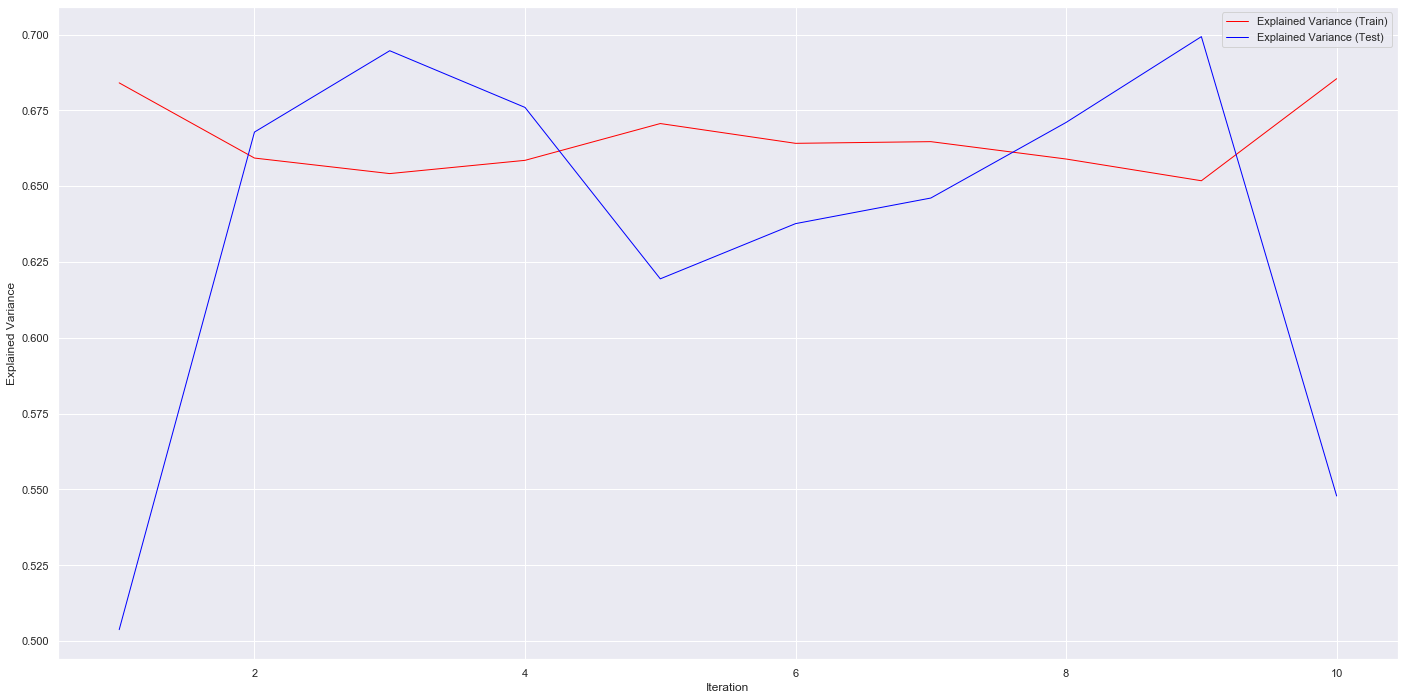

In [229]:
# Check accuracy of model based on values of explained variance for test and train over 10 iterations
f, axes = plt.subplots(1, 1, figsize=(24, 12))
axes.plot(np.array(np.arange(1,num_iterations+1)), R2_list, 'w-', linewidth = 1, color = "red",label = "Explained Variance (Train)")
axes.set_xlabel("Iteration")
axes.set_ylabel("Explained Variance")
axes.plot(np.array(np.arange(1,num_iterations+1)), R2_list_test, 'w-', linewidth = 1,color = "blue",label = 'Explained Variance (Test)')
axes.legend(loc="upper left")
axes.legend()
plt.show()

Both random forest regression and linear regression can be moderately accurate models in predicting ratings as cross_val_score for explained variance and explained variance scores for test sets over several iterations are moderately high (above 0.5). 

# predict ratings within each cluster using regression

In [230]:
#Regression to predict review_scores_rating for cluster with 'small-low-quality listing'
cluster_data=clustered_data_k[clustered_data_k.Cluster=='small-low-quality listing']

num_data = pd.DataFrame(data = cluster_data, columns = ["review_scores_rating","review_scores_accuracy",\
                                                    "review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_location","review_scores_value"])
#Convert review_scores_accuracy back to numeric
num_data = num_data.astype("float64")
response_data = pd.DataFrame(num_data["review_scores_rating"])
predictors_data = pd.DataFrame(data = num_data, columns = ["review_scores_accuracy",\
        "review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_value"])
num_data.info()
num_data.corr()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 252 entries, 15 to 3813
Data columns (total 7 columns):
review_scores_rating           252 non-null float64
review_scores_accuracy         252 non-null float64
review_scores_cleanliness      252 non-null float64
review_scores_checkin          252 non-null float64
review_scores_communication    252 non-null float64
review_scores_location         252 non-null float64
review_scores_value            252 non-null float64
dtypes: float64(7)
memory usage: 15.8 KB


review_scores_rating  review_scores_accuracy  \
review_scores_rating                     1.000000                0.485481   
review_scores_accuracy                   0.485481                1.000000   
review_scores_cleanliness                0.394217                0.452183   
review_scores_checkin                    0.407815                0.263531   
review_scores_communication              0.504193                0.331144   
review_scores_location                   0.195907                0.162853   
review_scores_value                      0.611765                0.501790   

                             review_scores_cleanliness  review_scores_checkin  \
review_scores_rating                          0.394217               0.407815   
review_scores_accuracy                        0.452183               0.263531   
review_scores_cleanliness                     1.000000               0.239564   
review_scores_checkin                         0.239564               1.000000   
review_scores_communication                   0.212369               0.729063   
review_scores_location                        0.198733               0.163120   
review_scores_value                           0.333679               0.268478   

                             review_scores_communication  \
review_scores_rating                            0.504193   
review_scores_accuracy                          0.331144   
review_scores_cleanliness                       0.212369   
review_scores_checkin                           0.729063   
review_scores_communication                     1.000000   
review_scores_location                          0.229108   
review_scores_value                             0.413524   

                             review_scores_location  review_scores_value  
review_scores_rating                       0.195907             0.611765  
review_scores_accuracy                     0.162853             0.501790  
review_scores_cleanliness                  0.198733             0.333679  
review_scores_checkin                      0.163120             0.268478  
review_scores_communication                0.229108             0.413524  
review_scores_location                     1.000000             0.422679  
review_scores_value                        0.422679             1.000000

/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


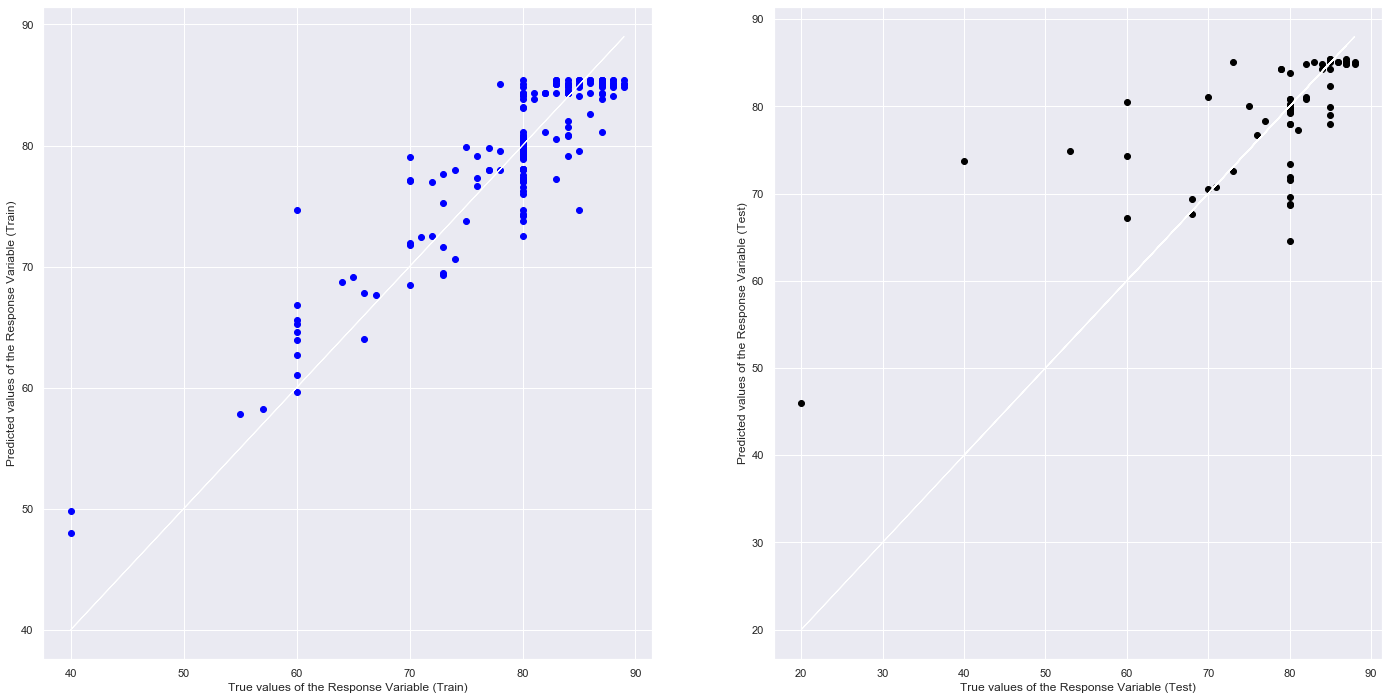

Goodness of Fit of Model (Train) )
Explained Variance (R^2) 	: 0.8393635616511522
Mean Squared Error (MSE) 	: 10.837700376468925

Goodness of Fit of Model (Test) )
Explained Variance (R^2) 	: 0.47380301784147516
Mean Squared Error (MSE) 	: 68.52254034331011

Explained Variance :0.17 (+/- 0.71)


/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3

In [231]:
#split data set
predictors_train, predictors_test, response_train, response_test = train_test_split(predictors_data, response_data, test_size = 0.25)

#Obtain an optimal "max_depth" (maximum tree depth) and "n_estimators" (number of trees) by minimising cost function
gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0,n_jobs=-1)

grid_result = gsc.fit(predictors_train, response_train)
best_params = grid_result.best_params_

#define regression model using the max_depth and n_estimators obtained 
reg = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],random_state=0)                            
#fit model
reg.fit(predictors_train, response_train)

#predict ratings values. Returns an array of predicted ratings
response_pred = reg.predict(predictors_train)
response_pred_test = reg.predict(predictors_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(response_train, response_pred, color = "blue")
axes[0].plot(response_train, response_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(response_test, response_pred_test, color = "black")
axes[1].plot(response_test, response_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model (Train) )")
print("Explained Variance (R^2) \t:", reg.score(predictors_train, response_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(response_train, response_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model (Test) )")
print("Explained Variance (R^2) \t:", reg.score(predictors_test, response_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(response_test, response_pred_test))
print()

clf = svm.SVC(kernel='linear', C=1)
#source: https://scikit-learn.org/stable/modules/cross_validation.html
#Determine performance of model using cross_val_score
scores = cross_val_score(reg, predictors_data, response_data, cv=5)
print("Explained Variance :%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#The random forest regression model has moderate performance in predicting prices


In [232]:
#Regression to predict review_scores_rating for cluster with 'small-high-quality listing'
cluster_data=clustered_data_k[clustered_data_k.Cluster=='small-high-quality listing']

num_data = pd.DataFrame(data = cluster_data, columns = ["review_scores_rating","review_scores_accuracy",\
                                                    "review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_location","review_scores_value"])
#Convert review_scores_accuracy back to numeric
num_data = num_data.astype("float64")
response_data = pd.DataFrame(num_data["review_scores_rating"])
predictors_data = pd.DataFrame(data = num_data, columns = ["review_scores_accuracy",\
        "review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_value"])
num_data.info()
num_data.corr()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 822 entries, 0 to 3811
Data columns (total 7 columns):
review_scores_rating           822 non-null float64
review_scores_accuracy         822 non-null float64
review_scores_cleanliness      822 non-null float64
review_scores_checkin          822 non-null float64
review_scores_communication    822 non-null float64
review_scores_location         822 non-null float64
review_scores_value            822 non-null float64
dtypes: float64(7)
memory usage: 51.4 KB


review_scores_rating  review_scores_accuracy  \
review_scores_rating                     1.000000                0.261951   
review_scores_accuracy                   0.261951                1.000000   
review_scores_cleanliness                0.403329                0.218665   
review_scores_checkin                    0.243898                0.219942   
review_scores_communication              0.167100                0.225930   
review_scores_location                   0.199455                0.027383   
review_scores_value                      0.527859                0.248382   

                             review_scores_cleanliness  review_scores_checkin  \
review_scores_rating                          0.403329               0.243898   
review_scores_accuracy                        0.218665               0.219942   
review_scores_cleanliness                     1.000000               0.176401   
review_scores_checkin                         0.176401               1.000000   
review_scores_communication                   0.149500               0.565844   
review_scores_location                        0.109409               0.069295   
review_scores_value                           0.325219               0.200664   

                             review_scores_communication  \
review_scores_rating                            0.167100   
review_scores_accuracy                          0.225930   
review_scores_cleanliness                       0.149500   
review_scores_checkin                           0.565844   
review_scores_communication                     1.000000   
review_scores_location                          0.039688   
review_scores_value                             0.207880   

                             review_scores_location  review_scores_value  
review_scores_rating                       0.199455             0.527859  
review_scores_accuracy                     0.027383             0.248382  
review_scores_cleanliness                  0.109409             0.325219  
review_scores_checkin                      0.069295             0.200664  
review_scores_communication                0.039688             0.207880  
review_scores_location                     1.000000             0.120278  
review_scores_value                        0.120278             1.000000

/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


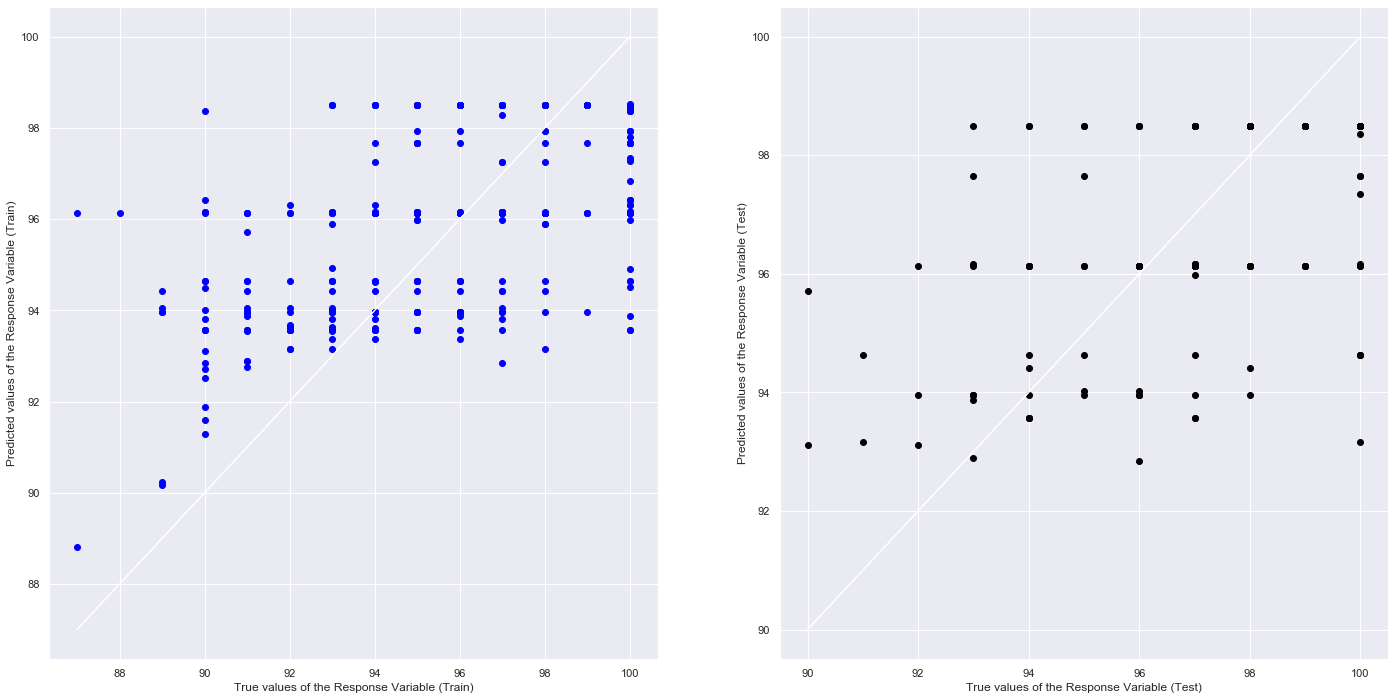

Goodness of Fit of Model (Train) )
Explained Variance (R^2) 	: 0.4483833061362059
Mean Squared Error (MSE) 	: 4.942941746488403

Goodness of Fit of Model (Test) )
Explained Variance (R^2) 	: 0.31520883610821926
Mean Squared Error (MSE) 	: 4.427536449325502



/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


Explained Variance :0.34 (+/- 0.17)


/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


In [233]:
#split data set
predictors_train, predictors_test, response_train, response_test = train_test_split(predictors_data, response_data, test_size = 0.2)

#Obtain an optimal "max_depth" (maximum tree depth) and "n_estimators" (number of trees) by minimising cost function
gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0,n_jobs=-1)

grid_result = gsc.fit(predictors_train, response_train)
best_params = grid_result.best_params_

#define regression model using the max_depth and n_estimators obtained 
reg = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],random_state=0)                            
#fit model
reg.fit(predictors_train, response_train)

#predict ratings values. Returns an array of predicted ratings
response_pred = reg.predict(predictors_train)
response_pred_test = reg.predict(predictors_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(response_train, response_pred, color = "blue")
axes[0].plot(response_train, response_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(response_test, response_pred_test, color = "black")
axes[1].plot(response_test, response_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model (Train) )")
print("Explained Variance (R^2) \t:", reg.score(predictors_train, response_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(response_train, response_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model (Test) )")
print("Explained Variance (R^2) \t:", reg.score(predictors_test, response_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(response_test, response_pred_test))
print()

clf = svm.SVC(kernel='linear', C=1)
#source: https://scikit-learn.org/stable/modules/cross_validation.html
#Determine performance of model using cross_val_score
scores = cross_val_score(reg, predictors_data, response_data, cv=5)
print("Explained Variance :%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#The random forest regression model has moderate performance in predicting prices

In [234]:
#Regression to predict review_scores_rating for cluster with 'small-cheap listing'
cluster_data=clustered_data_k[clustered_data_k.Cluster=='small-cheap listing']

num_data = pd.DataFrame(data = cluster_data, columns = ["review_scores_rating","review_scores_accuracy",\
                                                    "review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_location","review_scores_value"])
#Convert review_scores_accuracy back to numeric
num_data = num_data.astype("float64")
response_data = pd.DataFrame(num_data["review_scores_rating"])
predictors_data = pd.DataFrame(data = num_data, columns = ["review_scores_accuracy",\
        "review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_value"])
num_data.info()
num_data.corr()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 840 entries, 6 to 3799
Data columns (total 7 columns):
review_scores_rating           840 non-null float64
review_scores_accuracy         840 non-null float64
review_scores_cleanliness      840 non-null float64
review_scores_checkin          840 non-null float64
review_scores_communication    840 non-null float64
review_scores_location         840 non-null float64
review_scores_value            840 non-null float64
dtypes: float64(7)
memory usage: 52.5 KB


review_scores_rating  review_scores_accuracy  \
review_scores_rating                     1.000000                0.500883   
review_scores_accuracy                   0.500883                1.000000   
review_scores_cleanliness                0.540022                0.482985   
review_scores_checkin                    0.325471                0.402224   
review_scores_communication              0.304225                0.296368   
review_scores_location                   0.335803                0.167339   
review_scores_value                      0.594843                0.454867   

                             review_scores_cleanliness  review_scores_checkin  \
review_scores_rating                          0.540022               0.325471   
review_scores_accuracy                        0.482985               0.402224   
review_scores_cleanliness                     1.000000               0.306547   
review_scores_checkin                         0.306547               1.000000   
review_scores_communication                   0.269272               0.587683   
review_scores_location                        0.187206               0.187764   
review_scores_value                           0.441029               0.295000   

                             review_scores_communication  \
review_scores_rating                            0.304225   
review_scores_accuracy                          0.296368   
review_scores_cleanliness                       0.269272   
review_scores_checkin                           0.587683   
review_scores_communication                     1.000000   
review_scores_location                          0.237895   
review_scores_value                             0.280942   

                             review_scores_location  review_scores_value  
review_scores_rating                       0.335803             0.594843  
review_scores_accuracy                     0.167339             0.454867  
review_scores_cleanliness                  0.187206             0.441029  
review_scores_checkin                      0.187764             0.295000  
review_scores_communication                0.237895             0.280942  
review_scores_location                     1.000000             0.275719  
review_scores_value                        0.275719             1.000000

/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


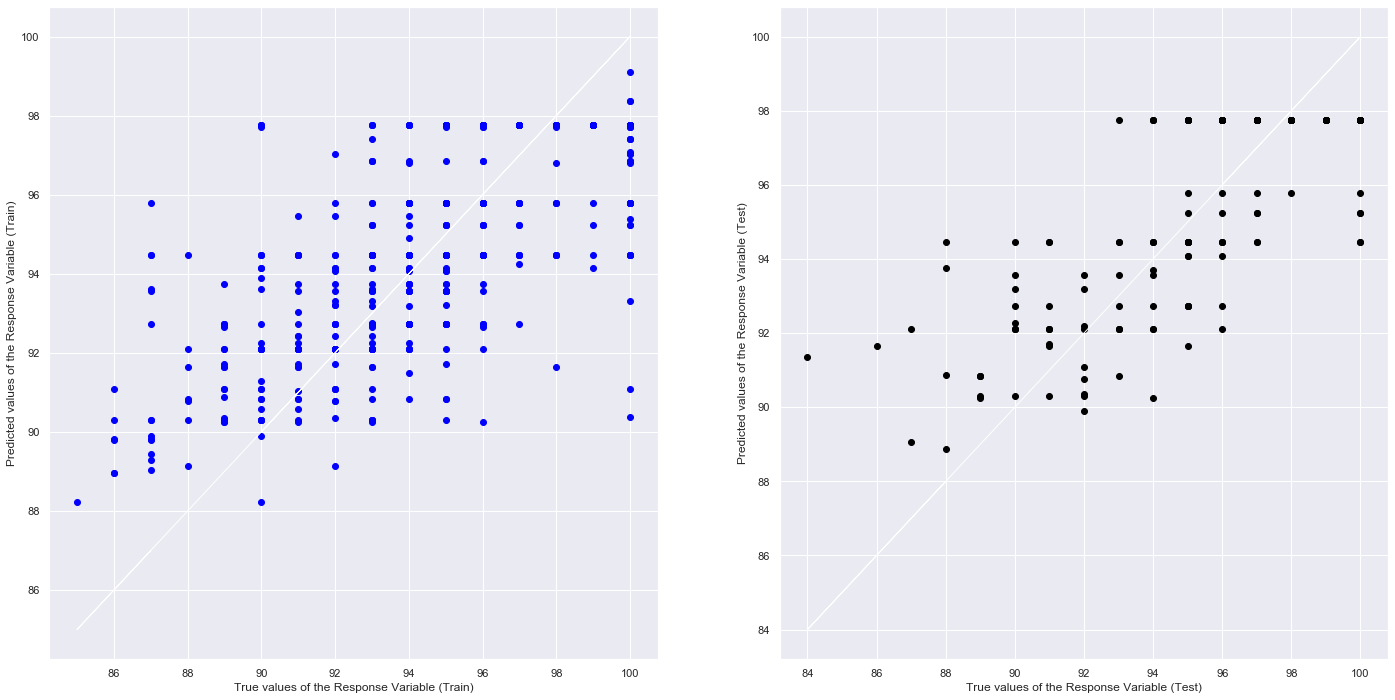

Goodness of Fit of Model (Train) )
Explained Variance (R^2) 	: 0.5455050291354621
Mean Squared Error (MSE) 	: 5.718284740296846

Goodness of Fit of Model (Test) )
Explained Variance (R^2) 	: 0.5994086465487529
Mean Squared Error (MSE) 	: 5.172204375491633

Explained Variance :0.49 (+/- 0.15)


/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3

In [235]:
#split data set
predictors_train, predictors_test, response_train, response_test = train_test_split(predictors_data, response_data, test_size = 0.2)

#Obtain an optimal "max_depth" (maximum tree depth) and "n_estimators" (number of trees) by minimising cost function
gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0,n_jobs=-1)

grid_result = gsc.fit(predictors_train, response_train)
best_params = grid_result.best_params_

#define regression model using the max_depth and n_estimators obtained 
reg = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],random_state=0)                            
#fit model
reg.fit(predictors_train, response_train)

#predict ratings values. Returns an array of predicted ratings
response_pred = reg.predict(predictors_train)
response_pred_test = reg.predict(predictors_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(response_train, response_pred, color = "blue")
axes[0].plot(response_train, response_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(response_test, response_pred_test, color = "black")
axes[1].plot(response_test, response_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model (Train) )")
print("Explained Variance (R^2) \t:", reg.score(predictors_train, response_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(response_train, response_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model (Test) )")
print("Explained Variance (R^2) \t:", reg.score(predictors_test, response_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(response_test, response_pred_test))
print()

clf = svm.SVC(kernel='linear', C=1)
#source: https://scikit-learn.org/stable/modules/cross_validation.html
#Determine performance of model using cross_val_score
scores = cross_val_score(reg, predictors_data, response_data, cv=5)
print("Explained Variance :%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#The random forest regression model has moderate performance in predicting prices


In [236]:
#Regression to predict review_scores_rating for cluster with 'medium listing'
cluster_data=clustered_data_k[clustered_data_k.Cluster=='medium listing']

num_data = pd.DataFrame(data = cluster_data, columns = ["review_scores_rating","review_scores_accuracy",\
                                                    "review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_location","review_scores_value"])
#Convert review_scores_accuracy back to numeric
num_data = num_data.astype("float64")
response_data = pd.DataFrame(num_data["review_scores_rating"])
predictors_data = pd.DataFrame(data = num_data, columns = ["review_scores_accuracy",\
        "review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_value"])
num_data.info()
num_data.corr()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 575 entries, 12 to 3814
Data columns (total 7 columns):
review_scores_rating           575 non-null float64
review_scores_accuracy         575 non-null float64
review_scores_cleanliness      575 non-null float64
review_scores_checkin          575 non-null float64
review_scores_communication    575 non-null float64
review_scores_location         575 non-null float64
review_scores_value            575 non-null float64
dtypes: float64(7)
memory usage: 35.9 KB


review_scores_rating  review_scores_accuracy  \
review_scores_rating                     1.000000                0.426575   
review_scores_accuracy                   0.426575                1.000000   
review_scores_cleanliness                0.415494                0.366809   
review_scores_checkin                    0.351184                0.207276   
review_scores_communication              0.302644                0.208573   
review_scores_location                   0.310605                0.195650   
review_scores_value                      0.481712                0.371966   

                             review_scores_cleanliness  review_scores_checkin  \
review_scores_rating                          0.415494               0.351184   
review_scores_accuracy                        0.366809               0.207276   
review_scores_cleanliness                     1.000000               0.231738   
review_scores_checkin                         0.231738               1.000000   
review_scores_communication                   0.189345               0.494873   
review_scores_location                        0.137153               0.095394   
review_scores_value                           0.328223               0.217936   

                             review_scores_communication  \
review_scores_rating                            0.302644   
review_scores_accuracy                          0.208573   
review_scores_cleanliness                       0.189345   
review_scores_checkin                           0.494873   
review_scores_communication                     1.000000   
review_scores_location                          0.190733   
review_scores_value                             0.337028   

                             review_scores_location  review_scores_value  
review_scores_rating                       0.310605             0.481712  
review_scores_accuracy                     0.195650             0.371966  
review_scores_cleanliness                  0.137153             0.328223  
review_scores_checkin                      0.095394             0.217936  
review_scores_communication                0.190733             0.337028  
review_scores_location                     1.000000             0.279317  
review_scores_value                        0.279317             1.000000

/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


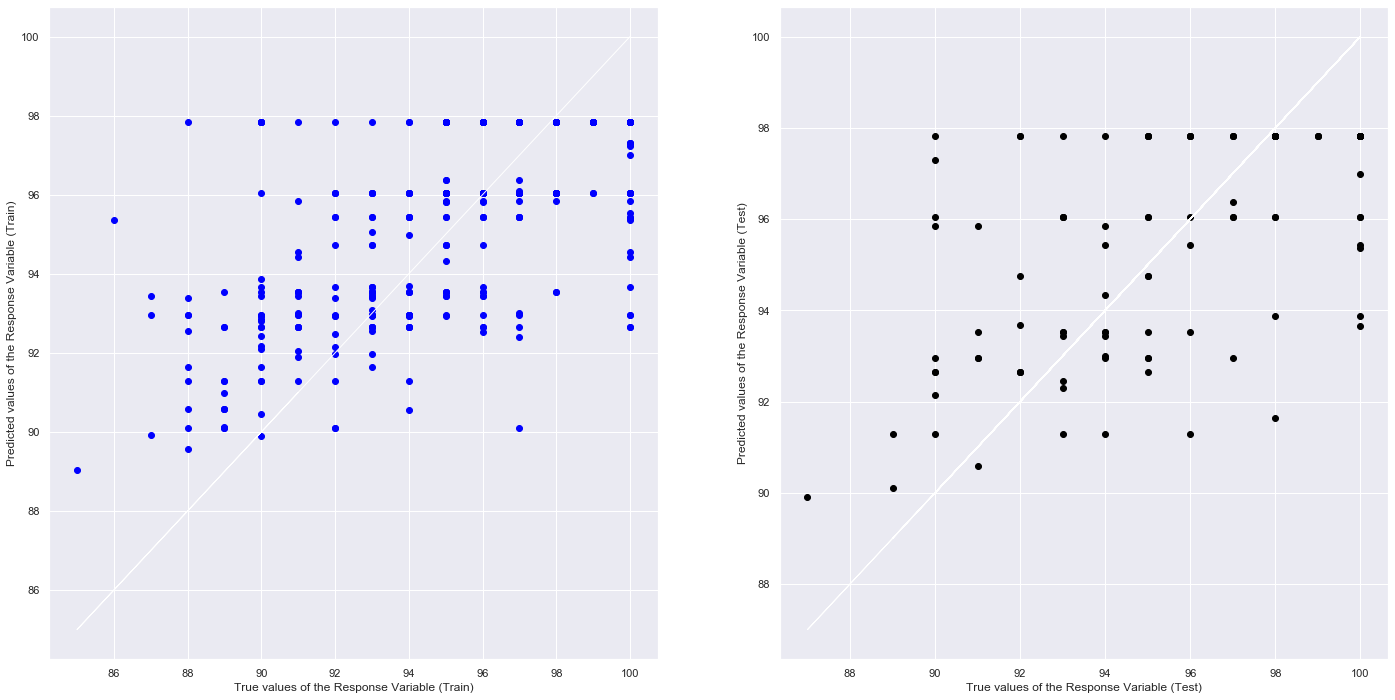

Goodness of Fit of Model (Train) )
Explained Variance (R^2) 	: 0.49284904848250255
Mean Squared Error (MSE) 	: 6.3768983284781715

Goodness of Fit of Model (Test) )
Explained Variance (R^2) 	: 0.37161394774618217
Mean Squared Error (MSE) 	: 7.522386861899088



/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


Explained Variance :0.40 (+/- 0.19)


/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


In [237]:
#split data set
predictors_train, predictors_test, response_train, response_test = train_test_split(predictors_data, response_data, test_size = 0.2)

#Obtain an optimal "max_depth" (maximum tree depth) and "n_estimators" (number of trees) by minimising cost function
gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0,n_jobs=-1)

grid_result = gsc.fit(predictors_train, response_train)
best_params = grid_result.best_params_

#define regression model using the max_depth and n_estimators obtained 
reg = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],random_state=0)                            
#fit model
reg.fit(predictors_train, response_train)

#predict ratings values. Returns an array of predicted ratings
response_pred = reg.predict(predictors_train)
response_pred_test = reg.predict(predictors_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(response_train, response_pred, color = "blue")
axes[0].plot(response_train, response_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(response_test, response_pred_test, color = "black")
axes[1].plot(response_test, response_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model (Train) )")
print("Explained Variance (R^2) \t:", reg.score(predictors_train, response_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(response_train, response_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model (Test) )")
print("Explained Variance (R^2) \t:", reg.score(predictors_test, response_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(response_test, response_pred_test))
print()

clf = svm.SVC(kernel='linear', C=1)
#source: https://scikit-learn.org/stable/modules/cross_validation.html
#Determine performance of model using cross_val_score
scores = cross_val_score(reg, predictors_data, response_data, cv=5)
print("Explained Variance :%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#The random forest regression model has moderate performance in predicting prices


In [238]:
#Regression to predict review_scores_rating for cluster with 'large listing'
cluster_data=clustered_data_k[clustered_data_k.Cluster=='large listing']

num_data = pd.DataFrame(data = cluster_data, columns = ["review_scores_rating","review_scores_accuracy",\
                                                    "review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_location","review_scores_value"])
#Convert review_scores_accuracy back to numeric
num_data = num_data.astype("float64")
response_data = pd.DataFrame(num_data["review_scores_rating"])
predictors_data = pd.DataFrame(data = num_data, columns = ["review_scores_accuracy",\
        "review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_value"])
num_data.info()
num_data.corr()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 345 entries, 2 to 3808
Data columns (total 7 columns):
review_scores_rating           345 non-null float64
review_scores_accuracy         345 non-null float64
review_scores_cleanliness      345 non-null float64
review_scores_checkin          345 non-null float64
review_scores_communication    345 non-null float64
review_scores_location         345 non-null float64
review_scores_value            345 non-null float64
dtypes: float64(7)
memory usage: 21.6 KB


review_scores_rating  review_scores_accuracy  \
review_scores_rating                     1.000000                0.556658   
review_scores_accuracy                   0.556658                1.000000   
review_scores_cleanliness                0.535195                0.342288   
review_scores_checkin                    0.380789                0.259626   
review_scores_communication              0.405210                0.296816   
review_scores_location                   0.295089                0.209646   
review_scores_value                      0.560425                0.472393   

                             review_scores_cleanliness  review_scores_checkin  \
review_scores_rating                          0.535195               0.380789   
review_scores_accuracy                        0.342288               0.259626   
review_scores_cleanliness                     1.000000               0.273012   
review_scores_checkin                         0.273012               1.000000   
review_scores_communication                   0.310858               0.439542   
review_scores_location                        0.173865               0.214094   
review_scores_value                           0.332302               0.318357   

                             review_scores_communication  \
review_scores_rating                            0.405210   
review_scores_accuracy                          0.296816   
review_scores_cleanliness                       0.310858   
review_scores_checkin                           0.439542   
review_scores_communication                     1.000000   
review_scores_location                          0.222190   
review_scores_value                             0.264012   

                             review_scores_location  review_scores_value  
review_scores_rating                       0.295089             0.560425  
review_scores_accuracy                     0.209646             0.472393  
review_scores_cleanliness                  0.173865             0.332302  
review_scores_checkin                      0.214094             0.318357  
review_scores_communication                0.222190             0.264012  
review_scores_location                     1.000000             0.251969  
review_scores_value                        0.251969             1.000000

/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


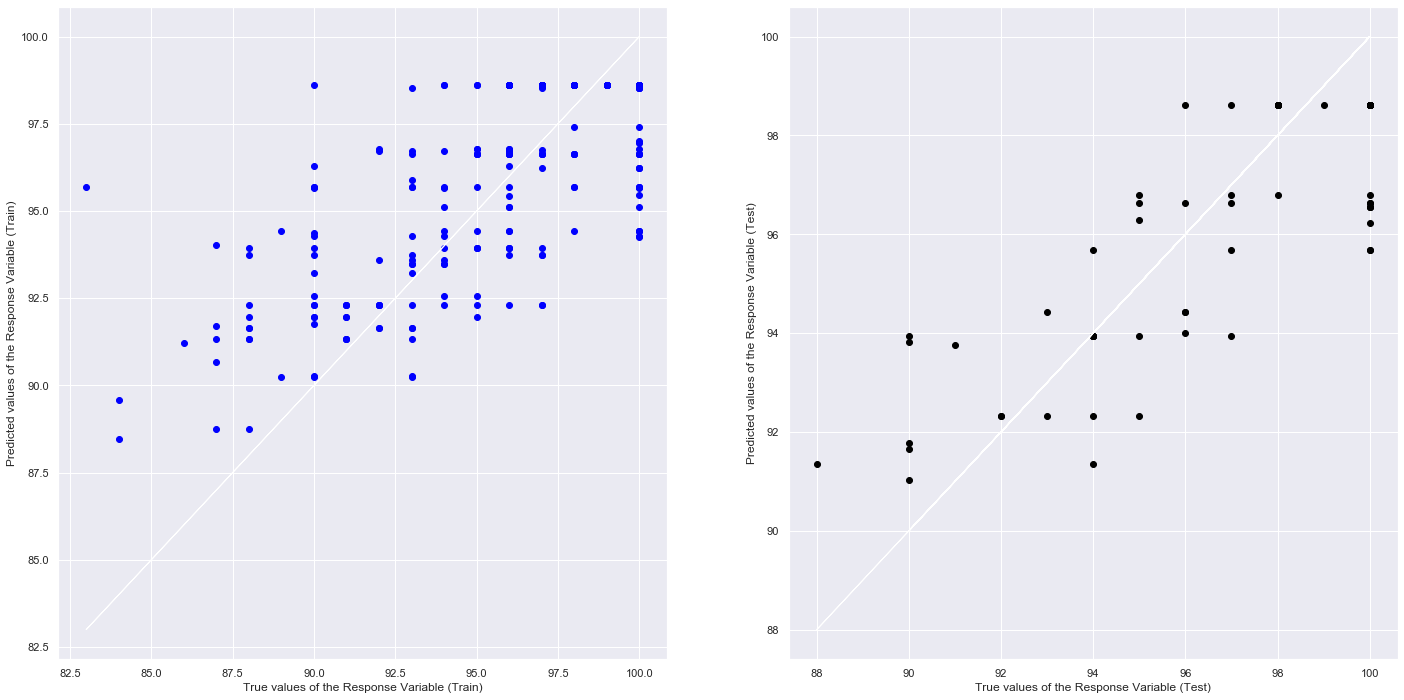

Goodness of Fit of Model (Train) )
Explained Variance (R^2) 	: 0.5715361534200892
Mean Squared Error (MSE) 	: 7.033897526110162

Goodness of Fit of Model (Test) )
Explained Variance (R^2) 	: 0.6489720047901235
Mean Squared Error (MSE) 	: 3.977137600842503



/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


Explained Variance :0.49 (+/- 0.05)


/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/desmondlewjiangyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


In [239]:
#split data set
predictors_train, predictors_test, response_train, response_test = train_test_split(predictors_data, response_data, test_size = 0.2)

#Obtain an optimal "max_depth" (maximum tree depth) and "n_estimators" (number of trees) by minimising cost function
gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0,n_jobs=-1)

grid_result = gsc.fit(predictors_train, response_train)
best_params = grid_result.best_params_

#define regression model using the max_depth and n_estimators obtained 
reg = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],random_state=0)                            
#fit model
reg.fit(predictors_train, response_train)

#predict ratings values. Returns an array of predicted ratings
response_pred = reg.predict(predictors_train)
response_pred_test = reg.predict(predictors_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(response_train, response_pred, color = "blue")
axes[0].plot(response_train, response_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(response_test, response_pred_test, color = "black")
axes[1].plot(response_test, response_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model (Train) )")
print("Explained Variance (R^2) \t:", reg.score(predictors_train, response_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(response_train, response_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model (Test) )")
print("Explained Variance (R^2) \t:", reg.score(predictors_test, response_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(response_test, response_pred_test))
print()

clf = svm.SVC(kernel='linear', C=1)
#source: https://scikit-learn.org/stable/modules/cross_validation.html
#Determine performance of model using cross_val_score
scores = cross_val_score(reg, predictors_data, response_data, cv=5)
print("Explained Variance :%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#The random forest regression model has moderate performance in predicting prices


The prediction of review_scores_ratings for each cluster, except for the cluster for 'small-low-quality listing', is less accurate that the prediction based on the whole data

# Conclusion

We want a user to be able to use airbnb easily and effectively. <br>

As the listings can be clustered according to size (small, medium and large listings) and quality (small-cheap listing, small-low-quality listing, small-high-quality listing) and prices are segmented across the clusters, the clusters can be used to determine if a specific listing is reasonably priced. Similarly, regression can be used to predict the price of a listing. By comparing the predicted price and listed price, a user would know if a listing is underpriced, reasonably priced, or overpriced.<br>

Also, as demand in the period around June to August and in January tend to be higher, users could plan accordingly to secure their bookings. In addition, users could choose non-peak seasons if they wish to save money on accommodation, knowing that prices tend to be lower during these periods.<br>

In addition, users are able to predict if a particular listing they identified would be booked or not, better informing them, and empowering them to decide on their booking plans.<br>

Lastly, users would know that factors, such as cleanliness, accuracy, subjective assessment of value, communication with host, and smoothness of checkin process affect ratings score and would know which listings fit their criteria.  <br>

All in all, users would be more informed on the availability and price trends that listings follow and would be able to choose listings that are reasonably price and fit their expectations effectively and easily.